In [1]:
from pyrosetta import *
from pyrosetta.rosetta import *
init('-corrections::restore_talaris_behavior')
import pyrosetta.rosetta.protocols.rigid as rigid_moves
from pyrosetta.rosetta.core.id import *
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
import itertools
from recces.util import torsion_volume
import recces.data

Found rosetta database at: /usr/local/lib/python2.7/dist-packages/pyrosetta-2018.11+release.7c7790f-py2.7-linux-x86_64.egg/pyrosetta/database; using it....
PyRosetta-4 2017 [Rosetta PyRosetta4.Release.python27.ubuntu 2018.11+release.7c7790f7c7790fbb898f8210b54513b9f9c8a927c3e8d7f 2018-03-14T13:19:04] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions.
Created in JHU by Sergey Lyskov and PyRosetta Team.

core.init: Checking for fconfig files in pwd and ./rosetta/flags

core.init: Rosetta version: PyRosetta4.Release.python27.ubuntu r173 2018.11+release.7c7790f 7c7790fbb898f8210b54513b9f9c8a927c3e8d7f http://www.pyrosetta.org 2018-03-14T13:19:04
core.init: command: PyRosetta -corrections::restore_talaris_behavior -database /usr/local/lib/python2.7/dist-packages/pyrosetta-2018.11+release.7c7790f-py2.7-linux-x86_64.egg/pyrosetta/database
core.init: 'RNG device' seed mode, using '/dev/urandom', seed=1624638445 seed_offset=0 real_seed=1624638445
core.in

In [19]:
pose = pyrosetta.rosetta.protocols.recces.pose_setup_turner('c', 'g')
print pose.fold_tree()
c_g_hist = recces.data.SingleHistSimulation('./../recces_rosetta/results/c_g/ST/')
ST_min = pose_from_file('min.pdb')
fold_tree = pose.fold_tree()
ST_min.fold_tree(fold_tree)
scorefxn(ST_min)

FOLD_TREE  JEDGE 1 2 1  C2   C4   END 
Inferring sequence from directory name:  c_g
applying phase space volume for two strand with helix length  1  and dangle length  0
core.import_pose.import_pose: File 'min.pdb' automatically determined to be of type PDB


-8.853923202599699

In [132]:
pmm.apply(pose)
pose.jump(1).get_rotation()




In [ ]:
pert_mover = rigid_moves.RigidBodyPerturbMover(1, 20, 0.5)

In [ ]:
pmm = PyMOLMover()
pmm.apply(pose)

In [ ]:
pert_mover.apply(pose)
pmm.apply(pose)

In [ ]:
movemap = MoveMap()

In [ ]:
movemap.set_jump(1, True)
movemap.set_bb(True)
movemap.set_chi(True)

In [ ]:
scorefxn = protocols.rna.denovo.get_rna_hires_scorefxn()

In [ ]:
minmover = protocols.minimization_packing.MinMover()
minmover.score_function(scorefxn)
minmover.tolerance(1e-7)
minmover.max_iter(100000)
minmover.movemap(movemap)

In [ ]:
minmover.apply(pose)

In [ ]:
pmm.apply(pose)

In [ ]:
print pert_mover.

In [ ]:
scorefxn(pose)

In [ ]:
pose.jump(1).set_translation(numeric.xyzVector_double_t(1.,1.,1.))

In [ ]:
print core.id.TorsionID(1, BB, 2)

In [ ]:
scorefxn(pose)

In [ ]:
trans_mover = rigid_moves.RigidBodyTransMover(pose, 1)
spin_mover = rigid_moves.RigidBodyDeterministicSpinMover()
spin_mover.rb_jump(1)
spin_mover.angle_magnitude(-1)
pmm.apply(pose)


In [ ]:
trans_mover.step_size(20)
trans_mover.apply(pose)
E_0 = scorefxn(pose)

In [ ]:
pmm.apply(pose)

In [ ]:
pose.assign(minimum)
pert_mover.apply(pose)

In [ ]:

spin_mover.spin_axis(numeric.xyzVector_double_t(0,1,0))

In [ ]:
spin_mover.apply(pose)
pmm.apply(pose)

In [3]:
def numpy_hessian(x, h):
        
    x_grad = np.gradient(x, h)
    hessian = np.empty((x.ndim, x.ndim) + x.shape, dtype = x.dtype)
    
    for k, grad_k in enumerate(x_grad):
        tmp_grad = np.gradient(grad_k, h)
        for l, grad_kl in enumerate(tmp_grad):
            hessian[k, l, :, :] = grad_kl
            
    return hessian

In [4]:
def tr_energy(pose, scorefxn, i, j, h=0.001):
    
    w = 0.004
    n_pts = int(w/h + 1)
    energy = np.zeros((n_pts,n_pts))
    
    if i == 0: a = numeric.xyzVector_double_t(1,0,0)
    elif i == 1: a = numeric.xyzVector_double_t(0,1,0)
    else: a = numeric.xyzVector_double_t(0,0,1)
            
    if j == 3: b = numeric.xyzVector_double_t(1,0,0)
    elif j == 4: b = numeric.xyzVector_double_t(0,1,0)
    else: b = numeric.xyzVector_double_t(0,0,1)
        
    # Initialize first rigid body mover
    step_i = rigid_moves.RigidBodyTransMover(pose, 1)
    step_i.trans_axis(a)
    step_i.step_size(-w/2)
    
    # Initialize second spin mover
    spin_j = rigid_moves.RigidBodyDeterministicSpinMover()
    spin_j.spin_axis(b)
    spin_j.rot_center(core.conformation.all_atom_center(pose.residue(2)))
    spin_j.angle_magnitude(-w/2./np.pi*180.)
    
    
    step_i.apply(pose)
    spin_j.apply(pose)
    energy[0,0] = scorefxn(pose)
    
    step_i.step_size(h)
    spin_j.angle_magnitude(h/np.pi*180)
    
    for dy in range(1, n_pts):
        
        spin_j.apply(pose)
        energy[0, dy] = scorefxn(pose)
        
    spin_j.angle_magnitude(-(w+h)/np.pi*180)
    spin_j.apply(pose)
    spin_j.angle_magnitude(h/np.pi*180)
       
    for dx in range(1, n_pts):
        
        step_i.apply(pose)
        
        for dy in range(n_pts):
            
            spin_j.apply(pose)
            energy[dx,dy] = scorefxn(pose)
            
        spin_j.angle_magnitude(-(w+h)/np.pi*180)
        spin_j.apply(pose)
        spin_j.angle_magnitude(h/np.pi*180)
    
    return energy



In [5]:
def rr_energy(pose, scorefxn, i, j, h=0.001):
    
    w = 0.004
    n_pts = int(w/h + 1)
    energy = np.zeros((n_pts,n_pts))
    
    if i == 3: 
        
        a = numeric.xyzVector_double_t(1,0,0)
        
        if j == 4: b = numeric.xyzVector_double_t(0,1,0)
        else: b = numeric.xyzVector_double_t(0,0,1)
            
    else: 
        
        a = numeric.xyzVector_double_t(0,1,0)
        b = numeric.xyzVector_double_t(0,0,1)
        
    # Initialize first spin mover
    spin_i = rigid_moves.RigidBodyDeterministicSpinMover()
    spin_i.spin_axis(a)
    spin_i.rot_center(core.conformation.all_atom_center(pose.residue(2)))
    spin_i.angle_magnitude(-w/2./np.pi*180.)
    
    # Initialize second spin mover
    spin_j = rigid_moves.RigidBodyDeterministicSpinMover()
    spin_j.spin_axis(b)
    spin_j.rot_center(core.conformation.all_atom_center(pose.residue(2)))
    spin_j.angle_magnitude(-w/2./np.pi*180.)
    
    spin_i.apply(pose)
    spin_j.apply(pose)
    
    energy[0,0] = scorefxn(pose)
    
    spin_i.angle_magnitude(h/np.pi*180)
    spin_j.angle_magnitude(h/np.pi*180)
    
    for dy in range(1, n_pts):
        
        spin_j.apply(pose)
        energy[0, dy] = scorefxn(pose)
        
    spin_j.angle_magnitude(-(w+h)/np.pi*180)
    spin_j.apply(pose)
    spin_j.angle_magnitude(h/np.pi*180)
       
    for dx in range(1, n_pts):
        
        spin_i.apply(pose)
        
        for dy in range(n_pts):
            
            spin_j.apply(pose)
            energy[dx,dy] = scorefxn(pose)
            
        spin_j.angle_magnitude(-(w+h)/np.pi*180)
        spin_j.apply(pose)
        spin_j.angle_magnitude(h/np.pi*180)
    
        print energy
    
    return energy
        
    
    
        
        

In [6]:
def tt_energy(pose, scorefxn, i, j, h = 0.001):
    
    w = 0.004
    n_pts = int(w/h + 1)
    energy = np.zeros((n_pts,n_pts))
    
    if i == 0: 
        
        a = numeric.xyzVector_double_t(1,0,0)
        
        if j == 1: b = numeric.xyzVector_double_t(0,1,0)
        else: b = numeric.xyzVector_double_t(0,0,1)
            
    else: 
        
        a = numeric.xyzVector_double_t(0,1,0)
        b = numeric.xyzVector_double_t(0,0,1)
    
    # Initialize first rigid body mover
    step_i = rigid_moves.RigidBodyTransMover(pose, 1)
    step_i.trans_axis(a)
    step_i.step_size(-w/2)

    # Initialize second rigid body mover
    step_j = rigid_moves.RigidBodyTransMover(pose, 1)
    step_j.trans_axis(b)
    step_j.step_size(-w/2)
    step_i.apply(pose)
    scorefxn(pose)
    step_j.apply(pose)
    
    energy[0,0] = scorefxn(pose)
    
    step_i.step_size(h)
    step_j.step_size(h)
    
    for dy in range(1,n_pts):
        
        step_j.apply(pose)
        energy[0, dy] = scorefxn(pose)
        
    step_j.step_size(-(w+h))
    step_j.apply(pose)
    
    for dx in range(1, n_pts):
        
        step_i.apply(pose)
        step_j.step_size(h)
        
        for dy in range(n_pts):
            
            step_j.apply(pose)
            energy[dx,dy] = scorefxn(pose)
            print dx, dy
        
        step_j.step_size(-(w+h))
        step_j.apply(pose)
        
    
    return energy
        

In [25]:
# Initialize crap
pose = pyrosetta.rosetta.protocols.recces.pose_setup_turner('gg', 'cc')
pmm = PyMOLMover()
scorefxn = core.scoring.ScoreFunctionFactory.create_score_function('stepwise/rna/turner')
minimum = Pose()


In [26]:
#only try this stuff if we don't start in a local min (assuming all the other nonsense is valid)
movemap = MoveMap()
movemap.set(core.id.TorsionID(1, JUMP, 1), True) 
movemap.set(core.id.TorsionID(1, JUMP, 2), True)
movemap.set(core.id.TorsionID(1, JUMP, 3), True)
#movemap.set_chi(True)
movemap.set_jump(1, True)
minmover = protocols.minimization_packing.MinMover()
minmover.score_function(scorefxn)
minmover.tolerance(1e-7)
minmover.max_iter(1000000)
minmover.movemap(movemap)
minmover.min_type('lbfgs_armijo_nonmonotone')
minmover.min_options().use_nblist(True)
minmover.min_options().nblist_auto_update(True)
minmover.apply(pose)
minimum.assign(pose)
pmm.apply(minimum)
print scorefxn(minimum)
print pose.jump(1).get_translation()
# Energy of separate bases

far_mover = rigid_moves.RigidBodyTransMover(pose, 1)
far_mover.step_size(20)
far_mover.apply(pose)
E_0 = scorefxn(pose)
far_mover.step_size(-20)
far_mover.apply(pose)
pose.assign(minimum)


-39.4607949094
      6.043993758367415     0.01616071488823734     -0.7001632323973241
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.994644 0.101358 -0.0202278 0.103352 0.973696 -0.203063 -0.000886269 -0.204066 -0.978957 6.04399 0.0161607 -0.700163
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994644 0.101358 -0.0202278 0.103352 0.973696 -0.203063 -0.000886269 -0.204066 -0.978957 24.8717 -6.43837 1.26375
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.994644 0.101358 -0.0202278 0.103352 0.973696 -0.203063 -0.000886269 -0.204066 -0.978957 24.8717 -6.43837 1.26375
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994644 0.101358 -0.0202278 0.103352 0.973696 -0.203063 -0.000886269 -0.204066 -0.978957 6.04399 0.0161607 -0.700163


In [27]:
scorefxn(pose)

-39.460794909397656

In [28]:
# Basic parameters for central diff approximation to hessian
'''
hoogsteen = pose_from_pdb('./output_71.pdb')
hoogsteen.fold_tree(fold_tree)
minmover.apply(hoogsteen)
pose.assign(hoogsteen)
minimum.assign(hoogsteen)
pmm.apply(pose)'''

hessian = np.zeros((6,6))


h = 0.001
w = 0.004
#obs = rosetta.protocols.moves.AddPyMOLObserver(pose, True)
n_pts = int(w/h + 1)
ind = int(n_pts/2) # Point at which to approximate hessian
pose.assign(minimum)

for pair in list(itertools.combinations(range(6), 2)):
     
    print pair
    foo = pair[0]
    bar = pair[1]
        
    if foo in [0,1,2] and bar in [0,1,2]:

        energy = tt_energy(pose, scorefxn, foo, bar)
        #energy -= E_0
        pose.assign(minimum)
        print energy

    elif foo in [0,1,2] and bar in [3,4,5]:

        energy = tr_energy(pose, scorefxn, foo, bar)
        #energy -= E_0
        pose.assign(minimum)

    else:

        energy = rr_energy(pose, scorefxn, foo, bar)
        #energy -= E_0
        pose.assign(minimum)
        print energy

    hess = numpy_hessian(energy, h=h)
    
    d2E_dx2 = hess[0,0,:,:]
    d2E_dy2 = hess[1,1,:,:]
    d2E_dxdy = hess[0,1,:,:]
    
    if hessian[foo, foo] == 0: hessian[foo, foo] = d2E_dx2[ind, ind]
    if hessian[bar, bar] == 0: hessian[bar, bar] = d2E_dy2[ind, ind]
    hessian[foo, bar] = d2E_dxdy[ind, ind]
    hessian[bar, foo] = d2E_dxdy[ind, ind]
    
    pose.assign(minimum)
    

(0, 1)
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.994644 0.101358 -0.0202278 0.103352 0.973696 -0.203063 -0.000886269 -0.204066 -0.978957 6.04399 0.0161607 -0.700163
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994644 0.101358 -0.0202278 0.103352 0.973696 -0.203063 -0.000886269 -0.204066 -0.978957 6.04284 0.0145273 -0.700266
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.994644 0.101358 -0.0202278 0.103352 0.973696 -0.203063 -0.000886269 -0.204066 -0.978957 6.04284 0.0145273 -0.700266
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994644 0.101358 -0.0202278 0.103352 0.973696 -0.203063 -0.000886269 -0.204066 -0.978957 6.04444 0.0134334 -0.700763
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.994644 0.101358 -0.0202278 0.103352 0.973696 -0.203063 -0.000886269 -0.204066 -0.978957 6.04444 0.0134334 -0.700763
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994644 0.101358 -0.0202278 0.

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.994644 0.101358 -0.0202278 0.103352 0.973696 -0.203063 -0.000886269 -0.204066 -0.978957 6.04697 0.0153367 -0.700857
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994644 0.101358 -0.0202278 0.103352 0.973696 -0.203063 -0.000886269 -0.204066 -0.978957 6.04617 0.0158836 -0.700609
3 0
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.994644 0.101358 -0.0202278 0.103352 0.973696 -0.203063 -0.000886269 -0.204066 -0.978957 6.04617 0.0158836 -0.700609
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994644 0.101358 -0.0202278 0.103352 0.973696 -0.203063 -0.000886269 -0.204066 -0.978957 6.04537 0.0164305 -0.70036
3 1
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.994644 0.101358 -0.0202278 0.103352 0.973696 -0.203063 -0.000886269 -0.204066 -0.978957 6.04537 0.0164305 -0.70036
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994644 0.101358 -0.0202278 0.1

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.994644 0.101358 -0.0202278 0.103352 0.973696 -0.203063 -0.000886269 -0.204066 -0.978957 6.04289 0.0158959 -0.703117
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994644 0.101358 -0.0202278 0.103352 0.973696 -0.203063 -0.000886269 -0.204066 -0.978957 6.04307 0.0157119 -0.702149
1 0
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.994644 0.101358 -0.0202278 0.103352 0.973696 -0.203063 -0.000886269 -0.204066 -0.978957 6.04307 0.0157119 -0.702149
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994644 0.101358 -0.0202278 0.103352 0.973696 -0.203063 -0.000886269 -0.204066 -0.978957 6.04324 0.015528 -0.701182
1 1
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.994644 0.101358 -0.0202278 0.103352 0.973696 -0.203063 -0.000886269 -0.204066 -0.978957 6.04324 0.015528 -0.701182
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994644 0.101358 -0.0202278 0.1

4 0
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.994644 0.101358 -0.0202278 0.103352 0.973696 -0.203063 -0.000886269 -0.204066 -0.978957 6.04479 0.0181621 -0.701995
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994644 0.101358 -0.0202278 0.103352 0.973696 -0.203063 -0.000886269 -0.204066 -0.978957 6.04497 0.0179781 -0.701027
4 1
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.994644 0.101358 -0.0202278 0.103352 0.973696 -0.203063 -0.000886269 -0.204066 -0.978957 6.04497 0.0179781 -0.701027
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994644 0.101358 -0.0202278 0.103352 0.973696 -0.203063 -0.000886269 -0.204066 -0.978957 6.04514 0.0177942 -0.70006
4 2
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.994644 0.101358 -0.0202278 0.103352 0.973696 -0.203063 -0.000886269 -0.204066 -0.978957 6.04514 0.0177942 -0.70006
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994644 0.101358 -0.0202278

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994644 0.101358 -0.0202278 0.103352 0.973696 -0.203063 -0.000886269 -0.204066 -0.978957 6.0383 0.017836 -0.682609
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.85651 -12.0327 2.45059
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.99465 0.101141 -0.0210169 0.103301 0.973818 -0.202502 -1.45252e-05 -0.203589 -0.979056 6.03881 0.0172233 -0.678635
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.85651 -12.0327 2.45059
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.99465 0.101141 -0.0210169 0.103301 0.973818 -0.202502 -1.45252e-05 -0.203589 -0.979056 6.03881 0.0172233 -0.678635
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.85651 -12.0327 2.45059
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994655 0.100925 -0.0218062 0.10325 0.97394 -0.20194 0.000857193 -0.203112 -0.979155 6.03933 0.0166084 -0.674662
protocols.moves.RigidBodyMover: Spin:

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.99465 0.101141 -0.0210169 0.103301 0.973818 -0.202502 -1.45254e-05 -0.203589 -0.979056 6.03996 0.0188568 -0.678532
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.85851 -12.0327 2.45059
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994655 0.100925 -0.0218062 0.10325 0.97394 -0.20194 0.000857193 -0.203112 -0.979155 6.04048 0.0182419 -0.674559
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.85851 -12.0327 2.45059
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994655 0.100925 -0.0218062 0.10325 0.97394 -0.20194 0.000857193 -0.203112 -0.979155 6.04048 0.0182419 -0.674559
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.85851 -12.0327 2.45059
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994623 0.10201 -0.017861 0.103502 0.973327 -0.204748 -0.00350164 -0.205496 -0.978652 6.03793 0.0212939 -0.694432

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84569 -12.0425 2.43787
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994696 0.10065 -0.0211971 0.102857 0.973418 -0.204639 3.6851e-05 -0.205734 -0.978608 6.0374 0.00561025 -0.698158
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.84569 -12.0425 2.43787
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994565 0.102416 -0.0187717 0.104098 0.974106 -0.2007 -0.00226935 -0.201563 -0.979473 6.0382 0.00649361 -0.697525
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84569 -12.0425 2.43787
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.994565 0.102416 -0.0187717 0.104098 0.974106 -0.2007 -0.00226935 -0.201563 -0.979473 6.0382 0.00649361 -0.697525
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994565 0.102416 -0.0187717 0.104098 0.974106 -0.2007 -0.00226935 -0.201563 -0.979473 6.03878 0.007310

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84769 -12.0425 2.43787
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.994565 0.102416 -0.0187717 0.104098 0.974106 -0.2007 -0.00226935 -0.201563 -0.979473 6.03935 0.00812744 -0.697424
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994565 0.102416 -0.0187717 0.104098 0.974106 -0.2007 -0.00226935 -0.201563 -0.979473 6.03992 0.00894418 -0.697373
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994565 0.102416 -0.0187717 0.104098 0.974106 -0.2007 -0.00226935 -0.201563 -0.979473 6.03992 0.00894418 -0.697373
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.84769 -12.0425 2.43787
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994591 0.102064 -0.0192573 0.103849 0.97397 -0.201488 -0.00180854 -0.202398 -0.979302 6.03976 0.00876797 -0.697501
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84869 -12.0425 2.43787
protocols.moves.RigidBody

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994644 0.101358 -0.0202278 0.103352 0.973696 -0.203063 -0.000886269 -0.204066 -0.978957 6.04284 0.0145273 -0.700266
protocols.moves.RigidBodyMover: Spin: Rot (before: 7.369 -4.19916 -2.47225
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994443 0.103166 -0.0209811 0.105276 0.973427 -0.203366 -0.000556797 -0.204444 -0.978878 6.04104 0.00657158 -0.701453
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.83982 -12.0455 2.43491
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994443 0.103166 -0.0209811 0.105276 0.973427 -0.203366 -0.000556797 -0.204444 -0.978878 6.04104 0.00657158 -0.701453
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.83982 -12.0455 2.43491
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994544 0.102262 -0.0206044 0.104314 0.973562 -0.203215 -0.000721439 -0.204255 -0.978917 6.03861 0.00333477 -0.70163
protocols.moves.RigidBodyMov

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84182 -12.0455 2.43491
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994443 0.103166 -0.0209811 0.105276 0.973427 -0.203366 -0.000556797 -0.204444 -0.978878 6.04219 0.00820614 -0.701349
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.84182 -12.0455 2.43491
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994544 0.102262 -0.0206044 0.104314 0.973562 -0.203215 -0.000721439 -0.204255 -0.978917 6.03976 0.00496933 -0.701527
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84182 -12.0455 2.43491
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994544 0.102262 -0.0206044 0.104314 0.973562 -0.203215 -0.000721439 -0.204255 -0.978917 6.03976 0.00496933 -0.701527
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.84182 -12.0455 2.43491
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994644 0.101358 -0.0202

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84382 -12.0455 2.43491
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994544 0.102262 -0.0206044 0.104314 0.973562 -0.203215 -0.000721439 -0.204255 -0.978917 6.04091 0.00660388 -0.701423
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.84382 -12.0455 2.43491
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994644 0.101358 -0.0202278 0.103352 0.973696 -0.203063 -0.000886269 -0.204066 -0.978957 6.03849 0.00336475 -0.701602
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84382 -12.0455 2.43491
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994644 0.101358 -0.0202278 0.103352 0.973696 -0.203063 -0.000886269 -0.204066 -0.978957 6.03849 0.00336475 -0.701602
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.84382 -12.0455 2.43491
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994744 0.100453 -0.0198

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994644 0.101358 -0.0202278 0.103352 0.973696 -0.203063 -0.000886269 -0.204066 -0.978957 6.04364 0.0165287 -0.702098
2 0
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.994644 0.101358 -0.0202278 0.103352 0.973696 -0.203063 -0.000886269 -0.204066 -0.978957 6.04364 0.0165287 -0.702098
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994644 0.101358 -0.0202278 0.103352 0.973696 -0.203063 -0.000886269 -0.204066 -0.978957 6.04382 0.0163447 -0.701131
2 1
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.994644 0.101358 -0.0202278 0.103352 0.973696 -0.203063 -0.000886269 -0.204066 -0.978957 6.04382 0.0163447 -0.701131
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994644 0.101358 -0.0202278 0.103352 0.973696 -0.203063 -0.000886269 -0.204066 -0.978957 6.04399 0.0161607 -0.700163
2 2
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.994644 0.101358 -0.02022

protocols.moves.RigidBodyMover: Spin: Rot (before: 7.369 -4.19916 -2.47225
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994631 0.101792 -0.0186498 0.103453 0.97345 -0.204186 -0.00262983 -0.20502 -0.978754 6.03945 0.0187767 -0.691
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.85751 -12.0347 2.45059
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994631 0.101792 -0.0186498 0.103453 0.97345 -0.204186 -0.00262983 -0.20502 -0.978754 6.03945 0.0187767 -0.691
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.85751 -12.0347 2.45059
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994638 0.101575 -0.0194388 0.103403 0.973573 -0.203625 -0.00175804 -0.204543 -0.978856 6.03996 0.0181686 -0.687025
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.85751 -12.0347 2.45059
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994638 0.101575 -0.0194388 0.103403 0.97

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.85751 -12.0327 2.45059
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994638 0.101575 -0.0194388 0.103403 0.973573 -0.203625 -0.00175804 -0.204543 -0.978856 6.03836 0.019262 -0.686526
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.85751 -12.0327 2.45059
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994638 0.101575 -0.0194388 0.103403 0.973573 -0.203625 -0.00175804 -0.204543 -0.978856 6.03836 0.019262 -0.686526
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.85751 -12.0327 2.45059
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994644 0.101358 -0.0202278 0.103352 0.973696 -0.203063 -0.000886269 -0.204066 -0.978957 6.03888 0.0186516 -0.682551
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.85751 -12.0327 2.45059
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994644 0.101358 -0.0202278 0.1

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.85751 -12.0307 2.4506
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994644 0.101358 -0.0202278 0.103352 0.973696 -0.203063 -0.000886269 -0.204066 -0.978957 6.03728 0.0197451 -0.682052
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.85751 -12.0307 2.4506
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994644 0.101358 -0.0202278 0.103352 0.973696 -0.203063 -0.000886269 -0.204066 -0.978957 6.03728 0.0197451 -0.682052
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.85751 -12.0307 2.4506
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.99465 0.101141 -0.0210169 0.103301 0.973818 -0.202502 -1.45255e-05 -0.203589 -0.979056 6.03779 0.0191324 -0.678079
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.85751 -12.0307 2.4506
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.99465 0.101141 -0.0210169 0.103

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.84769 -12.0435 2.43788
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.99467 0.101004 -0.0207126 0.103105 0.973557 -0.203851 -0.000424815 -0.2049 -0.978783 6.03951 0.00687303 -0.698174
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84769 -12.0435 2.43788
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.99467 0.101004 -0.0207126 0.103105 0.973557 -0.203851 -0.000424815 -0.2049 -0.978783 6.03951 0.00687303 -0.698174
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.84769 -12.0435 2.43788
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994696 0.10065 -0.0211971 0.102857 0.973418 -0.204639 3.68509e-05 -0.205734 -0.978608 6.03935 0.00669607 -0.6983
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84769 -12.0435 2.43788
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994696 0.10065 -0.0211971 0.10285

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.84769 -12.0415 2.43788
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994696 0.10065 -0.0211971 0.102857 0.973418 -0.204639 3.68508e-05 -0.205734 -0.978608 6.03775 0.00778988 -0.697803
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84769 -12.0415 2.43788
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994696 0.10065 -0.0211971 0.102857 0.973418 -0.204639 3.68508e-05 -0.205734 -0.978608 6.03775 0.00778988 -0.697803
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.84769 -12.0415 2.43788
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994565 0.102416 -0.0187717 0.104098 0.974106 -0.2007 -0.00226935 -0.201563 -0.979473 6.03855 0.00867324 -0.69717
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84769 -12.0415 2.43788
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.994565 0.102416 -0.0187717

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.84181 -12.0475 2.43491
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994341 0.10407 -0.021358 0.106238 0.973291 -0.203516 -0.000392341 -0.204633 -0.978839 6.04621 0.0103403 -0.701671
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84181 -12.0475 2.43491
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.994341 0.10407 -0.021358 0.106238 0.973291 -0.203516 -0.000392341 -0.204633 -0.978839 6.04621 0.0103403 -0.701671
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994341 0.10407 -0.021358 0.106238 0.973291 -0.203516 -0.000392341 -0.204633 -0.978839 6.04541 0.0108872 -0.701423
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994341 0.10407 -0.021358 0.106238 0.973291 -0.203516 -0.000392341 -0.204633 -0.978839 6.04541 0.0108872 -0.701423
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.84181 -12.0475 2.43491
protocols.moves.RigidBodyMo

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994341 0.10407 -0.021358 0.106238 0.973291 -0.203516 -0.000392341 -0.204633 -0.978839 6.04381 0.0119794 -0.700926
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994341 0.10407 -0.021358 0.106238 0.973291 -0.203516 -0.000392341 -0.204633 -0.978839 6.04381 0.0119794 -0.700926
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.84181 -12.0455 2.43491
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994443 0.103166 -0.0209811 0.105276 0.973427 -0.203366 -0.000556797 -0.204444 -0.978878 6.04139 0.00874405 -0.701103
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84181 -12.0445 2.43491
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994443 0.103166 -0.0209811 0.105276 0.973427 -0.203366 -0.000556797 -0.204444 -0.978878 6.04139 0.00874405 -0.701103
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.84181 -12.0445 2.43491
protocols.moves.RigidBodyM

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994631 0.101792 -0.0186498 0.103453 0.97345 -0.204186 -0.00262983 -0.20502 -0.978754 6.03751 0.020237 -0.692443
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.85751 -12.0327 2.44859
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994631 0.101792 -0.0186498 0.103453 0.97345 -0.204186 -0.00262983 -0.20502 -0.978754 6.03751 0.020237 -0.692443
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.85751 -12.0327 2.44859
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994638 0.101575 -0.0194388 0.103403 0.973573 -0.203625 -0.00175804 -0.204543 -0.978856 6.03802 0.0196289 -0.688467
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.85751 -12.0327 2.44859
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994638 0.101575 -0.0194388 0.103403 0.973573 -0.203625 -0.00175804 -0.204543 -0.978856 6.03802 0.0196289 -0.688

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994638 0.101575 -0.0194388 0.103403 0.973573 -0.203625 -0.00175804 -0.204543 -0.978856 6.03837 0.0192598 -0.686533
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.85751 -12.0327 2.45059
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994638 0.101575 -0.0194388 0.103403 0.973573 -0.203625 -0.00175804 -0.204543 -0.978856 6.03837 0.0192598 -0.686533
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.85751 -12.0327 2.45059
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994644 0.101358 -0.0202278 0.103352 0.973696 -0.203063 -0.000886269 -0.204066 -0.978957 6.03888 0.0186494 -0.682559
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.85751 -12.0327 2.45059
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994644 0.101358 -0.0202278 0.103352 0.973696 -0.203063 -0.000886269 -0.204066 -0.978957 6.03888 0.018649

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.85751 -12.0327 2.45259
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994644 0.101358 -0.0202278 0.103352 0.973696 -0.203063 -0.000886269 -0.204066 -0.978957 6.03923 0.0182804 -0.680625
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.85751 -12.0327 2.45259
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994644 0.101358 -0.0202278 0.103352 0.973696 -0.203063 -0.000886269 -0.204066 -0.978957 6.03923 0.0182804 -0.680625
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.85751 -12.0327 2.45259
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.99465 0.101141 -0.0210169 0.103301 0.973818 -0.202502 -1.45255e-05 -0.203589 -0.979056 6.03975 0.0176677 -0.676651
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.85751 -12.0327 2.45259
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.99465 0.101141 -0.0210169 0

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.84769 -12.0425 2.43688
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.99467 0.101004 -0.0207126 0.103105 0.973557 -0.203851 -0.000424815 -0.2049 -0.978783 6.03854 0.00760799 -0.698892
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84769 -12.0425 2.43688
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.99467 0.101004 -0.0207126 0.103105 0.973557 -0.203851 -0.000424815 -0.2049 -0.978783 6.03854 0.00760799 -0.698892
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.84769 -12.0425 2.43688
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994696 0.10065 -0.0211971 0.102857 0.973418 -0.204639 3.68509e-05 -0.205734 -0.978608 6.03838 0.00743103 -0.699018
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84769 -12.0425 2.43688
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994696 0.10065 -0.0211971 0.102

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.8477 -12.0425 2.43888
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994696 0.10065 -0.0211971 0.102857 0.973418 -0.204639 3.68508e-05 -0.205734 -0.978608 6.03873 0.00706473 -0.697084
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.8477 -12.0425 2.43888
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994696 0.10065 -0.0211971 0.102857 0.973418 -0.204639 3.68508e-05 -0.205734 -0.978608 6.03873 0.00706473 -0.697084
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.8477 -12.0425 2.43888
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994565 0.102416 -0.0187717 0.104098 0.974106 -0.2007 -0.00226935 -0.201563 -0.979473 6.03953 0.00794809 -0.696451
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.8477 -12.0425 2.43888
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.994565 0.102416 -0.0187717 0.

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.84182 -12.0455 2.43291
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994341 0.10407 -0.021358 0.106238 0.973291 -0.203516 -0.000392341 -0.204633 -0.978839 6.04427 0.0118053 -0.703109
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84182 -12.0455 2.43291
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.994341 0.10407 -0.021358 0.106238 0.973291 -0.203516 -0.000392341 -0.204633 -0.978839 6.04427 0.0118053 -0.703109
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994341 0.10407 -0.021358 0.106238 0.973291 -0.203516 -0.000392341 -0.204633 -0.978839 6.04444 0.0116213 -0.702142
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994341 0.10407 -0.021358 0.106238 0.973291 -0.203516 -0.000392341 -0.204633 -0.978839 6.04444 0.0116213 -0.702142
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.84182 -12.0455 2.43291
protocols.moves.RigidBodyMo

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994341 0.10407 -0.021358 0.106238 0.973291 -0.203516 -0.000392341 -0.204633 -0.978839 6.04479 0.0112534 -0.700207
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994341 0.10407 -0.021358 0.106238 0.973291 -0.203516 -0.000392341 -0.204633 -0.978839 6.04479 0.0112534 -0.700207
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.84182 -12.0455 2.43491
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994443 0.103166 -0.0209811 0.105276 0.973427 -0.203366 -0.000556797 -0.204444 -0.978878 6.04236 0.00801889 -0.700384
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84182 -12.0455 2.43591
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994443 0.103166 -0.0209811 0.105276 0.973427 -0.203366 -0.000556797 -0.204444 -0.978878 6.04236 0.00801889 -0.700384
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.84182 -12.0455 2.43591
protocols.moves.RigidBodyM

protocols.moves.RigidBodyMover: Spin: Rot (before: 7.369 -4.19916 -2.47225
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994576 0.102499 -0.0176802 0.103952 0.973726 -0.202612 -0.00355192 -0.203351 -0.979099 6.03304 0.0116481 -0.68789
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84766 -12.0327 2.45355
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994576 0.102499 -0.0176802 0.103952 0.973726 -0.202612 -0.00355192 -0.203351 -0.979099 6.03304 0.0116481 -0.68789
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.84766 -12.0327 2.45355
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994604 0.102146 -0.0181652 0.103702 0.973588 -0.203399 -0.00309098 -0.204185 -0.978927 6.03288 0.011465 -0.688017
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84766 -12.0327 2.45355
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994604 0.102146 -0.0181652 0.1037

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994564 0.102422 -0.0187739 0.104103 0.974106 -0.200701 -0.00226835 -0.201565 -0.979473 6.03423 0.0106106 -0.679813
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.84766 -12.0327 2.45355
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994591 0.102069 -0.0192596 0.103855 0.973969 -0.201489 -0.00180754 -0.202399 -0.979301 6.03407 0.0104342 -0.67994
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84766 -12.0327 2.45355
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994591 0.102069 -0.0192596 0.103855 0.973969 -0.201489 -0.00180754 -0.202399 -0.979301 6.03407 0.0104342 -0.67994
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.84766 -12.0327 2.45355
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994617 0.101716 -0.019745 0.103606 0.973833 -0.202277 -0.00134652 -0.203233 -0.979129 6.03391 0.0102576 -0.6

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.84766 -12.0327 2.45355
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994577 0.101993 -0.0203534 0.104002 0.974347 -0.199577 -0.000524158 -0.200612 -0.979671 6.03526 0.0093826 -0.671867
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84766 -12.0327 2.45355
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994577 0.101993 -0.0203534 0.104002 0.974347 -0.199577 -0.000524158 -0.200612 -0.979671 6.03526 0.0093826 -0.671867
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.84766 -12.0327 2.45355
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994603 0.101641 -0.0208395 0.103755 0.974212 -0.200365 -6.3261e-05 -0.201446 -0.9795 6.03511 0.00921282 -0.671993
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84766 -12.0327 2.45355
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994603 0.101641 -0.0208395 0

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.84184 -12.0356 2.45059
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994328 0.104503 -0.0197832 0.106337 0.973043 -0.204644 -0.00213596 -0.205587 -0.978637 6.03849 0.0151627 -0.691517
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84184 -12.0356 2.45059
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994328 0.104503 -0.0197832 0.106337 0.973043 -0.204644 -0.00213596 -0.205587 -0.978637 6.03849 0.0151627 -0.691517
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.85751 -12.0327 2.45059
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994335 0.104285 -0.020572 0.106287 0.973167 -0.204082 -0.00126276 -0.205113 -0.978738 6.039 0.0145552 -0.687545
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84184 -12.0356 2.45058
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994335 0.104285 -0.020572 0.1062

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994842 0.0995465 -0.0194779 0.101427 0.973961 -0.202764 -0.00121373 -0.203694 -0.979034 6.0274 -0.00225075 -0.684464
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.84184 -12.0356 2.45058
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994341 0.104067 -0.0213609 0.106236 0.97329 -0.203521 -0.000389581 -0.204638 -0.978838 6.03951 0.0139449 -0.683571
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84184 -12.0356 2.45058
protocols.moves.RigidBodyMover: Spin: ---
[[-39.45567073 -39.45525988 -39.45403841 -39.4519993  -39.44914316]
 [-39.45490752 -39.45448604 -39.45326107 -39.45122049 -39.44836295]
 [-39.45360026 -39.45316417 -39.45193197 -39.4498886  -39.44702842]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]]
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994341 0.1040

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994755 0.100016 -0.0214366 0.102285 0.974071 -0.201799 0.000697675 -0.202934 -0.979192 6.03085 -0.000235997 -0.676337
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.84184 -12.0356 2.45058
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994854 0.0991107 -0.0210613 0.101322 0.974203 -0.201649 0.000532452 -0.202745 -0.979231 6.02843 -0.00348013 -0.676518
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84184 -12.0356 2.45058
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994854 0.0991107 -0.0210613 0.101322 0.974203 -0.201649 0.000532452 -0.202745 -0.979231 6.02843 -0.00348013 -0.676518
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.84184 -12.0356 2.45058
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994351 0.103634 -0.022939 0.106133 0.973535 -0.202398 0.0013567 -0.203689 -0.979035 6.04054 0.012

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994618 0.101711 -0.0197403 0.103601 0.973833 -0.202277 -0.00135013 -0.203234 -0.979129 6.03237 -0.00665068 -0.699208
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.832 -12.0454 2.43789
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994718 0.100807 -0.0193646 0.102639 0.973966 -0.202125 -0.0015151 -0.203045 -0.979168 6.02995 -0.00989199 -0.699387
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.832 -12.0454 2.43789
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994718 0.100807 -0.0193646 0.102639 0.973966 -0.202125 -0.0015151 -0.203045 -0.979168 6.02995 -0.00989199 -0.699387
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.832 -12.0454 2.43789
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994816 0.099902 -0.018989 0.101677 0.974099 -0.201973 -0.00168025 -0.202856 -0.979207 6.02753 -0.0131356 -0.

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.99457 0.10191 -0.0210828 0.104067 0.973422 -0.204007 -0.000267791 -0.205093 -0.978742 6.03446 -0.00376127 -0.699306
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.832 -12.0454 2.43789
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.99467 0.101006 -0.0207055 0.103105 0.973556 -0.203856 -0.000432668 -0.204904 -0.978782 6.03204 -0.00700053 -0.699485
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.832 -12.0454 2.43789
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.99467 0.101006 -0.0207055 0.103105 0.973556 -0.203856 -0.000432668 -0.204904 -0.978782 6.03204 -0.00700053 -0.699485
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.832 -12.0454 2.43789
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.99477 0.100102 -0.0203283 0.102143 0.973689 -0.203705 -0.000597732 -0.204716 -0.978821 6.02962 -0.0102421 -

In [29]:
w,v = np.linalg.eigh(hessian)
print w, v
print 0.6163*(scorefxn(minimum) - E_0 - 3*np.log(2*np.pi) + 0.5*np.log(np.linalg.det(hessian)) + np.log(8*np.pi**2) - np.log(6.022e-4))
pmm.apply(minimum)

[  6.10356494   8.06480721  46.09102149 163.54944066 565.14427067
 947.18867693] [[ 0.29285569 -0.81806348 -0.48055962  0.03573127  0.0194179  -0.11142869]
 [ 0.03311153 -0.46853421  0.84745394  0.09110238 -0.18858867 -0.13166551]
 [-0.94013657 -0.2830813  -0.11831051 -0.09432509 -0.08915769  0.0718646 ]
 [ 0.08017542  0.10239932 -0.16552817  0.03509181 -0.97686424  0.01383901]
 [ 0.13870292 -0.09047783  0.08807228 -0.9178138  -0.0410718   0.34749025]
 [ 0.06013161 -0.11153903  0.04160025  0.37136613  0.01255072  0.91877219]]
-6.567497771176728


In [30]:
print scorefxn(minimum)
pmm.apply(minimum)

-39.4607949094


In [ ]:
print hessian

In [ ]:
print d2E_dx2[ind, ind]

In [ ]:
print v

In [ ]:
print Vector1([1])

In [ ]:
print core.conformation.all_atom_center(pose.residue(2))

In [31]:
def mode_scan_jump(pose, scorefxn, v, w = 6.0, h = 0.02):
    
    #obs = protocols.moves.AddPyMOLObserver(pose, True)
    minimum = Pose()
    minimum.assign(pose)
    
    vals = []
    
    n_pts = int(w/h + 1)
    
    # Initialize moves for jump DOFs
    x_mover = rigid_moves.RigidBodyTransMover(pose, 1)
    x_mover.trans_axis(numeric.xyzVector_double_t(1,0,0))
    x_mover.step_size(h*v[0])
    
    
    y_mover = rigid_moves.RigidBodyTransMover(pose, 1)
    y_mover.trans_axis(numeric.xyzVector_double_t(0,1,0))
    y_mover.step_size(h*v[1])
    
    z_mover = rigid_moves.RigidBodyTransMover(pose, 1)
    z_mover.trans_axis(numeric.xyzVector_double_t(0,0,1))
    z_mover.step_size(h*v[2])
    
    vx_mover = rigid_moves.RigidBodyDeterministicSpinMover()
    vx_mover.spin_axis(numeric.xyzVector_double_t(1,0,0))
    vx_mover.rot_center(core.conformation.all_atom_center(pose.residue(2)))
    vx_mover.angle_magnitude(h*180./np.pi*v[3])

    vy_mover = rigid_moves.RigidBodyDeterministicSpinMover()
    vy_mover.spin_axis(numeric.xyzVector_double_t(0,1,0))
    vy_mover.rot_center(core.conformation.all_atom_center(pose.residue(2)))
    vy_mover.angle_magnitude(h*180./np.pi*v[4])
    
    vz_mover = rigid_moves.RigidBodyDeterministicSpinMover()
    vz_mover.spin_axis(numeric.xyzVector_double_t(0,0,1))
    vz_mover.rot_center(core.conformation.all_atom_center(pose.residue(2)))
    vz_mover.angle_magnitude(h*180./np.pi*v[5])

    
    
    vals.append(scorefxn(pose))
    
    for ii in range(0,n_pts/2):
        
        x_mover.apply(pose)
        y_mover.apply(pose)
        z_mover.apply(pose)

        vx_mover.apply(pose)
        vy_mover.apply(pose)
        vz_mover.apply(pose)

        vals.append(scorefxn(pose))
        
    
 
    x_mover.step_size(-h*v[0])
    y_mover.step_size(-h*v[1])
    z_mover.step_size(-h*v[2])
    vx_mover.angle_magnitude(-h*180./np.pi*v[3])
    vy_mover.angle_magnitude(-h*180./np.pi*v[4])
    vz_mover.angle_magnitude(-h*180./np.pi*v[5])
        
    pose.assign(minimum)
    
    for ii in range(0, n_pts/2):
        
        x_mover.apply(pose)
        y_mover.apply(pose)
        z_mover.apply(pose)

        vx_mover.apply(pose)
        vy_mover.apply(pose)
        vz_mover.apply(pose)

        vals.insert(0, scorefxn(pose))    
        
    
    return vals    
        
        
        
    

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.994644 0.101358 -0.0202278 0.103352 0.973696 -0.203063 -0.000886269 -0.204066 -0.978957 6.04399 0.0161607 -0.700163
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994644 0.101358 -0.0202278 0.103352 0.973696 -0.203063 -0.000886269 -0.204066 -0.978957 6.04736 0.0209444 -0.699862
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.994644 0.101358 -0.0202278 0.103352 0.973696 -0.203063 -0.000886269 -0.204066 -0.978957 6.04736 0.0209444 -0.699862
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994644 0.101358 -0.0202278 0.103352 0.973696 -0.203063 -0.000886269 -0.204066 -0.978957 6.04683 0.0213066 -0.699697
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.994644 0.101358 -0.0202278 0.103352 0.973696 -0.203063 -0.000886269 -0.204066 -0.978957 6.04683 0.0213066 -0.699697
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994644 0.101358 -0.0202278 0.103352 

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.995205 0.0941007 -0.0266881 0.0975917 0.97359 -0.206394 0.00656145 -0.208009 -0.978105 6.05012 0.0444174 -0.752417
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.89793 -12.0464 2.3617
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.995205 0.0941007 -0.0266881 0.0975917 0.97359 -0.206394 0.00656145 -0.208009 -0.978105 6.05012 0.0444174 -0.752417
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.995205 0.0941007 -0.0266881 0.0975917 0.97359 -0.206394 0.00656145 -0.208009 -0.978105 6.05348 0.0492011 -0.752115
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.995205 0.0941007 -0.0266881 0.0975917 0.97359 -0.206394 0.00656145 -0.208009 -0.978105 6.05348 0.0492011 -0.752115
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.995205 0.0941007 -0.0266881 0.0975917 0.97359 -0.206394 0.00656145 -0.208009 -0.978105 6.05295 0.0495632 -0

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.995563 0.0878995 -0.0335824 0.0930136 0.973283 -0.209925 0.0142328 -0.212118 -0.97714 6.04423 0.0580305 -0.787816
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.90954 -12.045 2.32407
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.995674 0.0868141 -0.0331221 0.0918524 0.973429 -0.209759 0.014032 -0.211894 -0.977192 6.04134 0.0541139 -0.788039
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.91534 -12.0443 2.30525
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.995674 0.0868141 -0.0331221 0.0918524 0.973429 -0.209759 0.014032 -0.211894 -0.977192 6.04134 0.0541139 -0.788039
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.995674 0.0868141 -0.0331221 0.0918524 0.973429 -0.209759 0.014032 -0.211894 -0.977192 6.04471 0.0588976 -0.787737
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.92695 -12.043 2.26761
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.995945 0.0805828 -0.0399931 0.0872983 0.973075 -0.213317 0.0217266 -0.215943 -0.976164 6.03567 0.0677551 -0.823325
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.93276 -12.0423 2.2488
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.995945 0.0805828 -0.0399931 0.0872983 0.973075 -0.213317 0.0217266 -0.215943 -0.976164 6.03567 0.0677551 -0.823325
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.92695 -12.0429 2.26761
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.996051 0.0794985 -0.0395291 0.0861351 0.973213 -0.213158 0.0215245 -0.215721 -0.976218 6.0328 0.0638266 -0.823553
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.93276 -12.0422 2.2488
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.996051 0.0794985 -0.0395291 

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.95022 -12.0402 2.19236
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.996223 0.07424 -0.045045 0.0822287 0.973246 -0.214548 0.0279119 -0.217441 -0.975674 6.02767 0.0778878 -0.858531
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.94436 -12.0409 2.21116
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.996236 0.0732377 -0.0463762 0.0816054 0.972812 -0.216742 0.0292416 -0.219711 -0.975127 6.02735 0.0774973 -0.858728
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.95017 -12.0402 2.19234
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.996236 0.0732377 -0.0463762 0.0816054 0.972812 -0.216742 0.0292416 -0.219711 -0.975127 6.02735 0.0774973 -0.858728
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.94436 -12.0408 2.21116
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.996336 0.0721546 -0.0459084 0.08

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.96183 -12.0388 2.15472
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.996436 0.0668728 -0.0514038 0.0765424 0.972942 -0.218004 0.0354344 -0.221162 -0.974593 6.01954 0.0876144 -0.893875
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.96763 -12.0381 2.13591
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.996436 0.0668728 -0.0514038 0.0765424 0.972942 -0.218004 0.0354344 -0.221162 -0.974593 6.01954 0.0876144 -0.893875
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.96178 -12.0388 2.15471
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.996434 0.0658651 -0.052731 0.0759356 0.972494 -0.220201 0.036777 -0.22342 -0.974028 6.01925 0.087259 -0.894026
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.96758 -12.0381 2.13589
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.996434 0.0658651 -0.052731 0.0759

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.996608 0.059854 -0.0564774 0.0710009 0.97237 -0.222387 0.0416061 -0.225642 -0.973321 6.0107 0.0984244 -0.935464
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.97924 -12.0367 2.09827
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.996559 0.0594787 -0.0577338 0.0708796 0.972582 -0.221494 0.0429767 -0.224824 -0.973451 6.01164 0.0973615 -0.929116
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.98505 -12.036 2.07945
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.996559 0.0594787 -0.0577338 0.0708796 0.972582 -0.221494 0.0429767 -0.224824 -0.973451 6.01164 0.0973615 -0.929116
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.97919 -12.0367 2.09825
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.996541 0.0584657 -0.0590568 0.0702895 0.972122 -0.223693 0.044332 -0.22707 -0.972869 6.01139 0.0970416 -0.929223
protocols.moves.RigidBodyMover: Spin: R

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.996649 0.0524385 -0.0627796 0.0653692 0.971953 -0.225908 0.0491726 -0.229255 -0.972124 6.00301 0.108211 -0.970598
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.996649 0.0524385 -0.0627796 0.0653692 0.971953 -0.225908 0.0491726 -0.229255 -0.972124 6.00301 0.108211 -0.970598
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.99665 -12.0346 2.04182
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.996589 0.0520585 -0.0640342 0.065241 0.972168 -0.225017 0.050538 -0.228428 -0.972248 6.00398 0.107131 -0.964257
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.00246 -12.0339 2.023
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.996589 0.0520585 -0.0640342 0.065241 0.972168 -0.225017 0.050538 -0.228428 -0.972248 6.00398 0.107131 -0.964257
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.9966 -12.0346 2.0418
protocols.moves.RigidBodyMover: Spin: Ju

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.996598 0.0449975 -0.0690518 0.0597623 0.971481 -0.229462 0.0567573 -0.232808 -0.970865 5.99884 0.114563 -0.987445
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.996598 0.0449975 -0.0690518 0.0597623 0.971481 -0.229462 0.0567573 -0.232808 -0.970865 5.99555 0.118022 -1.00563
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.996598 0.0449975 -0.0690518 0.0597623 0.971481 -0.229462 0.0567573 -0.232808 -0.970865 5.99555 0.118022 -1.00563
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.01407 -12.0325 1.98536
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.996527 0.044613 -0.0703045 0.0596271 0.971699 -0.228573 0.0581175 -0.231971 -0.970985 5.99655 0.116925 -0.999298
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.01987 -12.0318 1.96654
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.996527 0.044613 -0.0703045 0.0596271 0.971699 -

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.996455 0.0375319 -0.0752932 0.0541808 0.970955 -0.233048 0.0643596 -0.236301 -0.969546 5.99162 0.124399 -1.02238
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.996455 0.0375319 -0.0752932 0.0541808 0.970955 -0.233048 0.0643596 -0.236301 -0.969546 5.99162 0.124399 -1.02238
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.996455 0.0375319 -0.0752932 0.0541808 0.970955 -0.233048 0.0643596 -0.236301 -0.969546 5.98833 0.127858 -1.04057
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.996455 0.0375319 -0.0752932 0.0541808 0.970955 -0.233048 0.0643596 -0.236301 -0.969546 5.98833 0.127858 -1.04057
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.03148 -12.0304 1.92891
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.996374 0.0371428 -0.0765438 0.0540386 0.971175 -0.23216 0.0657144 -0.235455 -0.969661 5.98935 0.126744 -1.03424
protocols.moves.RigidBodyMover: Spin: Rot  (after)

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.99622 0.0300425 -0.0815032 0.0486252 0.970374 -0.236665 0.0719785 -0.239734 -0.968167 5.98516 0.133901 -1.05739
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.99622 0.0300425 -0.0815032 0.0486252 0.970374 -0.236665 0.0719785 -0.239734 -0.968167 5.98463 0.134263 -1.05722
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.99622 0.0300425 -0.0815032 0.0486252 0.970374 -0.236665 0.0719785 -0.239734 -0.968167 5.98463 0.134263 -1.05722
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.99622 0.0300425 -0.0815032 0.0486252 0.970374 -0.236665 0.0719785 -0.239734 -0.968167 5.98134 0.137722 -1.07541
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.99622 0.0300425 -0.0815032 0.0486252 0.970374 -0.236665 0.0719785 -0.239734 -0.968167 5.98134 0.137722 -1.07541
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.04889 -12.0283 1.87246
protocols.moves.RigidBodyMover: Spin: Jump (after

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.995894 0.02253 -0.0876811 0.0430962 0.969738 -0.240314 0.0796134 -0.243106 -0.966727 5.97841 0.143794 -1.09214
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.995894 0.02253 -0.0876811 0.0430962 0.969738 -0.240314 0.0796134 -0.243106 -0.966727 5.97841 0.143794 -1.09214
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.995894 0.02253 -0.0876811 0.0430962 0.969738 -0.240314 0.0796134 -0.243106 -0.966727 5.97788 0.144156 -1.09197
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.995894 0.02253 -0.0876811 0.0430962 0.969738 -0.240314 0.0796134 -0.243106 -0.966727 5.97788 0.144156 -1.09197
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.995894 0.02253 -0.0876811 0.0430962 0.969738 -0.240314 0.0796134 -0.243106 -0.966727 5.97459 0.147615 -1.11016
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.995894 0.02253 -0.0876811 0.0430962 0.969738 -0.240314 0.0796134 -

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.995476 0.0149952 -0.0938262 0.0375942 0.969048 -0.243994 0.0872633 -0.246417 -0.965227 5.96853 0.148934 -1.12709
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.995476 0.0149952 -0.0938262 0.0375942 0.969048 -0.243994 0.0872633 -0.246417 -0.965227 5.97189 0.153718 -1.12679
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.995476 0.0149952 -0.0938262 0.0375942 0.969048 -0.243994 0.0872633 -0.246417 -0.965227 5.97189 0.153718 -1.12679
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.995476 0.0149952 -0.0938262 0.0375942 0.969048 -0.243994 0.0872633 -0.246417 -0.965227 5.97136 0.15408 -1.12663
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.995476 0.0149952 -0.0938262 0.0375942 0.969048 -0.243994 0.0872633 -0.246417 -0.965227 5.97136 0.15408 -1.12663
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.995476 0.01

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994966 0.00743898 -0.099938 0.0321199 0.968303 -0.247704 0.0949276 -0.249667 -0.963667 5.96225 0.15889 -1.16166
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.10107 -12.022 1.70308
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.994966 0.00743898 -0.099938 0.0321199 0.968303 -0.247704 0.0949276 -0.249667 -0.963667 5.96225 0.15889 -1.16166
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994966 0.00743898 -0.099938 0.0321199 0.968303 -0.247704 0.0949276 -0.249667 -0.963667 5.96562 0.163674 -1.16136
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.994966 0.00743898 -0.099938 0.0321199 0.968303 -0.247704 0.0949276 -0.249667 -0.963667 5.96562 0.163674 -1.16136
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994966 0.00743898 -0.099938 0.0321199 0.968303 -0.247704 0.0949276 -0.249667 -0.963667 5.96509 0.164036 -1.1612
proto

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.99431 0.000931514 -0.106521 0.0278522 0.96745 -0.251523 0.10282 -0.253059 -0.961972 5.95893 0.17292 -1.19586
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.11268 -12.0206 1.66544
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994364 -0.000137958 -0.106016 0.0266739 0.967504 -0.251445 0.102605 -0.252856 -0.962048 5.95621 0.168881 -1.19614
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.11849 -12.0199 1.64663
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.994364 -0.000137958 -0.106016 0.0266739 0.967504 -0.251445 0.102605 -0.252856 -0.962048 5.95621 0.168881 -1.19614
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994364 -0.000137958 -0.106016 0.0266739 0.967504 -0.251445 0.102605 -0.252856 -0.962048 5.95957 0.173665 -1.19584
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.994364 -0.000137958 -0.106016 0.0266739 0.96

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.993622 -0.00666699 -0.112568 0.0224359 0.966605 -0.255286 0.110511 -0.256184 -0.96029 5.95311 0.182955 -1.23025
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.1359 -12.0178 1.59017
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.993622 -0.00666699 -0.112568 0.0224359 0.966605 -0.255286 0.110511 -0.256184 -0.96029 5.95311 0.182955 -1.23025
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.1301 -12.0185 1.60899
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.993671 -0.00773478 -0.112059 0.0212568 0.966651 -0.255215 0.110296 -0.255982 -0.960369 5.95041 0.178907 -1.23053
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.1359 -12.0178 1.59017
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.993671 -0.00773478 -0.112059 0.0212568 0.966651 -0.255215 0.110296 -0.255982 -0.960369 5.95041 0.178907 -1.2305

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.993008 -0.0132271 -0.117303 0.0174727 0.966288 -0.256871 0.116746 -0.257124 -0.959301 5.94741 0.192985 -1.26487
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.14751 -12.0164 1.55254
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.992842 -0.0142846 -0.11858 0.0170488 0.965706 -0.259079 0.118214 -0.259246 -0.958549 5.94753 0.193028 -1.26456
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.15331 -12.0157 1.53372
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.992842 -0.0142846 -0.11858 0.0170488 0.965706 -0.259079 0.118214 -0.259246 -0.958549 5.94753 0.193028 -1.26456
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.14751 -12.0164 1.55254
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.992887 -0.0153507 -0.118067 0.015869 0.965743 -0.259015 0.117998 -0.259046 -0.95863 5.94484 0.188971 -1.26484
protocols.moves.RigidBodyMover: Spin: Rot  (after

protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.17078 -12.0136 1.47728
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.992152 -0.0208592 -0.123284 0.0120978 0.965346 -0.260692 0.12445 -0.260137 -0.957518 5.94203 0.203057 -1.29913
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.16492 -12.0143 1.49608
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.99197 -0.0219206 -0.124556 0.0116917 0.964752 -0.2629 0.125928 -0.262245 -0.956749 5.94219 0.203139 -1.29878
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.17072 -12.0136 1.47727
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.99197 -0.0219206 -0.124556 0.0116917 0.964752 -0.2629 0.125928 -0.262245 -0.956749 5.94219 0.203139 -1.29878
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.16492 -12.0143 1.49608
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.992011 -0.0229849 -0.124038 0.0105113 0.96478

protocols.moves.RigidBodyMover: Spin: Rot (before: 9.18238 -12.0122 1.43965
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.991205 -0.0285089 -0.129229 0.00675328 0.964351 -0.264542 0.132164 -0.263088 -0.955677 5.93689 0.213169 -1.33332
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.18819 -12.0115 1.42083
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.991205 -0.0285089 -0.129229 0.00675328 0.964351 -0.264542 0.132164 -0.263088 -0.955677 5.93689 0.213169 -1.33332
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.18233 -12.0122 1.43963
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.991008 -0.0295741 -0.130495 0.00636492 0.963745 -0.26675 0.133653 -0.265182 -0.95489 5.93709 0.21329 -1.33293
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.18814 -12.0115 1.42081
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.991008 -0.0295741 -0.130495 0.00636492

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990349 -0.0357469 -0.13391 0.00164977 0.963058 -0.269288 0.138589 -0.26691 -0.953705 5.93072 0.224608 -1.37367
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.1998 -12.0101 1.38319
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990166 -0.0361754 -0.135137 0.00143968 0.963301 -0.26842 0.139887 -0.265975 -0.953776 5.93199 0.223323 -1.36742
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.2056 -12.0094 1.36438
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990166 -0.0361754 -0.135137 0.00143968 0.963301 -0.26842 0.139887 -0.265975 -0.953776 5.93199 0.223323 -1.36742
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.19975 -12.0101 1.38318
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.989954 -0.0372443 -0.136397 0.00106918 0.962683 -0.270628 0.141387 -0.268055 -0.952972 5.93223 0.223484 -1.36699
protocols.moves.RigidBodyMover: Spin: Rot  (aft

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.989229 -0.0434259 -0.139783 -0.00362531 0.961953 -0.273192 0.146328 -0.269742 -0.95175 5.92604 0.234823 -1.40769
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.989229 -0.0434259 -0.139783 -0.00362531 0.961953 -0.273192 0.146328 -0.269742 -0.95175 5.92604 0.234823 -1.40769
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.21721 -12.008 1.32674
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.989037 -0.043858 -0.141007 -0.00384244 0.962197 -0.272326 0.14762 -0.268799 -0.951817 5.92733 0.23352 -1.40145
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.22301 -12.0073 1.30792
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.989037 -0.043858 -0.141007 -0.00384244 0.962197 -0.272326 0.14762 -0.268799 -0.951817 5.92733 0.23352 -1.40145
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.21716 -12.008 1.32672
protocols.moves.RigidBodyMover: Spin: Jump

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.988019 -0.0511203 -0.145617 -0.00886837 0.960794 -0.277123 0.154075 -0.272511 -0.949736 5.92487 0.241624 -1.42344
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.988019 -0.0511203 -0.145617 -0.00886837 0.960794 -0.277123 0.154075 -0.272511 -0.949736 5.92159 0.245083 -1.44163
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.988019 -0.0511203 -0.145617 -0.00886837 0.960794 -0.277123 0.154075 -0.272511 -0.949736 5.92159 0.245083 -1.44163
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.23462 -12.0059 1.27029
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.987816 -0.0515559 -0.146838 -0.00909254 0.96104 -0.27626 0.15536 -0.271559 -0.9498 5.92291 0.243762 -1.43541
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.24043 -12.0052 1.25147
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.987816 -0.0515559 -0.146838 -0.00909254 0.96104 -

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.986718 -0.0588291 -0.151413 -0.0140788 0.959581 -0.281081 0.161829 -0.275216 -0.947664 5.92067 0.251931 -1.45732
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.986718 -0.0588291 -0.151413 -0.0140788 0.959581 -0.281081 0.161829 -0.275216 -0.947664 5.92067 0.251931 -1.45732
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.986718 -0.0588291 -0.151413 -0.0140788 0.959581 -0.281081 0.161829 -0.275216 -0.947664 5.91738 0.25539 -1.4755
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.986718 -0.0588291 -0.151413 -0.0140788 0.959581 -0.281081 0.161829 -0.275216 -0.947664 5.91738 0.25539 -1.4755
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.25203 -12.0038 1.21383
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.986504 -0.0592682 -0.152631 -0.01431 0.959829 -0.28022 0.163108 -0.274255 -0.947724 5.91873 0.254051 -1.46929
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.25

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.985327 -0.0665516 -0.15717 -0.0192562 0.958314 -0.285066 0.16959 -0.277857 -0.945534 5.91723 0.261924 -1.49129
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.985327 -0.0665516 -0.15717 -0.0192562 0.958314 -0.285066 0.16959 -0.277857 -0.945534 5.9167 0.262286 -1.49112
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.985327 -0.0665516 -0.15717 -0.0192562 0.958314 -0.285066 0.16959 -0.277857 -0.945534 5.9167 0.262286 -1.49112
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.985327 -0.0665516 -0.15717 -0.0192562 0.958314 -0.285066 0.16959 -0.277857 -0.945534 5.91342 0.265745 -1.50931
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.985327 -0.0665516 -0.15717 -0.0192562 0.958314 -0.285066 0.16959 -0.277857 -0.945534 5.91342 0.265745 -1.50931
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.26945 -12.0017 1.15738
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.983844 -0.074287 -0.162886 -0.0243998 0.956995 -0.289078 0.177356 -0.280433 -0.943346 5.91351 0.272329 -1.52502
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.983844 -0.074287 -0.162886 -0.0243998 0.956995 -0.289078 0.177356 -0.280433 -0.943346 5.91351 0.272329 -1.52502
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.983844 -0.074287 -0.162886 -0.0243998 0.956995 -0.289078 0.177356 -0.280433 -0.943346 5.91298 0.272691 -1.52486
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.983844 -0.074287 -0.162886 -0.0243998 0.956995 -0.289078 0.177356 -0.280433 -0.943346 5.91298 0.272691 -1.52486
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.983844 -0.074287 -0.162886 -0.0243998 0.956995 -0.289078 0.177356 -0.280433 -0.943346 5.90969 0.27615 -1.54304
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.983844 -0.074287 -0.162886 -0.0243998 0.956995 -0.289078 0.177

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.982272 -0.0820345 -0.168562 -0.0295093 0.955622 -0.293115 0.185127 -0.282944 -0.941101 5.90666 0.278002 -1.55899
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.982272 -0.0820345 -0.168562 -0.0295093 0.955622 -0.293115 0.185127 -0.282944 -0.941101 5.91002 0.282786 -1.55869
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.982272 -0.0820345 -0.168562 -0.0295093 0.955622 -0.293115 0.185127 -0.282944 -0.941101 5.91002 0.282786 -1.55869
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.982272 -0.0820345 -0.168562 -0.0295093 0.955622 -0.293115 0.185127 -0.282944 -0.941101 5.90949 0.283148 -1.55852
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.982272 -0.0820345 -0.168562 -0.0295093 0.955622 -0.293115 0.185127 -0.282944 -0.941101 5.90949 0.283148 -1.55852
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.982272 -0

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.980608 -0.0897933 -0.174196 -0.034584 0.954196 -0.297177 0.192902 -0.28539 -0.938798 5.90341 0.288512 -1.5926
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.32163 -11.9954 0.988003
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.980608 -0.0897933 -0.174196 -0.034584 0.954196 -0.297177 0.192902 -0.28539 -0.938798 5.90341 0.288512 -1.5926
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.980608 -0.0897933 -0.174196 -0.034584 0.954196 -0.297177 0.192902 -0.28539 -0.938798 5.90678 0.293296 -1.59229
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.980608 -0.0897933 -0.174196 -0.034584 0.954196 -0.297177 0.192902 -0.28539 -0.938798 5.90678 0.293296 -1.59229
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.980608 -0.0897933 -0.174196 -0.034584 0.954196 -0.297177 0.192902 -0.28539 -0.938798 5.90625 0.293658 -1.59213
protocols.mo

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.978856 -0.0965178 -0.180346 -0.0384425 0.952769 -0.301252 0.200904 -0.287949 -0.936335 5.90296 0.30321 -1.62581
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.33324 -11.994 0.950367
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.978855 -0.0975625 -0.179789 -0.0396234 0.952717 -0.301264 0.20068 -0.28777 -0.936438 5.90041 0.299077 -1.62614
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.33904 -11.9933 0.931549
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.978855 -0.0975625 -0.179789 -0.0396234 0.952717 -0.301264 0.20068 -0.28777 -0.936438 5.90041 0.299077 -1.62614
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.978855 -0.0975625 -0.179789 -0.0396234 0.952717 -0.301264 0.20068 -0.28777 -0.936438 5.90378 0.303861 -1.62584
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.978855 

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.977017 -0.104299 -0.185901 -0.0434466 0.951246 -0.305357 0.208686 -0.290262 -0.933916 5.90019 0.313837 -1.65929
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.35646 -11.9912 0.875096
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.977017 -0.104299 -0.185901 -0.0434466 0.951246 -0.305357 0.208686 -0.290262 -0.933916 5.90019 0.313837 -1.65929
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.35065 -11.9919 0.893914
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.977012 -0.105341 -0.185339 -0.0446269 0.951185 -0.305376 0.20846 -0.290085 -0.934021 5.89765 0.309699 -1.65962
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.35645 -11.9912 0.875096
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.977012 -0.105341 -0.185339 -0.0446269 0.951185 -0.305376 0.20846 -0.290085 -0.934021 5.89765 0.309699 -1.65

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.975449 -0.110992 -0.190211 -0.0482205 0.950394 -0.307287 0.214881 -0.290571 -0.932413 5.89702 0.323957 -1.6935
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.36806 -11.9898 0.83746
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.975088 -0.112089 -0.191412 -0.0484144 0.949671 -0.309486 0.216468 -0.292509 -0.93144 5.89765 0.324522 -1.69271
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.37387 -11.9891 0.818642
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.975088 -0.112089 -0.191412 -0.0484144 0.949671 -0.309486 0.216468 -0.292509 -0.93144 5.89765 0.324522 -1.69271
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.36806 -11.9898 0.83746
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.975079 -0.113129 -0.190846 -0.0495941 0.949601 -0.309512 0.216242 -0.292334 -0.931547 5.89514 0.320378 -1.69305
protocols.moves.RigidBodyMover: Spin: Rot  (aft

protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.39133 -11.987 0.762205
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.973446 -0.118788 -0.195685 -0.0531702 0.948777 -0.311442 0.222657 -0.292767 -0.929899 5.89469 0.334657 -1.7269
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.38548 -11.9877 0.781007
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.97307 -0.119887 -0.19688 -0.0533454 0.948043 -0.313638 0.224251 -0.294689 -0.928908 5.89537 0.335266 -1.72608
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.39128 -11.987 0.762189
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.97307 -0.119887 -0.19688 -0.0533454 0.948043 -0.313638 0.224251 -0.294689 -0.928908 5.89537 0.335266 -1.72608
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.38548 -11.9877 0.781007
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.973057 -0.120924 -0.196309 -0.0545245 0.9

protocols.moves.RigidBodyMover: Spin: Rot (before: 9.40294 -11.9856 0.72457
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.971353 -0.126591 -0.201115 -0.0580827 0.947106 -0.31562 0.230432 -0.294897 -0.927328 5.89261 0.345419 -1.76024
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.40874 -11.9849 0.705752
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.971353 -0.126591 -0.201115 -0.0580827 0.947106 -0.31562 0.230432 -0.294897 -0.927328 5.89261 0.345419 -1.76024
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.40289 -11.9856 0.724553
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.970962 -0.127692 -0.202303 -0.0582392 0.946363 -0.317814 0.232035 -0.296804 -0.926319 5.89332 0.346071 -1.75939
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.40869 -11.9849 0.705736
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.970962 -0.127692 -0.202303 -0.0582392

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.969488 -0.133933 -0.205317 -0.0626584 0.945121 -0.320656 0.236995 -0.298007 -0.924676 5.88916 0.357757 -1.79963
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.42035 -11.9835 0.668116
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.969172 -0.1344 -0.206501 -0.0629574 0.945384 -0.319821 0.238207 -0.29696 -0.924701 5.89076 0.356242 -1.79354
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.42616 -11.9828 0.649298
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.969172 -0.1344 -0.206501 -0.0629574 0.945384 -0.319821 0.238207 -0.29696 -0.924701 5.89076 0.356242 -1.79354
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.4203 -11.9835 0.6681
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.968766 -0.135504 -0.207682 -0.0630952 0.94463 -0.322013 0.239817 -0.298851 -0.923675 5.89151 0.356939 -1.79265
protocols.moves.RigidBodyMover: Spin: Rot  (after): 

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.967228 -0.141745 -0.210661 -0.0674878 0.943346 -0.324876 0.244776 -0.300012 -0.921996 5.88753 0.368663 -1.83286
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.967228 -0.141745 -0.210661 -0.0674878 0.943346 -0.324876 0.244776 -0.300012 -0.921996 5.88753 0.368663 -1.83286
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.43777 -11.9814 0.611663
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.966901 -0.142216 -0.211842 -0.0677938 0.94361 -0.324044 0.24598 -0.298957 -0.922019 5.88916 0.36713 -1.82678
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.44357 -11.9807 0.592845
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.966901 -0.142216 -0.211842 -0.0677938 0.94361 -0.324044 0.24598 -0.298957 -0.922019 5.88916 0.36713 -1.82678
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.43771 -11.9814 0.611647
protocols.moves.RigidBodyMover: Spin: Jump 

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.964879 -0.149563 -0.21596 -0.0722786 0.941518 -0.329119 0.252554 -0.301951 -0.919262 5.88942 0.376175 -1.84786
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.964879 -0.149563 -0.21596 -0.0722786 0.941518 -0.329119 0.252554 -0.301951 -0.919262 5.88614 0.379634 -1.86604
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.964879 -0.149563 -0.21596 -0.0722786 0.941518 -0.329119 0.252554 -0.301951 -0.919262 5.88614 0.379634 -1.86604
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.45518 -11.9793 0.555209
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.964542 -0.150036 -0.217136 -0.0725915 0.941784 -0.32829 0.253751 -0.300887 -0.919281 5.8878 0.378082 -1.85998
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.46098 -11.9786 0.536391
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.964542 -0.150036 -0.217136 -0.0725915 0.941784 -0.32829

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.962442 -0.157385 -0.221212 -0.07703 0.939639 -0.333383 0.260329 -0.303822 -0.916472 5.88828 0.387213 -1.88099
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.962442 -0.157385 -0.221212 -0.07703 0.939639 -0.333383 0.260329 -0.303822 -0.916472 5.88828 0.387213 -1.88099
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.962442 -0.157385 -0.221212 -0.07703 0.939639 -0.333383 0.260329 -0.303822 -0.916472 5.88499 0.390672 -1.89918
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.962442 -0.157385 -0.221212 -0.07703 0.939639 -0.333383 0.260329 -0.303822 -0.916472 5.88499 0.390672 -1.89918
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.47259 -11.9772 0.498756
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.962094 -0.15786 -0.222385 -0.0773499 0.939906 -0.332557 0.261518 -0.302749 -0.916488 5.88668 0.389102 -1.89313
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.47839 -1

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.959917 -0.16521 -0.226418 -0.0817417 0.937709 -0.337668 0.2681 -0.305626 -0.913628 5.8879 0.397957 -1.91425
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.959917 -0.16521 -0.226418 -0.0817417 0.937709 -0.337668 0.2681 -0.305626 -0.913628 5.88737 0.39832 -1.91408
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.959917 -0.16521 -0.226418 -0.0817417 0.937709 -0.337668 0.2681 -0.305626 -0.913628 5.88737 0.39832 -1.91408
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.959917 -0.16521 -0.226418 -0.0817417 0.937709 -0.337668 0.2681 -0.305626 -0.913628 5.88409 0.401779 -1.93227
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.959917 -0.16521 -0.226418 -0.0817417 0.937709 -0.337668 0.2681 -0.305626 -0.913628 5.88409 0.401779 -1.93227
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.49 -11.9751 0.442302
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.959558 -0.

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.957304 -0.173038 -0.231576 -0.0864131 0.935728 -0.341974 0.275867 -0.307362 -0.910728 5.88724 0.409134 -1.9473
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.957304 -0.173038 -0.231576 -0.0864131 0.935728 -0.341974 0.275867 -0.307362 -0.910728 5.88724 0.409134 -1.9473
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.957304 -0.173038 -0.231576 -0.0864131 0.935728 -0.341974 0.275867 -0.307362 -0.910728 5.88671 0.409496 -1.94713
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.957304 -0.173038 -0.231576 -0.0864131 0.935728 -0.341974 0.275867 -0.307362 -0.910728 5.88671 0.409496 -1.94713
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.957304 -0.173038 -0.231576 -0.0864131 0.935728 -0.341974 0.275867 -0.307362 -0.910728 5.88343 0.412955 -1.96532
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.957304 -0.173038 -0.231576 -0.0864131 0.935728 -0.341974 0.2758

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.954603 -0.180868 -0.236686 -0.0910438 0.933695 -0.3463 0.283627 -0.30903 -0.907775 5.88345 0.415598 -1.98061
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.954603 -0.180868 -0.236686 -0.0910438 0.933695 -0.3463 0.283627 -0.30903 -0.907775 5.88682 0.420382 -1.98031
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.954603 -0.180868 -0.236686 -0.0910438 0.933695 -0.3463 0.283627 -0.30903 -0.907775 5.88682 0.420382 -1.98031
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.954603 -0.180868 -0.236686 -0.0910438 0.933695 -0.3463 0.283627 -0.30903 -0.907775 5.88629 0.420744 -1.98015
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.954603 -0.180868 -0.236686 -0.0910438 0.933695 -0.3463 0.283627 -0.30903 -0.907775 5.88629 0.420744 -1.98015
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.954603 -0.180868 -0.236686 -0

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.951815 -0.188698 -0.241748 -0.0956332 0.931612 -0.350646 0.291382 -0.310631 -0.904768 5.88328 0.42692 -2.01358
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.54219 -11.9688 0.272926
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.951815 -0.188698 -0.241748 -0.0956332 0.931612 -0.350646 0.291382 -0.310631 -0.904768 5.88328 0.42692 -2.01358
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.951815 -0.188698 -0.241748 -0.0956332 0.931612 -0.350646 0.291382 -0.310631 -0.904768 5.88664 0.431703 -2.01328
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.951815 -0.188698 -0.241748 -0.0956332 0.931612 -0.350646 0.291382 -0.310631 -0.904768 5.88664 0.431703 -2.01328
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.951815 -0.188698 -0.241748 -0.0956332 0.931612 -0.350646 0.291382 -0.310631 -0.904768 5.88611 0.432066 -2.01312
protoco

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.948989 -0.195516 -0.247374 -0.0990142 0.929641 -0.354913 0.29936 -0.312315 -0.901578 5.88572 0.442499 -2.04616
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.55379 -11.9674 0.23529
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.948939 -0.196528 -0.246761 -0.100181 0.929479 -0.355011 0.299129 -0.312163 -0.901707 5.88334 0.438316 -2.04652
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.5596 -11.9667 0.216473
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.948939 -0.196528 -0.246761 -0.100181 0.929479 -0.355011 0.299129 -0.312163 -0.901707 5.88334 0.438316 -2.04652
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.948939 -0.196528 -0.246761 -0.100181 0.929479 -0.355011 0.299129 -0.312163 -0.901707 5.88671 0.443099 -2.04622
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.948939 -0.196528 -0.246761 -0.100181 0.929479 -0.35

protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.57701 -11.9646 0.160019
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.94603 -0.203348 -0.252342 -0.103521 0.927466 -0.359291 0.307099 -0.313777 -0.898462 5.88602 0.453974 -2.07906
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.57121 -11.9653 0.178837
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.945977 -0.204358 -0.251725 -0.104686 0.927295 -0.359395 0.306868 -0.313628 -0.898593 5.88364 0.449788 -2.07943
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.57701 -11.9646 0.160019
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.945977 -0.204358 -0.251725 -0.104686 0.927295 -0.359395 0.306868 -0.313628 -0.898593 5.88364 0.449788 -2.07943
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.945977 -0.204358 -0.251725 -0.104686 0.927295 -0.359395 0.306868 -0.313628 -0.898593 5.88701 0.454571 -2.

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.942985 -0.211179 -0.257259 -0.107986 0.925241 -0.363687 0.31483 -0.315171 -0.895293 5.88655 0.465525 -2.11193
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.59442 -11.9625 0.103566
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.942985 -0.211179 -0.257259 -0.107986 0.925241 -0.363687 0.31483 -0.315171 -0.895293 5.88655 0.465525 -2.11193
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.58862 -11.9632 0.122384
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.942929 -0.212185 -0.256638 -0.109149 0.925061 -0.363798 0.314598 -0.315023 -0.895426 5.88419 0.461337 -2.1123
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.59442 -11.9625 0.103566
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.942929 -0.212185 -0.256638 -0.109149 0.925061 -0.363798 0.314598 -0.315023 -0.895426 5.88419 0.461337 -2.1123
pr

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.94042 -0.217892 -0.261025 -0.112473 0.923817 -0.365941 0.320875 -0.31478 -0.893282 5.88614 0.475974 -2.14598
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.60603 -11.9611 0.0659301
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.939854 -0.219007 -0.262127 -0.112408 0.922966 -0.368101 0.322551 -0.316496 -0.892071 5.88733 0.477155 -2.14477
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.61184 -11.9604 0.0471123
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.939854 -0.219007 -0.262127 -0.112408 0.922966 -0.368101 0.322551 -0.316496 -0.892071 5.88733 0.477155 -2.14477
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.60603 -11.9611 0.0659301
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.939794 -0.220011 -0.261501 -0.113569 0.922777 -0.368218 0.322319 -0.316351 -0.892207 5.88498 0.472966 -2.14514
protocols.moves.RigidBodyMover: Spin: Rot  (a

protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.6293 -11.9583 -0.00932495
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.937217 -0.225717 -0.26585 -0.116871 0.9215 -0.370376 0.328581 -0.316053 -0.890025 5.88711 0.487638 -2.17883
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.62344 -11.959 0.00947668
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.936637 -0.226832 -0.266943 -0.116786 0.920641 -0.372533 0.330261 -0.317752 -0.888797 5.88834 0.488866 -2.17759
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.62925 -11.9583 -0.00934112
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.936637 -0.226832 -0.266943 -0.116786 0.920641 -0.372533 0.330261 -0.317752 -0.888797 5.88834 0.488866 -2.17759
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.62344 -11.959 0.00947668
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.936573 -0.227833 -0.266313 -0.117

protocols.moves.RigidBodyMover: Spin: Rot (before: 9.64091 -11.9569 -0.0469606
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.933929 -0.233537 -0.270623 -0.121224 0.919134 -0.374829 0.336275 -0.317258 -0.886717 5.88833 0.499383 -2.21164
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.64671 -11.9562 -0.0657784
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.933929 -0.233537 -0.270623 -0.121224 0.919134 -0.374829 0.336275 -0.317258 -0.886717 5.88833 0.499383 -2.21164
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.64086 -11.9569 -0.0469767
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.933334 -0.234653 -0.271708 -0.12112 0.918267 -0.376981 0.33796 -0.31894 -0.885472 5.8896 0.500659 -2.21038
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.64666 -11.9562 -0.0657945
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.933334 -0.234653 -0.271708 -0.121

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.931016 -0.24086 -0.274218 -0.12514 0.916445 -0.38009 0.342854 -0.319554 -0.883366 5.8878 0.51298 -2.25032
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.65832 -11.9548 -0.103414
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.930556 -0.241353 -0.275343 -0.125534 0.916719 -0.379298 0.343958 -0.318394 -0.883357 5.88979 0.511212 -2.24444
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.66413 -11.9541 -0.122232
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.930556 -0.241353 -0.275343 -0.125534 0.916719 -0.379298 0.343958 -0.318394 -0.883357 5.88979 0.511212 -2.24444
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.65827 -11.9548 -0.10343
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.929946 -0.242469 -0.27642 -0.12541 0.915844 -0.381446 0.345647 -0.320059 -0.882094 5.89109 0.512535 -2.24314
protocols.moves.RigidBodyMover: Spin: Rot  (after):

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.927568 -0.248669 -0.278891 -0.129398 0.913981 -0.384572 0.350532 -0.320629 -0.879957 5.88947 0.524911 -2.28308
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.927568 -0.248669 -0.278891 -0.129398 0.913981 -0.384572 0.350532 -0.320629 -0.879957 5.88947 0.524911 -2.28308
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.67573 -11.9527 -0.159867
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.927098 -0.249164 -0.280012 -0.129798 0.914255 -0.383784 0.351627 -0.31946 -0.879945 5.89148 0.523125 -2.27721
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.68154 -11.952 -0.178685
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.927098 -0.249164 -0.280012 -0.129798 0.914255 -0.383784 0.351627 -0.31946 -0.879945 5.89148 0.523125 -2.27721
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.67568 -11.9527 -0.159884
protocols.moves.RigidBodyMover: Spin: Jum

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.924036 -0.256472 -0.283511 -0.13361 0.911468 -0.38907 0.358197 -0.321635 -0.876496 5.89467 0.53347 -2.29763
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.924036 -0.256472 -0.283511 -0.13361 0.911468 -0.38907 0.358197 -0.321635 -0.876496 5.89138 0.536929 -2.31582
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.924036 -0.256472 -0.283511 -0.13361 0.911468 -0.38907 0.358197 -0.321635 -0.876496 5.89138 0.536929 -2.31582
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.69315 -11.9506 -0.216321
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.923555 -0.256968 -0.284627 -0.134017 0.911742 -0.388285 0.359284 -0.320458 -0.876483 5.89342 0.535124 -2.30996
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.69895 -11.9499 -0.235139
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.923555 -0.256968 -0.284627 -0.134017 0.911742 -0.388285 0.3

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.92042 -0.264268 -0.288078 -0.137776 0.908906 -0.393583 0.365848 -0.322571 -0.872985 5.89681 0.545575 -2.33035
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.92042 -0.264268 -0.288078 -0.137776 0.908906 -0.393583 0.365848 -0.322571 -0.872985 5.89681 0.545575 -2.33035
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.92042 -0.264268 -0.288078 -0.137776 0.908906 -0.393583 0.365848 -0.322571 -0.872985 5.89353 0.549034 -2.34854
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.92042 -0.264268 -0.288078 -0.137776 0.908906 -0.393583 0.365848 -0.322571 -0.872985 5.89353 0.549034 -2.34854
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.71056 -11.9485 -0.272774
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.919929 -0.264765 -0.289189 -0.13819 0.909181 -0.392802 0.366926 -0.321387 -0.87297 5.89559 0.547211 -2.3427
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.71636 -11.

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.91672 -0.272056 -0.292592 -0.141897 0.906296 -0.398111 0.373483 -0.323438 -0.869424 5.89973 0.557407 -2.36322
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.91672 -0.272056 -0.292592 -0.141897 0.906296 -0.398111 0.373483 -0.323438 -0.869424 5.8992 0.557769 -2.36305
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.91672 -0.272056 -0.292592 -0.141897 0.906296 -0.398111 0.373483 -0.323438 -0.869424 5.8992 0.557769 -2.36305
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.91672 -0.272056 -0.292592 -0.141897 0.906296 -0.398111 0.373483 -0.323438 -0.869424 5.89591 0.561228 -2.38124
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.91672 -0.272056 -0.292592 -0.141897 0.906296 -0.398111 0.373483 -0.323438 -0.869424 5.89591 0.561228 -2.38124
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.72797 -11.9464 -0.329228
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.912937 -0.279835 -0.29705 -0.145971 0.903639 -0.402653 0.381103 -0.324236 -0.865813 5.90235 0.569691 -2.39591
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.912937 -0.279835 -0.29705 -0.145971 0.903639 -0.402653 0.381103 -0.324236 -0.865813 5.90235 0.569691 -2.39591
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.912937 -0.279835 -0.29705 -0.145971 0.903639 -0.402653 0.381103 -0.324236 -0.865813 5.90182 0.570054 -2.39575
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.912937 -0.279835 -0.29705 -0.145971 0.903639 -0.402653 0.381103 -0.324236 -0.865813 5.90182 0.570054 -2.39575
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.912937 -0.279835 -0.29705 -0.145971 0.903639 -0.402653 0.381103 -0.324236 -0.865813 5.89854 0.573513 -2.41393
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.912937 -0.279835 -0.29705 -0.145971 0.903639 -0.402653 0.381103 -0.3242

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.8377 -12.0381 2.47015
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.994219 0.106187 -0.0159066 0.107212 0.973733 -0.20087 -0.00584094 -0.201415 -0.979489 6.04039 0.00665303 -0.67761
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994219 0.106187 -0.0159066 0.107212 0.973733 -0.20087 -0.00584094 -0.201415 -0.979489 6.03702 0.00186934 -0.677912
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.994219 0.106187 -0.0159066 0.107212 0.973733 -0.20087 -0.00584094 -0.201415 -0.979489 6.03702 0.00186934 -0.677912
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994219 0.106187 -0.0159066 0.107212 0.973733 -0.20087 -0.00584094 -0.201415 -0.979489 6.03755 0.00150717 -0.678076
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.994219 0.106187 -0.0159066 0.107212 0.973733 -0.20087 -0.00584094 -0.201415 -0.979489 6.03755 0.0015071

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.82588 -12.0394 2.50772
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.993504 0.113404 -0.00940397 0.113019 0.973744 -0.197611 -0.0132528 -0.19739 -0.980235 6.04942 -0.00308129 -0.641778
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.81997 -12.04 2.52651
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.993504 0.113404 -0.00940397 0.113019 0.973744 -0.197611 -0.0132528 -0.19739 -0.980235 6.04942 -0.00308129 -0.641778
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.993504 0.113404 -0.00940397 0.113019 0.973744 -0.197611 -0.0132528 -0.19739 -0.980235 6.04606 -0.00786498 -0.64208
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.993504 0.113404 -0.00940397 0.113019 0.973744 -0.197611 -0.0132528 -0.19739 -0.980235 6.04606 -0.00786498 -0.64208
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.993504 0.113404 -0.00940397 0.

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.80224 -12.0419 2.58287
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.992831 0.1195 -0.00243385 0.117695 0.973879 -0.194183 -0.0208346 -0.193077 -0.980962 6.05575 -0.0166736 -0.606035
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.80815 -12.0412 2.56409
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.992698 0.12059 -0.00287688 0.118845 0.973699 -0.194386 -0.0206398 -0.193309 -0.980921 6.05869 -0.012806 -0.605831
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.80224 -12.0419 2.58287
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.992698 0.12059 -0.00287688 0.118845 0.973699 -0.194386 -0.0206398 -0.193309 -0.980921 6.05869 -0.012806 -0.605831
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.992698 0.12059 -0.00287688 0.118845 0.973699 -0.194386 -0.0206398 -0.193309 -0.980921 6.05532 -0.0

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.79042 -12.0431 2.62045
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.991939 0.126653 0.00411342 0.123543 0.973787 -0.190987 -0.0281946 -0.188939 -0.981584 6.06522 -0.026377 -0.569966
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.78451 -12.0438 2.63924
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.991939 0.126653 0.00411342 0.123543 0.973787 -0.190987 -0.0281946 -0.188939 -0.981584 6.06522 -0.026377 -0.569966
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.79042 -12.0431 2.62045
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.9918 0.127743 0.00367395 0.124691 0.973599 -0.191198 -0.0280012 -0.189172 -0.981545 6.06818 -0.0225227 -0.569767
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.78451 -12.0437 2.63924
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.9918 0.127743 0.00367395 0.1

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.76683 -12.0456 2.69561
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.991096 0.132819 0.00932423 0.128649 0.973319 -0.189998 -0.0343107 -0.187106 -0.98174 6.07435 -0.0366795 -0.534321
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.77269 -12.045 2.67681
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990955 0.133772 0.0106838 0.129409 0.97364 -0.187827 -0.0355281 -0.184745 -0.982144 6.07493 -0.036074 -0.533778
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.76678 -12.0456 2.6956
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990955 0.133772 0.0106838 0.129409 0.97364 -0.187827 -0.0355281 -0.184745 -0.982144 6.07493 -0.036074 -0.533778
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.77269 -12.045 2.67681
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990811 0.134863 0.0102479 0.130555 0.97

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.75501 -12.0469 2.73319
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990036 0.139911 0.0159141 0.134518 0.973131 -0.186871 -0.0416317 -0.182868 -0.982256 6.08424 -0.0464031 -0.498061
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.7491 -12.0475 2.75198
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990036 0.139911 0.0159141 0.134518 0.973131 -0.186871 -0.0416317 -0.182868 -0.982256 6.08424 -0.0464031 -0.498061
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.75496 -12.0469 2.73317
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.989879 0.140857 0.0172765 0.135294 0.973437 -0.184703 -0.0428344 -0.180496 -0.982642 6.08486 -0.0457662 -0.497469
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.74905 -12.0475 2.75196
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.989879 0.140857 0.0172765 0.13529

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.988959 0.146654 0.0212537 0.140367 0.973065 -0.182873 -0.0475003 -0.177871 -0.982907 6.09505 -0.0570131 -0.45529
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.73728 -12.0488 2.78955
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.988885 0.146968 0.0225257 0.140404 0.972888 -0.18378 -0.0489248 -0.178575 -0.982709 6.09436 -0.0561231 -0.46168
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.73137 -12.0494 2.80834
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.988885 0.146968 0.0225257 0.140404 0.972888 -0.18378 -0.0489248 -0.178575 -0.982709 6.09436 -0.0561231 -0.46168
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.73723 -12.0488 2.78953
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.988713 0.147908 0.023891 0.141196 0.97318 -0.181617 -0.0501127 -0.176193 -0.983079 6.09501 -0.0554553 -0.461039
protocols.moves.RigidBodyMover: Spin: Rot  (

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.987727 0.153682 0.0278857 0.146277 0.972763 -0.179819 -0.054761 -0.173533 -0.983304 6.10537 -0.0667152 -0.418783
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.987727 0.153682 0.0278857 0.146277 0.972763 -0.179819 -0.054761 -0.173533 -0.983304 6.10537 -0.0667152 -0.418783
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.71955 -12.0506 2.84591
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.987642 0.15399 0.0291585 0.146307 0.97259 -0.180727 -0.0561894 -0.174228 -0.983101 6.1047 -0.0658413 -0.425176
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.71364 -12.0513 2.8647
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.987642 0.15399 0.0291585 0.146307 0.97259 -0.180727 -0.0561894 -0.174228 -0.983101 6.1047 -0.0658413 -0.425176
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.7195 -12.0506 2.8459
protocols.moves.RigidBodyMover: Spin: Jump 

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.986403 0.160673 0.0345382 0.152203 0.972407 -0.176802 -0.0619926 -0.169141 -0.98364 6.11263 -0.0729583 -0.400337
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.986403 0.160673 0.0345382 0.152203 0.972407 -0.176802 -0.0619926 -0.169141 -0.98364 6.11591 -0.0764174 -0.38215
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.986403 0.160673 0.0345382 0.152203 0.972407 -0.176802 -0.0619926 -0.169141 -0.98364 6.11591 -0.0764174 -0.38215
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.70182 -12.0525 2.90228
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.986308 0.160976 0.0358117 0.152226 0.972238 -0.177711 -0.0634246 -0.169827 -0.983431 6.11527 -0.0755595 -0.388546
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.69591 -12.0531 2.92106
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.986308 0.160976 0.0358117 0.152226 0.972238 -0.17

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.984989 0.167628 0.0412105 0.158144 0.971996 -0.173823 -0.0691941 -0.164696 -0.983914 6.12339 -0.0826621 -0.363578
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.984989 0.167628 0.0412105 0.158144 0.971996 -0.173823 -0.0691941 -0.164696 -0.983914 6.12339 -0.0826621 -0.363578
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.984989 0.167628 0.0412105 0.158144 0.971996 -0.173823 -0.0691941 -0.164696 -0.983914 6.12668 -0.0861213 -0.34539
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.984989 0.167628 0.0412105 0.158144 0.971996 -0.173823 -0.0691941 -0.164696 -0.983914 6.12668 -0.0861213 -0.34539
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.68409 -12.0544 2.95864
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.984884 0.167924 0.0424846 0.158161 0.97183 -0.174733 -0.0706297 -0.165372 -0.983699 6.12606 -0.0852793 -0.351788
protocols.moves.RigidBodyMover: Spin: Rot  (aft

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.983483 0.174545 0.0479019 0.164101 0.97153 -0.170882 -0.0763648 -0.160199 -0.984126 6.13385 -0.0920073 -0.326525
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.983483 0.174545 0.0479019 0.164101 0.97153 -0.170882 -0.0763648 -0.160199 -0.984126 6.13438 -0.0923694 -0.32669
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.983483 0.174545 0.0479019 0.164101 0.97153 -0.170882 -0.0763648 -0.160199 -0.984126 6.13438 -0.0923694 -0.32669
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.983483 0.174545 0.0479019 0.164101 0.97153 -0.170882 -0.0763648 -0.160199 -0.984126 6.13767 -0.0958286 -0.308502
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.983483 0.174545 0.0479019 0.164101 0.97153 -0.170882 -0.0763648 -0.160199 -0.984126 6.13767 -0.0958286 -0.308502
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.66636 -12.0563 3.015
protocols.moves.RigidBodyMover: Spin: Jump (afte

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.981887 0.181424 0.0546117 0.170071 0.971009 -0.167979 -0.0835041 -0.155649 -0.984277 6.14506 -0.10172 -0.289507
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.981887 0.181424 0.0546117 0.170071 0.971009 -0.167979 -0.0835041 -0.155649 -0.984277 6.14506 -0.10172 -0.289507
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.981887 0.181424 0.0546117 0.170071 0.971009 -0.167979 -0.0835041 -0.155649 -0.984277 6.14559 -0.102082 -0.289671
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.981887 0.181424 0.0546117 0.170071 0.971009 -0.167979 -0.0835041 -0.155649 -0.984277 6.14559 -0.102082 -0.289671
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.981887 0.181424 0.0546117 0.170071 0.971009 -0.167979 -0.0835041 -0.155649 -0.984277 6.14888 -0.105541 -0.271484
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.981887 0.181424 0.0546117 0.170071 0.971009 -0.167979 -0.0

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.980201 0.188264 0.0613392 0.176056 0.970434 -0.165115 -0.090611 -0.151047 -0.984365 6.15985 -0.106655 -0.252055
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.980201 0.188264 0.0613392 0.176056 0.970434 -0.165115 -0.090611 -0.151047 -0.984365 6.15649 -0.111439 -0.252357
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.980201 0.188264 0.0613392 0.176056 0.970434 -0.165115 -0.090611 -0.151047 -0.984365 6.15649 -0.111439 -0.252357
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.980201 0.188264 0.0613392 0.176056 0.970434 -0.165115 -0.090611 -0.151047 -0.984365 6.15702 -0.111801 -0.252521
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.980201 0.188264 0.0613392 0.176056 0.970434 -0.165115 -0.090611 -0.151047 -0.984365 6.15702 -0.111801 -0.252521
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.980201 0.18826

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.978424 0.195065 0.0680837 0.182053 0.969803 -0.16229 -0.097685 -0.146394 -0.984391 6.1715 -0.116383 -0.214771
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.61312 -12.0619 3.18407
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.978424 0.195065 0.0680837 0.182053 0.969803 -0.16229 -0.097685 -0.146394 -0.984391 6.1715 -0.116383 -0.214771
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.978424 0.195065 0.0680837 0.182053 0.969803 -0.16229 -0.097685 -0.146394 -0.984391 6.16813 -0.121167 -0.215073
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.978424 0.195065 0.0680837 0.182053 0.969803 -0.16229 -0.097685 -0.146394 -0.984391 6.16813 -0.121167 -0.215073
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.978424 0.195065 0.0680837 0.182053 0.969803 -0.16229 -0.097685 -0.146394 -0.984391 6.16866 -0.121529 -0.215237
protocols.mov

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.976753 0.200729 0.0752476 0.186949 0.969382 -0.159211 -0.104902 -0.141442 -0.984373 6.18024 -0.129819 -0.177492
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.6013 -12.0631 3.22165
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.976558 0.201825 0.0748445 0.188063 0.969118 -0.159505 -0.104725 -0.14169 -0.984356 6.18336 -0.126121 -0.177352
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.59539 -12.0637 3.24043
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.976558 0.201825 0.0748445 0.188063 0.969118 -0.159505 -0.104725 -0.14169 -0.984356 6.18336 -0.126121 -0.177352
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.976558 0.201825 0.0748445 0.188063 0.969118 -0.159505 -0.104725 -0.14169 -0.984356 6.18 -0.130905 -0.177653
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.976558 0.201825 0.0748445 0.188063 0.969118 -0.159505 

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.57766 -12.0656 3.2968
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.974802 0.207447 0.0820207 0.192974 0.96865 -0.156457 -0.111906 -0.136686 -0.984273 6.19231 -0.139553 -0.13993
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.58357 -12.065 3.27801
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.974601 0.208544 0.0816208 0.194084 0.968379 -0.156759 -0.111731 -0.136936 -0.984259 6.19544 -0.135871 -0.139795
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.57766 -12.0656 3.2968
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.974601 0.208544 0.0816208 0.194084 0.968379 -0.156759 -0.111731 -0.136936 -0.984259 6.19544 -0.135871 -0.139795
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.974601 0.208544 0.0816208 0.194084 0.968379 -0.156759 -0.111731 -0.136936 -0.984259 6.19208 -0.140655 -0.1400

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.972761 0.214124 0.0888086 0.19901 0.967863 -0.153742 -0.118875 -0.131881 -0.984112 6.20459 -0.149301 -0.102229
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.55993 -12.0675 3.35316
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.972761 0.214124 0.0888086 0.19901 0.967863 -0.153742 -0.118875 -0.131881 -0.984112 6.20459 -0.149301 -0.102229
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.56584 -12.0669 3.33437
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.972555 0.215221 0.0884119 0.200117 0.967585 -0.154052 -0.118701 -0.132132 -0.984099 6.20774 -0.145635 -0.102101
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.55993 -12.0675 3.35316
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.972555 0.215221 0.0884119 0.200117 0.967585 -0.154052 -0.118701 -0.132132 -0.984099 6.20774 -0.145635 -0.102101

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.970962 0.219898 0.094223 0.20411 0.966889 -0.153185 -0.124788 -0.129505 -0.983695 6.21605 -0.160033 -0.0655776
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.54811 -12.0688 3.39073
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.970631 0.220759 0.0956108 0.205057 0.967021 -0.151068 -0.125807 -0.127026 -0.983889 6.21708 -0.159063 -0.0643878
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.5422 -12.0694 3.40952
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.970631 0.220759 0.0956108 0.205057 0.967021 -0.151068 -0.125807 -0.127026 -0.983889 6.21708 -0.159063 -0.0643878
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.54811 -12.0687 3.39073
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.970419 0.221855 0.0952172 0.206159 0.966737 -0.151386 -0.125636 -0.127278 -0.983878 6.22024 -0.155414 -0.0642655
protocols.moves.RigidBodyMover: Spin: Rot  (

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.52452 -12.0713 3.4659
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.968757 0.226497 0.101037 0.210153 0.966008 -0.150546 -0.131701 -0.124609 -0.983426 6.22872 -0.169839 -0.0276478
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.53038 -12.0706 3.4471
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.968412 0.22735 0.102426 0.211114 0.966125 -0.148435 -0.132703 -0.122122 -0.983604 6.22979 -0.168843 -0.0264049
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.52447 -12.0713 3.46588
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.968412 0.22735 0.102426 0.211114 0.966125 -0.148435 -0.132703 -0.122122 -0.983604 6.22979 -0.168843 -0.0264049
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.53038 -12.0706 3.4471
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.968195 0.228447 0.102036 0.212212 0.965835 

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.5127 -12.0725 3.50347
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.966464 0.233052 0.107864 0.216205 0.965074 -0.147947 -0.138576 -0.119665 -0.983096 6.2416 -0.179662 0.0104252
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.50679 -12.0731 3.52226
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.966464 0.233052 0.107864 0.216205 0.965074 -0.147947 -0.138576 -0.119665 -0.983096 6.2416 -0.179662 0.0104252
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.51265 -12.0725 3.50346
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.966103 0.233897 0.109255 0.21718 0.965175 -0.145842 -0.139562 -0.11717 -0.983257 6.2427 -0.17864 0.0117215
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.50674 -12.0731 3.52224
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.966103 0.233897 0.109255 0.21718 0.965175 -0.145

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.964289 0.239334 0.113428 0.22232 0.96421 -0.144474 -0.143946 -0.114098 -0.982986 6.25508 -0.190184 0.0550473
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.49497 -12.0744 3.55984
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.964081 0.239564 0.114703 0.222267 0.964085 -0.14539 -0.145414 -0.114673 -0.982703 6.25469 -0.189505 0.048643
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.48906 -12.075 3.57862
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.964081 0.239564 0.114703 0.222267 0.964085 -0.14539 -0.145414 -0.114673 -0.982703 6.25469 -0.189505 0.048643
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.49492 -12.0744 3.55982
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.963706 0.2404 0.116095 0.223254 0.964171 -0.143289 -0.146382 -0.11217 -0.982848 6.25583 -0.188458 0.0499931
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.48901

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.961827 0.245807 0.120279 0.228396 0.963163 -0.141958 -0.150742 -0.109067 -0.982538 6.26837 -0.200033 0.0934104
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.961827 0.245807 0.120279 0.228396 0.963163 -0.141958 -0.150742 -0.109067 -0.982538 6.26837 -0.200033 0.0934104
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.47724 -12.0763 3.6162
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.96161 0.24603 0.121554 0.228336 0.963042 -0.142873 -0.152212 -0.109633 -0.982248 6.268 -0.199369 0.0870072
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.47133 -12.0769 3.63499
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.96161 0.24603 0.121554 0.228336 0.963042 -0.142873 -0.152212 -0.109633 -0.982248 6.268 -0.199369 0.0870072
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.47719 -12.0763 3.61618
protocols.moves.RigidBodyMover: Spin: Jump (after):  

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.959278 0.252234 0.127141 0.234479 0.962062 -0.139482 -0.157499 -0.10399 -0.982028 6.27857 -0.206447 0.113734
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.959278 0.252234 0.127141 0.234479 0.962062 -0.139482 -0.157499 -0.10399 -0.982028 6.28186 -0.209906 0.131921
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.959278 0.252234 0.127141 0.234479 0.962062 -0.139482 -0.157499 -0.10399 -0.982028 6.28186 -0.209906 0.131921
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.45951 -12.0781 3.67256
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.959051 0.25245 0.128415 0.234413 0.961946 -0.140398 -0.158972 -0.104546 -0.981732 6.28151 -0.209256 0.125519
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.4536 -12.0788 3.69135
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.959051 0.25245 0.128415 0.234413 0.961946 -0.140398 -0.158972 -0.

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.95664 0.258614 0.134012 0.240569 0.960908 -0.137049 -0.164216 -0.0988669 -0.981457 6.29227 -0.216345 0.152394
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.95664 0.258614 0.134012 0.240569 0.960908 -0.137049 -0.164216 -0.0988669 -0.981457 6.29227 -0.216345 0.152394
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.95664 0.258614 0.134012 0.240569 0.960908 -0.137049 -0.164216 -0.0988669 -0.981457 6.29555 -0.219804 0.170581
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.95664 0.258614 0.134012 0.240569 0.960908 -0.137049 -0.164216 -0.0988669 -0.981457 6.29555 -0.219804 0.170581
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.44178 -12.08 3.72892
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.956404 0.258823 0.135286 0.240496 0.960795 -0.137964 -0.165691 -0.0994135 -0.981154 6.29522 -0.219169 0.164181
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.43587 -12.0

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.953914 0.264948 0.140893 0.246666 0.9597 -0.134657 -0.170892 -0.0936975 -0.980824 6.30564 -0.225907 0.191369
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.953914 0.264948 0.140893 0.246666 0.9597 -0.134657 -0.170892 -0.0936975 -0.980824 6.30617 -0.226269 0.191204
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.953914 0.264948 0.140893 0.246666 0.9597 -0.134657 -0.170892 -0.0936975 -0.980824 6.30617 -0.226269 0.191204
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.953914 0.264948 0.140893 0.246666 0.9597 -0.134657 -0.170892 -0.0936975 -0.980824 6.30945 -0.229729 0.209392
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.953914 0.264948 0.140893 0.246666 0.9597 -0.134657 -0.170892 -0.0936975 -0.980824 6.30945 -0.229729 0.209392
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.42405 -12.0819 3.78529
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.95366

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.951101 0.271233 0.147783 0.252768 0.958438 -0.132307 -0.177527 -0.0884829 -0.98013 6.31974 -0.23586 0.230332
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.951101 0.271233 0.147783 0.252768 0.958438 -0.132307 -0.177527 -0.0884829 -0.98013 6.31974 -0.23586 0.230332
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.951101 0.271233 0.147783 0.252768 0.958438 -0.132307 -0.177527 -0.0884829 -0.98013 6.32027 -0.236222 0.230167
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.951101 0.271233 0.147783 0.252768 0.958438 -0.132307 -0.177527 -0.0884829 -0.98013 6.32027 -0.236222 0.230167
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.951101 0.271233 0.147783 0.252768 0.958438 -0.132307 -0.177527 -0.0884829 -0.98013 6.32356 -0.239681 0.248355
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.951101 0.271233 0.147783 0.252768 0.958438 -0.132307 -0.177527 -0.0884829

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.9482 0.27747 0.15468 0.258874 0.957123 -0.13 -0.184119 -0.0832234 -0.979374 6.33742 -0.241059 0.26975
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.9482 0.27747 0.15468 0.258874 0.957123 -0.13 -0.184119 -0.0832234 -0.979374 6.33405 -0.245843 0.269448
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.9482 0.27747 0.15468 0.258874 0.957123 -0.13 -0.184119 -0.0832234 -0.979374 6.33405 -0.245843 0.269448
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.9482 0.27747 0.15468 0.258874 0.957123 -0.13 -0.184119 -0.0832234 -0.979374 6.33458 -0.246205 0.269284
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.9482 0.27747 0.15468 0.258874 0.957123 -0.13 -0.184119 -0.0832234 -0.979374 6.33458 -0.246205 0.269284
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.9482 0.27747 0.15468 0.258874 0.957123 -0.13 -0.184119 -0.0832234 -0.979374 6.33787 -0.249664 0.287471

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.37081 -12.0875 3.95436
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.945213 0.283659 0.161585 0.264985 0.955754 -0.127736 -0.190669 -0.0779198 -0.978557 6.35193 -0.251074 0.309022
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.945213 0.283659 0.161585 0.264985 0.955754 -0.127736 -0.190669 -0.0779198 -0.978557 6.34856 -0.255857 0.30872
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.945213 0.283659 0.161585 0.264985 0.955754 -0.127736 -0.190669 -0.0779198 -0.978557 6.34856 -0.255857 0.30872
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.945213 0.283659 0.161585 0.264985 0.955754 -0.127736 -0.190669 -0.0779198 -0.978557 6.34909 -0.256219 0.308556
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.945213 0.283659 0.161585 0.264985 0.955754 -0.127736 -0.190669 -0.0779198 -0.978557 6.34909 -0.256219 0.308556
protocol

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.942139 0.289797 0.168496 0.2711 0.954333 -0.125514 -0.197175 -0.0725725 -0.977679 6.36664 -0.261121 0.348451
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.35308 -12.0894 4.01072
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.942139 0.289797 0.168496 0.2711 0.954333 -0.125514 -0.197175 -0.0725725 -0.977679 6.36664 -0.261121 0.348451
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.942139 0.289797 0.168496 0.2711 0.954333 -0.125514 -0.197175 -0.0725725 -0.977679 6.36327 -0.265905 0.348149
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.942139 0.289797 0.168496 0.2711 0.954333 -0.125514 -0.197175 -0.0725725 -0.977679 6.36327 -0.265905 0.348149
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.942139 0.289797 0.168496 0.2711 0.954333 -0.125514 -0.197175 -0.0725725 -0.977679 6.3638 -0.266267 0.347984
protocols.moves.RigidB

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.34126 -12.0906 4.04829
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.938979 0.295885 0.175413 0.277218 0.952858 -0.123336 -0.203637 -0.0671821 -0.976739 6.38154 -0.271204 0.388037
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.33535 -12.0912 4.06708
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.938979 0.295885 0.175413 0.277218 0.952858 -0.123336 -0.203637 -0.0671821 -0.976739 6.38154 -0.271204 0.388037
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.938979 0.295885 0.175413 0.277218 0.952858 -0.123336 -0.203637 -0.0671821 -0.976739 6.37818 -0.275988 0.387736
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.938979 0.295885 0.175413 0.277218 0.952858 -0.123336 -0.203637 -0.0671821 -0.976739 6.37818 -0.275988 0.387736
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.938979 0.295885 0.175413 0.277218 0.952858 -0.

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.936016 0.300829 0.182691 0.282293 0.951694 -0.120783 -0.210201 -0.0614826 -0.975723 6.39329 -0.284747 0.427739
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.32353 -12.0925 4.10466
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.935734 0.301922 0.182334 0.283338 0.951331 -0.121201 -0.210053 -0.0617492 -0.975738 6.39665 -0.281323 0.427783
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.31762 -12.0931 4.12344
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.935734 0.301922 0.182334 0.283338 0.951331 -0.121201 -0.210053 -0.0617492 -0.975738 6.39665 -0.281323 0.427783
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.935734 0.301922 0.182334 0.283338 0.951331 -0.121201 -0.210053 -0.0617492 -0.975738 6.39328 -0.286107 0.427482
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.935734 0.

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.29989 -12.095 4.17981
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.93269 0.306815 0.189614 0.28842 0.95012 -0.118684 -0.21657 -0.0560068 -0.974659 6.40857 -0.294885 0.467653
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.3058 -12.0944 4.16102
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.932402 0.307907 0.18926 0.289459 0.949751 -0.119109 -0.216425 -0.0562744 -0.974676 6.41195 -0.291481 0.467691
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.29989 -12.095 4.17981
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.932402 0.307907 0.18926 0.289459 0.949751 -0.119109 -0.216425 -0.0562744 -0.974676 6.41195 -0.291481 0.467691
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.932402 0.307907 0.18926 0.289459 0.949751 -0.119109 -0.216425 -0.0562744 -0.974676 6.40858 -0.296265 0.467389
protoc

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.929279 0.312748 0.196541 0.294548 0.948493 -0.116628 -0.222893 -0.0504896 -0.973535 6.42405 -0.305064 0.507729
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.28216 -12.0969 4.23617
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.929279 0.312748 0.196541 0.294548 0.948493 -0.116628 -0.222893 -0.0504896 -0.973535 6.42405 -0.305064 0.507729
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.28807 -12.0962 4.21738
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.928985 0.31384 0.19619 0.295582 0.948118 -0.117061 -0.222749 -0.0507582 -0.973553 6.42744 -0.301679 0.50776
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.28216 -12.0969 4.23617
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.928985 0.31384 0.19619 0.295582 0.948118 -0.117061 -0.222749 -0.0507582 -0.973553 6.42744 -0.301679 0.50776
protoco

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.27034 -12.0981 4.27374
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.925784 0.318629 0.20347 0.300676 0.946814 -0.114617 -0.229169 -0.0449317 -0.972349 6.43972 -0.315283 0.547969
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.26443 -12.0988 4.29253
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.925784 0.318629 0.20347 0.300676 0.946814 -0.114617 -0.229169 -0.0449317 -0.972349 6.43972 -0.315283 0.547969
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.27034 -12.0981 4.27374
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.925484 0.31972 0.203122 0.301705 0.946433 -0.115058 -0.229027 -0.0452012 -0.97237 6.44313 -0.311918 0.547993
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.26443 -12.0987 4.29253
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.925484 0.31972 0.203122 0.301705 0.94643

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.25261 -12.1 4.3301
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.922203 0.324456 0.210402 0.306805 0.945083 -0.11265 -0.235397 -0.0393336 -0.971103 6.45559 -0.325546 0.588373
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.2467 -12.1006 4.34889
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.922203 0.324456 0.210402 0.306805 0.945083 -0.11265 -0.235397 -0.0393336 -0.971103 6.45559 -0.325546 0.588373
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.25261 -12.1 4.3301
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.921898 0.325547 0.210056 0.307828 0.944696 -0.113098 -0.235258 -0.0396041 -0.971126 6.45901 -0.322201 0.588392
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.2467 -12.1006 4.34889
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.921898 0.325547 0.210056 0.307828 0.944696 -0.11

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.91912 0.329526 0.21594 0.311764 0.943449 -0.112728 -0.240876 -0.0362886 -0.969877 6.47004 -0.337208 0.626779
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.23488 -12.1019 4.38647
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.918539 0.330229 0.217335 0.312932 0.943299 -0.110727 -0.241577 -0.0336959 -0.969796 6.47164 -0.335854 0.628945
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.22897 -12.1025 4.40525
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.918539 0.330229 0.217335 0.312932 0.943299 -0.110727 -0.241577 -0.0336959 -0.969796 6.47164 -0.335854 0.628945
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.23488 -12.1019 4.38647
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.918228 0.331319 0.216991 0.31395 0.942907 -0.111183 -0.24144 -0.0339673 -0.969821 6.47507 -0.332528 0.628956
protocols.m

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.21129 -12.1044 4.46163
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.915386 0.335255 0.222875 0.317879 0.94163 -0.110843 -0.247026 -0.0306165 -0.968525 6.48625 -0.347579 0.667461
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.21715 -12.1038 4.44283
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.914791 0.335948 0.224268 0.319058 0.941464 -0.108849 -0.247708 -0.0280192 -0.968429 6.48788 -0.346208 0.669684
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.21124 -12.1044 4.46162
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.914791 0.335948 0.224268 0.319058 0.941464 -0.108849 -0.247708 -0.0280192 -0.968429 6.48788 -0.346208 0.669684
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.21715 -12.1037 4.44283
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.914474 0.337037 0.223927 0.32007 0.941066 

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.911568 0.340928 0.229809 0.323992 0.93976 -0.109001 -0.253127 -0.0249059 -0.967112 6.50265 -0.357998 0.708312
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.19356 -12.1063 4.518
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.911568 0.340928 0.229809 0.323992 0.93976 -0.109001 -0.253127 -0.0249059 -0.967112 6.50265 -0.357998 0.708312
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.19942 -12.1056 4.49919
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.91096 0.341611 0.231202 0.325182 0.939577 -0.107015 -0.253789 -0.0223042 -0.967002 6.5043 -0.35661 0.710592
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.19351 -12.1063 4.51798
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.91096 0.341611 0.231202 0.325182 0.939577 -0.107015 -0.253789 -0.0223042 -0.967002 6.5043 -0.35661 0.710592
protocols.moves.

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.18174 -12.1075 4.55557
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.907667 0.346545 0.236742 0.330102 0.937838 -0.107205 -0.259177 -0.0191573 -0.96564 6.51923 -0.368466 0.749333
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.17583 -12.1081 4.57436
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.907667 0.346545 0.236742 0.330102 0.937838 -0.107205 -0.259177 -0.0191573 -0.96564 6.51923 -0.368466 0.749333
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.18169 -12.1075 4.55555
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.907045 0.347218 0.238134 0.331303 0.937638 -0.105227 -0.259821 -0.0165513 -0.965515 6.52092 -0.367061 0.751671
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.17578 -12.1081 4.57434
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.907045 0.347218 0.238134 0.331303 0.937638 

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.904058 0.352011 0.24242 0.336378 0.935906 -0.104545 -0.263684 -0.0129699 -0.964522 6.53603 -0.379412 0.79686
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.16401 -12.1094 4.61193
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.903684 0.352106 0.243675 0.336209 0.935865 -0.105454 -0.265177 -0.0133713 -0.964107 6.53599 -0.378984 0.790525
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.1581 -12.11 4.63072
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.903684 0.352106 0.243675 0.336209 0.935865 -0.105454 -0.265177 -0.0133713 -0.964107 6.53599 -0.378984 0.790525
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.16396 -12.1094 4.61192
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.903049 0.352769 0.245065 0.337421 0.935649 -0.103484 -0.265801 -0.0107613 -0.963968 6.53771 -0.377564 0.792921
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.900001 0.357523 0.249352 0.342488 0.933877 -0.10284 -0.269632 -0.00715623 -0.962937 6.55296 -0.38997 0.838219
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.900001 0.357523 0.249352 0.342488 0.933877 -0.10284 -0.269632 -0.00715623 -0.962937 6.55296 -0.38997 0.838219
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.14628 -12.1113 4.66829
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.899618 0.35761 0.250604 0.342313 0.933841 -0.103748 -0.271126 -0.00754855 -0.962514 6.55294 -0.389555 0.831891
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.14037 -12.1119 4.68708
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.899618 0.35761 0.250604 0.342313 0.933841 -0.103748 -0.271126 -0.00754855 -0.962514 6.55294 -0.389555 0.831891
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.14623 -12.1113 4.66828
protocols.moves.RigidBodyMover: Spin: Jump (af

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.895861 0.362977 0.256281 0.348592 0.931797 -0.101181 -0.275528 -0.00130636 -0.961292 6.56679 -0.397124 0.861564
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.895861 0.362977 0.256281 0.348592 0.931797 -0.101181 -0.275528 -0.00130636 -0.961292 6.57007 -0.400583 0.879752
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.895861 0.362977 0.256281 0.348592 0.931797 -0.101181 -0.275528 -0.00130636 -0.961292 6.57007 -0.400583 0.879752
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.12855 -12.1131 4.72466
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.895471 0.363056 0.257531 0.348412 0.931766 -0.102088 -0.277022 -0.00168964 -0.960862 6.57007 -0.40018 0.87343
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.12264 -12.1138 4.74344
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.895471 0.363056 0.257531 0.348412 0.931766 -0.102088 -

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.891641 0.368373 0.263206 0.354692 0.929667 -0.099567 -0.281372 0.00457907 -0.959588 6.58408 -0.407793 0.903272
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.891641 0.368373 0.263206 0.354692 0.929667 -0.099567 -0.281372 0.00457907 -0.959588 6.58408 -0.407793 0.903272
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.891641 0.368373 0.263206 0.354692 0.929667 -0.099567 -0.281372 0.00457907 -0.959588 6.58736 -0.411252 0.921459
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.891641 0.368373 0.263206 0.354692 0.929667 -0.099567 -0.281372 0.00457907 -0.959588 6.58736 -0.411252 0.921459
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.11082 -12.115 4.78102
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.891242 0.368444 0.264455 0.354505 0.92964 -0.100473 -0.282866 0.00420482 -0.95915 6.58737 -0.410861 0.915145
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.10491 -1

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.88734 0.37371 0.270127 0.360785 0.927486 -0.0979991 -0.287163 0.0104995 -0.957824 6.60101 -0.418157 0.94532
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.88734 0.37371 0.270127 0.360785 0.927486 -0.0979991 -0.287163 0.0104995 -0.957824 6.60154 -0.418519 0.945155
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.88734 0.37371 0.270127 0.360785 0.927486 -0.0979991 -0.287163 0.0104995 -0.957824 6.60154 -0.418519 0.945155
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.88734 0.37371 0.270127 0.360785 0.927486 -0.0979991 -0.287163 0.0104995 -0.957824 6.60483 -0.421978 0.963343
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.88734 0.37371 0.270127 0.360785 0.927486 -0.0979991 -0.287163 0.0104995 -0.957824 6.60483 -0.421978 0.963343
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.09309 -12.1169 4.83738
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.886933

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.882958 0.378989 0.277043 0.366872 0.925255 -0.0964773 -0.2929 0.0164542 -0.956002 6.61865 -0.428942 0.987381
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.882958 0.378989 0.277043 0.366872 0.925255 -0.0964773 -0.2929 0.0164542 -0.956002 6.61865 -0.428942 0.987381
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.882958 0.378989 0.277043 0.366872 0.925255 -0.0964773 -0.2929 0.0164542 -0.956002 6.61918 -0.429304 0.987216
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.882958 0.378989 0.277043 0.366872 0.925255 -0.0964773 -0.2929 0.0164542 -0.956002 6.61918 -0.429304 0.987216
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.882958 0.378989 0.277043 0.366872 0.925255 -0.0964773 -0.2929 0.0164542 -0.956002 6.62247 -0.432763 1.0054
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.882958 0.378989 0.277043 0.366872 0.925255 -0.0964773 -0.2929 0.0164542 -0.956

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.878496 0.384207 0.283954 0.372952 0.922974 -0.0950016 -0.298582 0.0224426 -0.95412 6.63647 -0.439787 1.02962
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.878496 0.384207 0.283954 0.372952 0.922974 -0.0950016 -0.298582 0.0224426 -0.95412 6.63647 -0.439787 1.02962
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.878496 0.384207 0.283954 0.372952 0.922974 -0.0950016 -0.298582 0.0224426 -0.95412 6.637 -0.440149 1.02946
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.878496 0.384207 0.283954 0.372952 0.922974 -0.0950016 -0.298582 0.0224426 -0.95412 6.637 -0.440149 1.02946
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.878496 0.384207 0.283954 0.372952 0.922974 -0.0950016 -0.298582 0.0224426 -0.95412 6.64028 -0.443609 1.04764
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.878496 0.384207 0.283954 0.372952 0.922974 -0.0950016 -0.298582 0.0224426 -0.954

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.873955 0.389365 0.290857 0.379024 0.920644 -0.0935723 -0.30421 0.028464 -0.95218 6.65445 -0.450695 1.07204
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.873955 0.389365 0.290857 0.379024 0.920644 -0.0935723 -0.30421 0.028464 -0.95218 6.65445 -0.450695 1.07204
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.873955 0.389365 0.290857 0.379024 0.920644 -0.0935723 -0.30421 0.028464 -0.95218 6.65498 -0.451057 1.07187
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.873955 0.389365 0.290857 0.379024 0.920644 -0.0935723 -0.30421 0.028464 -0.95218 6.65498 -0.451057 1.07187
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.873955 0.389365 0.290857 0.379024 0.920644 -0.0935723 -0.30421 0.028464 -0.95218 6.65827 -0.454516 1.09006
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.873955 0.389365 0.290857 0.379024 0.920644 -0.0935723 -0.30421 0.028464 -0.95218 6.658

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.869334 0.394462 0.297754 0.385088 0.918264 -0.0921895 -0.309782 0.0345179 -0.950181 6.67598 -0.456883 1.11494
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.869334 0.394462 0.297754 0.385088 0.918264 -0.0921895 -0.309782 0.0345179 -0.950181 6.67261 -0.461666 1.11464
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.869334 0.394462 0.297754 0.385088 0.918264 -0.0921895 -0.309782 0.0345179 -0.950181 6.67261 -0.461666 1.11464
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.869334 0.394462 0.297754 0.385088 0.918264 -0.0921895 -0.309782 0.0345179 -0.950181 6.67314 -0.462029 1.11447
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.869334 0.394462 0.297754 0.385088 0.918264 -0.0921895 -0.309782 0.0345179 -0.950181 6.67314 -0.462029 1.11447
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.869334 0.394462 0.297754 0.385088 0.918264 -0.0921895 -0.309782 0.

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.00439 -12.1262 5.11918
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.864636 0.399498 0.304642 0.391143 0.915835 -0.0908534 -0.315298 0.0406036 -0.948124 6.6943 -0.467919 1.15772
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.864636 0.399498 0.304642 0.391143 0.915835 -0.0908534 -0.315298 0.0406036 -0.948124 6.69093 -0.472703 1.15742
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.864636 0.399498 0.304642 0.391143 0.915835 -0.0908534 -0.315298 0.0406036 -0.948124 6.69093 -0.472703 1.15742
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.864636 0.399498 0.304642 0.391143 0.915835 -0.0908534 -0.315298 0.0406036 -0.948124 6.69146 -0.473065 1.15726
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.864636 0.399498 0.304642 0.391143 0.915835 -0.0908534 -0.315298 0.0406036 -0.948124 6.69146 -0.473065 1.15726
protocols.mo

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.859859 0.404471 0.311522 0.397188 0.913357 -0.089564 -0.320757 0.0467204 -0.946009 6.71279 -0.479023 1.20069
protocols.moves.RigidBodyMover: Spin: Rot  (after): 7.98666 -12.1281 5.17554
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.859859 0.404471 0.311522 0.397188 0.913357 -0.089564 -0.320757 0.0467204 -0.946009 6.71279 -0.479023 1.20069
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.859859 0.404471 0.311522 0.397188 0.913357 -0.089564 -0.320757 0.0467204 -0.946009 6.70942 -0.483807 1.20039
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.859859 0.404471 0.311522 0.397188 0.913357 -0.089564 -0.320757 0.0467204 -0.946009 6.70942 -0.483807 1.20039
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.859859 0.404471 0.311522 0.397188 0.913357 -0.089564 -0.320757 0.0467204 -0.946009 6.70995 -0.484169 1.20022
protocols.moves.Rigid

protocols.moves.RigidBodyMover: Spin: Rot (before: 7.97484 -12.1294 5.21311
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.855004 0.409382 0.318393 0.403222 0.91083 -0.0883216 -0.326159 0.0528677 -0.943835 6.73145 -0.490195 1.24384
protocols.moves.RigidBodyMover: Spin: Rot  (after): 7.96893 -12.13 5.2319
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.855004 0.409382 0.318393 0.403222 0.91083 -0.0883216 -0.326159 0.0528677 -0.943835 6.73145 -0.490195 1.24384
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.855004 0.409382 0.318393 0.403222 0.91083 -0.0883216 -0.326159 0.0528677 -0.943835 6.72808 -0.494979 1.24353
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.855004 0.409382 0.318393 0.403222 0.91083 -0.0883216 -0.326159 0.0528677 -0.943835 6.72808 -0.494979 1.24353
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.855004 0.409382 0.318393 0.403222 0.91083 -0.0883216 -0.3

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.79841 -12.0745 2.41006
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994346 0.103768 -0.0225373 0.106178 0.974385 -0.198244 0.00138865 -0.199516 -0.979894 6.03936 -0.0397397 -0.718051
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.81476 -12.0651 2.41581
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994114 0.105788 -0.0233676 0.108324 0.974081 -0.198577 0.00175487 -0.199939 -0.979807 6.04475 -0.032525 -0.717652
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.79839 -12.0745 2.41006
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.994114 0.105788 -0.0233676 0.108324 0.974081 -0.198577 0.00175487 -0.199939 -0.979807 6.04475 -0.032525 -0.717652
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994114 0.105788 -0.0233676 0.108324 0.974081 -0.198577 0.00175487 -0.199939 -0.979807 6.03534 -0.

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.76566 -12.0931 2.39864
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.993511 0.11043 -0.0272223 0.113608 0.974898 -0.191488 0.00539292 -0.193338 -0.981117 6.05091 -0.0734735 -0.717738
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.74929 -12.1025 2.39293
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.993511 0.11043 -0.0272223 0.113608 0.974898 -0.191488 0.00539292 -0.193338 -0.981117 6.05091 -0.0734735 -0.717738
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.76564 -12.0931 2.39864
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.993261 0.112454 -0.0280385 0.115754 0.974582 -0.191811 0.0057559 -0.193764 -0.981031 6.05635 -0.0662926 -0.717354
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.74927 -12.1024 2.39293
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.993261 0.112454 -0.0280385 

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.70017 -12.1304 2.37583
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.992652 0.116492 -0.032749 0.120573 0.9751 -0.186124 0.0102516 -0.188705 -0.98198 6.06245 -0.107749 -0.717678
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.71655 -12.1211 2.38151
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.992607 0.117116 -0.0318604 0.121005 0.975319 -0.184688 0.00944401 -0.187178 -0.982281 6.06269 -0.107538 -0.717369
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.70018 -12.1304 2.3758
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.992607 0.117116 -0.0318604 0.121005 0.975319 -0.184688 0.00944401 -0.187178 -0.982281 6.06269 -0.107538 -0.717369
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.71653 -12.1211 2.38151
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.99234 0.119144 -0.0326623 0.12315 0.97

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.66742 -12.1491 2.36441
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.991678 0.123207 -0.0373438 0.127941 0.975442 -0.179286 0.0143375 -0.182571 -0.983088 6.07446 -0.142099 -0.717303
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.65105 -12.1584 2.3587
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.991678 0.123207 -0.0373438 0.127941 0.975442 -0.179286 0.0143375 -0.182571 -0.983088 6.07446 -0.142099 -0.717303
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.66743 -12.1491 2.36438
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.991634 0.123826 -0.036451 0.128367 0.97565 -0.177847 0.0135415 -0.181038 -0.983383 6.07468 -0.141935 -0.716947
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.65106 -12.1584 2.35867
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.991634 0.123826 -0.036451 0.128367 0.9

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990651 0.130343 -0.0402629 0.1354 0.975471 -0.17356 0.0166529 -0.177389 -0.984 6.08547 -0.17541 -0.724942
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.61831 -12.1771 2.34728
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990636 0.129945 -0.0418907 0.135275 0.975693 -0.172406 0.0184692 -0.176458 -0.984135 6.0867 -0.176783 -0.716878
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.60194 -12.1864 2.34157
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990636 0.129945 -0.0418907 0.135275 0.975693 -0.172406 0.0184692 -0.176458 -0.984135 6.0867 -0.176783 -0.716878
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.61832 -12.1771 2.34725
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990593 0.130557 -0.0409938 0.135694 0.975889 -0.170964 0.0176848 -0.174918 -0.984424 6.0869 -0.176668 -0.716475
protocols.moves.RigidBodyMover: Spin: Rot  (after):

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.989547 0.137092 -0.0447589 0.142703 0.975637 -0.16664 0.0208233 -0.171286 -0.985001 6.09788 -0.210402 -0.724455
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.989547 0.137092 -0.0447589 0.142703 0.975637 -0.16664 0.0208233 -0.171286 -0.985001 6.09788 -0.210402 -0.724455
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.56919 -12.205 2.33015
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.989525 0.136704 -0.046389 0.142573 0.975852 -0.165486 0.0226463 -0.170366 -0.985121 6.09915 -0.211804 -0.716406
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.55282 -12.2143 2.32444
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.989525 0.136704 -0.046389 0.142573 0.975852 -0.165486 0.0226463 -0.170366 -0.985121 6.09915 -0.211804 -0.716406
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.5692 -12.205 2.33012
protocols.moves.RigidBodyMover: Spin: Jump 

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.988374 0.143862 -0.049206 0.149968 0.975711 -0.159681 0.0250388 -0.165204 -0.985942 6.11149 -0.246774 -0.718447
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.988374 0.143862 -0.049206 0.149968 0.975711 -0.159681 0.0250388 -0.165204 -0.985942 6.1105 -0.245733 -0.723923
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.988374 0.143862 -0.049206 0.149968 0.975711 -0.159681 0.0250388 -0.165204 -0.985942 6.1105 -0.245733 -0.723923
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.52008 -12.233 2.31302
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.988346 0.143483 -0.0508384 0.149834 0.97592 -0.158526 0.0268684 -0.164295 -0.986045 6.11182 -0.247163 -0.71589
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.5037 -12.2423 2.30731
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.988346 0.143483 -0.0508384 0.149834 0.97592 -0.158526 0.0

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.987133 0.150652 -0.0536037 0.157197 0.975693 -0.152682 0.029299 -0.159144 -0.986821 6.12433 -0.282445 -0.717873
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.987133 0.150652 -0.0536037 0.157197 0.975693 -0.152682 0.029299 -0.159144 -0.986821 6.12433 -0.282445 -0.717873
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.987133 0.150652 -0.0536037 0.157197 0.975693 -0.152682 0.029299 -0.159144 -0.986821 6.12334 -0.281403 -0.723349
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.987133 0.150652 -0.0536037 0.157197 0.975693 -0.152682 0.029299 -0.159144 -0.986821 6.12334 -0.281403 -0.723349
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.47096 -12.261 2.29589
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.987099 0.150283 -0.0552383 0.157057 0.975896 -0.151526 0.031135 -0.158247 -0.986909 6.1247 -0.282863 -0.715333
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.45

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.985823 0.157461 -0.0579515 0.164387 0.975584 -0.145644 0.0336033 -0.153106 -0.987638 6.12989 -0.313333 -0.714932
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.985823 0.157461 -0.0579515 0.164387 0.975584 -0.145644 0.0336033 -0.153106 -0.987638 6.13738 -0.318458 -0.71726
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.985823 0.157461 -0.0579515 0.164387 0.975584 -0.145644 0.0336033 -0.153106 -0.987638 6.13738 -0.318458 -0.71726
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.985823 0.157461 -0.0579515 0.164387 0.975584 -0.145644 0.0336033 -0.153106 -0.987638 6.13639 -0.317416 -0.722737
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.985823 0.157461 -0.0579515 0.164387 0.975584 -0.145644 0.0336033 -0.153106 -0.987638 6.13639 -0.317416 -0.722737
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.42185 -12.2889 2.27875
protocols.moves.RigidBodyMover: Spin: Jump (af

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.984446 0.164288 -0.0622489 0.171538 0.975384 -0.138569 0.0379513 -0.147092 -0.988394 6.14314 -0.34969 -0.714284
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.984446 0.164288 -0.0622489 0.171538 0.975384 -0.138569 0.0379513 -0.147092 -0.988394 6.14314 -0.34969 -0.714284
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.984446 0.164288 -0.0622489 0.171538 0.975384 -0.138569 0.0379513 -0.147092 -0.988394 6.15063 -0.354815 -0.716612
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.984446 0.164288 -0.0622489 0.171538 0.975384 -0.138569 0.0379513 -0.147092 -0.988394 6.15063 -0.354815 -0.716612
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.984446 0.164288 -0.0622489 0.171538 0.975384 -0.138569 0.0379513 -0.147092 -0.988394 6.14964 -0.353773 -0.722088
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.984446 0.164288 -0.0622489 0.171538 0.975384 -0.138569 0.0

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.983001 0.171134 -0.0664955 0.178649 0.975092 -0.131457 0.0423425 -0.141102 -0.989089 6.16601 -0.37303 -0.71276
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.983001 0.171134 -0.0664955 0.178649 0.975092 -0.131457 0.0423425 -0.141102 -0.989089 6.1566 -0.386392 -0.713603
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.983001 0.171134 -0.0664955 0.178649 0.975092 -0.131457 0.0423425 -0.141102 -0.989089 6.1566 -0.386392 -0.713603
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.983001 0.171134 -0.0664955 0.178649 0.975092 -0.131457 0.0423425 -0.141102 -0.989089 6.16409 -0.391517 -0.715931
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.983001 0.171134 -0.0664955 0.178649 0.975092 -0.131457 0.0423425 -0.141102 -0.989089 6.16409 -0.391517 -0.715931
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.983001 0.1711

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.981489 0.177996 -0.0706908 0.185719 0.974708 -0.124309 0.0467764 -0.135137 -0.989722 6.17967 -0.41008 -0.712049
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.27449 -12.3728 2.22733
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.981489 0.177996 -0.0706908 0.185719 0.974708 -0.124309 0.0467764 -0.135137 -0.989722 6.17967 -0.41008 -0.712049
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.981489 0.177996 -0.0706908 0.185719 0.974708 -0.124309 0.0467764 -0.135137 -0.989722 6.17027 -0.423443 -0.712892
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.981489 0.177996 -0.0706908 0.185719 0.974708 -0.124309 0.0467764 -0.135137 -0.989722 6.17027 -0.423443 -0.712892
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.981489 0.177996 -0.0706908 0.185719 0.974708 -0.124309 0.0467764 -0.135137 -0.989722 6.17776 -0.428568 -0.71522
prot

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.980343 0.182825 -0.0741754 0.190614 0.97468 -0.1169 0.050925 -0.128741 -0.99037 6.1876 -0.454272 -0.711532
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.24175 -12.3914 2.21591
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.979909 0.184875 -0.0748343 0.192748 0.974233 -0.117126 0.0512525 -0.129197 -0.990294 6.19353 -0.447479 -0.711312
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.22537 -12.4008 2.2102
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.979909 0.184875 -0.0748343 0.192748 0.974233 -0.117126 0.0512525 -0.129197 -0.990294 6.19353 -0.447479 -0.711312
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.979909 0.184875 -0.0748343 0.192748 0.974233 -0.117126 0.0512525 -0.129197 -0.990294 6.18413 -0.460842 -0.712154
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.979909 0.184875 -0.0748343 0.192748 0.974233 -0.11

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.17628 -12.4288 2.19307
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.978713 0.189718 -0.078282 0.197602 0.974126 -0.109691 0.0554462 -0.122825 -0.990878 6.20162 -0.491983 -0.710755
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.19263 -12.4194 2.19878
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.978261 0.191769 -0.0789256 0.199735 0.973666 -0.109908 0.0557703 -0.123283 -0.990803 6.2076 -0.48523 -0.71055
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.17626 -12.4287 2.19307
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.978261 0.191769 -0.0789256 0.199735 0.973666 -0.109908 0.0557703 -0.123283 -0.990803 6.2076 -0.48523 -0.71055
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.978261 0.191769 -0.0789256 0.199735 0.973666 -0.109908 0.0557703 -0.123283 -0.990803 6.19819 -0.498593 -0.71

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.14354 -12.4474 2.18165
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.977015 0.196626 -0.082336 0.204548 0.973481 -0.102448 0.0600086 -0.116935 -0.991325 6.21584 -0.530047 -0.709958
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.12716 -12.4567 2.17594
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.977015 0.196626 -0.082336 0.204548 0.973481 -0.102448 0.0600086 -0.116935 -0.991325 6.21584 -0.530047 -0.709958
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.14351 -12.4474 2.18165
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.976547 0.198678 -0.0829641 0.206679 0.973009 -0.102656 0.0603293 -0.117395 -0.991251 6.22185 -0.523333 -0.709768
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.12714 -12.4567 2.17594
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.976547 0.198678 -0.0829641 0.206

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.07804 -12.4847 2.15884
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.975282 0.202999 -0.0872751 0.211105 0.972674 -0.0966452 0.0652713 -0.112681 -0.991485 6.23025 -0.56806 -0.710021
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.09442 -12.4754 2.16452
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.975251 0.203547 -0.0863369 0.21145 0.972744 -0.0951716 0.0646118 -0.111072 -0.99171 6.23025 -0.568464 -0.709143
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.07805 -12.4847 2.15881
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.975251 0.203547 -0.0863369 0.21145 0.972744 -0.0951716 0.0646118 -0.111072 -0.99171 6.23025 -0.568464 -0.709143
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.0944 -12.4753 2.16452
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.974766 0.2056 -0.0869494 0.213579 0.97

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.04529 -12.5033 2.14742
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.973449 0.209941 -0.0912261 0.21797 0.971858 -0.0893391 0.0699029 -0.106852 -0.991815 6.24487 -0.606783 -0.709234
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.02892 -12.5127 2.14171
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.973449 0.209941 -0.0912261 0.21797 0.971858 -0.0893391 0.0699029 -0.106852 -0.991815 6.24487 -0.606783 -0.709234
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.0453 -12.5033 2.14739
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.97342 0.210483 -0.0902843 0.218307 0.971917 -0.0878633 0.0692551 -0.105238 -0.992033 6.24485 -0.607237 -0.708313
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.02893 -12.5127 2.14168
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.97342 0.210483 -0.0902843 0.218307 0

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.971649 0.217167 -0.0934724 0.224979 0.970808 -0.0831594 0.0726843 -0.101831 -0.992143 6.25791 -0.644122 -0.71625
protocols.moves.RigidBodyMover: Spin: Rot (before: 7.99618 -12.5313 2.13029
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.971549 0.216895 -0.0951231 0.22479 0.970951 -0.0820016 0.0745741 -0.101051 -0.992082 6.25968 -0.645863 -0.708435
protocols.moves.RigidBodyMover: Spin: Rot  (after): 7.97981 -12.5406 2.12457
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.971549 0.216895 -0.0951231 0.22479 0.970951 -0.0820016 0.0745741 -0.101051 -0.992082 6.25968 -0.645863 -0.708435
protocols.moves.RigidBodyMover: Spin: Rot (before: 7.99619 -12.5313 2.13026
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.971522 0.217431 -0.0941777 0.225119 0.970998 -0.0805237 0.0739381 -0.0994317 -0.992294 6.25963 -0.646366 -0.707472
protocols.moves.RigidBodyMover: Spin: R

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.96969 0.224123 -0.0973138 0.231758 0.969816 -0.0757911 0.07739 -0.0960471 -0.992364 6.27286 -0.683531 -0.715417
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.96969 0.224123 -0.0973138 0.231758 0.969816 -0.0757911 0.07739 -0.0960471 -0.992364 6.27286 -0.683531 -0.715417
protocols.moves.RigidBodyMover: Spin: Rot (before: 7.94706 -12.5593 2.11315
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.969583 0.223861 -0.0989657 0.231564 0.969953 -0.0746334 0.0792845 -0.0952802 -0.992288 6.27467 -0.685301 -0.707627
protocols.moves.RigidBodyMover: Spin: Rot  (after): 7.93069 -12.5686 2.10744
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.969583 0.223861 -0.0989657 0.231564 0.969953 -0.0746334 0.0792845 -0.0952802 -0.992288 6.27467 -0.685301 -0.707627
protocols.moves.RigidBodyMover: Spin: Rot (before: 7.94707 -12.5593 2.11312
protocols.moves.RigidBodyMover: Sp

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.967665 0.23109 -0.1011 0.238491 0.968733 -0.0683928 0.0821344 -0.0902929 -0.992523 6.28898 -0.724341 -0.709102
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.967665 0.23109 -0.1011 0.238491 0.968733 -0.0683928 0.0821344 -0.0902929 -0.992523 6.28898 -0.724341 -0.709102
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.967665 0.23109 -0.1011 0.238491 0.968733 -0.0683928 0.0821344 -0.0902929 -0.992523 6.28799 -0.7233 -0.714578
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.967665 0.23109 -0.1011 0.238491 0.968733 -0.0683928 0.0821344 -0.0902929 -0.992523 6.28799 -0.7233 -0.714578
protocols.moves.RigidBodyMover: Spin: Rot (before: 7.89795 -12.5872 2.09602
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.967551 0.230838 -0.102753 0.238291 0.968864 -0.0672354 0.0840335 -0.089539 -0.992432 6.28985 -0.725099 -0.706813
protocols.moves.RigidBodyMover: Spin: Rot  (after): 7.88158 -

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.965574 0.238068 -0.104832 0.245176 0.96756 -0.0609656 0.0869172 -0.0845691 -0.99262 6.2968 -0.759346 -0.70593
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.965574 0.238068 -0.104832 0.245176 0.96756 -0.0609656 0.0869172 -0.0845691 -0.99262 6.30429 -0.764471 -0.708258
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.965574 0.238068 -0.104832 0.245176 0.96756 -0.0609656 0.0869172 -0.0845691 -0.99262 6.30429 -0.764471 -0.708258
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.965574 0.238068 -0.104832 0.245176 0.96756 -0.0609656 0.0869172 -0.0845691 -0.99262 6.3033 -0.763429 -0.713735
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.965574 0.238068 -0.104832 0.245176 0.96756 -0.0609656 0.0869172 -0.0845691 -0.99262 6.3033 -0.763429 -0.713735
protocols.moves.RigidBodyMover: Spin: Rot (before: 7.84883 -12.6152 2.07889
protocols.moves.RigidBodyMover: Spin: Jump (after):  

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.963418 0.245055 -0.108508 0.251813 0.966295 -0.0535101 0.0917376 -0.0788763 -0.992654 6.31229 -0.799837 -0.705086
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.963418 0.245055 -0.108508 0.251813 0.966295 -0.0535101 0.0917376 -0.0788763 -0.992654 6.31229 -0.799837 -0.705086
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.963418 0.245055 -0.108508 0.251813 0.966295 -0.0535101 0.0917376 -0.0788763 -0.992654 6.31979 -0.804962 -0.707414
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.963418 0.245055 -0.108508 0.251813 0.966295 -0.0535101 0.0917376 -0.0788763 -0.992654 6.31979 -0.804962 -0.707414
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.963418 0.245055 -0.108508 0.251813 0.966295 -0.0535101 0.0917376 -0.0788763 -0.992654 6.3188 -0.803921 -0.71289
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.963418 0.245055 -0.108508 0.251813 0.966295 -0.053510

protocols.moves.RigidBodyMover: Spin: Rot  (after): 7.75059 -12.6711 2.0446
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.961196 0.252051 -0.112128 0.258402 0.96494 -0.0460272 0.0965952 -0.0732151 -0.992627 6.33736 -0.82733 -0.703401
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.961196 0.252051 -0.112128 0.258402 0.96494 -0.0460272 0.0965952 -0.0732151 -0.992627 6.32796 -0.840693 -0.704244
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.961196 0.252051 -0.112128 0.258402 0.96494 -0.0460272 0.0965952 -0.0732151 -0.992627 6.32796 -0.840693 -0.704244
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.961196 0.252051 -0.112128 0.258402 0.96494 -0.0460272 0.0965952 -0.0732151 -0.992627 6.33545 -0.845818 -0.706572
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.961196 0.252051 -0.112128 0.258402 0.96494 -0.0460272 0.0965952 -0.0732151 -0.992627 6.33545 -0.845818 -0.70657

protocols.moves.RigidBodyMover: Spin: Rot (before: 7.71785 -12.6898 2.03318
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.958909 0.259054 -0.115691 0.26494 0.963495 -0.0385177 0.101489 -0.0675862 -0.992538 6.3532 -0.86855 -0.702565
protocols.moves.RigidBodyMover: Spin: Rot  (after): 7.70148 -12.6991 2.02747
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.958909 0.259054 -0.115691 0.26494 0.963495 -0.0385177 0.101489 -0.0675862 -0.992538 6.3532 -0.86855 -0.702565
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.958909 0.259054 -0.115691 0.26494 0.963495 -0.0385177 0.101489 -0.0675862 -0.992538 6.3438 -0.881913 -0.703408
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.958909 0.259054 -0.115691 0.26494 0.963495 -0.0385177 0.101489 -0.0675862 -0.992538 6.3438 -0.881913 -0.703408
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.958909 0.259054 -0.115691 0.26494 0.963495 -0.03

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.957184 0.264014 -0.118724 0.269323 0.962556 -0.0308524 0.106133 -0.0615063 -0.992448 6.36283 -0.91645 -0.701785
protocols.moves.RigidBodyMover: Spin: Rot (before: 7.66873 -12.7177 2.01605
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.956557 0.266065 -0.119197 0.271429 0.96196 -0.0309826 0.10642 -0.0619902 -0.992387 6.36921 -0.910137 -0.701737
protocols.moves.RigidBodyMover: Spin: Rot  (after): 7.65236 -12.727 2.01034
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.956557 0.266065 -0.119197 0.271429 0.96196 -0.0309826 0.10642 -0.0619902 -0.992387 6.36921 -0.910137 -0.701737
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.956557 0.266065 -0.119197 0.271429 0.96196 -0.0309826 0.10642 -0.0619902 -0.992387 6.35981 -0.9235 -0.702579
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.956557 0.26

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.954783 0.271033 -0.122189 0.275763 0.960943 -0.0232999 0.111102 -0.0559416 -0.992233 6.37897 -0.95836 -0.700954
protocols.moves.RigidBodyMover: Spin: Rot  (after): 7.60327 -12.755 1.99321
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.954783 0.271033 -0.122189 0.275763 0.960943 -0.0232999 0.111102 -0.0559416 -0.992233 6.37897 -0.95836 -0.700954
protocols.moves.RigidBodyMover: Spin: Rot (before: 7.61962 -12.7457 1.99892
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.95414 0.273082 -0.122647 0.277866 0.960334 -0.0234225 0.111386 -0.0564278 -0.992174 6.38538 -0.952091 -0.70092
protocols.moves.RigidBodyMover: Spin: Rot  (after): 7.60324 -12.755 1.99321
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.95414 0.273082 -0.122647 0.277866 0.960334 -0.0234225 0.111386 -0.0564278 -0.992174 6.38538 -0.952091 -0.70092
p

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.95233 0.277575 -0.126572 0.281892 0.959292 -0.0172149 0.116641 -0.0520738 -0.991808 6.39551 -0.999703 -0.701454
protocols.moves.RigidBodyMover: Spin: Rot (before: 7.57052 -12.7737 1.98179
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.952318 0.278057 -0.125597 0.282152 0.959241 -0.0157233 0.116106 -0.0504111 -0.991957 6.39528 -1.00064 -0.700137
protocols.moves.RigidBodyMover: Spin: Rot  (after): 7.55415 -12.783 1.97608
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.952318 0.278057 -0.125597 0.282152 0.959241 -0.0157233 0.116106 -0.0504111 -0.991957 6.39528 -1.00064 -0.700137
protocols.moves.RigidBodyMover: Spin: Rot (before: 7.5705 -12.7737 1.98179
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.951659 0.280105 -0.126039 0.284251 0.958619 -0.0158385 0.116387 -0.0508995 -0.991899 6.40172 -0.994413 -0.700117
protocols.moves.RigidBodyMover: Spin: Rot  (af

protocols.moves.RigidBodyMover: Spin: Rot  (after): 7.50502 -12.811 1.95897
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.949798 0.28461 -0.129925 0.288237 0.957511 -0.00961602 0.121668 -0.0465825 -0.991477 6.412 -1.0423 -0.700693
protocols.moves.RigidBodyMover: Spin: Rot (before: 7.52141 -12.8017 1.96466
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.949789 0.285086 -0.128948 0.288488 0.957449 -0.00812336 0.121145 -0.0449154 -0.991618 6.41175 -1.04329 -0.699338
protocols.moves.RigidBodyMover: Spin: Rot  (after): 7.50503 -12.811 1.95894
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.949789 0.285086 -0.128948 0.288488 0.957449 -0.00812336 0.121145 -0.0449154 -0.991618 6.41175 -1.04329 -0.699338
protocols.moves.RigidBodyMover: Spin: Rot (before: 7.52139 -12.8016 1.96466
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.949114 0.287133 -0.129372 0.290584 0.9568

protocols.moves.RigidBodyMover: Spin: Rot (before: 7.47228 -12.8296 1.94755
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.947202 0.29165 -0.13322 0.294529 0.95564 -0.0019946 0.126729 -0.0411265 -0.991084 6.42865 -1.08527 -0.699953
protocols.moves.RigidBodyMover: Spin: Rot  (after): 7.45591 -12.8389 1.94184
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.947202 0.29165 -0.13322 0.294529 0.95564 -0.0019946 0.126729 -0.0411265 -0.991084 6.42865 -1.08527 -0.699953
protocols.moves.RigidBodyMover: Spin: Rot (before: 7.47229 -12.8296 1.94752
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.947195 0.29212 -0.13224 0.294772 0.955568 -0.000501032 0.126218 -0.0394551 -0.991218 6.42837 -1.0863 -0.698558
protocols.moves.RigidBodyMover: Spin: Rot  (after): 7.45592 -12.8389 1.94181
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.947195 0.29212 -0.13224 0.294772 0.955568 -0.

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.94473 0.298854 -0.134799 0.301021 0.953607 0.00449669 0.129889 -0.036329 -0.990863 6.44317 -1.12653 -0.706717
protocols.moves.RigidBodyMover: Spin: Rot (before: 7.42317 -12.8576 1.93042
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.944543 0.298694 -0.136456 0.300767 0.953681 0.0056485 0.131823 -0.0357063 -0.99063 6.44545 -1.12861 -0.699235
protocols.moves.RigidBodyMover: Spin: Rot  (after): 7.40679 -12.8669 1.92471
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.944543 0.298694 -0.136456 0.300767 0.953681 0.0056485 0.131823 -0.0357063 -0.99063 6.44545 -1.12861 -0.699235
protocols.moves.RigidBodyMover: Spin: Rot (before: 7.42318 -12.8576 1.93039
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.944538 0.299157 -0.135473 0.301001 0.953597 0.00714287 0.131324 -0.0340309 -0.990755 6.44516 -1.12969 -0.697803
protocols.moves.RigidBodyMover: Spin: Rot  (after):

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.942016 0.305891 -0.137976 0.30721 0.951564 0.0121616 0.135013 -0.0309313 -0.990361 6.46008 -1.17021 -0.705992
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.942016 0.305891 -0.137976 0.30721 0.951564 0.0121616 0.135013 -0.0309313 -0.990361 6.46008 -1.17021 -0.705992
protocols.moves.RigidBodyMover: Spin: Rot (before: 7.37405 -12.8856 1.91329
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.94182 0.305739 -0.139634 0.306951 0.951632 0.0133124 0.13695 -0.0303228 -0.990114 6.46241 -1.17232 -0.698544
protocols.moves.RigidBodyMover: Spin: Rot  (after): 7.35768 -12.8949 1.90758
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.94182 0.305739 -0.139634 0.306951 0.951632 0.0133124 0.13695 -0.0303228 -0.990114 6.46241 -1.17232 -0.698544
protocols.moves.RigidBodyMover: Spin: Rot (before: 7.37406 -12.8856 1.91326
protocols.moves.RigidBodyMover: Spin: Jump (after)

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.939238 0.31293 -0.141094 0.313345 0.949432 0.0198465 0.14017 -0.0255705 -0.989797 6.47814 -1.21531 -0.69982
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.939238 0.31293 -0.141094 0.313345 0.949432 0.0198465 0.14017 -0.0255705 -0.989797 6.47715 -1.21427 -0.705296
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.939238 0.31293 -0.141094 0.313345 0.949432 0.0198465 0.14017 -0.0255705 -0.989797 6.47715 -1.21427 -0.705296
protocols.moves.RigidBodyMover: Spin: Rot (before: 7.32493 -12.9135 1.89616
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.939035 0.312787 -0.142752 0.31308 0.949495 0.0209964 0.142109 -0.0249763 -0.989536 6.47952 -1.21641 -0.697882
protocols.moves.RigidBodyMover: Spin: Rot  (after): 7.30856 -12.9229 1.89045
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.939035 0.312787 -0.142752 0.31308 0.949495 0.0209964 0.142109 -0

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.936397 0.319969 -0.144152 0.319423 0.947211 0.0275506 0.145358 -0.0202473 -0.989172 6.49535 -1.25974 -0.699155
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.936397 0.319969 -0.144152 0.319423 0.947211 0.0275506 0.145358 -0.0202473 -0.989172 6.49535 -1.25974 -0.699155
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.936397 0.319969 -0.144152 0.319423 0.947211 0.0275506 0.145358 -0.0202473 -0.989172 6.49436 -1.2587 -0.704631
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.936397 0.319969 -0.144152 0.319423 0.947211 0.0275506 0.145358 -0.0202473 -0.989172 6.49436 -1.2587 -0.704631
protocols.moves.RigidBodyMover: Spin: Rot (before: 7.27582 -12.9415 1.87903
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.936186 0.319836 -0.14581 0.319153 0.947269 0.0286994 0.1473 -0.0196675 -0.988896 6.49678 -1.26086 -0.697251
protocols.moves.RigidBodyMover: Spin: Rot  (after): 7.25945 -12.

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.933494 0.32701 -0.147151 0.325446 0.944903 0.035273 0.150578 -0.0149624 -0.988485 6.50522 -1.29942 -0.696196
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.933494 0.32701 -0.147151 0.325446 0.944903 0.035273 0.150578 -0.0149624 -0.988485 6.51271 -1.30455 -0.698524
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.933494 0.32701 -0.147151 0.325446 0.944903 0.035273 0.150578 -0.0149624 -0.988485 6.51271 -1.30455 -0.698524
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.933494 0.32701 -0.147151 0.325446 0.944903 0.035273 0.150578 -0.0149624 -0.988485 6.51172 -1.3035 -0.704
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.933494 0.32701 -0.147151 0.325446 0.944903 0.035273 0.150578 -0.0149624 -0.988485 6.51172 -1.3035 -0.704
protocols.moves.RigidBodyMover: Spin: Rot (before: 7.2267 -12.9695 1.8619
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.933275 0.326885

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.930529 0.334049 -0.150089 0.331411 0.942506 0.0430129 0.155828 -0.00971625 -0.987736 6.52272 -1.3446 -0.695603
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.930529 0.334049 -0.150089 0.331411 0.942506 0.0430129 0.155828 -0.00971625 -0.987736 6.52272 -1.3446 -0.695603
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.930529 0.334049 -0.150089 0.331411 0.942506 0.0430129 0.155828 -0.00971625 -0.987736 6.53021 -1.34973 -0.697931
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.930529 0.334049 -0.150089 0.331411 0.942506 0.0430129 0.155828 -0.00971625 -0.987736 6.53021 -1.34973 -0.697931
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.930529 0.334049 -0.150089 0.331411 0.942506 0.0430129 0.155828 -0.00971625 -0.987736 6.52922 -1.34869 -0.703407
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.930529 0.334049 -0.150089 0.331411 0.942506 0.0430129 0.155828 

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.927502 0.341088 -0.152966 0.337318 0.940021 0.0507694 0.161108 -0.00450949 -0.986927 6.54976 -1.3768 -0.694207
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.927502 0.341088 -0.152966 0.337318 0.940021 0.0507694 0.161108 -0.00450949 -0.986927 6.54035 -1.39016 -0.695049
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.927502 0.341088 -0.152966 0.337318 0.940021 0.0507694 0.161108 -0.00450949 -0.986927 6.54035 -1.39016 -0.695049
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.927502 0.341088 -0.152966 0.337318 0.940021 0.0507694 0.161108 -0.00450949 -0.986927 6.54785 -1.39529 -0.697378
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.927502 0.341088 -0.152966 0.337318 0.940021 0.0507694 0.161108 -0.00450949 -0.986927 6.54785 -1.39529 -0.697378
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.927502 0.341088

protocols.moves.RigidBodyMover: Spin: Rot  (after): 7.07935 -13.0533 1.81048
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.924414 0.348124 -0.155782 0.343167 0.937448 0.0585415 0.166417 0.0006573 -0.986055 6.56753 -1.42273 -0.693697
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.924414 0.348124 -0.155782 0.343167 0.937448 0.0585415 0.166417 0.0006573 -0.986055 6.55813 -1.4361 -0.69454
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.924414 0.348124 -0.155782 0.343167 0.937448 0.0585415 0.166417 0.0006573 -0.986055 6.55813 -1.4361 -0.69454
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.924414 0.348124 -0.155782 0.343167 0.937448 0.0585415 0.166417 0.0006573 -0.986055 6.56562 -1.44122 -0.696868
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.924414 0.348124 -0.155782 0.343167 0.937448 0.0585415 0.166417 0.0006573 -0.986055 6.56562 -1.44122 -0.696868
protocols.moves

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.921265 0.355158 -0.158537 0.348957 0.934788 0.0663286 0.171756 0.00578354 -0.985123 6.58544 -1.46905 -0.693233
protocols.moves.RigidBodyMover: Spin: Rot  (after): 7.03023 -13.0813 1.79334
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.921265 0.355158 -0.158537 0.348957 0.934788 0.0663286 0.171756 0.00578354 -0.985123 6.58544 -1.46905 -0.693233
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.921265 0.355158 -0.158537 0.348957 0.934788 0.0663286 0.171756 0.00578354 -0.985123 6.57603 -1.48241 -0.694076
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.921265 0.355158 -0.158537 0.348957 0.934788 0.0663286 0.171756 0.00578354 -0.985123 6.57603 -1.48241 -0.694076
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.921265 0.355158 -0.158537 0.348957 0.934788 0.0663286 0.171756 0.00578354 -0.985123 6.58352 -1.48754 -0.696404
protocols.m

protocols.moves.RigidBodyMover: Spin: Rot (before: 6.99749 -13.0999 1.78192
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.918055 0.362188 -0.16123 0.354687 0.932042 0.0741296 0.177122 0.0108687 -0.984129 6.60347 -1.51574 -0.692819
protocols.moves.RigidBodyMover: Spin: Rot  (after): 6.98112 -13.1093 1.77621
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.918055 0.362188 -0.16123 0.354687 0.932042 0.0741296 0.177122 0.0108687 -0.984129 6.60347 -1.51574 -0.692819
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.918055 0.362188 -0.16123 0.354687 0.932042 0.0741296 0.177122 0.0108687 -0.984129 6.59407 -1.5291 -0.693662
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.918055 0.362188 -0.16123 0.354687 0.932042 0.0741296 0.177122 0.0108687 -0.984129 6.59407 -1.5291 -0.693662
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.918055 0.362188 -0.16123 0.354687 0.932042 0.0741296 0.1

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.915635 0.367201 -0.163635 0.358311 0.929996 0.0819737 0.182281 0.0164256 -0.983109 6.61485 -1.56846 -0.692304
protocols.moves.RigidBodyMover: Spin: Rot (before: 6.94837 -13.1279 1.76479
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.914784 0.369214 -0.163862 0.360357 0.929208 0.0819437 0.182516 0.0159121 -0.983074 6.62163 -1.56281 -0.692457
protocols.moves.RigidBodyMover: Spin: Rot  (after): 6.932 -13.1372 1.75908
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.914784 0.369214 -0.163862 0.360357 0.929208 0.0819437 0.182516 0.0159121 -0.983074 6.62163 -1.56281 -0.692457
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.914784 0.369214 -0.163862 0.360357 0.929208 0.0819437 0.182516 0.0159121 -0.983074 6.61223 -1.57618 -0.693299
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.914784 0.369214 -0.163862 0.360357 0.929208 0.0819437 0.1

protocols.moves.RigidBodyMover: Spin: Rot  (after): 6.88291 -13.1652 1.74195
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.912319 0.374226 -0.166222 0.363925 0.92709 0.089794 0.187706 0.0214285 -0.981992 6.63312 -1.61586 -0.691983
protocols.moves.RigidBodyMover: Spin: Rot (before: 6.89926 -13.1559 1.74766
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.911454 0.376234 -0.166431 0.365966 0.926289 0.0897701 0.187938 0.0209133 -0.981958 6.63992 -1.61027 -0.692149
protocols.moves.RigidBodyMover: Spin: Rot  (after): 6.88289 -13.1652 1.74195
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.911454 0.376234 -0.166431 0.365966 0.926289 0.0897701 0.187938 0.0209133 -0.981958 6.63992 -1.61027 -0.692149
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.911454 0.376234 -0.166431 0.365966 0.926289 0.0897701 0.187938 0.0209133 -0.981958 6.63052 -1.62363 -0.692992
pr

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.908943 0.381245 -0.168746 0.369477 0.924097 0.0976258 0.193157 0.0263886 -0.980813 6.6515 -1.66364 -0.691721
protocols.moves.RigidBodyMover: Spin: Rot  (after): 6.83379 -13.1932 1.72482
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.908943 0.381245 -0.168746 0.369477 0.924097 0.0976258 0.193157 0.0263886 -0.980813 6.6515 -1.66364 -0.691721
protocols.moves.RigidBodyMover: Spin: Rot (before: 6.85014 -13.1838 1.73053
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.908064 0.383249 -0.168938 0.371513 0.923283 0.0976078 0.193385 0.0258716 -0.980782 6.65833 -1.6581 -0.6919
protocols.moves.RigidBodyMover: Spin: Rot  (after): 6.83377 -13.1932 1.72482
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.908064 0.383249 -0.168938 0.371513 0.923283 0.0976078 0.193385 0.0258716 -0.980782 6.65833 -1.6581 -0.6919
protocols.mov

protocols.moves.RigidBodyMover: Spin: Rot (before: 6.80105 -13.2118 1.7134
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.905508 0.388258 -0.171207 0.374967 0.921019 0.105468 0.198634 0.0313053 -0.979574 6.67001 -1.71181 -0.69152
protocols.moves.RigidBodyMover: Spin: Rot  (after): 6.78468 -13.2212 1.70769
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.905508 0.388258 -0.171207 0.374967 0.921019 0.105468 0.198634 0.0313053 -0.979574 6.67001 -1.71181 -0.69152
protocols.moves.RigidBodyMover: Spin: Rot (before: 6.80103 -13.2118 1.7134
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.904615 0.390257 -0.171382 0.376998 0.920191 0.105456 0.198859 0.0307866 -0.979544 6.67685 -1.70632 -0.691712
protocols.moves.RigidBodyMover: Spin: Rot  (after): 6.78465 -13.2211 1.70769
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.904615 0.390257 -0.171382 0.376998 0.920191 0.

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.901982 0.394885 -0.174624 0.380285 0.918084 0.111827 0.204478 0.034459 -0.978264 6.68925 -1.75858 -0.693298
protocols.moves.RigidBodyMover: Spin: Rot (before: 6.75193 -13.2398 1.69627
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.902014 0.395263 -0.173605 0.380395 0.917855 0.11332 0.204136 0.036178 -0.978274 6.68863 -1.76036 -0.691383
protocols.moves.RigidBodyMover: Spin: Rot  (after): 6.73556 -13.2491 1.69056
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.902014 0.395263 -0.173605 0.380395 0.917855 0.11332 0.204136 0.036178 -0.978274 6.68863 -1.76036 -0.691383
protocols.moves.RigidBodyMover: Spin: Rot (before: 6.75191 -13.2398 1.69627
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.901107 0.397257 -0.173762 0.38242 0.917014 0.113314 0.204357 0.0356577 -0.978247 6.69549 -1.75491 -0.691588
protocols.moves.RigidBodyMover: Spin: Rot  (after): 6.73554 -13

protocols.moves.RigidBodyMover: Spin: Rot  (after): 6.68643 -13.2771 1.67346
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.898427 0.401888 -0.176961 0.385658 0.914846 0.119689 0.209994 0.0392849 -0.976913 6.708 -1.80746 -0.69326
protocols.moves.RigidBodyMover: Spin: Rot (before: 6.70282 -13.2678 1.67914
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.898461 0.40226 -0.17594 0.385759 0.914607 0.121181 0.209663 0.0410062 -0.976914 6.70736 -1.80929 -0.691313
protocols.moves.RigidBodyMover: Spin: Rot  (after): 6.68644 -13.2771 1.67343
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.898461 0.40226 -0.17594 0.385759 0.914607 0.121181 0.209663 0.0410062 -0.976914 6.70736 -1.80929 -0.691313
protocols.moves.RigidBodyMover: Spin: Rot (before: 6.7028 -13.2677 1.67914
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.89754 0.404249 -0.17608 0.387778 0.913752 0.12118 0.209

protocols.moves.RigidBodyMover: Spin: Rot  (after): 6.63732 -13.3051 1.65633
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.894813 0.408883 -0.179235 0.390968 0.911522 0.127559 0.215533 0.044066 -0.975502 6.72687 -1.85672 -0.693292
protocols.moves.RigidBodyMover: Spin: Rot (before: 6.6537 -13.2958 1.66201
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.89485 0.409248 -0.178212 0.391059 0.911273 0.12905 0.215213 0.0457893 -0.975493 6.7262 -1.8586 -0.691313
protocols.moves.RigidBodyMover: Spin: Rot  (after): 6.63733 -13.3051 1.6563
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.89485 0.409248 -0.178212 0.391059 0.911273 0.12905 0.215213 0.0457893 -0.975493 6.7262 -1.8586 -0.691313
protocols.moves.RigidBodyMover: Spin: Rot (before: 6.65368 -13.2957 1.66201
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.893916 0.411232 -0.178334 0.393072 0.910406 0.129055 0.215

protocols.moves.RigidBodyMover: Spin: Rot  (after): 6.5882 -13.333 1.63919
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.891141 0.415868 -0.181445 0.396213 0.908115 0.135436 0.221096 0.0488016 -0.97403 6.74585 -1.90637 -0.693396
protocols.moves.RigidBodyMover: Spin: Rot (before: 6.60459 -13.3237 1.64487
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.891181 0.416227 -0.18042 0.396294 0.907856 0.136926 0.220787 0.0505269 -0.974012 6.74515 -1.90829 -0.691386
protocols.moves.RigidBodyMover: Spin: Rot  (after): 6.58821 -13.333 1.63916
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.891181 0.416227 -0.18042 0.396294 0.907856 0.136926 0.220787 0.0505269 -0.974012 6.74515 -1.90829 -0.691386
protocols.moves.RigidBodyMover: Spin: Rot (before: 6.60456 -13.3237 1.64487
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.890233 0.418205 -0.180524 0.398302 0.906975 0.136936 

protocols.moves.RigidBodyMover: Spin: Rot  (after): 6.53909 -13.361 1.62206
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.887411 0.422842 -0.18359 0.401393 0.904623 0.143319 0.226682 0.0534912 -0.972499 6.76492 -1.95639 -0.693575
protocols.moves.RigidBodyMover: Spin: Rot (before: 6.55547 -13.3517 1.62774
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.887455 0.423195 -0.182563 0.401464 0.904354 0.144808 0.226384 0.0552184 -0.972472 6.76421 -1.95837 -0.691534
protocols.moves.RigidBodyMover: Spin: Rot  (after): 6.5391 -13.361 1.62203
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.887455 0.423195 -0.182563 0.401464 0.904354 0.144808 0.226384 0.0552184 -0.972472 6.76421 -1.95837 -0.691534
protocols.moves.RigidBodyMover: Spin: Rot (before: 6.55545 -13.3517 1.62774
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.886494 0.425168 -0.18265 0.403466 0.903461 0.144823

protocols.moves.RigidBodyMover: Spin: Rot  (after): 6.48997 -13.389 1.60493
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.883625 0.429805 -0.185672 0.406507 0.901048 0.151208 0.232289 0.0581344 -0.970908 6.7841 -2.0068 -0.693832
protocols.moves.RigidBodyMover: Spin: Rot (before: 6.50635 -13.3797 1.61061
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.883672 0.430152 -0.184643 0.406569 0.90077 0.152696 0.232003 0.0598632 -0.970871 6.78336 -2.00883 -0.691761
protocols.moves.RigidBodyMover: Spin: Rot  (after): 6.48998 -13.389 1.6049
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.883672 0.430152 -0.184643 0.406569 0.90077 0.152696 0.232003 0.0598632 -0.970871 6.78336 -2.00883 -0.691761
protocols.moves.RigidBodyMover: Spin: Rot (before: 6.50633 -13.3796 1.61061
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.882697 0.432119 -0.184712 0.408565 0.899862 0.152716 0

protocols.moves.RigidBodyMover: Spin: Rot  (after): 6.44086 -13.4169 1.5878
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.879782 0.436756 -0.187689 0.411556 0.89739 0.159102 0.237918 0.0627305 -0.969257 6.80337 -2.05759 -0.694171
protocols.moves.RigidBodyMover: Spin: Rot (before: 6.45724 -13.4076 1.59348
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.879833 0.437097 -0.186657 0.411607 0.897102 0.160588 0.237643 0.0644609 -0.969211 6.80261 -2.05967 -0.692069
protocols.moves.RigidBodyMover: Spin: Rot  (after): 6.44087 -13.4169 1.58777
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.879833 0.437097 -0.186657 0.411607 0.897102 0.160588 0.237643 0.0644609 -0.969211 6.80261 -2.05967 -0.692069
protocols.moves.RigidBodyMover: Spin: Rot (before: 6.45722 -13.4076 1.59348
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.878845 0.439058 -0.186709 0.413597 0.896181 0.160

protocols.moves.RigidBodyMover: Spin: Rot  (after): 6.39174 -13.4449 1.57067
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.875883 0.443695 -0.18964 0.416537 0.893649 0.166999 0.243568 0.067279 -0.967547 6.82274 -2.10877 -0.694593
protocols.moves.RigidBodyMover: Spin: Rot (before: 6.40812 -13.4356 1.57635
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.875937 0.444029 -0.188608 0.416578 0.893351 0.168483 0.243304 0.0690109 -0.967492 6.82195 -2.11089 -0.692462
protocols.moves.RigidBodyMover: Spin: Rot  (after): 6.39175 -13.4449 1.57064
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.875937 0.444029 -0.188608 0.416578 0.893351 0.168483 0.243304 0.0690109 -0.967492 6.82195 -2.11089 -0.692462
protocols.moves.RigidBodyMover: Spin: Rot (before: 6.4081 -13.4356 1.57635
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.874936 0.445984 -0.188641 0.418562 0.892417 0.1685

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.87387 -12.0313 2.43766
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994882 0.0995938 -0.0170286 0.10096 0.973235 -0.206447 -0.00398804 -0.20711 -0.97831 6.03392 0.0500635 -0.705259
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.88862 -12.0164 2.43877
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994882 0.0995938 -0.0170286 0.10096 0.973235 -0.206447 -0.00398804 -0.20711 -0.97831 6.03392 0.0500635 -0.705259
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.87544 -12.0313 2.43314
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994931 0.0989505 -0.0179035 0.100508 0.972979 -0.20787 -0.00314916 -0.208616 -0.977993 6.03362 0.0497282 -0.705495
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.88863 -12.0164 2.43874
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994931 0.0989505 -0.0179035 0.100

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.995614 0.0925264 -0.0138597 0.0933576 0.972807 -0.21197 -0.00612998 -0.212334 -0.977178 6.02347 0.082059 -0.697535
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.995614 0.0925264 -0.0138597 0.0933576 0.972807 -0.21197 -0.00612998 -0.212334 -0.977178 6.02347 0.082059 -0.697535
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.92132 -11.9976 2.45
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.995592 0.0929849 -0.0122478 0.0934544 0.972547 -0.213118 -0.00790522 -0.213324 -0.97695 6.02247 0.083278 -0.705706
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.93767 -11.9881 2.45561
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.995592 0.0929849 -0.0122478 0.0934544 0.972547 -0.213118 -0.00790522 -0.213324 -0.97695 6.02247 0.083278 -0.705706
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.92133 -11.9976 2.44997
protocols.moves.RigidBodyMover:

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.99626 0.0859331 -0.00903056 0.0858249 0.972034 -0.218597 -0.0100067 -0.218554 -0.975774 6.01121 0.116019 -0.703389
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.99626 0.0859331 -0.00903056 0.0858249 0.972034 -0.218597 -0.0100067 -0.218554 -0.975774 6.01121 0.116019 -0.703389
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.99626 0.0859331 -0.00903056 0.0858249 0.972034 -0.218597 -0.0100067 -0.218554 -0.975774 6.0122 0.114978 -0.697912
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.99626 0.0859331 -0.00903056 0.0858249 0.972034 -0.218597 -0.0100067 -0.218554 -0.975774 6.0122 0.114978 -0.697912
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.97038 -11.9693 2.46684
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.996233 0.086402 -0.00742175 0.0859172 0.971767 -0.219744 -0.0117741 -0.219554 -0.975529 6.01125 0.116168 -0.706094
protocols.moves.RigidBodyMover: Spin: Rot

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.996837 0.0793665 -0.00415656 0.0782619 0.971169 -0.225178 -0.0138348 -0.224791 -0.974309 6.00768 0.14349 -0.706028
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.996837 0.0793665 -0.00415656 0.0782619 0.971169 -0.225178 -0.0138348 -0.224791 -0.974309 6.00768 0.14349 -0.706028
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.996837 0.0793665 -0.00415656 0.0782619 0.971169 -0.225178 -0.0138348 -0.224791 -0.974309 6.00018 0.148615 -0.7037
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.996837 0.0793665 -0.00415656 0.0782619 0.971169 -0.225178 -0.0138348 -0.224791 -0.974309 6.00018 0.148615 -0.7037
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.996837 0.0793665 -0.00415656 0.0782619 0.971169 -0.225178 -0.0138348 -0.224791 -0.974309 6.00117 0.147574 -0.698223
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.996837 0.0793665 -0.00415656 0.0782619 0.971169

protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.06847 -11.9128 2.50049
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.997344 0.0728273 0.000761769 0.0706693 0.970214 -0.231712 -0.017614 -0.231043 -0.972784 5.98748 0.162402 -0.707111
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.997344 0.0728273 0.000761769 0.0706693 0.970214 -0.231712 -0.017614 -0.231043 -0.972784 5.99688 0.175765 -0.706269
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.997344 0.0728273 0.000761769 0.0706693 0.970214 -0.231712 -0.017614 -0.231043 -0.972784 5.99688 0.175765 -0.706269
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.997344 0.0728273 0.000761769 0.0706693 0.970214 -0.231712 -0.017614 -0.231043 -0.972784 5.98939 0.18089 -0.70394
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.997344 0.0728273 0.000761769 0.0706693 0.970214 -0.231712 -0.017614 -0.231043 -0.972784 5.98939 0.18089

protocols.moves.RigidBodyMover: Spin: Rot (before: 9.10117 -11.8939 2.51171
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.997782 0.0663162 0.00572387 0.0630479 0.969168 -0.238199 -0.0213438 -0.237309 -0.9712 5.97692 0.194358 -0.707279
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.11752 -11.8845 2.51732
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.997782 0.0663162 0.00572387 0.0630479 0.969168 -0.238199 -0.0213438 -0.237309 -0.9712 5.97692 0.194358 -0.707279
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.997782 0.0663162 0.00572387 0.0630479 0.969168 -0.238199 -0.0213438 -0.237309 -0.9712 5.98633 0.207721 -0.706437
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.997782 0.0663162 0.00572387 0.0630479 0.969168 -0.238199 -0.0213438 -0.237309 -0.9712 5.98633 0.207721 -0.706437
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.997782 0.0663162 0.00572387 0.0630479 

protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.16659 -11.8563 2.53416
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.998039 0.0618224 0.009803 0.0575428 0.967805 -0.245037 -0.0246362 -0.243992 -0.969464 5.97172 0.23342 -0.706883
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.15022 -11.8657 2.52855
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.998151 0.0598339 0.0107292 0.0553988 0.968031 -0.244637 -0.0250238 -0.24359 -0.969555 5.96661 0.225998 -0.707372
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.16657 -11.8562 2.53416
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.998151 0.0598339 0.0107292 0.0553988 0.968031 -0.244637 -0.0250238 -0.24359 -0.969555 5.96661 0.225998 -0.707372
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.998151 0.0598339 0.0107292 0.0553988 0.968031 -0.244637 -0.0250238 -0.24359 -0.969555 5.97601 0.239361

protocols.moves.RigidBodyMover: Spin: Rot (before: 9.19929 -11.8374 2.54539
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.998356 0.0553645 0.0148379 0.0498659 0.966588 -0.251437 -0.0282628 -0.250283 -0.96776 5.96159 0.264776 -0.706881
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.21564 -11.828 2.551
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.998356 0.0553645 0.0148379 0.0498659 0.966588 -0.251437 -0.0282628 -0.250283 -0.96776 5.96159 0.264776 -0.706881
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.19927 -11.8374 2.54539
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.99845 0.0533812 0.0157772 0.0477226 0.966803 -0.251026 -0.0286535 -0.249884 -0.967852 5.95654 0.257323 -0.707386
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.21562 -11.828 2.551
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.99845 0.0533812 0.0157772 0.0477226 

protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.26468 -11.7998 2.56787
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.998552 0.0496239 0.0207556 0.0426584 0.965629 -0.256398 -0.0327657 -0.255142 -0.966348 5.95213 0.296508 -0.706927
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.24834 -11.8092 2.56223
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.998603 0.0489366 0.019915 0.0421627 0.965281 -0.257787 -0.0318388 -0.256587 -0.965997 5.9517 0.295819 -0.706797
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.26469 -11.7998 2.56784
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.998603 0.0489366 0.019915 0.0421627 0.965281 -0.257787 -0.0318388 -0.256587 -0.965997 5.9517 0.295819 -0.706797
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.24832 -11.8091 2.56223
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.998679 0.0469588 0.0208672 0.0400203

protocols.moves.RigidBodyMover: Spin: Rot (before: 9.29739 -11.7809 2.57909
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.99873 0.0432325 0.0258697 0.034935 0.964244 -0.262703 -0.036302 -0.261466 -0.96453 5.94251 0.327287 -0.706808
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.31374 -11.7715 2.58471
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.99873 0.0432325 0.0258697 0.034935 0.964244 -0.262703 -0.036302 -0.261466 -0.96453 5.94251 0.327287 -0.706808
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.2974 -11.7809 2.57906
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.998781 0.0425396 0.0250337 0.0344341 0.963884 -0.264087 -0.0353637 -0.262903 -0.964174 5.94206 0.326552 -0.706629
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.31375 -11.7715 2.58468
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.998781 0.0425396 0.0250337 0.0344341 0.96

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.998906 0.036324 0.0294426 0.0271275 0.963087 -0.26782 -0.0380841 -0.266729 -0.963019 5.93378 0.356786 -0.698369
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.34644 -11.7527 2.59593
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.998838 0.0368726 0.0310248 0.027187 0.962768 -0.268957 -0.0397869 -0.267801 -0.962652 5.93313 0.357758 -0.706602
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.36279 -11.7433 2.60154
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.998838 0.0368726 0.0310248 0.027187 0.962768 -0.268957 -0.0397869 -0.267801 -0.962652 5.93313 0.357758 -0.706602
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.34645 -11.7527 2.5959
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.998889 0.0361741 0.0301935 0.0266811 0.962396 -0.270335 -0.0388373 -0.269229 -0.962293 5.93267 0.356979 -0.706374
protocols.moves.RigidBodyMover: Spin: Rot 

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.99895 0.0299858 0.0346421 0.0193598 0.961528 -0.274024 -0.0415262 -0.273066 -0.961099 5.92461 0.386981 -0.69807
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.99895 0.0299858 0.0346421 0.0193598 0.961528 -0.274024 -0.0415262 -0.273066 -0.961099 5.92461 0.386981 -0.69807
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.39549 -11.7244 2.61277
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.998877 0.0305449 0.0362204 0.0194153 0.961203 -0.275159 -0.0432199 -0.274147 -0.960716 5.92401 0.387924 -0.706307
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.41184 -11.715 2.61838
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.998877 0.0305449 0.0362204 0.0194153 0.961203 -0.275159 -0.0432199 -0.274147 -0.960716 5.92401 0.387924 -0.706307
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.3955 -11.7244 2.61274
protocols.moves.RigidBodyMover: Spin: 

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.998924 0.0236806 0.0398816 0.0115691 0.959879 -0.280176 -0.0449163 -0.279413 -0.95912 5.9147 0.417914 -0.703155
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.998924 0.0236806 0.0398816 0.0115691 0.959879 -0.280176 -0.0449163 -0.279413 -0.95912 5.91569 0.416872 -0.697679
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.998924 0.0236806 0.0398816 0.0115691 0.959879 -0.280176 -0.0449163 -0.279413 -0.95912 5.91569 0.416872 -0.697679
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.44454 -11.6962 2.62961
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.998846 0.0242501 0.041456 0.0116206 0.959547 -0.281309 -0.0466007 -0.280502 -0.958721 5.91513 0.417787 -0.705918
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.46089 -11.6867 2.63522
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.998846 0.0242501 0.041456 0.0116206 0.959547 -0.2

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.998828 0.017409 0.0451605 0.00375636 0.95814 -0.286274 -0.0482538 -0.285769 -0.957083 5.90604 0.447505 -0.702669
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.998828 0.017409 0.0451605 0.00375636 0.95814 -0.286274 -0.0482538 -0.285769 -0.957083 5.90604 0.447505 -0.702669
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.998828 0.017409 0.0451605 0.00375636 0.95814 -0.286274 -0.0482538 -0.285769 -0.957083 5.90703 0.446463 -0.697193
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.998828 0.017409 0.0451605 0.00375636 0.95814 -0.286274 -0.0482538 -0.285769 -0.957083 5.90703 0.446463 -0.697193
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.49359 -11.6679 2.64645
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.998746 0.0179889 0.0467308 0.00380392 0.957801 -0.287406 -0.0499289 -0.286867 -0.956668 5.90651 0.447351 -0.705434
protocols.moves.RigidBodyMover: Spin: Rot  (aft

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.998663 0.0111717 0.0504781 -0.00407759 0.956312 -0.29232 -0.0515386 -0.292134 -0.954988 5.90513 0.471673 -0.704414
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.998663 0.0111717 0.0504781 -0.00407759 0.956312 -0.29232 -0.0515386 -0.292134 -0.954988 5.89764 0.476798 -0.702085
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.998663 0.0111717 0.0504781 -0.00407759 0.956312 -0.29232 -0.0515386 -0.292134 -0.954988 5.89764 0.476798 -0.702085
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.998663 0.0111717 0.0504781 -0.00407759 0.956312 -0.29232 -0.0515386 -0.292134 -0.954988 5.89863 0.475757 -0.696609
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.998663 0.0111717 0.0504781 -0.00407759 0.956312 -0.29232 -0.0515386 -0.292134 -0.954988 5.89863 0.475757 -0.696609
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.54264 -11.6396 2.66328
protocols.moves.RigidBodyMover: Sp

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.998428 0.00496939 0.055834 -0.0119319 0.954394 -0.29831 -0.0547701 -0.298507 -0.952834 5.88758 0.487309 -0.704572
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.998428 0.00496939 0.055834 -0.0119319 0.954394 -0.29831 -0.0547701 -0.298507 -0.952834 5.89698 0.500672 -0.703729
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.998428 0.00496939 0.055834 -0.0119319 0.954394 -0.29831 -0.0547701 -0.298507 -0.952834 5.89698 0.500672 -0.703729
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.998428 0.00496939 0.055834 -0.0119319 0.954394 -0.29831 -0.0547701 -0.298507 -0.952834 5.88949 0.505797 -0.701401
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.998428 0.00496939 0.055834 -0.0119319 0.954394 -0.29831 -0.0547701 -0.298507 -0.952834 5.88949 0.505797 -0.701401
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.9984

protocols.moves.RigidBodyMover: Spin: Rot (before: 9.62438 -11.5925 2.69132
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.998123 -0.00119718 0.0612275 -0.0198056 0.952388 -0.304246 -0.057948 -0.304888 -0.950624 5.87969 0.516015 -0.703784
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.64073 -11.5831 2.69693
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.998123 -0.00119718 0.0612275 -0.0198056 0.952388 -0.304246 -0.057948 -0.304888 -0.950624 5.87969 0.516015 -0.703784
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.998123 -0.00119718 0.0612275 -0.0198056 0.952388 -0.304246 -0.057948 -0.304888 -0.950624 5.88909 0.529378 -0.702942
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.998123 -0.00119718 0.0612275 -0.0198056 0.952388 -0.304246 -0.057948 -0.304888 -0.950624 5.88909 0.529378 -0.702942
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.998123 -0.00119718 0.06122

protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.68981 -11.5549 2.71377
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.997831 -0.00540478 0.065599 -0.0255686 0.950184 -0.310639 -0.0606522 -0.311642 -0.948262 5.87654 0.552149 -0.702231
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.67344 -11.5643 2.70816
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.997749 -0.00732735 0.0666579 -0.0276978 0.950292 -0.310126 -0.0610721 -0.311274 -0.948356 5.87206 0.544431 -0.702891
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.68979 -11.5548 2.71377
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.997749 -0.00732735 0.0666579 -0.0276978 0.950292 -0.310126 -0.0610721 -0.311274 -0.948356 5.87206 0.544431 -0.702891
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.997749 -0.00732735 0.0666579 -0.0276978 0.950292 -0.310126 -0.0610721 -0.311274 -0.948356 

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.997357 -0.0107648 0.0718486 -0.0329393 0.948475 -0.315137 -0.0647542 -0.316671 -0.946323 5.86969 0.581419 -0.701827
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.72251 -11.536 2.725
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.997406 -0.0115052 0.0710542 -0.0334806 0.94801 -0.316473 -0.0637191 -0.318031 -0.945937 5.86912 0.580302 -0.701213
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.73886 -11.5266 2.73061
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.997406 -0.0115052 0.0710542 -0.0334806 0.94801 -0.316473 -0.0637191 -0.318031 -0.945937 5.86912 0.580302 -0.701213
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.72249 -11.536 2.725
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.997305 -0.0134204 0.0721248 -0.0356078 0.948107 -0.31595 -0.0641419 -0.317667 -0.94603 5.8647 0.57256 -0.701888
protocols.moves.RigidBodyMover: Spin: Rot

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.996863 -0.0168223 0.0773348 -0.0408641 0.946224 -0.32092 -0.0677774 -0.323074 -0.943944 5.86254 0.609331 -0.700747
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.7879 -11.4984 2.74748
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.996863 -0.0168223 0.0773348 -0.0408641 0.946224 -0.32092 -0.0677774 -0.323074 -0.943944 5.86254 0.609331 -0.700747
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.77156 -11.5078 2.74183
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.996911 -0.017568 0.0765454 -0.0414096 0.945748 -0.322251 -0.0667313 -0.324425 -0.943554 5.86195 0.608171 -0.700082
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.78791 -11.4984 2.74745
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.996911 -0.017568 0.0765454 -0.0414096 0.945748 -0.322251 -0.0667313 -0.324425 -0.943554 5.86195 0.608171 -

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.996412 -0.0234913 0.0813154 -0.0488279 0.94427 -0.32553 -0.0691366 -0.328332 -0.942029 5.85592 0.636257 -0.691319
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.8206 -11.4795 2.7587
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.9963 -0.0228416 0.0828562 -0.0488051 0.943886 -0.326647 -0.0707457 -0.329482 -0.941508 5.85566 0.63696 -0.699553
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.83695 -11.4701 2.76431
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.9963 -0.0228416 0.0828562 -0.0488051 0.943886 -0.326647 -0.0707457 -0.329482 -0.941508 5.85566 0.63696 -0.699553
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.82061 -11.4795 2.75867
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.996347 -0.0235926 0.0820718 -0.0493547 0.943398 -0.327971 -0.0696887 -0.330824 -0.941116 5.85506 0.635757 -0.698837
protocols.moves.RigidBodyMover: Spin: R

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.995783 -0.0294821 0.0868763 -0.0567806 0.941851 -0.3312 -0.07206 -0.334736 -0.939553 5.84927 0.663633 -0.690012
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.995783 -0.0294821 0.0868763 -0.0567806 0.941851 -0.3312 -0.07206 -0.334736 -0.939553 5.84927 0.663633 -0.690012
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.86965 -11.4513 2.77554
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.995667 -0.0288219 0.0884124 -0.0567614 0.941459 -0.332315 -0.0736587 -0.335893 -0.939015 5.84904 0.664309 -0.698242
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.886 -11.4419 2.78115
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.995667 -0.0288219 0.0884124 -0.0567614 0.941459 -0.332315 -0.0736587 -0.335893 -0.939015 5.84904 0.664309 -0.698242
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.86966 -11.4513 2.77551
protocols.moves.RigidBodyMover: Sp

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.995085 -0.0354334 0.0924713 -0.0647478 0.939343 -0.336812 -0.0749279 -0.341144 -0.93702 5.84189 0.691775 -0.694063
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.995085 -0.0354334 0.0924713 -0.0647478 0.939343 -0.336812 -0.0749279 -0.341144 -0.93702 5.84189 0.691775 -0.694063
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.995085 -0.0354334 0.0924713 -0.0647478 0.939343 -0.336812 -0.0749279 -0.341144 -0.93702 5.84288 0.690733 -0.688586
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.995085 -0.0354334 0.0924713 -0.0647478 0.939343 -0.336812 -0.0749279 -0.341144 -0.93702 5.84288 0.690733 -0.688586
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.9187 -11.423 2.79238
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994965 -0.0347627 0.0940025 -0.064732 0.938945 -0.337924 -0.076516 -0.342308 -0.936467 5.8427 0.691382 -0.696811
protocols.moves.RigidBodyMover: Spin: Rot  

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994317 -0.0413444 0.0980998 -0.0727285 0.936748 -0.342365 -0.0777399 -0.347554 -0.934432 5.84327 0.713475 -0.694843
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.994317 -0.0413444 0.0980998 -0.0727285 0.936748 -0.342365 -0.0777399 -0.347554 -0.934432 5.84327 0.713475 -0.694843
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994317 -0.0413444 0.0980998 -0.0727285 0.936748 -0.342365 -0.0777399 -0.347554 -0.934432 5.83578 0.7186 -0.692515
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.994317 -0.0413444 0.0980998 -0.0727285 0.936748 -0.342365 -0.0777399 -0.347554 -0.934432 5.83578 0.7186 -0.692515
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994317 -0.0413444 0.0980998 -0.0727285 0.936748 -0.342365 -0.0777399 -0.347554 -0.934432 5.83677 0.717558 -0.687038
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994317 -0.0413444 0.0980998 -0.0727285 0.9367

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.0168 -11.3665 2.82603
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.993481 -0.0472145 0.103761 -0.0807218 0.934066 -0.347857 -0.0804958 -0.353965 -0.931788 5.82803 0.726667 -0.694013
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.993481 -0.0472145 0.103761 -0.0807218 0.934066 -0.347857 -0.0804958 -0.353965 -0.931788 5.83743 0.740029 -0.693171
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.993481 -0.0472145 0.103761 -0.0807218 0.934066 -0.347857 -0.0804958 -0.353965 -0.931788 5.83743 0.740029 -0.693171
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.993481 -0.0472145 0.103761 -0.0807218 0.934066 -0.347857 -0.0804958 -0.353965 -0.931788 5.82994 0.745154 -0.690842
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.993481 -0.0472145 0.103761 -0.0807218 0.934066 -0.347857 -0.0804958 -0.353965 -0.931788 5.82994 0.745

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.0495 -11.3476 2.83725
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.992575 -0.0530431 0.109455 -0.0887268 0.931297 -0.353289 -0.0831953 -0.360378 -0.929089 5.82247 0.752952 -0.692213
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.0658 -11.3382 2.84286
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.992575 -0.0530431 0.109455 -0.0887268 0.931297 -0.353289 -0.0831953 -0.360378 -0.929089 5.82247 0.752952 -0.692213
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.992575 -0.0530431 0.109455 -0.0887268 0.931297 -0.353289 -0.0831953 -0.360378 -0.929089 5.83187 0.766315 -0.691371
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.992575 -0.0530431 0.109455 -0.0887268 0.931297 -0.353289 -0.0831953 -0.360378 -0.929089 5.83187 0.766315 -0.691371
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.992575 -0.0530431 0.109455 -0.

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1149 -11.31 2.8597
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.991843 -0.0569767 0.114025 -0.0946361 0.928423 -0.359269 -0.0853937 -0.367129 -0.926242 5.82109 0.786887 -0.689486
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.0985 -11.3194 2.85409
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.991601 -0.0588294 0.11518 -0.0967427 0.928441 -0.35866 -0.085838 -0.366791 -0.926335 5.81718 0.778973 -0.690284
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1149 -11.31 2.8597
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.991601 -0.0588294 0.11518 -0.0967427 0.928441 -0.35866 -0.085838 -0.366791 -0.926335 5.81718 0.778973 -0.690284
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.991601 -0.0588294 0.11518 -0.0967427 0.928441 -0.35866 -0.085838 -0.366791 -0.926335 5.82658 0.792335 -0.68

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1476 -11.2912 2.87093
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990818 -0.0627291 0.119771 -0.102665 0.925491 -0.364589 -0.0879766 -0.373538 -0.923434 5.81601 0.812665 -0.687408
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.164 -11.2817 2.87654
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990818 -0.0627291 0.119771 -0.102665 0.925491 -0.364589 -0.0879766 -0.373538 -0.923434 5.81601 0.812665 -0.687408
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1476 -11.2911 2.87093
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990558 -0.0645729 0.120936 -0.104768 0.9255 -0.36397 -0.0884236 -0.373203 -0.923526 5.81217 0.80473 -0.688221
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.164 -11.2817 2.87654
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.990558 -0.0645729 0.120936 -0.104

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.989684 -0.067648 0.126292 -0.110127 0.923053 -0.368572 -0.0916415 -0.378678 -0.92098 5.81191 0.839701 -0.686307
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1967 -11.2629 2.88777
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.989724 -0.0684383 0.125547 -0.110703 0.922474 -0.369848 -0.0905023 -0.379946 -0.920571 5.81121 0.838183 -0.685194
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.213 -11.2535 2.89338
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.989724 -0.0684383 0.125547 -0.110703 0.922474 -0.369848 -0.0905023 -0.379946 -0.920571 5.81121 0.838183 -0.685194
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1967 -11.2629 2.88777
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.989446 -0.0702729 0.126722 -0.112803 0.922472 -0.369217 -0.090952 -0.379615 -0.920663 5.80743 0.830229 -0.686024

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.988523 -0.0733082 0.132093 -0.11817 0.919961 -0.373774 -0.09412 -0.385094 -0.918065 5.8074 0.865002 -0.684007
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2621 -11.2252 2.91025
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.988523 -0.0733082 0.132093 -0.11817 0.919961 -0.373774 -0.09412 -0.385094 -0.918065 5.8074 0.865002 -0.684007
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2457 -11.2346 2.9046
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.988562 -0.0741034 0.131353 -0.11875 0.91937 -0.375043 -0.0929703 -0.386352 -0.917654 5.80669 0.863443 -0.682842
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2621 -11.2252 2.91022
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.988562 -0.0741034 0.131353 -0.11875 0.91937 -0.375043 -0.0929703 -0.386352 -0.917654 5.80669 0.863443 -0.682842
protoco

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.98744 -0.0796744 0.136432 -0.126212 0.917236 -0.377821 -0.0950377 -0.390295 -0.915771 5.80307 0.889604 -0.673405
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2948 -11.2064 2.92147
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.987293 -0.0789239 0.137923 -0.126221 0.916784 -0.378913 -0.0965406 -0.391507 -0.915097 5.80317 0.890048 -0.681567
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3111 -11.197 2.92709
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.987293 -0.0789239 0.137923 -0.126221 0.916784 -0.378913 -0.0965406 -0.391507 -0.915097 5.80317 0.890048 -0.681567
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2948 -11.2064 2.92144
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.987331 -0.079724 0.137189 -0.126804 0.916181 -0.380175 -0.0953805 -0.392755 -0.914684 5.80246 0.88845 -0.68035
protocols.moves.RigidBodyMover: Spin: Rot 

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.986146 -0.0852553 0.142296 -0.134267 0.913981 -0.382899 -0.0974117 -0.3967 -0.912765 5.79909 0.914425 -0.670834
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.986146 -0.0852553 0.142296 -0.134267 0.913981 -0.382899 -0.0974117 -0.3967 -0.912765 5.79909 0.914425 -0.670834
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3438 -11.1781 2.93831
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.985996 -0.0844943 0.143782 -0.134278 0.913522 -0.383988 -0.098903 -0.397918 -0.912074 5.79923 0.914843 -0.678984
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.3602 -11.1687 2.94392
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.985996 -0.0844943 0.143782 -0.134278 0.913522 -0.383988 -0.098903 -0.397918 -0.912074 5.79923 0.914843 -0.678984
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3438 -11.1781 2.93828
protocols.moves.RigidBodyMover: Spin: 

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.984783 -0.0907903 0.148188 -0.142327 0.910641 -0.387913 -0.0997274 -0.403101 -0.909706 5.79441 0.940039 -0.673594
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.984783 -0.0907903 0.148188 -0.142327 0.910641 -0.387913 -0.0997274 -0.403101 -0.909706 5.7954 0.938997 -0.668118
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.984783 -0.0907903 0.148188 -0.142327 0.910641 -0.387913 -0.0997274 -0.403101 -0.909706 5.7954 0.938997 -0.668118
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.3929 -11.1499 2.95515
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.98463 -0.090019 0.149668 -0.142342 0.910175 -0.388999 -0.101207 -0.404324 -0.908999 5.79557 0.93939 -0.676255
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.4092 -11.1405 2.96076
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.98463 -0.090019 0.149668 -0.142342 0.910175 -0.388

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.983352 -0.0962788 0.154107 -0.150392 0.907217 -0.392861 -0.101985 -0.409497 -0.906593 5.791 0.964366 -0.67073
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.983352 -0.0962788 0.154107 -0.150392 0.907217 -0.392861 -0.101985 -0.409497 -0.906593 5.791 0.964366 -0.67073
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.983352 -0.0962788 0.154107 -0.150392 0.907217 -0.392861 -0.101985 -0.409497 -0.906593 5.79199 0.963325 -0.665254
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.983352 -0.0962788 0.154107 -0.150392 0.907217 -0.392861 -0.101985 -0.409497 -0.906593 5.79199 0.963325 -0.665254
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.4419 -11.1216 2.97199
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.983196 -0.0954972 0.155582 -0.150409 0.906744 -0.393944 -0.103452 -0.410725 -0.905871 5.79219 0.963692 -0.673378
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.981853 -0.10172 0.160053 -0.158461 0.903709 -0.397744 -0.104183 -0.415888 -0.903428 5.79536 0.983327 -0.670044
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.981853 -0.10172 0.160053 -0.158461 0.903709 -0.397744 -0.104183 -0.415888 -0.903428 5.78787 0.988452 -0.667716
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.981853 -0.10172 0.160053 -0.158461 0.903709 -0.397744 -0.104183 -0.415888 -0.903428 5.78787 0.988452 -0.667716
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.981853 -0.10172 0.160053 -0.158461 0.903709 -0.397744 -0.104183 -0.415888 -0.903428 5.78886 0.98741 -0.662239
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.981853 -0.10172 0.160053 -0.158461 0.903709 -0.397744 -0.104183 -0.415888 -0.903428 5.78886 0.98741 -0.662239
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.491 -11.0934 2.98883
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.980287 -0.107114 0.166025 -0.166533 0.900118 -0.40256 -0.106322 -0.422273 -0.900212 5.79253 1.00717 -0.666877
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.980287 -0.107114 0.166025 -0.166533 0.900118 -0.40256 -0.106322 -0.422273 -0.900212 5.79253 1.00717 -0.666877
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.980287 -0.107114 0.166025 -0.166533 0.900118 -0.40256 -0.106322 -0.422273 -0.900212 5.78504 1.0123 -0.664549
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.980287 -0.107114 0.166025 -0.166533 0.900118 -0.40256 -0.106322 -0.422273 -0.900212 5.78504 1.0123 -0.664549
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.980287 -0.107114 0.166025 -0.166533 0.900118 -0.40256 -0.106322 -0.422273 -0.900212 5.78603 1.01126 -0.659073
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.980287 -0.107114 0.166025 -0.166533 0.900118 -0.40256 -0.106322 -0.422273

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.978653 -0.11246 0.172022 -0.174607 0.896443 -0.407311 -0.108402 -0.428652 -0.896943 5.78058 1.01742 -0.664398
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.978653 -0.11246 0.172022 -0.174607 0.896443 -0.407311 -0.108402 -0.428652 -0.896943 5.78999 1.03078 -0.663555
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.978653 -0.11246 0.172022 -0.174607 0.896443 -0.407311 -0.108402 -0.428652 -0.896943 5.78999 1.03078 -0.663555
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.978653 -0.11246 0.172022 -0.174607 0.896443 -0.407311 -0.108402 -0.428652 -0.896943 5.78249 1.03591 -0.661227
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.978653 -0.11246 0.172022 -0.174607 0.896443 -0.407311 -0.108402 -0.428652 -0.896943 5.78249 1.03591 -0.661227
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.978653 -0.11246 0.172022 -0.174607 0.896443 -0.407311 -0.108402 -0

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.6381 -11.0086 3.03931
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.976951 -0.117756 0.178043 -0.182683 0.892686 -0.411993 -0.110422 -0.435023 -0.893623 5.77833 1.0408 -0.660918
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.976951 -0.117756 0.178043 -0.182683 0.892686 -0.411993 -0.110422 -0.435023 -0.893623 5.78773 1.05416 -0.660075
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.976951 -0.117756 0.178043 -0.182683 0.892686 -0.411993 -0.110422 -0.435023 -0.893623 5.78773 1.05416 -0.660075
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.976951 -0.117756 0.178043 -0.182683 0.892686 -0.411993 -0.110422 -0.435023 -0.893623 5.78024 1.05929 -0.657747
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.976951 -0.117756 0.178043 -0.182683 0.892686 -0.411993 -0.110422 -0.435023 -0.893623 5.78024 1.05929 -0.657747
protoco

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.975183 -0.123004 0.184089 -0.190758 0.888847 -0.416608 -0.112382 -0.441386 -0.890252 5.77637 1.06395 -0.657278
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.6872 -10.9803 3.05615
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.975183 -0.123004 0.184089 -0.190758 0.888847 -0.416608 -0.112382 -0.441386 -0.890252 5.77637 1.06395 -0.657278
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.975183 -0.123004 0.184089 -0.190758 0.888847 -0.416608 -0.112382 -0.441386 -0.890252 5.78577 1.07731 -0.656435
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.975183 -0.123004 0.184089 -0.190758 0.888847 -0.416608 -0.112382 -0.441386 -0.890252 5.78577 1.07731 -0.656435
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.975183 -0.123004 0.184089 -0.190758 0.888847 -0.416608 -0.112382 -0.441386 -0.890252 5.77828 1.08244 -0.654107
protocols.m

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.7199 -10.9615 3.06737
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.973347 -0.128201 0.190157 -0.198834 0.884926 -0.421155 -0.114283 -0.44774 -0.88683 5.7747 1.08687 -0.653475
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.7362 -10.952 3.07299
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.973347 -0.128201 0.190157 -0.198834 0.884926 -0.421155 -0.114283 -0.44774 -0.88683 5.7747 1.08687 -0.653475
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.973347 -0.128201 0.190157 -0.198834 0.884926 -0.421155 -0.114283 -0.44774 -0.88683 5.7841 1.10024 -0.652633
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.973347 -0.128201 0.190157 -0.198834 0.884926 -0.421155 -0.114283 -0.44774 -0.88683 5.7841 1.10024 -0.652633
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.973347 -0.128201 0.190157 -0.198834 0.884926 -0.421155 -0.1

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.971937 -0.131633 0.194967 -0.204856 0.881032 -0.4264 -0.115644 -0.454374 -0.883273 5.77628 1.11771 -0.648493
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.7689 -10.9332 3.08421
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.971445 -0.133347 0.196249 -0.206907 0.880923 -0.425634 -0.116123 -0.454085 -0.883359 5.77333 1.10957 -0.649507
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.7853 -10.9238 3.08983
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.971445 -0.133347 0.196249 -0.206907 0.880923 -0.425634 -0.116123 -0.454085 -0.883359 5.77333 1.10957 -0.649507
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.971445 -0.133347 0.196249 -0.206907 0.880923 -0.425634 -0.116123 -0.454085 -0.883359 5.78273 1.12294 -0.648665
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.971445 -0.133347 0.196249 -0.206907 0.880923 -0.42563

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.8343 -10.8956 3.10666
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.969986 -0.13674 0.201072 -0.212932 0.876957 -0.430821 -0.117421 -0.460704 -0.879752 5.77513 1.14021 -0.644342
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.818 -10.905 3.10105
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.969476 -0.138443 0.202362 -0.214978 0.87684 -0.430042 -0.117903 -0.460419 -0.879837 5.77225 1.13206 -0.645372
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.8343 -10.8955 3.10666
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.969476 -0.138443 0.202362 -0.214978 0.87684 -0.430042 -0.117903 -0.460419 -0.879837 5.77225 1.13206 -0.645372
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.969476 -0.138443 0.202362 -0.214978 0.87684 -0.430042 -0.117903 -0.460419 -0.879837 5.78165 1.14542 -0.644529
pr

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.967969 -0.141795 0.207198 -0.221004 0.872802 -0.435172 -0.119138 -0.467024 -0.876182 5.77427 1.16249 -0.640021
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.8834 -10.8673 3.1235
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.967969 -0.141795 0.207198 -0.221004 0.872802 -0.435172 -0.119138 -0.467024 -0.876182 5.77427 1.16249 -0.640021
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.867 -10.8767 3.11789
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.96744 -0.143486 0.208496 -0.223046 0.872676 -0.434382 -0.119622 -0.466743 -0.876266 5.77147 1.15432 -0.641066
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.8834 -10.8673 3.1235
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.96744 -0.143486 0.208496 -0.223046 0.872676 -0.434382 -0.119622 -0.466743 -0.876266 5.77147 1.15432 -0.641066
protoc

protocols.moves.RigidBodyMover: Spin: Rot (before: 10.9161 -10.8485 3.13473
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.965885 -0.146798 0.213345 -0.229073 0.868566 -0.439452 -0.120794 -0.473332 -0.872562 5.77372 1.18455 -0.635527
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.9324 -10.8391 3.14034
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.965885 -0.146798 0.213345 -0.229073 0.868566 -0.439452 -0.120794 -0.473332 -0.872562 5.77372 1.18455 -0.635527
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.9161 -10.8484 3.13473
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.965339 -0.148477 0.214651 -0.23111 0.868432 -0.438651 -0.12128 -0.473054 -0.872646 5.77098 1.17637 -0.636588
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.9324 -10.839 3.14034
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.965339 -0.148477 0.214651 -0.23111 0.86

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.963721 -0.150885 0.220173 -0.236526 0.865012 -0.442504 -0.123685 -0.478527 -0.869318 5.77429 1.20851 -0.632796
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.9651 -10.8202 3.15157
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.963736 -0.151748 0.219512 -0.237137 0.864251 -0.443663 -0.122389 -0.479628 -0.868895 5.77346 1.2064 -0.630858
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.9815 -10.8108 3.15718
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.963736 -0.151748 0.219512 -0.237137 0.864251 -0.443663 -0.122389 -0.479628 -0.868895 5.77346 1.2064 -0.630858
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.9651 -10.8202 3.15157
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.963172 -0.153416 0.220825 -0.239168 0.864109 -0.442849 -0.122877 -0.479354 -0.868977 5.7708 1.19822 -0.631935
protocols.moves.RigidBodyMover: Spin: Rot  (after): 

protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.0305 -10.7825 3.17405
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.961508 -0.155777 0.226354 -0.244582 0.860629 -0.446651 -0.125229 -0.484821 -0.865602 5.77434 1.23019 -0.628003
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.0142 -10.792 3.1684
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.961521 -0.156645 0.225699 -0.245195 0.859857 -0.447802 -0.123923 -0.485911 -0.865179 5.7735 1.22805 -0.626012
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.0305 -10.7825 3.17402
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.961521 -0.156645 0.225699 -0.245195 0.859857 -0.447802 -0.123923 -0.485911 -0.865179 5.7735 1.22805 -0.626012
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.0142 -10.7919 3.1684
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.960939 -0.1583 0.227019 -0.247221 0.859706 -0.

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.95923 -0.160616 0.232553 -0.252632 0.856167 -0.450727 -0.12671 -0.491101 -0.861838 5.77469 1.25167 -0.62303
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.0796 -10.7543 3.19089
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.95923 -0.160616 0.232553 -0.252632 0.856167 -0.450727 -0.12671 -0.491101 -0.861838 5.77469 1.25167 -0.62303
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.0632 -10.7637 3.18524
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.959241 -0.161488 0.231903 -0.253246 0.855384 -0.451869 -0.125395 -0.49218 -0.861415 5.77384 1.2495 -0.620987
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.0796 -10.7543 3.19086
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.959241 -0.161488 0.231903 -0.253246 0.855384 -0.451869 -0.125395 -0.49218 -0.861415 5.77384 1.2495 -0.620987
protocols.moves.

protocols.moves.RigidBodyMover: Spin: Rot (before: 11.1123 -10.7355 3.20211
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.956886 -0.165401 0.23877 -0.260675 0.851627 -0.45473 -0.128131 -0.497367 -0.858026 5.77534 1.27295 -0.617876
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.1286 -10.726 3.20772
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.956886 -0.165401 0.23877 -0.260675 0.851627 -0.45473 -0.128131 -0.497367 -0.858026 5.77534 1.27295 -0.617876
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.1123 -10.7355 3.20208
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.956895 -0.166276 0.238126 -0.261289 0.850832 -0.455864 -0.126806 -0.498434 -0.857603 5.77448 1.27074 -0.61578
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.1286 -10.726 3.20769
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.956895 -0.166276 0.238126 -0.261289 0.850832 -0.

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.954665 -0.171061 0.243624 -0.268657 0.847584 -0.45763 -0.128209 -0.502335 -0.855115 5.77559 1.29403 -0.604692
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.1613 -10.7072 3.21895
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.954478 -0.17013 0.245005 -0.268708 0.84701 -0.458662 -0.129489 -0.503617 -0.854168 5.77629 1.29403 -0.612537
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.1777 -10.6978 3.22456
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.954478 -0.17013 0.245005 -0.268708 0.84701 -0.458662 -0.129489 -0.503617 -0.854168 5.77629 1.29403 -0.612537
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.1614 -10.7072 3.21892
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.954485 -0.17101 0.244366 -0.269324 0.846204 -0.459787 -0.128155 -0.504673 -0.853745 5.77542 1.2918 -0.610388
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.1

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.952194 -0.175745 0.249881 -0.27668 0.842896 -0.461492 -0.129519 -0.508567 -0.851225 5.77681 1.31494 -0.599191
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.952194 -0.175745 0.249881 -0.27668 0.842896 -0.461492 -0.129519 -0.508567 -0.851225 5.77681 1.31494 -0.599191
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.2104 -10.6789 3.23579
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.952005 -0.174804 0.251256 -0.276733 0.842315 -0.46252 -0.130786 -0.509852 -0.850262 5.77754 1.31492 -0.607012
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.2267 -10.6695 3.2414
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.952005 -0.174804 0.251256 -0.276733 0.842315 -0.46252 -0.130786 -0.509852 -0.850262 5.77754 1.31492 -0.607012
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.2104 -10.6789 3.23576
protocols.moves.RigidBodyMover: Spin: Jump (after

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.949658 -0.180373 0.256155 -0.284693 0.838131 -0.465281 -0.130767 -0.514783 -0.847289 5.77735 1.33671 -0.598979
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.949658 -0.180373 0.256155 -0.284693 0.838131 -0.465281 -0.130767 -0.514783 -0.847289 5.77834 1.33566 -0.593503
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.949658 -0.180373 0.256155 -0.284693 0.838131 -0.465281 -0.130767 -0.514783 -0.847289 5.77834 1.33566 -0.593503
protocols.moves.RigidBodyMover: Spin: Rot (before: 11.2594 -10.6507 3.25263
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.949468 -0.179423 0.257522 -0.284747 0.837543 -0.466305 -0.13202 -0.51607 -0.846311 5.77909 1.33562 -0.601298
protocols.moves.RigidBodyMover: Spin: Rot  (after): 11.2758 -10.6413 3.25824
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.949468 -0.179423 0.257522 -0.284747 0.837543 -0.466305 -0.

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994644 0.101358 -0.0202278 0.103352 0.973696 -0.203063 -0.000886269 -0.204066 -0.978957 6.02492 0.0175805 -0.696447
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.994644 0.101358 -0.0202278 0.103352 0.973696 -0.203063 -0.000886269 -0.204066 -0.978957 6.02492 0.0175805 -0.696447
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994644 0.101358 -0.0202278 0.103352 0.973696 -0.203063 -0.000886269 -0.204066 -0.978957 6.02451 0.0180158 -0.698736
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994644 0.101358 -0.0202278 0.103352 0.973696 -0.203063 -0.000886269 -0.204066 -0.978957 6.02451 0.0180158 -0.698736
protocols.moves.RigidBodyMover: Spin: Rot (before: 7.369 -4.19916 -2.47225
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.99462 0.102077 -0.0176161 0.103518 0.973289 -0.204922 -0.0037724 -0.205644 -0.97862 6.01433 0.0241701 -0.682816
protocols.moves.RigidBodyMover: Spin: R

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.994948 0.0994069 -0.0139968 0.100106 0.972041 -0.212403 -0.0075088 -0.212731 -0.977082 5.9669 0.0283543 -0.70945
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994948 0.0994069 -0.0139968 0.100106 0.972041 -0.212403 -0.0075088 -0.212731 -0.977082 5.95335 0.0376238 -0.705239
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.994948 0.0994069 -0.0139968 0.100106 0.972041 -0.212403 -0.0075088 -0.212731 -0.977082 5.95335 0.0376238 -0.705239
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994948 0.0994069 -0.0139968 0.100106 0.972041 -0.212403 -0.0075088 -0.212731 -0.977082 5.95294 0.0380592 -0.707527
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994948 0.0994069 -0.0139968 0.100106 0.972041 -0.212403 -0.0075088 -0.212731 -0.977082 5.95294 0.0380592 -0.707527
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.84383 -11.9742 2.45097
protocols.moves.RigidBodyMover: Spin

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.995204 0.097511 -0.00774682 0.0967964 0.970298 -0.221704 -0.0141018 -0.22139 -0.975083 5.90231 0.0381098 -0.74545
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.995204 0.097511 -0.00774682 0.0967964 0.970298 -0.221704 -0.0141018 -0.22139 -0.975083 5.89679 0.03026 -0.745945
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.995204 0.097511 -0.00774682 0.0967964 0.970298 -0.221704 -0.0141018 -0.22139 -0.975083 5.89679 0.03026 -0.745945
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.995204 0.097511 -0.00774682 0.0967964 0.970298 -0.221704 -0.0141018 -0.22139 -0.975083 5.88324 0.0395295 -0.741734
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.995204 0.097511 -0.00774682 0.0967964 0.970298 -0.221704 -0.0141018 -0.22139 -0.975083 5.88324 0.0395295 -0.741734
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.995204 0.097511 -0.00774682 0.0967964 0.970298

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.79567 -11.8895 2.43896
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.995412 0.09567 -0.00147862 0.0934233 0.968466 -0.230965 -0.0206644 -0.230043 -0.972961 5.83244 0.0395923 -0.781975
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.78604 -11.8726 2.43656
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.995412 0.09567 -0.00147862 0.0934233 0.968466 -0.230965 -0.0206644 -0.230043 -0.972961 5.83244 0.0395923 -0.781975
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.995412 0.09567 -0.00147862 0.0934233 0.968466 -0.230965 -0.0206644 -0.230043 -0.972961 5.82692 0.0317426 -0.78247
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.995412 0.09567 -0.00147862 0.0934233 0.968466 -0.230965 -0.0206644 -0.230043 -0.972961 5.82692 0.0317426 -0.78247
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.995412 0.09567 -0.00147862 0.093

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.75716 -11.8218 2.42934
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.995503 0.0946256 0.00446502 0.0907848 0.966437 -0.24033 -0.0270565 -0.238844 -0.970681 5.76479 0.0433767 -0.818362
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.76678 -11.8387 2.43175
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.995572 0.0938843 0.00480695 0.0899876 0.966547 -0.240185 -0.0271958 -0.238689 -0.970715 5.76281 0.0406523 -0.818523
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.75715 -11.8218 2.42934
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.995572 0.0938843 0.00480695 0.0899876 0.966547 -0.240185 -0.0271958 -0.238689 -0.970715 5.76281 0.0406523 -0.818523
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.995572 0.0938843 0.00480695 0.0899876 0.966547 -0.240185 -0.0271958 -0.238689 -0.970715 5.757

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.73791 -11.7879 2.42453
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.995618 0.0928924 0.0107601 0.0872859 0.96443 -0.249513 -0.0335552 -0.24748 -0.968312 5.6954 0.0440175 -0.854927
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.72828 -11.771 2.42212
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.995618 0.0928924 0.0107601 0.0872859 0.96443 -0.249513 -0.0335552 -0.24748 -0.968312 5.6954 0.0440175 -0.854927
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.73789 -11.7879 2.42453
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.995683 0.0921541 0.011109 0.0864895 0.96454 -0.249363 -0.0336949 -0.247326 -0.968346 5.69343 0.0412902 -0.85509
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.72826 -11.771 2.42212
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.995683 0.0921541 0.011109 0.0864895

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.69939 -11.7202 2.41489
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.995609 0.0918821 0.0178886 0.0842178 0.962655 -0.257299 -0.0408617 -0.254663 -0.966166 5.62676 0.0449267 -0.891392
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.70902 -11.7371 2.41731
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.995685 0.0912149 0.0170709 0.0837251 0.962335 -0.258652 -0.0400208 -0.256107 -0.96582 5.62626 0.0442367 -0.891504
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.69939 -11.7202 2.41491
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.995685 0.0912149 0.0170709 0.0837251 0.962335 -0.258652 -0.0400208 -0.256107 -0.96582 5.62626 0.0442367 -0.891504
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.709 -11.7371 2.41731
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.995746 0.0904795 0.0174268 0.0829

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.68013 -11.6863 2.41008
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.995623 0.0902678 0.0242078 0.0806048 0.960486 -0.2664 -0.0472986 -0.263283 -0.963558 5.55791 0.044787 -0.927995
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.6705 -11.6694 2.40768
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.995623 0.0902678 0.0242078 0.0806048 0.960486 -0.2664 -0.0472986 -0.263283 -0.963558 5.55791 0.044787 -0.927995
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.68013 -11.6863 2.4101
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.995704 0.0895932 0.0233966 0.080103 0.960154 -0.267747 -0.0464526 -0.264722 -0.963205 5.55736 0.0440351 -0.928089
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.6705 -11.6694 2.40769
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.995704 0.0895932 0.0233966 0.080103 0.9

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.995744 0.087813 0.0279891 0.0768604 0.958761 -0.273622 -0.0508624 -0.270306 -0.96143 5.49014 0.0427883 -0.951222
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.995744 0.087813 0.0279891 0.0768604 0.958761 -0.273622 -0.0508624 -0.270306 -0.96143 5.49014 0.0427883 -0.951222
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.65124 -11.6355 2.40286
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.995589 0.0887094 0.030541 0.0769307 0.958231 -0.275456 -0.0537009 -0.271891 -0.960828 5.4893 0.0442271 -0.9646
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.64161 -11.6186 2.40046
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.995589 0.0887094 0.030541 0.0769307 0.958231 -0.275456 -0.0537009 -0.271891 -0.960828 5.4893 0.0442271 -0.9646
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.65124 -11.6355 2.40288
protocols.moves.RigidBodyMover: Spin: Ju

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.995678 0.0862881 0.0343446 0.073138 0.956435 -0.282635 -0.0572364 -0.278902 -0.958612 5.42209 0.0414495 -0.985521
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.995678 0.0862881 0.0343446 0.073138 0.956435 -0.282635 -0.0572364 -0.278902 -0.958612 5.42168 0.0418848 -0.98781
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.995678 0.0862881 0.0343446 0.073138 0.956435 -0.282635 -0.0572364 -0.278902 -0.958612 5.42168 0.0418848 -0.98781
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.62235 -11.5847 2.39565
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.995507 0.0872073 0.0368873 0.0731962 0.955888 -0.284465 -0.0600676 -0.280486 -0.957977 5.42094 0.0432477 -1.0012
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.61273 -11.5678 2.39324
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.995507 0.0872073 0.0368873 0.0731962 0.955888 -

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.995564 0.0848196 0.0407127 0.0693556 0.954023 -0.2916 -0.0635743 -0.287483 -0.955673 5.35388 0.0401275 -1.0221
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.995564 0.0848196 0.0407127 0.0693556 0.954023 -0.2916 -0.0635743 -0.287483 -0.955673 5.35388 0.0401275 -1.0221
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.995564 0.0848196 0.0407127 0.0693556 0.954023 -0.2916 -0.0635743 -0.287483 -0.955673 5.35347 0.0405628 -1.02439
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.995564 0.0848196 0.0407127 0.0693556 0.954023 -0.2916 -0.0635743 -0.287483 -0.955673 5.35347 0.0405628 -1.02439
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.59347 -11.5339 2.38843
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.995377 0.0857616 0.0432459 0.0694017 0.95346 -0.293425 -0.0663979 -0.289067 -0.955003 5.35284 0.0418499 -1.0378
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.58

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.995402 0.0834078 0.0470926 0.0655136 0.951524 -0.300516 -0.0698752 -0.296049 -0.952613 5.29947 0.0291184 -1.06288
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.995402 0.0834078 0.0470926 0.0655136 0.951524 -0.300516 -0.0698752 -0.296049 -0.952613 5.28592 0.0383879 -1.05867
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.995402 0.0834078 0.0470926 0.0655136 0.951524 -0.300516 -0.0698752 -0.296049 -0.952613 5.28592 0.0383879 -1.05867
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.995402 0.0834078 0.0470926 0.0655136 0.951524 -0.300516 -0.0698752 -0.296049 -0.952613 5.28551 0.0388232 -1.06096
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.995402 0.0834078 0.0470926 0.0655136 0.951524 -0.300516 -0.0698752 -0.296049 -0.952613 5.28551 0.0388232 -1.06096
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.56458 -11.4831 2.38122
protocols.moves.RigidBodyMover: Spin: J

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.995192 0.0820528 0.0534834 0.0616126 0.94894 -0.309382 -0.0761382 -0.3046 -0.949433 5.23177 0.0269621 -1.09943
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.995192 0.0820528 0.0534834 0.0616126 0.94894 -0.309382 -0.0761382 -0.3046 -0.949433 5.23177 0.0269621 -1.09943
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.995192 0.0820528 0.0534834 0.0616126 0.94894 -0.309382 -0.0761382 -0.3046 -0.949433 5.21822 0.0362316 -1.09522
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.995192 0.0820528 0.0534834 0.0616126 0.94894 -0.309382 -0.0761382 -0.3046 -0.949433 5.21822 0.0362316 -1.09522
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.995192 0.0820528 0.0534834 0.0616126 0.94894 -0.309382 -0.0761382 -0.3046 -0.949433 5.21781 0.036667 -1.09751
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.995192 0.0820528 0.0534834 0.0616126 0.94894 -0.309382 -0.0761382 -

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.994933 0.0807549 0.0598843 0.057653 0.94627 -0.318197 -0.0823627 -0.313132 -0.946131 5.16985 0.03224 -1.13547
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994933 0.0807549 0.0598843 0.057653 0.94627 -0.318197 -0.0823627 -0.313132 -0.946131 5.16433 0.0243902 -1.13596
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.994933 0.0807549 0.0598843 0.057653 0.94627 -0.318197 -0.0823627 -0.313132 -0.946131 5.16433 0.0243902 -1.13596
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994933 0.0807549 0.0598843 0.057653 0.94627 -0.318197 -0.0823627 -0.313132 -0.946131 5.15078 0.0336598 -1.13175
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.994933 0.0807549 0.0598843 0.057653 0.94627 -0.318197 -0.0823627 -0.313132 -0.946131 5.15078 0.0336598 -1.13175
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994933 0.0807549

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994627 0.0795142 0.0662944 0.0536355 0.943515 -0.326959 -0.0885476 -0.321646 -0.94271 5.10266 0.0292536 -1.17197
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.47789 -11.3307 2.35959
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.994627 0.0795142 0.0662944 0.0536355 0.943515 -0.326959 -0.0885476 -0.321646 -0.94271 5.10266 0.0292536 -1.17197
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994627 0.0795142 0.0662944 0.0536355 0.943515 -0.326959 -0.0885476 -0.321646 -0.94271 5.09714 0.0214038 -1.17246
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.994627 0.0795142 0.0662944 0.0536355 0.943515 -0.326959 -0.0885476 -0.321646 -0.94271 5.09714 0.0214038 -1.17246
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994627 0.0795142 0.0662944 0.0536355 0.943515 -0.326959 -0.0885476 -0.321646 -0.94271 5.08359 0.0306733 -1.16825
p

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994246 0.0790373 0.0722989 0.0503469 0.940565 -0.335862 -0.0945474 -0.33029 -0.939132 5.03759 0.0285983 -1.20824
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.45863 -11.2968 2.35478
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994272 0.0783309 0.0727128 0.0495605 0.940676 -0.335667 -0.0946923 -0.330141 -0.93917 5.03574 0.0258537 -1.20843
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.449 -11.2799 2.35237
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.994272 0.0783309 0.0727128 0.0495605 0.940676 -0.335667 -0.0946923 -0.330141 -0.93917 5.03574 0.0258537 -1.20843
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994272 0.0783309 0.0727128 0.0495605 0.940676 -0.335667 -0.0946923 -0.330141 -0.93917 5.03021 0.018004 -1.20893
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.9942

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.993848 0.0779078 0.0787184 0.0462138 0.937641 -0.34452 -0.10065 -0.338763 -0.935473 4.97091 0.0247869 -1.24467
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.42013 -11.2291 2.34515
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.993848 0.0779078 0.0787184 0.0462138 0.937641 -0.34452 -0.10065 -0.338763 -0.935473 4.97091 0.0247869 -1.24467
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.42975 -11.246 2.34756
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.993869 0.0772051 0.0791388 0.0454286 0.937752 -0.34432 -0.100796 -0.338614 -0.935511 4.96907 0.0220417 -1.24486
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.42012 -11.2291 2.34515
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.993869 0.0772051 0.0791388 0.0454286 0.937752 -0.34432 -0.100796 -0.338614 -0.935511 4.96907 0.0220417 -1.24486


protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.99328 0.077579 0.0858881 0.04261 0.935087 -0.351847 -0.107609 -0.345823 -0.932109 4.90538 0.0219082 -1.28115
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.40087 -11.1952 2.34034
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.993402 0.076836 0.0851447 0.0420243 0.934633 -0.353122 -0.106712 -0.347214 -0.931695 4.90449 0.0205643 -1.28105
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.39124 -11.1783 2.33794
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.993402 0.076836 0.0851447 0.0420243 0.934633 -0.353122 -0.106712 -0.347214 -0.931695 4.90449 0.0205643 -1.28105
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.40086 -11.1952 2.34034
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.993419 0.0761369 0.0855714 0.0412404 0.934745 -0.352918 -0.106858 -0.347066 -0.931733 4.90266 0.0178186 -1.28124
proto

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.992782 0.0765717 0.0923128 0.0383729 0.932008 -0.3604 -0.113633 -0.354256 -0.928219 4.83925 0.0173361 -1.3175
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.36236 -11.1275 2.33071
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.992782 0.0765717 0.0923128 0.0383729 0.932008 -0.3604 -0.113633 -0.354256 -0.928219 4.83925 0.0173361 -1.3175
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.37198 -11.1444 2.33313
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.992907 0.0758219 0.0915768 0.037779 0.931542 -0.361667 -0.11273 -0.355642 -0.927799 4.83833 0.0159318 -1.31738
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.36235 -11.1275 2.33072
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.992907 0.0758219 0.0915768 0.037779 0.931542 -0.361667 -0.11273 -0.355642 -0.927799 4.83833 0.0159318 -1.31738
protocol

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.992561 0.0744853 0.0963049 0.0341362 0.929547 -0.367119 -0.116865 -0.361101 -0.925175 4.77308 0.0117254 -1.34034
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.3431 -11.0936 2.32589
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.992235 0.0756222 0.0987423 0.0340804 0.928846 -0.368895 -0.119613 -0.362666 -0.924211 4.77339 0.0123553 -1.35379
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.33347 -11.0767 2.32349
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.992235 0.0756222 0.0987423 0.0340804 0.928846 -0.368895 -0.119613 -0.362666 -0.924211 4.77339 0.0123553 -1.35379
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.34309 -11.0936 2.32591
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.992365 0.0748658 0.0980139 0.0334783 0.928367 -0.370153 -0.118705 -0.364046 -0.923786 4.77243 0.0108908 -1.35365
protocols.moves.RigidBodyMover: Spin: Rot 

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.991983 0.0735717 0.102751 0.0298004 0.926318 -0.375561 -0.122811 -0.369488 -0.921084 4.70738 0.00641285 -1.37657
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.991983 0.0735717 0.102751 0.0298004 0.926318 -0.375561 -0.122811 -0.369488 -0.921084 4.70738 0.00641285 -1.37657
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.31421 -11.0428 2.31868
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.991642 0.0747307 0.105176 0.0297332 0.925601 -0.377331 -0.125549 -0.37105 -0.920087 4.7078 0.00696706 -1.39003
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.30458 -11.0259 2.31627
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.991642 0.0747307 0.105176 0.0297332 0.925601 -0.377331 -0.125549 -0.37105 -0.920087 4.7078 0.00696706 -1.39003
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.31421 -11.0428 2.3187
protocols.moves.RigidBodyMover: Spin: Jum

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.991356 0.0727162 0.109201 0.0254102 0.923007 -0.383944 -0.128712 -0.37785 -0.916876 4.64235 0.000258971 -1.41045
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.991356 0.0727162 0.109201 0.0254102 0.923007 -0.383944 -0.128712 -0.37785 -0.916876 4.64194 0.000694282 -1.41274
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.991356 0.0727162 0.109201 0.0254102 0.923007 -0.383944 -0.128712 -0.37785 -0.916876 4.64194 0.000694282 -1.41274
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.28532 -10.992 2.31146
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.991 0.0738972 0.111613 0.0253317 0.922274 -0.385706 -0.13144 -0.379407 -0.915846 4.64246 0.00117295 -1.4262
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.27569 -10.9751 2.30906
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.991 0.0738972 0.111613 0.0253317 0.922274 -0.385706 -0

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.990683 0.071919 0.115653 0.0209664 0.919613 -0.392265 -0.134567 -0.386185 -0.912553 4.57718 -0.00586409 -1.44656
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.990683 0.071919 0.115653 0.0209664 0.919613 -0.392265 -0.134567 -0.386185 -0.912553 4.57718 -0.00586409 -1.44656
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.990683 0.071919 0.115653 0.0209664 0.919613 -0.392265 -0.134567 -0.386185 -0.912553 4.57676 -0.00542878 -1.44885
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990683 0.071919 0.115653 0.0209664 0.919613 -0.392265 -0.134567 -0.386185 -0.912553 4.57676 -0.00542878 -1.44885
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.25643 -10.9412 2.30425
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990312 0.073122 0.118052 0.0208767 0.918865 -0.39402 -0.137285 -0.387738 -0.911489 4.5774 -0.00502558 -1.46229
protocols.moves.RigidBodyMover: Spin: Rot  (after):

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.989961 0.0711802 0.122107 0.0164694 0.916139 -0.400523 -0.140376 -0.394491 -0.908114 4.52582 -0.0216596 -1.4868
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.989961 0.0711802 0.122107 0.0164694 0.916139 -0.400523 -0.140376 -0.394491 -0.908114 4.51227 -0.0123901 -1.48258
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.989961 0.0711802 0.122107 0.0164694 0.916139 -0.400523 -0.140376 -0.394491 -0.908114 4.51227 -0.0123901 -1.48258
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.989961 0.0711802 0.122107 0.0164694 0.916139 -0.400523 -0.140376 -0.394491 -0.908114 4.51186 -0.0119548 -1.48487
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.989961 0.0711802 0.122107 0.0164694 0.916139 -0.400523 -0.140376 -0.394491 -0.908114 4.51186 -0.0119548 -1.48487
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.22754 -10.8904 2.29703
protocols.moves.RigidBodyMover: Spin: Jump (a

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.989192 0.0704998 0.128562 0.01192 0.912583 -0.408718 -0.146138 -0.402769 -0.90356 4.46118 -0.028587 -1.52274
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.989192 0.0704998 0.128562 0.01192 0.912583 -0.408718 -0.146138 -0.402769 -0.90356 4.46118 -0.028587 -1.52274
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.989192 0.0704998 0.128562 0.01192 0.912583 -0.408718 -0.146138 -0.402769 -0.90356 4.44763 -0.0193175 -1.51853
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.989192 0.0704998 0.128562 0.01192 0.912583 -0.408718 -0.146138 -0.402769 -0.90356 4.44763 -0.0193175 -1.51853
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.989192 0.0704998 0.128562 0.01192 0.912583 -0.408718 -0.146138 -0.402769 -0.90356 4.44722 -0.0188822 -1.52082
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.989192 0.0704998 0.128562 0.01192 0.912583 -0.408718 -0.146138 -0.402769 

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.988376 0.0698781 0.135018 0.00731859 0.908946 -0.416849 -0.151852 -0.411015 -0.898892 4.40234 -0.0280643 -1.55811
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.988376 0.0698781 0.135018 0.00731859 0.908946 -0.416849 -0.151852 -0.411015 -0.898892 4.39681 -0.035914 -1.5586
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.988376 0.0698781 0.135018 0.00731859 0.908946 -0.416849 -0.151852 -0.411015 -0.898892 4.39681 -0.035914 -1.5586
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.988376 0.0698781 0.135018 0.00731859 0.908946 -0.416849 -0.151852 -0.411015 -0.898892 4.38326 -0.0266445 -1.55439
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.988376 0.0698781 0.135018 0.00731859 0.908946 -0.416849 -0.151852 -0.411015 -0.898892 4.38326 -0.0266445 -1.55439
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.988376 0

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.987513 0.069315 0.141472 0.00266591 0.90523 -0.424914 -0.157518 -0.41923 -0.894111 4.33824 -0.0357893 -1.59388
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.14086 -10.7381 2.2754
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.987513 0.069315 0.141472 0.00266591 0.90523 -0.424914 -0.157518 -0.41923 -0.894111 4.33824 -0.0357893 -1.59388
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.987513 0.069315 0.141472 0.00266591 0.90523 -0.424914 -0.157518 -0.41923 -0.894111 4.33271 -0.0436391 -1.59437
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.987513 0.069315 0.141472 0.00266591 0.90523 -0.424914 -0.157518 -0.41923 -0.894111 4.33271 -0.0436391 -1.59437
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.987513 0.069315 0.141472 0.00266591 0.90523 -0.424914 -0.157518 -0.41923 -0.894111 4.31916 -0.0343696 -1.59016
protocols.mo

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.986628 0.0694706 0.14744 -0.00126717 0.901316 -0.43316 -0.162982 -0.427555 -0.889176 4.27608 -0.0411706 -1.62933
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.1216 -10.7042 2.27059
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.986602 0.0688106 0.147925 -0.00203747 0.901434 -0.432912 -0.163133 -0.427413 -0.889216 4.27441 -0.0439106 -1.62955
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.11197 -10.6873 2.26818
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.986602 0.0688106 0.147925 -0.00203747 0.901434 -0.432912 -0.163133 -0.427413 -0.889216 4.27441 -0.0439106 -1.62955
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.986602 0.0688106 0.147925 -0.00203747 0.901434 -0.432912 -0.163133 -0.427413 -0.889216 4.26888 -0.0517604 -1.63005
protocols.moves.RigidBodyMover: Translate: Jump (before): RT

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.09273 -10.6534 2.26337
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.985675 0.0690206 0.153885 -0.00602219 0.89744 -0.441095 -0.168547 -0.435703 -0.884169 4.2125 -0.049688 -1.6649
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.0831 -10.6364 2.26097
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.985675 0.0690206 0.153885 -0.00602219 0.89744 -0.441095 -0.168547 -0.435703 -0.884169 4.2125 -0.049688 -1.6649
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.09271 -10.6534 2.26337
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.985644 0.068365 0.154375 -0.0067909 0.897559 -0.440842 -0.168699 -0.435562 -0.88421 4.21085 -0.0524263 -1.66512
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.08308 -10.6365 2.26097
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.985644 0.068365 0.154375 -0.0067909 

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.05421 -10.5856 2.25373
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.984512 0.0694476 0.160977 -0.01015 0.89408 -0.447793 -0.175025 -0.442491 -0.879527 4.15047 -0.0565634 -1.70073
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.06384 -10.6026 2.25616
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.984675 0.0686295 0.160326 -0.0108267 0.893486 -0.448961 -0.174061 -0.443816 -0.879051 4.1492 -0.0585981 -1.70036
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.05421 -10.5856 2.25375
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.984675 0.0686295 0.160326 -0.0108267 0.893486 -0.448961 -0.174061 -0.443816 -0.879051 4.1492 -0.0585981 -1.70036
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.06382 -10.6026 2.25616
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.98464 0.0679783 0.160822 -0.0115938 0

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.03495 -10.5518 2.24892
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.983462 0.0691213 0.167406 -0.014996 0.890059 -0.455599 -0.180493 -0.450574 -0.874303 4.08747 -0.0658067 -1.73611
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.02532 -10.5348 2.24652
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.983462 0.0691213 0.167406 -0.014996 0.890059 -0.455599 -0.180493 -0.450574 -0.874303 4.08747 -0.0658067 -1.73611
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.03495 -10.5518 2.24894
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.983629 0.0682972 0.166764 -0.01568 0.889454 -0.456757 -0.179524 -0.451894 -0.873821 4.08616 -0.0678991 -1.73571
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.02532 -10.5348 2.24654
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.983629 0.0682972 0.166764 -0.01568 0

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.982861 0.0674647 0.171557 -0.0197066 0.886843 -0.46165 -0.18329 -0.457119 -0.870314 4.02319 -0.0751937 -1.75802
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.00606 -10.501 2.24171
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.982366 0.0688538 0.17383 -0.0198903 0.88596 -0.463334 -0.185909 -0.458621 -0.868968 4.02474 -0.0754392 -1.77137
protocols.moves.RigidBodyMover: Spin: Rot  (after): 7.99644 -10.484 2.2393
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.982366 0.0688538 0.17383 -0.0198903 0.88596 -0.463334 -0.185909 -0.458621 -0.868968 4.02474 -0.0754392 -1.77137
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.00606 -10.501 2.24173
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.982535 0.0680238 0.173196 -0.0205814 0.885344 -0.464482 -0.184934 -0.459934 -0.868481 4.0234 -0.0775889 -1.77095
protocols.moves.RigidBodyMover: Spin: Rot  (afte

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.981732 0.0672351 0.177991 -0.0246382 0.882683 -0.469323 -0.188665 -0.465135 -0.864902 3.96063 -0.0851392 -1.79317
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.981732 0.0672351 0.177991 -0.0246382 0.882683 -0.469323 -0.188665 -0.465135 -0.864902 3.96063 -0.0851392 -1.79317
protocols.moves.RigidBodyMover: Spin: Rot (before: 7.97718 -10.4502 2.23449
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.981223 0.0686452 0.180248 -0.0248323 0.881785 -0.470998 -0.191272 -0.46663 -0.863523 3.96228 -0.0854589 -1.8065
protocols.moves.RigidBodyMover: Spin: Rot  (after): 7.96755 -10.4332 2.23209
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.981223 0.0686452 0.180248 -0.0248323 0.881785 -0.470998 -0.191272 -0.46663 -0.863523 3.96228 -0.0854589 -1.8065
protocols.moves.RigidBodyMover: Spin: Rot (before: 7.97717 -10.4502 2.23451
protocols.moves.RigidBodyMover: Spin

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.980557 0.0670646 0.184419 -0.0296168 0.878446 -0.476923 -0.193987 -0.473112 -0.85938 3.89876 -0.0959054 -1.82591
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.980557 0.0670646 0.184419 -0.0296168 0.878446 -0.476923 -0.193987 -0.473112 -0.85938 3.89834 -0.0954701 -1.8282
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.980557 0.0670646 0.184419 -0.0296168 0.878446 -0.476923 -0.193987 -0.473112 -0.85938 3.89834 -0.0954701 -1.8282
protocols.moves.RigidBodyMover: Spin: Rot (before: 7.94829 -10.3994 2.22728
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.980034 0.0684955 0.186659 -0.0298212 0.877533 -0.478588 -0.196581 -0.474599 -0.857969 3.9001 -0.0958636 -1.84151
protocols.moves.RigidBodyMover: Spin: Rot  (after): 7.93866 -10.3824 2.22487
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.980034 0.0684955 0.186659 -0.0298212 0.877533 -0.4

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.979335 0.0669531 0.190839 -0.0346418 0.874133 -0.48445 -0.199254 -0.48105 -0.85375 3.83674 -0.106619 -1.86081
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.979335 0.0669531 0.190839 -0.0346418 0.874133 -0.48445 -0.199254 -0.48105 -0.85375 3.83674 -0.106619 -1.86081
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.979335 0.0669531 0.190839 -0.0346418 0.874133 -0.48445 -0.199254 -0.48105 -0.85375 3.83633 -0.106184 -1.8631
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.979335 0.0669531 0.190839 -0.0346418 0.874133 -0.48445 -0.199254 -0.48105 -0.85375 3.83633 -0.106184 -1.8631
protocols.moves.RigidBodyMover: Spin: Rot (before: 7.9194 -10.3486 2.22006
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.978799 0.0684047 0.193063 -0.0348564 0.873205 -0.486105 -0.201835 -0.482529 -0.852308 3.83818 -0.106651 -1.87639
protocols.moves.RigidBodyMover: Spin: Rot  (after): 7.90977 -10.

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.978068 0.0669006 0.197251 -0.0397125 0.869745 -0.491902 -0.204466 -0.488946 -0.848012 3.78855 -0.126984 -1.89978
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.978068 0.0669006 0.197251 -0.0397125 0.869745 -0.491902 -0.204466 -0.488946 -0.848012 3.775 -0.117714 -1.89557
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.978068 0.0669006 0.197251 -0.0397125 0.869745 -0.491902 -0.204466 -0.488946 -0.848012 3.775 -0.117714 -1.89557
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.978068 0.0669006 0.197251 -0.0397125 0.869745 -0.491902 -0.204466 -0.488946 -0.848012 3.77459 -0.117279 -1.89786
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.978068 0.0669006 0.197251 -0.0397125 0.869745 -0.491902 -0.204466 -0.488946 -0.848012 3.77459 -0.117279 -1.89786
protocols.moves.RigidBodyMover: Spin: Rot (before: 7.89051 -10.2978 2.21284
protocols.moves.RigidBodyMover: Spin: Jump (afte

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.976754 0.0669072 0.203654 -0.0448283 0.865281 -0.499278 -0.209623 -0.496801 -0.842168 3.72709 -0.138458 -1.9344
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.976754 0.0669072 0.203654 -0.0448283 0.865281 -0.499278 -0.209623 -0.496801 -0.842168 3.72709 -0.138458 -1.9344
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.976754 0.0669072 0.203654 -0.0448283 0.865281 -0.499278 -0.209623 -0.496801 -0.842168 3.71354 -0.129188 -1.93019
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.976754 0.0669072 0.203654 -0.0448283 0.865281 -0.499278 -0.209623 -0.496801 -0.842168 3.71354 -0.129188 -1.93019
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.976754 0.0669072 0.203654 -0.0448283 0.865281 -0.499278 -0.209623 -0.496801 -0.842168 3.71313 -0.128753 -1.93248
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.976754 0.0669072 0.203654 -0.0448283 0.865281 -0.499278 -0

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.975395 0.0669728 0.210047 -0.0499885 0.860744 -0.506578 -0.214723 -0.504613 -0.836217 3.67143 -0.142458 -1.96837
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.975395 0.0669728 0.210047 -0.0499885 0.860744 -0.506578 -0.214723 -0.504613 -0.836217 3.6659 -0.150308 -1.96887
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.975395 0.0669728 0.210047 -0.0499885 0.860744 -0.506578 -0.214723 -0.504613 -0.836217 3.6659 -0.150308 -1.96887
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.975395 0.0669728 0.210047 -0.0499885 0.860744 -0.506578 -0.214723 -0.504613 -0.836217 3.65235 -0.141039 -1.96466
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.975395 0.0669728 0.210047 -0.0499885 0.860744 -0.506578 -0.214723 -0.504613 -0.836217 3.65235 -0.141039 -1.96466
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.975395 0.06

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.97399 0.0670975 0.216429 -0.0551923 0.856133 -0.5138 -0.219767 -0.512381 -0.830162 3.61051 -0.154683 -2.00269
protocols.moves.RigidBodyMover: Spin: Rot  (after): 7.80383 -10.1454 2.19121
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.97399 0.0670975 0.216429 -0.0551923 0.856133 -0.5138 -0.219767 -0.512381 -0.830162 3.61051 -0.154683 -2.00269
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.97399 0.0670975 0.216429 -0.0551923 0.856133 -0.5138 -0.219767 -0.512381 -0.830162 3.60499 -0.162533 -2.00319
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.97399 0.0670975 0.216429 -0.0551923 0.856133 -0.5138 -0.219767 -0.512381 -0.830162 3.60499 -0.162533 -2.00319
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.97399 0.0670975 0.216429 -0.0551923 0.856133 -0.5138 -0.219767 -0.512381 -0.830162 3.59144 -0.153263 -1.99898
protocols.moves.

protocols.moves.RigidBodyMover: Spin: Rot (before: 7.78457 -10.1115 2.1864
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.97254 0.0672811 0.2228 -0.0604392 0.851449 -0.520943 -0.224752 -0.520104 -0.824002 3.54988 -0.16728 -2.03686
protocols.moves.RigidBodyMover: Spin: Rot  (after): 7.77494 -10.0946 2.184
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.97254 0.0672811 0.2228 -0.0604392 0.851449 -0.520943 -0.224752 -0.520104 -0.824002 3.54988 -0.16728 -2.03686
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.97254 0.0672811 0.2228 -0.0604392 0.851449 -0.520943 -0.224752 -0.520104 -0.824002 3.54435 -0.175129 -2.03735
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.97254 0.0672811 0.2228 -0.0604392 0.851449 -0.520943 -0.224752 -0.520104 -0.824002 3.54435 -0.175129 -2.03735
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.97254 0.0672811 0.2228 -0.0604392 0.851449 -0.520943 -0

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.971132 0.0681244 0.228608 -0.0649802 0.846561 -0.52831 -0.229521 -0.527914 -0.817696 3.49095 -0.177542 -2.0706
protocols.moves.RigidBodyMover: Spin: Rot (before: 7.75568 -10.0607 2.17919
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.971044 0.0675238 0.229158 -0.0657283 0.846692 -0.528007 -0.229679 -0.527781 -0.817738 3.48951 -0.180246 -2.07086
protocols.moves.RigidBodyMover: Spin: Rot  (after): 7.74605 -10.0438 2.17678
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.971044 0.0675238 0.229158 -0.0657283 0.846692 -0.528007 -0.229679 -0.527781 -0.817738 3.48951 -0.180246 -2.07086
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.971044 0.0675238 0.229158 -0.0657283 0.846692 -0.528007 -0.229679 -0.527781 -0.817738 3.48399 -0.188095 -2.07135
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.971

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.969597 0.068421 0.234948 -0.0703129 0.841731 -0.535298 -0.234389 -0.535543 -0.811329 3.43084 -0.190879 -2.10443
protocols.moves.RigidBodyMover: Spin: Rot  (after): 7.71717 -9.99298 2.16957
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.969597 0.068421 0.234948 -0.0703129 0.841731 -0.535298 -0.234389 -0.535543 -0.811329 3.43084 -0.190879 -2.10443
protocols.moves.RigidBodyMover: Spin: Rot (before: 7.72679 -10.0099 2.17197
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.969504 0.0678255 0.235503 -0.0710591 0.841864 -0.534991 -0.234547 -0.53541 -0.811371 3.42943 -0.193579 -2.10469
protocols.moves.RigidBodyMover: Spin: Rot  (after): 7.71716 -9.99299 2.16957
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.969504 0.0678255 0.235503 -0.0710591 0.841864 -0.534991 -0.234547 -0.53541 -0.811371 3.42943 -0.193579 -2.104

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.967819 0.0696655 0.241813 -0.0749253 0.837564 -0.541177 -0.240235 -0.541879 -0.805391 3.37267 -0.201839 -2.1388
protocols.moves.RigidBodyMover: Spin: Rot (before: 7.69792 -9.95912 2.16475
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.968017 0.0687765 0.241274 -0.0756865 0.836831 -0.542205 -0.239197 -0.543124 -0.804861 3.37101 -0.204581 -2.13809
protocols.moves.RigidBodyMover: Spin: Rot  (after): 7.68829 -9.94218 2.16235
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.968017 0.0687765 0.241274 -0.0756865 0.836831 -0.542205 -0.239197 -0.543124 -0.804861 3.37101 -0.204581 -2.13809
protocols.moves.RigidBodyMover: Spin: Rot (before: 7.6979 -9.95912 2.16475
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.967919 0.0681861 0.241834 -0.0764307 0.836965 -0.541893 -0.239356 -0.542992 -0.804903 3.36962 -0.207276 -2.13835
protocols.moves.RigidBodyMover: Spin: Rot  

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.966192 0.0700849 0.248115 -0.0803332 0.832603 -0.548013 -0.244989 -0.549417 -0.798825 3.31315 -0.21585 -2.17231
protocols.moves.RigidBodyMover: Spin: Rot  (after): 7.6594 -9.89138 2.15512
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.966192 0.0700849 0.248115 -0.0803332 0.832603 -0.548013 -0.244989 -0.549417 -0.798825 3.31315 -0.21585 -2.17231
protocols.moves.RigidBodyMover: Spin: Rot (before: 7.66903 -9.90832 2.15754
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.966392 0.0691908 0.247586 -0.0811003 0.831859 -0.549029 -0.243944 -0.550657 -0.798291 3.31146 -0.218645 -2.17157
protocols.moves.RigidBodyMover: Spin: Rot  (after): 7.6594 -9.89138 2.15513
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.966392 0.0691908 0.247586 -0.0811003 0.831859 -0.549029 -0.243944 -0.550657 -0.798291 3.31146 -0.218645 -2.17157
pr

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.965178 0.0689178 0.252352 -0.0854724 0.828643 -0.553214 -0.247236 -0.555519 -0.793897 3.25107 -0.229053 -2.19263
protocols.moves.RigidBodyMover: Spin: Rot (before: 7.64014 -9.85752 2.15031
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.964521 0.0705629 0.254401 -0.0857806 0.827573 -0.554766 -0.249681 -0.556906 -0.792158 3.2539 -0.23022 -2.20563
protocols.moves.RigidBodyMover: Spin: Rot  (after): 7.63051 -9.84058 2.1479
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.964521 0.0705629 0.254401 -0.0857806 0.827573 -0.554766 -0.249681 -0.556906 -0.792158 3.2539 -0.23022 -2.20563
protocols.moves.RigidBodyMover: Spin: Rot (before: 7.64014 -9.85752 2.15032
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.964723 0.0696638 0.253881 -0.0865536 0.826818 -0.55577 -0.248631 -0.558139 -0.791621 3.25219 -0.233069 -2.20487
protocols.moves.RigidBodyMover: Spin: Rot  (aft

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.963475 0.0694353 0.258641 -0.0909496 0.823557 -0.559895 -0.251882 -0.562968 -0.787161 3.19201 -0.24371 -2.2258
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.963475 0.0694353 0.258641 -0.0909496 0.823557 -0.559895 -0.251882 -0.562968 -0.787161 3.19201 -0.24371 -2.2258
protocols.moves.RigidBodyMover: Spin: Rot (before: 7.61125 -9.80672 2.14309
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.962806 0.0710997 0.260671 -0.0912669 0.822473 -0.561435 -0.254313 -0.564344 -0.785392 3.19493 -0.244948 -2.23877
protocols.moves.RigidBodyMover: Spin: Rot  (after): 7.60162 -9.78978 2.14068
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.962806 0.0710997 0.260671 -0.0912669 0.822473 -0.561435 -0.254313 -0.564344 -0.785392 3.19493 -0.244948 -2.23877
protocols.moves.RigidBodyMover: Spin: Rot (before: 7.61125 -9.80672 2.14311
protocols.moves.RigidBodyMover: Spin: Ju

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.961727 0.0700115 0.264913 -0.096465 0.818402 -0.566491 -0.256466 -0.570365 -0.780326 3.13363 -0.259158 -2.2565
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.961727 0.0700115 0.264913 -0.096465 0.818402 -0.566491 -0.256466 -0.570365 -0.780326 3.13322 -0.258722 -2.25879
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.961727 0.0700115 0.264913 -0.096465 0.818402 -0.566491 -0.256466 -0.570365 -0.780326 3.13322 -0.258722 -2.25879
protocols.moves.RigidBodyMover: Spin: Rot (before: 7.58237 -9.75592 2.13587
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.961047 0.0716949 0.266923 -0.0967914 0.817304 -0.568019 -0.258882 -0.571729 -0.778528 3.13623 -0.260031 -2.27172
protocols.moves.RigidBodyMover: Spin: Rot  (after): 7.57274 -9.73898 2.13347
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.961047 0.0716949 0.266923 -0.0967914 0.817304 -0.568

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.959936 0.0706463 0.271167 -0.102018 0.81318 -0.573002 -0.260988 -0.577709 -0.773394 3.07512 -0.274522 -2.28929
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.959936 0.0706463 0.271167 -0.102018 0.81318 -0.573002 -0.260988 -0.577709 -0.773394 3.07512 -0.274522 -2.28929
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.959936 0.0706463 0.271167 -0.102018 0.81318 -0.573002 -0.260988 -0.577709 -0.773394 3.0747 -0.274086 -2.29158
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.959936 0.0706463 0.271167 -0.102018 0.81318 -0.573002 -0.260988 -0.577709 -0.773394 3.0747 -0.274086 -2.29158
protocols.moves.RigidBodyMover: Spin: Rot (before: 7.55348 -9.70512 2.12866
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.959245 0.0723487 0.273157 -0.102353 0.812067 -0.574518 -0.263388 -0.579062 -0.771566 3.07782 -0.275465 -2.30447
protocols.moves.RigidBodyMover: Spin: Rot  (after): 7.54385 

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.958102 0.0713396 0.277402 -0.107608 0.80789 -0.579426 -0.265446 -0.585 -0.766364 3.03043 -0.299505 -2.32609
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.958102 0.0713396 0.277402 -0.107608 0.80789 -0.579426 -0.265446 -0.585 -0.766364 3.01688 -0.290235 -2.32188
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.958102 0.0713396 0.277402 -0.107608 0.80789 -0.579426 -0.265446 -0.585 -0.766364 3.01688 -0.290235 -2.32188
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.958102 0.0713396 0.277402 -0.107608 0.80789 -0.579426 -0.265446 -0.585 -0.766364 3.01647 -0.2898 -2.32417
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.958102 0.0713396 0.277402 -0.107608 0.80789 -0.579426 -0.265446 -0.585 -0.766364 3.01647 -0.2898 -2.32417
protocols.moves.RigidBodyMover: Spin: Rot (before: 7.52459 -9.65432 2.12144
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.957399 0.07306

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.956224 0.0720915 0.283617 -0.113234 0.802533 -0.585763 -0.269841 -0.592236 -0.759238 2.97247 -0.315565 -2.35848
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.956224 0.0720915 0.283617 -0.113234 0.802533 -0.585763 -0.269841 -0.592236 -0.759238 2.97247 -0.315565 -2.35848
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.956224 0.0720915 0.283617 -0.113234 0.802533 -0.585763 -0.269841 -0.592236 -0.759238 2.95892 -0.306296 -2.35427
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.956224 0.0720915 0.283617 -0.113234 0.802533 -0.585763 -0.269841 -0.592236 -0.759238 2.95892 -0.306296 -2.35427
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.956224 0.0720915 0.283617 -0.113234 0.802533 -0.585763 -0.269841 -0.592236 -0.759238 2.95851 -0.30586 -2.35656
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.956224 0.0720915 0.283617 -0.113234 0.802533 -0.585763 -0.2698

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.954303 0.0729017 0.289812 -0.118895 0.797111 -0.592012 -0.274171 -0.599416 -0.752018 2.92031 -0.324119 -2.39016
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.954303 0.0729017 0.289812 -0.118895 0.797111 -0.592012 -0.274171 -0.599416 -0.752018 2.91479 -0.331969 -2.39065
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.954303 0.0729017 0.289812 -0.118895 0.797111 -0.592012 -0.274171 -0.599416 -0.752018 2.91479 -0.331969 -2.39065
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.954303 0.0729017 0.289812 -0.118895 0.797111 -0.592012 -0.274171 -0.599416 -0.752018 2.90124 -0.322699 -2.38644
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.954303 0.0729017 0.289812 -0.118895 0.797111 -0.592012 -0.274171 -0.599416 -0.752018 2.90124 -0.322699 -2.38644
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.954303 0.07290

protocols.moves.RigidBodyMover: Spin: Rot  (after): 7.4379 -9.50193 2.09981
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.95234 0.0737701 0.295985 -0.12459 0.791623 -0.598172 -0.278436 -0.60654 -0.744703 2.86291 -0.340864 -2.42212
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.95234 0.0737701 0.295985 -0.12459 0.791623 -0.598172 -0.278436 -0.60654 -0.744703 2.85739 -0.348714 -2.42261
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.95234 0.0737701 0.295985 -0.12459 0.791623 -0.598172 -0.278436 -0.60654 -0.744703 2.85739 -0.348714 -2.42261
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.95234 0.0737701 0.295985 -0.12459 0.791623 -0.598172 -0.278436 -0.60654 -0.744703 2.84384 -0.339444 -2.4184
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.95234 0.0737701 0.295985 -0.12459 0.791623 -0.598172 -0.278436 -0.60654 -0.744703 2.84384 -0.339444 -2.4184
protocols.moves.Rig

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.86439 -12.0618 2.43129
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994416 0.10268 -0.0243615 0.105471 0.974752 -0.196812 0.00353768 -0.198282 -0.980139 6.09022 0.0118964 -0.682537
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.87398 -12.0787 2.43361
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.994416 0.10268 -0.0243615 0.105471 0.974752 -0.196812 0.00353768 -0.198282 -0.980139 6.09022 0.0118964 -0.682537
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994416 0.10268 -0.0243615 0.105471 0.974752 -0.196812 0.00353768 -0.198282 -0.980139 6.09575 0.0197462 -0.682042
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.994416 0.10268 -0.0243615 0.105471 0.974752 -0.196812 0.00353768 -0.198282 -0.980139 6.09575 0.0197462 -0.682042
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994416 0.10268 -0.0243615 0.105471 0.9

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.90277 -12.1296 2.44059
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994122 0.103953 -0.0302439 0.107795 0.976373 -0.187286 0.0100604 -0.189445 -0.98184 6.15889 0.00603526 -0.646566
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.89317 -12.1127 2.43826
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994034 0.104709 -0.0305449 0.108596 0.976261 -0.187404 0.0101968 -0.189603 -0.981808 6.16091 0.00870962 -0.646423
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.90276 -12.1296 2.44059
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.994034 0.104709 -0.0305449 0.108596 0.976261 -0.187404 0.0101968 -0.189603 -0.981808 6.16091 0.00870962 -0.646423
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994034 0.104709 -0.0305449 0.108596 0.976261 -0.187404 0.0101968 -0.189603 -0.981808 6.16643 0.0165

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.92196 -12.1635 2.44524
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.993696 0.106034 -0.0364136 0.110854 0.977794 -0.177848 0.0167471 -0.180764 -0.983384 6.2298 0.00242823 -0.610498
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.93155 -12.1805 2.44757
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.993696 0.106034 -0.0364136 0.110854 0.977794 -0.177848 0.0167471 -0.180764 -0.983384 6.2298 0.00242823 -0.610498
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.92195 -12.1636 2.44524
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.993603 0.106793 -0.0367073 0.111656 0.977682 -0.177962 0.016883 -0.180922 -0.983352 6.23183 0.00509845 -0.610357
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.93154 -12.1805 2.44757
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.993603 0.106793 -0.0367073 0.1

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.96034 -12.2314 2.45453
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.993248 0.107573 -0.043436 0.113447 0.97893 -0.169782 0.0242568 -0.173564 -0.984524 6.30081 -0.00168049 -0.574772
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.95074 -12.2144 2.45222
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.993221 0.108168 -0.0425614 0.113848 0.979126 -0.168377 0.02346 -0.172081 -0.984803 6.30095 -0.00160327 -0.574484
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.96033 -12.2314 2.45455
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.993221 0.108168 -0.0425614 0.113848 0.979126 -0.168377 0.02346 -0.172081 -0.984803 6.30095 -0.00160327 -0.574484
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.95072 -12.2144 2.45222
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.993126 0.10893 -0.0428477 0.114651 

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.97952 -12.2653 2.45918
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.99272 0.109769 -0.0495666 0.116386 0.980186 -0.160283 0.0309904 -0.164885 -0.985826 6.37223 -0.00607417 -0.538833
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.98911 -12.2823 2.46151
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.99272 0.109769 -0.0495666 0.116386 0.980186 -0.160283 0.0309904 -0.164885 -0.985826 6.37223 -0.00607417 -0.538833
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.97952 -12.2653 2.4592
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.992699 0.110356 -0.0486866 0.116777 0.980369 -0.158873 0.0301982 -0.163398 -0.986098 6.37233 -0.00605945 -0.538531
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.98911 -12.2823 2.46153
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.992699 0.110356 -0.0486866 0.116

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.992223 0.11261 -0.0530308 0.119497 0.981034 -0.15262 0.0348385 -0.15777 -0.986861 6.44159 -0.00846314 -0.51589
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.0083 -12.3162 2.46617
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.992145 0.112018 -0.0556735 0.119259 0.981352 -0.150752 0.0377484 -0.156207 -0.987003 6.44389 -0.0108927 -0.502958
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.01789 -12.3332 2.46849
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.992145 0.112018 -0.0556735 0.119259 0.981352 -0.150752 0.0377484 -0.156207 -0.987003 6.44389 -0.0108927 -0.502958
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.0083 -12.3162 2.46618
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.992129 0.112597 -0.0547882 0.11964 0.981522 -0.149337 0.0369608 -0.154717 -0.987267 6.44395 -0.0109405 -0.502643
protocols.moves.RigidBodyMover: Spin: Rot  

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.991618 0.114888 -0.0591088 0.122316 0.982127 -0.14306 0.0416164 -0.149091 -0.987947 6.51337 -0.0136323 -0.48005
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.991618 0.114888 -0.0591088 0.122316 0.982127 -0.14306 0.0416164 -0.149091 -0.987947 6.51337 -0.0136323 -0.48005
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.03708 -12.3671 2.47315
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.991523 0.11432 -0.0617559 0.122065 0.982428 -0.14119 0.0445299 -0.147532 -0.988054 6.51577 -0.0161361 -0.467154
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.04667 -12.3841 2.47547
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.991523 0.11432 -0.0617559 0.122065 0.982428 -0.14119 0.0445299 -0.147532 -0.988054 6.51577 -0.0161361 -0.467154
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.03708 -12.3671 2.47316
protocols.moves.RigidBodyMover: Spin: Ju

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.990966 0.11722 -0.0651618 0.125069 0.983129 -0.13347 0.0484171 -0.140414 -0.988908 6.58496 -0.0187913 -0.446573
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.990966 0.11722 -0.0651618 0.125069 0.983129 -0.13347 0.0484171 -0.140414 -0.988908 6.58537 -0.0192266 -0.444285
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990966 0.11722 -0.0651618 0.125069 0.983129 -0.13347 0.0484171 -0.140414 -0.988908 6.58537 -0.0192266 -0.444285
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.06586 -12.418 2.48013
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990852 0.116674 -0.0678132 0.124805 0.983415 -0.1316 0.0513341 -0.13886 -0.988981 6.58789 -0.0218045 -0.431425
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.07545 -12.435 2.48245
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990852 0.116674 -0.0678132 0.124805 0.983415 -0.1316 0.

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.990266 0.119603 -0.0711891 0.127755 0.984042 -0.123853 0.0552399 -0.131742 -0.989744 6.65719 -0.0248108 -0.410887
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.990266 0.119603 -0.0711891 0.127755 0.984042 -0.123853 0.0552399 -0.131742 -0.989744 6.65719 -0.0248108 -0.410887
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.990266 0.119603 -0.0711891 0.127755 0.984042 -0.123853 0.0552399 -0.131742 -0.989744 6.65761 -0.0252461 -0.408598
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990266 0.119603 -0.0711891 0.127755 0.984042 -0.123853 0.0552399 -0.131742 -0.989744 6.65761 -0.0252461 -0.408598
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.09464 -12.4689 2.48711
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990135 0.119081 -0.0738443 0.127478 0.984312 -0.121982 0.05816 -0.130192 -0.989781 6.66023 -0.0278979 -0.395777
protocols.moves.RigidBodyMover: Spin: Rot  (af

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.989519 0.122039 -0.0771899 0.130374 0.984865 -0.114209 0.0620837 -0.123076 -0.990453 6.7161 -0.0219859 -0.371074
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.989519 0.122039 -0.0771899 0.130374 0.984865 -0.114209 0.0620837 -0.123076 -0.990453 6.72965 -0.0312554 -0.375286
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.989519 0.122039 -0.0771899 0.130374 0.984865 -0.114209 0.0620837 -0.123076 -0.990453 6.72965 -0.0312554 -0.375286
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.989519 0.122039 -0.0771899 0.130374 0.984865 -0.114209 0.0620837 -0.123076 -0.990453 6.73007 -0.0316907 -0.372997
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.989519 0.122039 -0.0771899 0.130374 0.984865 -0.114209 0.0620837 -0.123076 -0.990453 6.73007 -0.0316907 -0.372997
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.12342 -12.5198 2.49409
protocols.moves.RigidBodyMover: Spin: Ju

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.988725 0.124526 -0.0831634 0.132925 0.985597 -0.10454 0.0689478 -0.114415 -0.991037 6.78878 -0.0288555 -0.335563
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.988725 0.124526 -0.0831634 0.132925 0.985597 -0.10454 0.0689478 -0.114415 -0.991037 6.78878 -0.0288555 -0.335563
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.988725 0.124526 -0.0831634 0.132925 0.985597 -0.10454 0.0689478 -0.114415 -0.991037 6.80233 -0.038125 -0.339774
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.988725 0.124526 -0.0831634 0.132925 0.985597 -0.10454 0.0689478 -0.114415 -0.991037 6.80233 -0.038125 -0.339774
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.988725 0.124526 -0.0831634 0.132925 0.985597 -0.10454 0.0689478 -0.114415 -0.991037 6.80275 -0.0385603 -0.337485
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.988725 0.124526 -0.0831634 0.132925 0.985597 -0.10454 0.06

protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.18096 -12.6216 2.50807
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.987884 0.127064 -0.0891088 0.135408 0.98624 -0.0948462 0.0758311 -0.105763 -0.991496 6.85616 -0.0439997 -0.300642
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.987884 0.127064 -0.0891088 0.135408 0.98624 -0.0948462 0.0758311 -0.105763 -0.991496 6.86169 -0.03615 -0.300147
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.987884 0.127064 -0.0891088 0.135408 0.98624 -0.0948462 0.0758311 -0.105763 -0.991496 6.86169 -0.03615 -0.300147
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.987884 0.127064 -0.0891088 0.135408 0.98624 -0.0948462 0.0758311 -0.105763 -0.991496 6.87524 -0.0454195 -0.304358
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.987884 0.127064 -0.0891088 0.135408 0.98624 -0.0948462 0.0758311 -0.105763 -0.991496 6.87524 -0.0454195 -0.30

protocols.moves.RigidBodyMover: Spin: Rot (before: 9.20014 -12.6555 2.51272
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.986995 0.129654 -0.0950253 0.137823 0.986792 -0.08513 0.0827327 -0.0971196 -0.991828 6.92929 -0.0517188 -0.265326
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.20974 -12.6725 2.51505
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.986995 0.129654 -0.0950253 0.137823 0.986792 -0.08513 0.0827327 -0.0971196 -0.991828 6.92929 -0.0517188 -0.265326
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.986995 0.129654 -0.0950253 0.137823 0.986792 -0.08513 0.0827327 -0.0971196 -0.991828 6.93481 -0.043869 -0.264831
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.986995 0.129654 -0.0950253 0.137823 0.986792 -0.08513 0.0827327 -0.0971196 -0.991828 6.93481 -0.043869 -0.264831
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.986995 0.129654 -0.0950253 0.137823 

protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.23853 -12.7234 2.52203
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.986187 0.131513 -0.1007 0.139363 0.987372 -0.0753291 0.0895212 -0.0883224 -0.992061 7.00053 -0.0624759 -0.230236
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.22892 -12.7064 2.5197
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.98606 0.132294 -0.100912 0.14017 0.987253 -0.0753923 0.0896518 -0.0884861 -0.992035 7.00263 -0.0598621 -0.230117
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.23851 -12.7234 2.52203
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.98606 0.132294 -0.100912 0.14017 0.987253 -0.0753923 0.0896518 -0.0884861 -0.992035 7.00263 -0.0598621 -0.230117
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.98606 0.132294 -0.100912 0.14017 0.987253 -0.0753923 0.0896518 -0.0884861 -0.992035 7.00815 -0.0520124

protocols.moves.RigidBodyMover: Spin: Rot (before: 9.25771 -12.7573 2.52668
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.985208 0.134202 -0.106564 0.14164 0.987744 -0.0655759 0.0964573 -0.0796996 -0.992141 7.07409 -0.0710369 -0.195135
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.26731 -12.7743 2.52901
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.985208 0.134202 -0.106564 0.14164 0.987744 -0.0655759 0.0964573 -0.0796996 -0.992141 7.07409 -0.0710369 -0.195135
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.2577 -12.7573 2.52668
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.985078 0.134985 -0.106768 0.142447 0.987624 -0.0656343 0.0965875 -0.0798638 -0.992115 7.07618 -0.0684295 -0.195018
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.26729 -12.7743 2.52901
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.985078 0.134985 -0.106768 0

protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.29609 -12.8252 2.53597
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.984145 0.136439 -0.113328 0.143564 0.987984 -0.0572501 0.104155 -0.0726122 -0.991907 7.14817 -0.0793703 -0.160581
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.28649 -12.8082 2.53366
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.984182 0.136941 -0.112397 0.143849 0.988025 -0.0558038 0.103409 -0.0710892 -0.992095 7.14785 -0.0800213 -0.160151
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.29609 -12.8252 2.53599
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.984182 0.136941 -0.112397 0.143849 0.988025 -0.0558038 0.103409 -0.0710892 -0.992095 7.14785 -0.0800213 -0.160151
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.28648 -12.8082 2.53366
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.98405 0.137725 -0.112594 0.14465

protocols.moves.RigidBodyMover: Spin: Rot (before: 9.31528 -12.8591 2.54063
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.983067 0.139236 -0.119133 0.145713 0.988188 -0.0474627 0.111117 -0.0640182 -0.991743 7.22218 -0.0887156 -0.125728
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.32487 -12.8761 2.54296
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.983067 0.139236 -0.119133 0.145713 0.988188 -0.0474627 0.111117 -0.0640182 -0.991743 7.22218 -0.0887156 -0.125728
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.31527 -12.8591 2.54065
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.98311 0.139729 -0.118198 0.145987 0.988216 -0.046014 0.110375 -0.0624922 -0.991923 7.22183 -0.0894286 -0.125289
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.32487 -12.8761 2.54297
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.98311 0.139729 -0.118198 0.145987 

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.982233 0.142402 -0.122231 0.148182 0.98817 -0.0395243 0.115156 -0.0569344 -0.991714 7.29286 -0.0952006 -0.103433
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.34406 -12.91 2.54761
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.981943 0.142082 -0.124905 0.147792 0.988301 -0.0376587 0.118093 -0.0554387 -0.991454 7.29641 -0.0984834 -0.0910023
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.35365 -12.927 2.54994
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.981943 0.142082 -0.124905 0.147792 0.988301 -0.0376587 0.118093 -0.0554387 -0.991454 7.29641 -0.0984834 -0.0910023
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.34405 -12.91 2.54763
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.981991 0.142567 -0.123966 0.148056 0.988316 -0.0362079 0.117356 -0.0539098 -0.991626 7.29602 -0.0992584 -0.0905539
protocols.moves.RigidBodyMover: Spin: Ro

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.981081 0.145274 -0.127969 0.150204 0.988209 -0.0297033 0.122145 -0.0483628 -0.991333 7.36719 -0.105319 -0.0687871
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.981081 0.145274 -0.127969 0.150204 0.988209 -0.0297033 0.122145 -0.0483628 -0.991333 7.36719 -0.105319 -0.0687871
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.37283 -12.9609 2.55459
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.980772 0.144977 -0.130644 0.149802 0.988324 -0.0278395 0.125082 -0.0468749 -0.991038 7.37085 -0.108673 -0.0564079
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.38243 -12.9779 2.55692
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.980772 0.144977 -0.130644 0.149802 0.988324 -0.0278395 0.125082 -0.0468749 -0.991038 7.37085 -0.108673 -0.0564079
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.37283 -12.9609 2.55461
protocols.moves.RigidBodyMover: 

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.979883 0.148195 -0.133673 0.152156 0.988157 -0.0198683 0.129145 -0.0398077 -0.990826 7.44132 -0.115424 -0.0365654
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.979883 0.148195 -0.133673 0.152156 0.988157 -0.0198683 0.129145 -0.0398077 -0.990826 7.44173 -0.115859 -0.0342766
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.979883 0.148195 -0.133673 0.152156 0.988157 -0.0198683 0.129145 -0.0398077 -0.990826 7.44173 -0.115859 -0.0342766
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.40161 -13.0118 2.56157
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.979555 0.147921 -0.136348 0.151741 0.988256 -0.0180065 0.132083 -0.0383279 -0.990497 7.44549 -0.119284 -0.0219505
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.41121 -13.0288 2.5639
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.979555 0.147921 -0.136348 0.151741 0.988256 -

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.978639 0.151163 -0.139342 0.154038 0.988014 -0.0100204 0.136157 -0.0312703 -0.990194 7.51606 -0.126384 -0.00219548
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.978639 0.151163 -0.139342 0.154038 0.988014 -0.0100204 0.136157 -0.0312703 -0.990194 7.51606 -0.126384 -0.00219548
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.978639 0.151163 -0.139342 0.154038 0.988014 -0.0100204 0.136157 -0.0312703 -0.990194 7.51647 -0.12682 9.32855e-05
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.978639 0.151163 -0.139342 0.154038 0.988014 -0.0100204 0.136157 -0.0312703 -0.990194 7.51647 -0.12682 9.32855e-05
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.43039 -13.0627 2.56855
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.978293 0.150912 -0.142017 0.153609 0.988098 -0.00816078 0.139095 -0.0297988 -0.989831 7.52034 -0.130316 0.012365
protocols.moves.RigidBodyMover: Spin: Rot  

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.977349 0.15418 -0.144975 0.155849 0.987781 -0.000161019 0.143179 -0.0227517 -0.989435 7.57745 -0.128496 0.0362398
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.977349 0.15418 -0.144975 0.155849 0.987781 -0.000161019 0.143179 -0.0227517 -0.989435 7.591 -0.137766 0.0320286
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.977349 0.15418 -0.144975 0.155849 0.987781 -0.000161019 0.143179 -0.0227517 -0.989435 7.591 -0.137766 0.0320286
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.977349 0.15418 -0.144975 0.155849 0.987781 -0.000161019 0.143179 -0.0227517 -0.989435 7.59141 -0.138201 0.0343173
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.977349 0.15418 -0.144975 0.155849 0.987781 -0.000161019 0.143179 -0.0227517 -0.989435 7.59141 -0.138201 0.0343173
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.45917 -13.1136 2.57553
protocols.moves.RigidBodyMover: Spin: Jump 

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.976014 0.157243 -0.150573 0.157589 0.987457 0.0097086 0.150211 -0.0142529 -0.988551 7.65259 -0.140297 0.0703129
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.976014 0.157243 -0.150573 0.157589 0.987457 0.0097086 0.150211 -0.0142529 -0.988551 7.65259 -0.140297 0.0703129
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.976014 0.157243 -0.150573 0.157589 0.987457 0.0097086 0.150211 -0.0142529 -0.988551 7.66614 -0.149567 0.0661017
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.976014 0.157243 -0.150573 0.157589 0.987457 0.0097086 0.150211 -0.0142529 -0.988551 7.66614 -0.149567 0.0661017
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.976014 0.157243 -0.150573 0.157589 0.987457 0.0097086 0.150211 -0.0142529 -0.988551 7.66655 -0.150002 0.0683904
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.976014 0.157243 -0.150573 0.157589 0.987457 0.0097086 0.15021

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.974633 0.160354 -0.156133 0.159258 0.987043 0.0195871 0.157251 -0.0057752 -0.987542 7.7224 -0.160366 0.103735
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.974633 0.160354 -0.156133 0.159258 0.987043 0.0195871 0.157251 -0.0057752 -0.987542 7.72793 -0.152517 0.10423
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.974633 0.160354 -0.156133 0.159258 0.987043 0.0195871 0.157251 -0.0057752 -0.987542 7.72793 -0.152517 0.10423
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.974633 0.160354 -0.156133 0.159258 0.987043 0.0195871 0.157251 -0.0057752 -0.987542 7.74148 -0.161786 0.100019
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.974633 0.160354 -0.156133 0.159258 0.987043 0.0195871 0.157251 -0.0057752 -0.987542 7.74148 -0.161786 0.100019
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.974633 0.160354 -0.156

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.973207 0.163511 -0.161655 0.160856 0.986538 0.0294732 0.164298 0.00268038 -0.986407 7.79794 -0.173004 0.137491
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.54549 -13.2663 2.59649
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.973207 0.163511 -0.161655 0.160856 0.986538 0.0294732 0.164298 0.00268038 -0.986407 7.79794 -0.173004 0.137491
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.973207 0.163511 -0.161655 0.160856 0.986538 0.0294732 0.164298 0.00268038 -0.986407 7.80346 -0.165154 0.137986
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.973207 0.163511 -0.161655 0.160856 0.986538 0.0294732 0.164298 0.00268038 -0.986407 7.80346 -0.165154 0.137986
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.973207 0.163511 -0.161655 0.160856 0.986538 0.0294732 0.164298 0.00268038 -0.986407 7.81701 -0.174424 0.133775
protocols.m

protocols.moves.RigidBodyMover: Spin: Rot (before: 9.56468 -13.3002 2.60115
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.971736 0.166715 -0.167139 0.162381 0.985943 0.0393656 0.171353 0.0111127 -0.985147 7.87367 -0.186058 0.171081
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.57427 -13.3172 2.60347
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.971736 0.166715 -0.167139 0.162381 0.985943 0.0393656 0.171353 0.0111127 -0.985147 7.87367 -0.186058 0.171081
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.971736 0.166715 -0.167139 0.162381 0.985943 0.0393656 0.171353 0.0111127 -0.985147 7.87919 -0.178208 0.171576
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.971736 0.166715 -0.167139 0.162381 0.985943 0.0393656 0.171353 0.0111127 -0.985147 7.87919 -0.178208 0.171576
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.971736 0.166715 -0.167139 0.162381 0.985943 0.0393

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.970379 0.169168 -0.172473 0.163029 0.98539 0.0492672 0.178288 0.0196898 -0.983781 7.94747 -0.202047 0.204402
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.59346 -13.3511 2.60813
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.97022 0.169964 -0.172584 0.163835 0.985257 0.049263 0.178413 0.0195206 -0.983762 7.94958 -0.199528 0.204499
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.60305 -13.3681 2.61045
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.97022 0.169964 -0.172584 0.163835 0.985257 0.049263 0.178413 0.0195206 -0.983762 7.94958 -0.199528 0.204499
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.97022 0.169964 -0.172584 0.163835 0.985257 0.049263 0.178413 0.0195206 -0.983762 7.95511 -0.191679 0.204994
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.97022 0.169964 -0.172584 0.163835 0.985257 0.049263 0.178413 0

protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.63184 -13.4189 2.61744
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.968821 0.172462 -0.177886 0.164411 0.984616 0.0591637 0.185353 0.0280726 -0.982271 8.02358 -0.215924 0.237645
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.62223 -13.402 2.61511
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.96866 0.173259 -0.177989 0.165217 0.984481 0.059164 0.185477 0.027903 -0.982252 8.02569 -0.213414 0.237741
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.63183 -13.419 2.61744
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.96866 0.173259 -0.177989 0.165217 0.984481 0.059164 0.185477 0.027903 -0.982252 8.02569 -0.213414 0.237741
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.96866 0.173259 -0.177989 0.165217 0.984481 0.059164 0.185477 0.027903 -0.982252 8.03121 -0.205564 0.238236
protocols.m

protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.66062 -13.4698 2.62442
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.967218 0.175801 -0.183258 0.165721 0.983751 0.0690625 0.192422 0.0364287 -0.980636 8.09987 -0.230214 0.270708
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.65101 -13.4529 2.62209
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.967055 0.176598 -0.183353 0.166527 0.983615 0.0690674 0.192546 0.0362588 -0.980618 8.10198 -0.227713 0.270802
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.66061 -13.4698 2.62442
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.967055 0.176598 -0.183353 0.166527 0.983615 0.0690674 0.192546 0.0362588 -0.980618 8.10198 -0.227713 0.270802
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.967055 0.176598 -0.183353 0.166527 0.983615 0.0690674 0.192546 0.0362588 -0.980618 8.10751 -0.219863 0.271297


protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.965571 0.179184 -0.188589 0.166958 0.982797 0.0789623 0.199494 0.0447572 -0.978876 8.17635 -0.244916 0.303584
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.6894 -13.5207 2.6314
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.965571 0.179184 -0.188589 0.166958 0.982797 0.0789623 0.199494 0.0447572 -0.978876 8.17635 -0.244916 0.303584
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.67979 -13.5038 2.62907
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.965406 0.179982 -0.188675 0.167764 0.982659 0.0789718 0.199617 0.0445868 -0.978859 8.17846 -0.242424 0.303677
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.68939 -13.5207 2.6314
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.965406 0.179982 -0.188675 0.167764 0.982659 0.0789718 0.199617 0.0445868 -0.978859 8.17846 -0.242424 0.303677
protocol

protocols.moves.RigidBodyMover: Spin: Rot (before: 9.70859 -13.5547 2.63605
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.96388 0.182611 -0.193878 0.168124 0.981753 0.0888619 0.206567 0.0530567 -0.976993 8.25301 -0.26003 0.336269
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.71818 -13.5716 2.63838
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.96388 0.182611 -0.193878 0.168124 0.981753 0.0888619 0.206567 0.0530567 -0.976993 8.25301 -0.26003 0.336269
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.70857 -13.5547 2.63605
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.963713 0.18341 -0.193956 0.168929 0.981613 0.0888759 0.20669 0.052886 -0.976976 8.25512 -0.257547 0.33636
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.71816 -13.5716 2.63838
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.963713 0.18341 -0.193956 0.168929 0.981613 0.08

protocols.moves.RigidBodyMover: Spin: Rot (before: 9.73736 -13.6056 2.64303
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.962145 0.186082 -0.199124 0.169216 0.980618 0.0987599 0.213642 0.0613264 -0.974985 8.32985 -0.275554 0.368757
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.74696 -13.6225 2.64536
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.962145 0.186082 -0.199124 0.169216 0.980618 0.0987599 0.213642 0.0613264 -0.974985 8.32985 -0.275554 0.368757
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.73735 -13.6056 2.64303
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.961976 0.186881 -0.199194 0.170021 0.980477 0.0987784 0.213765 0.0611553 -0.974969 8.33195 -0.273081 0.368847
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.74694 -13.6225 2.64536
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.961976 0.186881 -0.199194 0.170021 0.98

protocols.moves.RigidBodyMover: Spin: Rot (before: 9.76614 -13.6565 2.65001
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.960367 0.189596 -0.204326 0.170236 0.979395 0.108655 0.220717 0.069565 -0.972854 8.40686 -0.291486 0.401045
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.77574 -13.6734 2.65234
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.960367 0.189596 -0.204326 0.170236 0.979395 0.108655 0.220717 0.069565 -0.972854 8.40686 -0.291486 0.401045
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.76613 -13.6565 2.65001
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.960195 0.190395 -0.204388 0.171041 0.979252 0.108678 0.220839 0.0693935 -0.972838 8.40896 -0.289023 0.401134
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.77572 -13.6734 2.65234
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.960195 0.190395 -0.204388 0.171041 0.979252 

protocols.moves.RigidBodyMover: Spin: Rot (before: 9.79492 -13.7073 2.65699
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.958545 0.193153 -0.209485 0.171182 0.978082 0.118546 0.227791 0.0777714 -0.970599 8.48405 -0.307826 0.433126
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.80452 -13.7243 2.65932
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.958545 0.193153 -0.209485 0.171182 0.978082 0.118546 0.227791 0.0777714 -0.970599 8.48405 -0.307826 0.433126
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.79491 -13.7074 2.65699
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.958372 0.193952 -0.209538 0.171987 0.977937 0.118573 0.227912 0.0775996 -0.970585 8.48615 -0.305372 0.433214
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.8045 -13.7243 2.65932
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.958372 0.193952 -0.209538 0.171987 0.977937

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.956529 0.196407 -0.215587 0.171969 0.976885 0.126974 0.235542 0.0843797 -0.968194 8.56247 -0.322784 0.464453
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.8237 -13.7582 2.66397
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.95668 0.196752 -0.214598 0.172056 0.976679 0.128431 0.234863 0.0859446 -0.968222 8.56141 -0.324572 0.464997
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.83329 -13.7752 2.6663
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.95668 0.196752 -0.214598 0.172056 0.976679 0.128431 0.234863 0.0859446 -0.968222 8.56141 -0.324572 0.464997
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.82369 -13.7583 2.66397
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.956505 0.197551 -0.214643 0.17286 0.976533 0.128463 0.234984 0.0857725 -0.968207 8.56351 -0.322128 0.465084
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.83328 -1

protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.86208 -13.8261 2.67327
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.954614 0.200056 -0.220656 0.17278 0.975407 0.136853 0.242608 0.0925172 -0.965703 8.64004 -0.339874 0.496106
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.85248 -13.8091 2.67096
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.954772 0.200393 -0.219666 0.172856 0.975188 0.13831 0.241932 0.0940835 -0.965721 8.63894 -0.341722 0.496653
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.86207 -13.8261 2.67328
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.954772 0.200393 -0.219666 0.172856 0.975188 0.13831 0.241932 0.0940835 -0.965721 8.63894 -0.341722 0.496653
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.85247 -13.8091 2.67096
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.954596 0.201192 -0.219702 0.17366 0.97504 0.138346

protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.89086 -13.877 2.68025
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.952657 0.203746 -0.22568 0.173518 0.973839 0.146725 0.249671 0.100619 -0.963089 8.71777 -0.357369 0.527539
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.88126 -13.86 2.67794
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.952822 0.204075 -0.224688 0.173584 0.973607 0.14818 0.248997 0.102187 -0.963098 8.71664 -0.359275 0.528088
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.89085 -13.877 2.68026
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.952822 0.204075 -0.224688 0.173584 0.973607 0.14818 0.248997 0.102187 -0.963098 8.71664 -0.359275 0.528088
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.88125 -13.86 2.67794
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.952644 0.204874 -0.224716 0.174387 0.973458 0.148221 0.2491

protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.91964 -13.9279 2.68723
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.950658 0.207477 -0.230656 0.174182 0.972184 0.156588 0.256729 0.108685 -0.960353 8.79567 -0.375264 0.558748
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.91004 -13.9109 2.68492
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.950829 0.207797 -0.229662 0.174237 0.971938 0.158041 0.256058 0.110254 -0.960353 8.7945 -0.377229 0.559297
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.91963 -13.9279 2.68724
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.950829 0.207797 -0.229662 0.174237 0.971938 0.158041 0.256058 0.110254 -0.960353 8.7945 -0.377229 0.559297
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.91002 -13.9109 2.68492
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.950649 0.208596 -0.229682 0.17504 0.971787 0.158086 

protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.94841 -13.9788 2.69421
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.948617 0.211248 -0.235585 0.174773 0.970439 0.16644 0.263781 0.116714 -0.957495 8.87374 -0.39356 0.589727
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.93882 -13.9618 2.6919
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.948794 0.21156 -0.23459 0.174818 0.970181 0.167891 0.263113 0.118284 -0.957486 8.87252 -0.395583 0.590277
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.94841 -13.9788 2.69422
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.948794 0.21156 -0.23459 0.174818 0.970181 0.167891 0.263113 0.118284 -0.957486 8.87252 -0.395583 0.590277
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.9388 -13.9618 2.6919
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.948613 0.212359 -0.234601 0.175619 0.970028 0.167941 0.2632

protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.97719 -14.0297 2.70119
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.946534 0.21506 -0.240466 0.175291 0.968606 0.17628 0.270827 0.124703 -0.954516 8.95196 -0.412254 0.620471
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.9676 -14.0127 2.69888
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.946717 0.215363 -0.239469 0.175324 0.968336 0.177729 0.270162 0.126275 -0.954498 8.9507 -0.414335 0.621023
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.97719 -14.0297 2.70121
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.946717 0.215363 -0.239469 0.175324 0.968336 0.177729 0.270162 0.126275 -0.954498 8.9507 -0.414335 0.621023
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.96758 -14.0127 2.69888
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.946535 0.216161 -0.239472 0.176126 0.96818 0.177783 0.2

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.006 -14.0806 2.70817
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.944409 0.21891 -0.245297 0.175735 0.966686 0.186107 0.277866 0.132654 -0.951417 9.03034 -0.431344 0.650977
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.99638 -14.0636 2.70586
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.944599 0.219204 -0.244299 0.175757 0.966402 0.187554 0.277203 0.134226 -0.951389 9.02904 -0.433483 0.651529
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.006 -14.0806 2.70819
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.944599 0.219204 -0.244299 0.175757 0.966402 0.187554 0.277203 0.134226 -0.951389 9.02904 -0.433483 0.651529
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.99636 -14.0636 2.70586
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.944415 0.220003 -0.244293 0.176558 0.966245 0.187612 

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.0348 -14.1315 2.71515
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.942243 0.222799 -0.250079 0.176105 0.964677 0.195919 0.284896 0.140563 -0.948196 9.10887 -0.450829 0.68124
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.0252 -14.1145 2.71284
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.94244 0.223085 -0.249079 0.176117 0.964381 0.197364 0.284236 0.142136 -0.94816 9.10753 -0.453026 0.681791
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.0347 -14.1315 2.71517
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.94244 0.223085 -0.249079 0.176117 0.964381 0.197364 0.284236 0.142136 -0.94816 9.10753 -0.453026 0.681791
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.0251 -14.1145 2.71284
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.942254 0.223883 -0.249066 0.176917 0.964222 0.197426 0.

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.0635 -14.1824 2.72213
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.940036 0.226726 -0.254811 0.176402 0.962582 0.205716 0.291917 0.148431 -0.944856 9.18755 -0.470707 0.711254
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.0539 -14.1654 2.71982
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.940239 0.227004 -0.25381 0.176403 0.962272 0.207158 0.29126 0.150005 -0.94481 9.18618 -0.472961 0.711805
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.0635 -14.1824 2.72215
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.940239 0.227004 -0.25381 0.176403 0.962272 0.207158 0.29126 0.150005 -0.94481 9.18618 -0.472961 0.711805
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.0539 -14.1654 2.71982
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.940052 0.227801 -0.253788 0.177202 0.962111 0.207225 0.2

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.0923 -14.2333 2.72911
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.937788 0.230691 -0.259491 0.176625 0.960399 0.215495 0.298928 0.156256 -0.941396 9.26638 -0.490975 0.741016
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.0827 -14.2163 2.7268
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.937998 0.23096 -0.25849 0.176615 0.960076 0.216934 0.298273 0.157831 -0.941341 9.26497 -0.493287 0.741566
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.0923 -14.2333 2.72913
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.937998 0.23096 -0.25849 0.176615 0.960076 0.216934 0.298273 0.157831 -0.941341 9.26497 -0.493287 0.741566
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.0827 -14.2163 2.7268
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.93781 0.231757 -0.258459 0.177413 0.959913 0.217006 0.29

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1211 -14.2842 2.73609
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.9355 0.234693 -0.264121 0.176774 0.958129 0.225256 0.305928 0.164038 -0.937817 9.34536 -0.511633 0.770521
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1115 -14.2672 2.73378
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.935717 0.234954 -0.263118 0.176753 0.957794 0.226692 0.305275 0.165613 -0.937752 9.34391 -0.514002 0.771069
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1211 -14.2842 2.73611
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.935717 0.234954 -0.263118 0.176753 0.957794 0.226692 0.305275 0.165613 -0.937752 9.34391 -0.514002 0.771069
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1115 -14.2672 2.73378
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.935527 0.23575 -0.263079 0.17755 0.957628 0.226768 0

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1499 -14.335 2.74307
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.933171 0.238732 -0.268698 0.176849 0.955772 0.234998 0.312915 0.171774 -0.934119 9.42447 -0.532678 0.799764
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1403 -14.3181 2.74076
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.933395 0.238984 -0.267695 0.176817 0.955425 0.236431 0.312265 0.17335 -0.934045 9.42299 -0.535103 0.80031
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1499 -14.335 2.74309
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.933395 0.238984 -0.267695 0.176817 0.955425 0.236431 0.312265 0.17335 -0.934045 9.42299 -0.535103 0.80031
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1403 -14.3181 2.74076
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.933205 0.239779 -0.267647 0.177613 0.955257 0.23651 0.31

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1786 -14.3859 2.75006
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.930803 0.242807 -0.273222 0.17685 0.953329 0.244718 0.31989 0.179465 -0.930302 9.50373 -0.554108 0.828741
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.169 -14.369 2.74774
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.931034 0.24305 -0.272219 0.176807 0.952969 0.246148 0.319242 0.181042 -0.930219 9.50221 -0.556589 0.829285
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.1786 -14.3859 2.75007
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.931034 0.24305 -0.272219 0.176807 0.952969 0.246148 0.319242 0.181042 -0.930219 9.50221 -0.556589 0.829285
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.169 -14.369 2.74774
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.930842 0.243845 -0.272163 0.177603 0.9528 0.246232 0.31935

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2074 -14.4368 2.75704
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.928395 0.246917 -0.277693 0.176778 0.950801 0.254417 0.326851 0.187109 -0.926369 9.58313 -0.575921 0.857447
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1978 -14.4199 2.75473
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.928633 0.247152 -0.276689 0.176724 0.950428 0.255842 0.326205 0.188686 -0.926276 9.58156 -0.578457 0.857988
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2074 -14.4368 2.75705
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.928633 0.247152 -0.276689 0.176724 0.950428 0.255842 0.326205 0.188686 -0.926276 9.58156 -0.578457 0.857988
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.1978 -14.4199 2.75473
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.92844 0.247946 -0.276625 0.177519 0.950256 0.25593

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2362 -14.4877 2.76402
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.925949 0.251063 -0.282111 0.176631 0.948186 0.264091 0.333797 0.194705 -0.922317 9.66266 -0.598114 0.885878
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2266 -14.4708 2.76171
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.926193 0.251289 -0.281106 0.176567 0.947801 0.265513 0.333153 0.196282 -0.922216 9.66105 -0.600706 0.886417
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2362 -14.4877 2.76403
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.926193 0.251289 -0.281106 0.176567 0.947801 0.265513 0.333153 0.196282 -0.922216 9.66105 -0.600706 0.886417
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2266 -14.4708 2.76171
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.925999 0.252082 -0.281034 0.177361 0.947627 0.2656

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.265 -14.5386 2.771
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.923463 0.255243 -0.286473 0.176411 0.945487 0.273741 0.340727 0.202253 -0.91815 9.74232 -0.620686 0.91403
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2554 -14.5217 2.76869
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.923714 0.255461 -0.285469 0.176336 0.945089 0.275159 0.340086 0.20383 -0.918039 9.74068 -0.623333 0.914565
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.265 -14.5386 2.77101
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.923714 0.255461 -0.285469 0.176336 0.945089 0.275159 0.340086 0.20383 -0.918039 9.74068 -0.623333 0.914565
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2554 -14.5217 2.76869
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.92352 0.256253 -0.285388 0.177129 0.944913 0.275255 0.3402

protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2938 -14.5895 2.77798
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.920939 0.259457 -0.290781 0.176117 0.942702 0.283364 0.347641 0.20975 -0.913866 9.82212 -0.643634 0.941899
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2842 -14.5726 2.77567
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.921197 0.259666 -0.289776 0.176031 0.942292 0.284778 0.347001 0.211327 -0.913746 9.82043 -0.646336 0.94243
protocols.moves.RigidBodyMover: Spin: Rot  (after): 10.2938 -14.5895 2.778
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.921197 0.259666 -0.289776 0.176031 0.942292 0.284778 0.347001 0.211327 -0.913746 9.82043 -0.646336 0.94243
protocols.moves.RigidBodyMover: Spin: Rot (before: 10.2842 -14.5726 2.77567
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.921001 0.260457 -0.289687 0.176823 0.942113 0.284879 0.

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.82698 -12.0317 2.45215
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994983 0.100037 0.00138217 0.0983383 0.980444 -0.170468 -0.0184082 -0.169476 -0.985362 5.99075 -0.0475641 -0.672792
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.8277 -12.0299 2.45135
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994983 0.100037 0.00138217 0.0983383 0.980444 -0.170468 -0.0184082 -0.169476 -0.985362 5.99075 -0.0475641 -0.672792
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.827 -12.0317 2.45323
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994296 0.106137 0.0105418 0.103207 0.982348 -0.156017 -0.0269149 -0.154039 -0.987698 5.99341 -0.0443236 -0.671344
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.82774 -12.0299 2.45136
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994296 0.106137 0.0105418 0.103

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994672 0.0969397 0.0350839 0.0920103 0.988254 -0.122019 -0.0465003 -0.118141 -0.991907 5.94258 -0.106181 -0.672745
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994672 0.0969397 0.0350839 0.0920103 0.988254 -0.122019 -0.0465003 -0.118141 -0.991907 5.94258 -0.106181 -0.672745
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.82917 -12.0262 2.4476
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994702 0.0968363 0.0345197 0.091993 0.988305 -0.121618 -0.045893 -0.117798 -0.991977 5.94295 -0.106618 -0.669956
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.82991 -12.0244 2.44573
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994702 0.0968363 0.0345197 0.091993 0.988305 -0.121618 -0.045893 -0.117798 -0.991977 5.94295 -0.106618 -0.669956
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.82921 -12.0262 2.44762
protocols.moves.RigidBodyMover: S

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.993437 0.0919828 0.0679912 0.0870201 0.993553 -0.0726688 -0.0742371 -0.0662752 -0.995036 5.89548 -0.166147 -0.672701
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.993437 0.0919828 0.0679912 0.0870201 0.993553 -0.0726688 -0.0742371 -0.0662752 -0.995036 5.89548 -0.166147 -0.672701
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.993437 0.0919828 0.0679912 0.0870201 0.993553 -0.0726688 -0.0742371 -0.0662752 -0.995036 5.89515 -0.1658 -0.674526
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.993437 0.0919828 0.0679912 0.0870201 0.993553 -0.0726688 -0.0742371 -0.0662752 -0.995036 5.89515 -0.1658 -0.674526
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.83138 -12.0207 2.44199
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.993482 0.091909 0.0674235 0.087014 0.993583 -0.072265 -0.0736326 -0.0659272 -0.995104 5.89553 -0.16624 -0.671738
protocols.moves.RigidBodyMover: Spin:

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.991268 0.0853166 0.100546 0.0834136 0.99625 -0.0229882 -0.102131 -0.0144005 -0.994667 5.85004 -0.227102 -0.67956
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.991268 0.0853166 0.100546 0.0834136 0.99625 -0.0229882 -0.102131 -0.0144005 -0.994667 5.85004 -0.227102 -0.67956
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.991268 0.0853166 0.100546 0.0834136 0.99625 -0.0229882 -0.102131 -0.0144005 -0.994667 5.84859 -0.226105 -0.679107
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.991268 0.0853166 0.100546 0.0834136 0.99625 -0.0229882 -0.102131 -0.0144005 -0.994667 5.84859 -0.226105 -0.679107
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.991268 0.0853166 0.100546 0.0834136 0.99625 -0.0229882 -0.102131 -0.0144005 -0.994667 5.84826 -0.225758 -0.680932
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.991268 0.0853166 0.100546 0.0834136 0.99625 -0.022988

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.83581 -12.0098 2.43077
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.988172 0.0769644 0.132635 0.0812037 0.996336 0.0268471 -0.130082 0.0373 -0.990801 5.80342 -0.287749 -0.690619
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.988172 0.0769644 0.132635 0.0812037 0.996336 0.0268471 -0.130082 0.0373 -0.990801 5.80383 -0.287165 -0.690582
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.988172 0.0769644 0.132635 0.0812037 0.996336 0.0268471 -0.130082 0.0373 -0.990801 5.80383 -0.287165 -0.690582
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.988172 0.0769644 0.132635 0.0812037 0.996336 0.0268471 -0.130082 0.0373 -0.990801 5.80237 -0.286168 -0.690129
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.988172 0.0769644 0.132635 0.0812037 0.996336 0.0268471 -0.130082 0.0373 -0.990801 5.80237 -0.286168 -0.690129
protocols.m

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.83728 -12.0061 2.42702
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.984162 0.0669559 0.164142 0.0803981 0.99381 0.0766609 -0.157993 0.0886435 -0.983453 5.75804 -0.347685 -0.706232
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.83802 -12.0043 2.42515
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.984162 0.0669559 0.164142 0.0803981 0.99381 0.0766609 -0.157993 0.0886435 -0.983453 5.75804 -0.347685 -0.706232
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.984162 0.0669559 0.164142 0.0803981 0.99381 0.0766609 -0.157993 0.0886435 -0.983453 5.75845 -0.347101 -0.706196
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.984162 0.0669559 0.164142 0.0803981 0.99381 0.0766609 -0.157993 0.0886435 -0.983453 5.75845 -0.347101 -0.706196
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.984162 0.0669559 0.164142 0.0803981 0.9938

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.978897 0.062618 0.194526 0.0877933 0.988439 0.123615 -0.184537 0.138085 -0.973077 5.72855 -0.381235 -0.724141
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.83949 -12.0006 2.42141
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.97925 0.0553263 0.194958 0.0809997 0.988683 0.126277 -0.185765 0.139449 -0.972649 5.71363 -0.407261 -0.726396
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84023 -11.9988 2.41954
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.97925 0.0553263 0.194958 0.0809997 0.988683 0.126277 -0.185765 0.139449 -0.972649 5.71363 -0.407261 -0.726396
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.97925 0.0553263 0.194958 0.0809997 0.988683 0.126277 -0.185765 0.139449 -0.972649 5.71404 -0.406678 -0.726359
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.97925 0.05532

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84245 -11.9933 2.41392
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.973124 0.0494222 0.224914 0.0897226 0.980886 0.172661 -0.212082 0.1882 -0.958959 5.68477 -0.439964 -0.74866
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.8417 -11.9951 2.41579
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.973454 0.0421169 0.224973 0.0830063 0.98097 0.175521 -0.213299 0.189536 -0.958426 5.67034 -0.466248 -0.751053
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84243 -11.9933 2.41392
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.973454 0.0421169 0.224973 0.0830063 0.98097 0.175521 -0.213299 0.189536 -0.958426 5.67034 -0.466248 -0.751053
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.973454 0.0421169 0.224973 0.0830063 0.98097 0.175521 -0.213299 0.189536 -0.958426 5.67075 -0.465664 -0.751016
pro

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.966479 0.0346736 0.254395 0.0930442 0.970787 0.22117 -0.239295 0.237426 -0.941471 5.64224 -0.497889 -0.777602
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84465 -11.9878 2.4083
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.966479 0.0346736 0.254395 0.0930442 0.970787 0.22117 -0.239295 0.237426 -0.941471 5.64224 -0.497889 -0.777602
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.8439 -11.9896 2.41018
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.966795 0.0273742 0.254081 0.086411 0.970701 0.224218 -0.240499 0.238728 -0.940834 5.62831 -0.524414 -0.78013
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84464 -11.9878 2.4083
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.966795 0.0273742 0.254081 0.086411 0.970701 0.224218 -0.240499 0.238728 -0.940834 5.62831 -0.524414 -0.78013
protocols.

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.84612 -11.9842 2.40456
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.958982 0.0184242 0.282867 0.0977461 0.958175 0.268972 -0.26608 0.285588 -0.920674 5.60111 -0.554783 -0.810878
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84686 -11.9823 2.40269
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.958982 0.0184242 0.282867 0.0977461 0.958175 0.268972 -0.26608 0.285588 -0.920674 5.60111 -0.554783 -0.810878
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.84611 -11.9842 2.40456
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.959297 0.0111503 0.28218 0.0912015 0.95791 0.272196 -0.267268 0.286852 -0.919937 5.58767 -0.581535 -0.813538
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84685 -11.9823 2.40269
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.959297 0.0111503 0.28218 0.0912015 0.957

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.95401 -0.000312109 0.299773 0.0952373 0.947876 0.304074 -0.284243 0.318639 -0.904254 5.56035 -0.617393 -0.836739
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.84833 -11.9787 2.39894
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.950662 0.000731618 0.310227 0.103812 0.943097 0.315897 -0.292343 0.332517 -0.896643 5.5615 -0.610426 -0.848385
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84907 -11.9768 2.39707
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.950662 0.000731618 0.310227 0.103812 0.943097 0.315897 -0.292343 0.332517 -0.896643 5.5615 -0.610426 -0.848385
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.84832 -11.9787 2.39894
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.950985 -0.00649741 0.30917 0.0973611 0.942644 0.319286 -0.293512 0.333737 -0.895807 5.54855 -0.637387 -0.851173
prot

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.85124 -11.9714 2.39144
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.945187 -0.0188477 0.325984 0.102308 0.93097 0.350469 -0.310087 0.36461 -0.878012 5.5223 -0.672265 -0.877132
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.85054 -11.9732 2.39333
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.941548 -0.0183418 0.33638 0.11122 0.925605 0.361781 -0.317991 0.378047 -0.869461 5.52354 -0.6646 -0.890004
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.85127 -11.9714 2.39146
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.941548 -0.0183418 0.33638 0.11122 0.925605 0.361781 -0.317991 0.378047 -0.869461 5.52354 -0.6646 -0.890004
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.85052 -11.9732 2.39333
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.941889 -0.0255066 0.334956 0.104868 0.924956 0.36532

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.935601 -0.0387014 0.350931 0.11071 0.911683 0.395699 -0.335252 0.409068 -0.848687 5.48596 -0.725507 -0.921546
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.85345 -11.9659 2.38583
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.935601 -0.0387014 0.350931 0.11071 0.911683 0.395699 -0.335252 0.409068 -0.848687 5.48596 -0.725507 -0.921546
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.85274 -11.9677 2.38771
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.931671 -0.0387285 0.361233 0.119944 0.905761 0.406461 -0.342933 0.422016 -0.839226 5.48735 -0.717092 -0.935603
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.85348 -11.9659 2.38584
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.931671 -0.0387285 0.361233 0.119944 0.905761 0.406461 -0.342933 0.422016 -0.839226 5.48735 -0.717092 -0.935603
protocol

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.85492 -11.9622 2.38208
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.925286 -0.0598028 0.374527 0.120411 0.890083 0.439605 -0.35965 0.451857 -0.816381 5.45146 -0.776909 -0.969838
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.85565 -11.9604 2.38021
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.925286 -0.0598028 0.374527 0.120411 0.890083 0.439605 -0.35965 0.451857 -0.816381 5.45146 -0.776909 -0.969838
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.85495 -11.9622 2.3821
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.921067 -0.0603566 0.384699 0.129954 0.883635 0.449779 -0.367081 0.46427 -0.806043 5.45304 -0.767697 -0.985033
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.85569 -11.9604 2.38022
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.921067 -0.0603566 0.384699 0.129954 0.883635 

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.914053 -0.0823287 0.397152 0.131256 0.86645 0.481702 -0.38377 0.492429 -0.781175 5.41867 -0.825938 -1.02459
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.85712 -11.9567 2.37647
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.914277 -0.0820776 0.396687 0.131378 0.866248 0.482031 -0.383193 0.492826 -0.781208 5.4189 -0.826271 -1.02185
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.85786 -11.9549 2.37459
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.914277 -0.0820776 0.396687 0.131378 0.866248 0.482031 -0.383193 0.492826 -0.781208 5.4189 -0.826271 -1.02185
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.85716 -11.9567 2.37648
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.909773 -0.0831496 0.406694 0.141214 0.859306 0.491582 -0.390349 0.504658 -0.770031 5.42072 -0.816216 -1.03813
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.857

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.902377 -0.105721 0.417778 0.143441 0.840479 0.522512 -0.406375 0.53143 -0.743265 5.38818 -0.873083 -1.08015
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.902377 -0.105721 0.417778 0.143441 0.840479 0.522512 -0.406375 0.53143 -0.743265 5.38818 -0.873083 -1.08015
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.85933 -11.9512 2.37085
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.902615 -0.105447 0.417333 0.143572 0.840261 0.522827 -0.4058 0.531829 -0.743293 5.38838 -0.873395 -1.07742
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.86007 -11.9494 2.36898
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.902615 -0.105447 0.417333 0.143572 0.840261 0.522827 -0.4058 0.531829 -0.743293 5.38838 -0.873395 -1.07742
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.85936 -11.9512 2.37086
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.890089 -0.130125 0.436817 0.15681 0.812448 0.56155 -0.427963 0.568327 -0.702746 5.35983 -0.917805 -1.13908
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.890089 -0.130125 0.436817 0.15681 0.812448 0.56155 -0.427963 0.568327 -0.702746 5.35983 -0.917805 -1.13908
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.86154 -11.9458 2.36523
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.89034 -0.129828 0.436394 0.15695 0.812214 0.561849 -0.427389 0.568729 -0.70277 5.36 -0.918097 -1.13635
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.86227 -11.9439 2.36336
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.89034 -0.129828 0.436394 0.15695 0.812214 0.561849 -0.427389 0.568729 -0.70277 5.36 -0.918097 -1.13635
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.86157 -11.9458 2.36525
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.885277 -0

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.877232 -0.155453 0.4542 0.171316 0.782455 0.598677 -0.448457 0.602991 -0.659763 5.33371 -0.959927 -1.20118
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.877232 -0.155453 0.4542 0.171316 0.782455 0.598677 -0.448457 0.602991 -0.659763 5.33371 -0.959927 -1.20118
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.86374 -11.9403 2.35962
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.877496 -0.155136 0.4538 0.171465 0.782206 0.59896 -0.447885 0.603396 -0.659782 5.33385 -0.960196 -1.19846
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.86448 -11.9384 2.35775
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.877496 -0.155136 0.4538 0.171465 0.782206 0.59896 -0.447885 0.603396 -0.659782 5.33385 -0.960196 -1.19846
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.86378 -11.9403 2.35963
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.872

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.863852 -0.181616 0.469866 0.186908 0.750606 0.633763 -0.467786 0.6353 -0.614468 5.30988 -0.999279 -1.26625
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.863852 -0.181616 0.469866 0.186908 0.750606 0.633763 -0.467786 0.6353 -0.614468 5.30988 -0.999279 -1.26625
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.86595 -11.9348 2.354
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.864127 -0.181279 0.469491 0.187066 0.750343 0.634028 -0.467216 0.635706 -0.614481 5.30999 -0.999524 -1.26354
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.86669 -11.9329 2.35213
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.864127 -0.181279 0.469491 0.187066 0.750343 0.634028 -0.467216 0.635706 -0.614481 5.30999 -0.999524 -1.26354
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.86598 -11.9348 2.35402
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.849996 -0.208523 0.483761 0.203532 0.717014 0.666682 -0.485882 0.665138 -0.567019 5.28843 -1.0357 -1.33407
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.849996 -0.208523 0.483761 0.203532 0.717014 0.666682 -0.485882 0.665138 -0.567019 5.28843 -1.0357 -1.33407
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.86816 -11.9293 2.34839
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.850282 -0.208167 0.483412 0.203697 0.716738 0.666929 -0.485312 0.665547 -0.567027 5.2885 -1.03592 -1.33137
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.86889 -11.9275 2.34651
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.850282 -0.208167 0.483412 0.203697 0.716738 0.666929 -0.485312 0.665547 -0.567027 5.2885 -1.03592 -1.33137
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.86819 -11.9293 2.3484
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.84

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.835713 -0.236076 0.495834 0.221127 0.681798 0.69732 -0.502679 0.692401 -0.517585 5.26941 -1.06904 -1.40443
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.835713 -0.236076 0.495834 0.221127 0.681798 0.69732 -0.502679 0.692401 -0.517585 5.26941 -1.06904 -1.40443
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.87036 -11.9238 2.34277
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.836009 -0.235704 0.495512 0.221299 0.68151 0.697546 -0.502111 0.692812 -0.517587 5.26944 -1.06924 -1.40173
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.8711 -11.922 2.3409
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.836009 -0.235704 0.495512 0.221299 0.68151 0.697546 -0.502111 0.692812 -0.517587 5.26944 -1.06924 -1.40173
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.8704 -11.9238 2.34278
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.82990

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.821053 -0.26418 0.506044 0.239632 0.645081 0.725567 -0.51812 0.716993 -0.46634 5.25287 -1.09917 -1.47707
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.821053 -0.26418 0.506044 0.239632 0.645081 0.725567 -0.51812 0.716993 -0.46634 5.25287 -1.09917 -1.47707
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.87257 -11.9183 2.33715
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.821359 -0.263793 0.50575 0.239811 0.644782 0.725773 -0.517552 0.717405 -0.466337 5.25286 -1.09934 -1.47438
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.87331 -11.9165 2.33528
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.821359 -0.263793 0.50575 0.239811 0.644782 0.725773 -0.517552 0.717405 -0.466337 5.25286 -1.09934 -1.47438
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.8726 -11.9183 2.33717
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.81502 

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.806069 -0.292736 0.514353 0.258982 0.606994 0.751323 -0.532148 0.738826 -0.413466 5.23886 -1.12595 -1.55177
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.806069 -0.292736 0.514353 0.258982 0.606994 0.751323 -0.532148 0.738826 -0.413466 5.23886 -1.12595 -1.55177
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.87478 -11.9128 2.33154
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.806383 -0.292334 0.514089 0.259167 0.606685 0.751509 -0.531582 0.739239 -0.413457 5.23882 -1.12609 -1.54908
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.87551 -11.911 2.32967
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.806383 -0.292334 0.514089 0.259167 0.606685 0.751509 -0.531582 0.739239 -0.413457 5.23882 -1.12609 -1.54908
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.87481 -11.9128 2.33155
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.790812 -0.321641 0.520734 0.279108 0.567671 0.774499 -0.544716 0.757824 -0.359149 5.22742 -1.14927 -1.62826
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.790812 -0.321641 0.520734 0.279108 0.567671 0.774499 -0.544716 0.757824 -0.359149 5.22742 -1.14927 -1.62826
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.87698 -11.9073 2.32592
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.791134 -0.321227 0.5205 0.279299 0.567354 0.774662 -0.54415 0.758237 -0.359135 5.22733 -1.14938 -1.62559
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.87772 -11.9055 2.32405
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.791134 -0.321227 0.5205 0.279299 0.567354 0.774662 -0.54415 0.758237 -0.359135 5.22733 -1.14938 -1.62559
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.87702 -11.9073 2.32594
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.784

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.775337 -0.350794 0.525163 0.299939 0.527251 0.795011 -0.555778 0.773918 -0.303581 5.21857 -1.16903 -1.70631
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.775337 -0.350794 0.525163 0.299939 0.527251 0.795011 -0.555778 0.773918 -0.303581 5.21857 -1.16903 -1.70631
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.87919 -11.9019 2.32031
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.775667 -0.350369 0.52496 0.300135 0.526927 0.795153 -0.555212 0.774332 -0.303561 5.21844 -1.16911 -1.70364
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.87993 -11.9 2.31843
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.775667 -0.350369 0.52496 0.300135 0.526927 0.795153 -0.555212 0.774332 -0.303561 5.21844 -1.16911 -1.70364
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.87922 -11.9019 2.32032
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.76

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.759699 -0.380092 0.527624 0.321401 0.485878 0.812788 -0.565295 0.787053 -0.246959 5.21232 -1.18513 -1.78563
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.759699 -0.380092 0.527624 0.321401 0.485878 0.812788 -0.565295 0.787053 -0.246959 5.21232 -1.18513 -1.78563
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.8814 -11.8964 2.31469
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.760035 -0.379658 0.527453 0.321601 0.485546 0.812907 -0.56473 0.787467 -0.246933 5.21215 -1.18518 -1.78297
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.88213 -11.8945 2.31282
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.760035 -0.379658 0.527453 0.321601 0.485546 0.812907 -0.56473 0.787467 -0.246933 5.21215 -1.18518 -1.78297
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.88143 -11.8964 2.3147
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.7

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.743953 -0.409432 0.528109 0.343419 0.443696 0.827766 -0.573234 0.797182 -0.189482 5.20869 -1.19751 -1.86597
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.743953 -0.409432 0.528109 0.343419 0.443696 0.827766 -0.573234 0.797182 -0.189482 5.20869 -1.19751 -1.86597
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.8836 -11.8909 2.30907
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.744294 -0.408991 0.527971 0.343623 0.44336 0.827862 -0.572669 0.797596 -0.189451 5.20848 -1.19753 -1.86331
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.88434 -11.8891 2.3072
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.744294 -0.408991 0.527971 0.343623 0.44336 0.827862 -0.572669 0.797596 -0.189451 5.20848 -1.19753 -1.86331
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.88364 -11.8909 2.30909
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.7

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.728155 -0.438709 0.526616 0.365915 0.400855 0.839893 -0.579566 0.804269 -0.131355 5.20767 -1.20609 -1.94705
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.728155 -0.438709 0.526616 0.365915 0.400855 0.839893 -0.579566 0.804269 -0.131355 5.20767 -1.20609 -1.94705
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.88581 -11.8854 2.30346
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.7285 -0.438262 0.526511 0.366122 0.400515 0.839965 -0.579001 0.804682 -0.131318 5.20741 -1.20607 -1.9444
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.88655 -11.8836 2.30159
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.7285 -0.438262 0.526511 0.366122 0.400515 0.839965 -0.579001 0.804682 -0.131318 5.20741 -1.20607 -1.9444
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.88584 -11.8854 2.30347
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.720

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.71236 -0.467821 0.523151 0.388809 0.357507 0.849126 -0.58427 0.80829 -0.0727808 5.20925 -1.21082 -2.02861
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.71236 -0.467821 0.523151 0.388809 0.357507 0.849126 -0.58427 0.80829 -0.0727808 5.20925 -1.21082 -2.02861
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.88802 -11.8799 2.29784
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.712709 -0.46737 0.523079 0.389019 0.357164 0.849175 -0.583704 0.808702 -0.0727381 5.20895 -1.21078 -2.02597
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.88875 -11.8781 2.29597
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.712709 -0.46737 0.523079 0.389019 0.357164 0.849175 -0.583704 0.808702 -0.0727381 5.20895 -1.21078 -2.02597
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.88805 -11.8799 2.29785
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.7

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.696624 -0.496664 0.517726 0.412021 0.313805 0.855433 -0.587328 0.809229 -0.013968 5.21342 -1.21167 -2.11037
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.696624 -0.496664 0.517726 0.412021 0.313805 0.855433 -0.587328 0.809229 -0.013968 5.21342 -1.21167 -2.11037
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.89022 -11.8744 2.29223
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.696975 -0.496211 0.517687 0.412233 0.313461 0.855457 -0.586762 0.80964 -0.0139197 5.21307 -1.21159 -2.10774
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.89096 -11.8726 2.29035
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.696975 -0.496211 0.517687 0.412233 0.313461 0.855457 -0.586762 0.80964 -0.0139197 5.21307 -1.21159 -2.10774
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.89026 -11.8744 2.29224
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.681003 -0.525137 0.510359 0.435468 0.269903 0.85879 -0.58873 0.807083 0.0448759 5.22014 -1.20861 -2.19205
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.681003 -0.525137 0.510359 0.435468 0.269903 0.85879 -0.58873 0.807083 0.0448759 5.22014 -1.20861 -2.19205
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.89243 -11.8689 2.28661
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.681356 -0.524684 0.510354 0.435681 0.269558 0.85879 -0.588163 0.807493 0.0449297 5.21975 -1.2085 -2.18943
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.89317 -11.8671 2.28474
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.681356 -0.524684 0.510354 0.435681 0.269558 0.85879 -0.588163 0.807493 0.0449297 5.21975 -1.2085 -2.18943
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.89246 -11.8689 2.28662
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.67343

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.665552 -0.553139 0.501078 0.459068 0.225956 0.859186 -0.58847 0.801861 0.103543 5.22937 -1.20164 -2.27338
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.665552 -0.553139 0.501078 0.459068 0.225956 0.859186 -0.58847 0.801861 0.103543 5.22937 -1.20164 -2.27338
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.89464 -11.8635 2.28099
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.665905 -0.552687 0.501106 0.459282 0.225613 0.859162 -0.587904 0.802269 0.103602 5.22894 -1.2015 -2.27077
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.89537 -11.8616 2.27912
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.665905 -0.552687 0.501106 0.459282 0.225613 0.859162 -0.587904 0.802269 0.103602 5.22894 -1.2015 -2.27077
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.89467 -11.8635 2.28101
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.65788

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.650325 -0.58057 0.489914 0.482737 0.18212 0.856619 -0.586551 0.793581 0.161826 5.24107 -1.19075 -2.35409
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.650325 -0.58057 0.489914 0.482737 0.18212 0.856619 -0.586551 0.793581 0.161826 5.24107 -1.19075 -2.35409
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.89684 -11.858 2.27538
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.650679 -0.580122 0.489975 0.48295 0.181779 0.856572 -0.585983 0.793987 0.161891 5.24059 -1.19058 -2.35148
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.89758 -11.8561 2.27351
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.650679 -0.580122 0.489975 0.48295 0.181779 0.856572 -0.585983 0.793987 0.161891 5.24059 -1.19058 -2.35148
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.89688 -11.858 2.27539
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.64257 -0.

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.635377 -0.607335 0.476907 0.506392 0.138549 0.8511 -0.582978 0.782271 0.219519 5.25518 -1.17597 -2.43391
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.635377 -0.607335 0.476907 0.506392 0.138549 0.8511 -0.582978 0.782271 0.219519 5.25518 -1.17597 -2.43391
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.89905 -11.8525 2.26976
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.635729 -0.606892 0.477002 0.506604 0.138211 0.851029 -0.582409 0.782675 0.219589 5.25466 -1.17576 -2.4313
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.89979 -11.8507 2.26789
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.635729 -0.606892 0.477002 0.506604 0.138211 0.851029 -0.582409 0.782675 0.219589 5.25466 -1.17576 -2.4313
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.89908 -11.8525 2.26977
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.627551 

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.62076 -0.633339 0.462103 0.529949 0.0953969 0.842647 -0.577764 0.767972 0.276419 5.27164 -1.15732 -2.51256
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.62076 -0.633339 0.462103 0.529949 0.0953969 0.842647 -0.577764 0.767972 0.276419 5.27164 -1.15732 -2.51256
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.90126 -11.847 2.26414
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.62111 -0.632902 0.462231 0.530159 0.0950642 0.842552 -0.577194 0.768374 0.276494 5.27107 -1.15709 -2.50996
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.90199 -11.8452 2.26227
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.62111 -0.632902 0.462231 0.530159 0.0950642 0.842552 -0.577194 0.768374 0.276494 5.27107 -1.15709 -2.50996
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.90129 -11.847 2.26416
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.612

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.606526 -0.658489 0.445555 0.553324 0.0528171 0.83129 -0.570928 0.750735 0.332323 5.29037 -1.13486 -2.58978
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.606526 -0.658489 0.445555 0.553324 0.0528171 0.83129 -0.570928 0.750735 0.332323 5.29037 -1.13486 -2.58978
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.90346 -11.8415 2.25853
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.606873 -0.65806 0.445715 0.553533 0.0524904 0.831172 -0.570357 0.751133 0.332403 5.28977 -1.13459 -2.58719
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.9042 -11.8397 2.25666
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.606873 -0.65806 0.445715 0.553533 0.0524904 0.831172 -0.570357 0.751133 0.332403 5.28977 -1.13459 -2.58719
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.9035 -11.8415 2.25854
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.598

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.592725 -0.682697 0.42732 0.576436 0.0109595 0.817069 -0.562493 0.73062 0.387035 5.3113 -1.10863 -2.66532
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.592725 -0.682697 0.42732 0.576436 0.0109595 0.817069 -0.562493 0.73062 0.387035 5.3113 -1.10863 -2.66532
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.90567 -11.836 2.25291
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.593068 -0.682278 0.427513 0.576641 0.01064 0.816928 -0.561921 0.731015 0.38712 5.31065 -1.10834 -2.66274
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.9064 -11.8342 2.25104
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.593068 -0.682278 0.427513 0.576641 0.01064 0.816928 -0.561921 0.731015 0.38712 5.31065 -1.10834 -2.66274
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.9057 -11.836 2.25293
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.584785 -0.689

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.579406 -0.705877 0.407464 0.599202 -0.030028 0.800034 -0.55249 0.707698 0.440361 5.33433 -1.07872 -2.73892
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.579406 -0.705877 0.407464 0.599202 -0.030028 0.800034 -0.55249 0.707698 0.440361 5.33433 -1.07872 -2.73892
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.90788 -11.8305 2.2473
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.579744 -0.70547 0.407688 0.599404 -0.030339 0.799871 -0.551916 0.70809 0.440451 5.33364 -1.0784 -2.73634
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.90861 -11.8287 2.24542
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.579744 -0.70547 0.407688 0.599404 -0.030339 0.799871 -0.551916 0.70809 0.440451 5.33364 -1.0784 -2.73634
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.90791 -11.8305 2.24731
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.57146 

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.566615 -0.727947 0.386056 0.621543 -0.0700005 0.780247 -0.540954 0.68205 0.492114 5.35937 -1.04521 -2.81034
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.566615 -0.727947 0.386056 0.621543 -0.0700005 0.780247 -0.540954 0.68205 0.492114 5.35937 -1.04521 -2.81034
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.91008 -11.825 2.24168
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.566948 -0.727554 0.38631 0.62174 -0.0703019 0.780062 -0.540379 0.682439 0.492207 5.35864 -1.04486 -2.80776
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.91082 -11.8232 2.23981
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.566948 -0.727554 0.38631 0.62174 -0.0703019 0.780062 -0.540379 0.682439 0.492207 5.35864 -1.04486 -2.80776
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.91012 -11.825 2.24169
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.5

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.554399 -0.74883 0.363173 0.643378 -0.108817 0.757775 -0.527926 0.653768 0.542109 5.38632 -1.00819 -2.87933
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.554399 -0.74883 0.363173 0.643378 -0.108817 0.757775 -0.527926 0.653768 0.542109 5.38632 -1.00819 -2.87933
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.91229 -11.8196 2.23606
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.554725 -0.748452 0.363456 0.643571 -0.109108 0.75757 -0.527348 0.654153 0.542206 5.38555 -1.00781 -2.87676
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.91302 -11.8177 2.23419
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.554725 -0.748452 0.363456 0.643571 -0.109108 0.75757 -0.527348 0.654153 0.542206 5.38555 -1.00781 -2.87676
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.91232 -11.8196 2.23608
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.5

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.542801 -0.768452 0.338894 0.664632 -0.14634 0.7327 -0.513451 0.62295 0.590171 5.41507 -0.96778 -2.94567
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.542801 -0.768452 0.338894 0.664632 -0.14634 0.7327 -0.513451 0.62295 0.590171 5.41507 -0.96778 -2.94567
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.9145 -11.8141 2.23045
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.543119 -0.768089 0.339206 0.664819 -0.146619 0.732474 -0.512872 0.623331 0.590272 5.41426 -0.967376 -2.94311
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.91523 -11.8122 2.22858
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.543119 -0.768089 0.339206 0.664819 -0.146619 0.732474 -0.512872 0.623331 0.590272 5.41426 -0.967376 -2.94311
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.91453 -11.8141 2.23046
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.5349

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.53186 -0.786743 0.313306 0.685228 -0.182437 0.705109 -0.497581 0.589706 0.636129 5.44549 -0.924096 -3.00914
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.53186 -0.786743 0.313306 0.685228 -0.182437 0.705109 -0.497581 0.589706 0.636129 5.44549 -0.924096 -3.00914
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.9167 -11.8086 2.22483
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.53217 -0.786398 0.313645 0.685409 -0.182703 0.704864 -0.497 0.590083 0.636234 5.44465 -0.923666 -3.00658
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.91744 -11.8068 2.22296
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.53217 -0.786398 0.313645 0.685409 -0.182703 0.704864 -0.497 0.590083 0.636234 5.44465 -0.923666 -3.00658
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.91674 -11.8086 2.22485
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.5240

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.521617 -0.803638 0.286499 0.705095 -0.21698 0.675101 -0.480372 0.554153 0.679821 5.47748 -0.877274 -3.06952
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.521617 -0.803638 0.286499 0.705095 -0.21698 0.675101 -0.480372 0.554153 0.679821 5.47748 -0.877274 -3.06952
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.91891 -11.8031 2.21922
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.521918 -0.803312 0.286865 0.705269 -0.217233 0.674837 -0.479789 0.554526 0.679929 5.47661 -0.87682 -3.06697
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.91964 -11.8013 2.21734
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.521918 -0.803312 0.286865 0.705269 -0.217233 0.674837 -0.479789 0.554526 0.679929 5.47661 -0.87682 -3.06697
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.91894 -11.8031 2.21923
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.512107 -0.819078 0.258568 0.724161 -0.249848 0.64278 -0.461885 0.516417 0.721093 5.5109 -0.827457 -3.12662
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.512107 -0.819078 0.258568 0.724161 -0.249848 0.64278 -0.461885 0.516417 0.721093 5.5109 -0.827457 -3.12662
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.92112 -11.7976 2.2136
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.512397 -0.818773 0.258958 0.724329 -0.250086 0.642499 -0.461299 0.516786 0.721204 5.50999 -0.826981 -3.12407
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.92185 -11.7958 2.21173
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.512397 -0.818773 0.258958 0.724329 -0.250086 0.642499 -0.461299 0.516786 0.721204 5.50999 -0.826981 -3.12407
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.92115 -11.7976 2.21361
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.503363 -0.833009 0.229612 0.74236 -0.280924 0.608262 -0.442184 0.476632 0.7598 5.54561 -0.774803 -3.18026
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.503363 -0.833009 0.229612 0.74236 -0.280924 0.608262 -0.442184 0.476632 0.7598 5.54561 -0.774803 -3.18026
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.92332 -11.7921 2.20798
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.503643 -0.832725 0.230026 0.74252 -0.281147 0.607964 -0.441596 0.476996 0.759913 5.54468 -0.774305 -3.17771
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.92406 -11.7903 2.20611
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.503643 -0.832725 0.230026 0.74252 -0.281147 0.607964 -0.441596 0.476996 0.759913 5.54468 -0.774305 -3.17771
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.92336 -11.7921 2.208
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.495

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.495417 -0.845381 0.199732 0.759627 -0.310099 0.571668 -0.421341 0.434937 0.795803 5.58149 -0.719476 -3.23024
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.495417 -0.845381 0.199732 0.759627 -0.310099 0.571668 -0.421341 0.434937 0.795803 5.58149 -0.719476 -3.23024
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.92553 -11.7866 2.20237
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.495686 -0.84512 0.200168 0.759779 -0.310305 0.571355 -0.42075 0.435296 0.795919 5.58053 -0.718958 -3.2277
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.92626 -11.7848 2.2005
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.495686 -0.84512 0.200168 0.759779 -0.310305 0.571355 -0.42075 0.435296 0.795919 5.58053 -0.718958 -3.2277
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.92556 -11.7866 2.20238
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.488297 -0.85615 0.169035 0.775902 -0.337269 0.533128 -0.399427 0.39148 0.828976 5.61839 -0.661651 -3.27642
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.488297 -0.85615 0.169035 0.775902 -0.337269 0.533128 -0.399427 0.39148 0.828976 5.61839 -0.661651 -3.27642
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.92774 -11.7812 2.19675
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.488554 -0.855913 0.169491 0.776045 -0.337458 0.5328 -0.398834 0.391834 0.829094 5.6174 -0.661115 -3.27388
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.92847 -11.7793 2.19488
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.488554 -0.855913 0.169491 0.776045 -0.337458 0.5328 -0.398834 0.391834 0.829094 5.6174 -0.661115 -3.27388
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.92777 -11.7812 2.19676
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.481

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.482028 -0.865279 0.137629 0.791126 -0.362339 0.492777 -0.376521 0.346414 0.859202 5.65616 -0.601512 -3.31863
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.482028 -0.865279 0.137629 0.791126 -0.362339 0.492777 -0.376521 0.346414 0.859202 5.65616 -0.601512 -3.31863
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.92994 -11.7757 2.19114
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.482272 -0.865067 0.138104 0.791261 -0.36251 0.492436 -0.375926 0.346764 0.859322 5.65515 -0.600959 -3.3161
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.93068 -11.7738 2.18926
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.482272 -0.865067 0.138104 0.791261 -0.36251 0.492436 -0.375926 0.346764 0.859322 5.65515 -0.600959 -3.3161
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.92998 -11.7757 2.19115
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.476631 -0.872735 0.105625 0.805247 -0.38522 0.450759 -0.352704 0.2999 0.886374 5.69466 -0.53925 -3.35676
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.476631 -0.872735 0.105625 0.805247 -0.38522 0.450759 -0.352704 0.2999 0.886374 5.69466 -0.53925 -3.35676
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.93215 -11.7702 2.18552
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.476862 -0.872549 0.106117 0.805372 -0.385372 0.450405 -0.352106 0.300245 0.886496 5.69363 -0.538682 -3.35422
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.93288 -11.7684 2.18365
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.476862 -0.872549 0.106117 0.805372 -0.385372 0.450405 -0.352106 0.300245 0.886496 5.69363 -0.538682 -3.35422
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.93218 -11.7702 2.18553
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.4

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.472127 -0.878491 0.0731355 0.818213 -0.40583 0.407221 -0.32806 0.252101 0.910397 5.73407 -0.475413 -3.38885
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.472127 -0.878491 0.0731355 0.818213 -0.40583 0.407221 -0.32806 0.252101 0.910397 5.73374 -0.475066 -3.39067
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.472127 -0.878491 0.0731355 0.818213 -0.40583 0.407221 -0.32806 0.252101 0.910397 5.73374 -0.475066 -3.39067
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.93436 -11.7647 2.1799
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.472345 -0.878332 0.0736427 0.818328 -0.405964 0.406857 -0.327459 0.252441 0.910519 5.73269 -0.474483 -3.38813
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.93509 -11.7629 2.17803
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.472345 -0.878332 0.0736427 0.818328 -0.405964 0.406857 -0.327459 0.

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994327 0.101617 -0.0314259 0.106047 0.969954 -0.21896 0.00823153 -0.22105 -0.975228 6.06235 0.0361074 -0.701204
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.994327 0.101617 -0.0314259 0.106047 0.969954 -0.21896 0.00823153 -0.22105 -0.975228 6.06235 0.0361074 -0.701204
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994327 0.101617 -0.0314259 0.106047 0.969954 -0.21896 0.00823153 -0.22105 -0.975228 6.06268 0.0357603 -0.699379
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994327 0.101617 -0.0314259 0.106047 0.969954 -0.21896 0.00823153 -0.22105 -0.975228 6.06268 0.0357603 -0.699379
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.85679 -12.0441 2.437
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.994328 0.101779 -0.0308748 0.106086 0.969861 -0.219352 0.00761879 -0.221383 -0.975157 6.06232 0.036188 -0.702168
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.8

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.992738 0.101228 -0.0649984 0.115011 0.95707 -0.266061 0.0352751 -0.271605 -0.961762 6.1092 0.0941253 -0.710971
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.992738 0.101228 -0.0649984 0.115011 0.95707 -0.266061 0.0352751 -0.271605 -0.961762 6.11065 0.0931289 -0.711424
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.992738 0.101228 -0.0649984 0.115011 0.95707 -0.266061 0.0352751 -0.271605 -0.961762 6.11065 0.0931289 -0.711424
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.992738 0.101228 -0.0649984 0.115011 0.95707 -0.266061 0.0352751 -0.271605 -0.961762 6.11098 0.0927818 -0.709599
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.992738 0.101228 -0.0649984 0.115011 0.95707 -0.266061 0.0352751 -0.271605 -0.961762 6.11098 0.0927818 -0.709599
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.85739 -12.049 2.44413
protocols.moves.RigidBodyMover: Spin: Jump (after):

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.990197 0.0990868 -0.0984461 0.125272 0.941736 -0.312154 0.06178 -0.321426 -0.944917 6.15745 0.14999 -0.725718
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.990197 0.0990868 -0.0984461 0.125272 0.941736 -0.312154 0.06178 -0.321426 -0.944917 6.15745 0.14999 -0.725718
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.990197 0.0990868 -0.0984461 0.125272 0.941736 -0.312154 0.06178 -0.321426 -0.944917 6.1589 0.148994 -0.726171
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.990197 0.0990868 -0.0984461 0.125272 0.941736 -0.312154 0.06178 -0.321426 -0.944917 6.1589 0.148994 -0.726171
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.990197 0.0990868 -0.0984461 0.125272 0.941736 -0.312154 0.06178 -0.321426 -0.944917 6.15923 0.148647 -0.724346
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990197 0.0990868 -0.0984461 0.125272 0.941736 -0.312154 0.06178 -0.321

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.986714 0.095201 -0.131651 0.136793 0.924005 -0.357074 0.0876524 -0.370339 -0.924752 6.20591 0.205059 -0.744851
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.986714 0.095201 -0.131651 0.136793 0.924005 -0.357074 0.0876524 -0.370339 -0.924752 6.20549 0.204476 -0.744888
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.986714 0.095201 -0.131651 0.136793 0.924005 -0.357074 0.0876524 -0.370339 -0.924752 6.20549 0.204476 -0.744888
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.986714 0.095201 -0.131651 0.136793 0.924005 -0.357074 0.0876524 -0.370339 -0.924752 6.20695 0.203479 -0.745341
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.986714 0.095201 -0.131651 0.136793 0.924005 -0.357074 0.0876524 -0.370339 -0.924752 6.20695 0.203479 -0.745341
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.986714 0.095201 -0.

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.982301 0.0895845 -0.164496 0.149533 0.903941 -0.400663 0.112801 -0.418169 -0.901338 6.2536 0.257952 -0.768363
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.85117 -12.0654 2.46125
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.982301 0.0895845 -0.164496 0.149533 0.903941 -0.400663 0.112801 -0.418169 -0.901338 6.2536 0.257952 -0.768363
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.982301 0.0895845 -0.164496 0.149533 0.903941 -0.400663 0.112801 -0.418169 -0.901338 6.25318 0.257368 -0.7684
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.982301 0.0895845 -0.164496 0.149533 0.903941 -0.400663 0.112801 -0.418169 -0.901338 6.25318 0.257368 -0.7684
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.982301 0.0895845 -0.164496 0.149533 0.903941 -0.400663 0.112801 -0.418169 -0.901338 6.25464 0.256371 -0.768852
protocols.moves.R

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.84978 -12.069 2.46505
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.976974 0.0822571 -0.196864 0.163447 0.881613 -0.442768 0.137137 -0.464749 -0.874758 6.30077 0.309044 -0.796118
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84909 -12.0708 2.46695
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.976974 0.0822571 -0.196864 0.163447 0.881613 -0.442768 0.137137 -0.464749 -0.874758 6.30077 0.309044 -0.796118
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.976974 0.0822571 -0.196864 0.163447 0.881613 -0.442768 0.137137 -0.464749 -0.874758 6.30036 0.308461 -0.796155
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.976974 0.0822571 -0.196864 0.163447 0.881613 -0.442768 0.137137 -0.464749 -0.874758 6.30036 0.308461 -0.796155
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.976974 0.0822571 -0.196864 0.163447 0.881613 -0

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.972226 0.0677787 -0.224013 0.1713 0.858269 -0.483767 0.159474 -0.508704 -0.846042 6.32692 0.336188 -0.8285
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.8477 -12.0744 2.47076
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.970751 0.0732447 -0.228642 0.178487 0.857101 -0.483238 0.160575 -0.509914 -0.845106 6.34729 0.358137 -0.828006
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84701 -12.0763 2.47266
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.970751 0.0732447 -0.228642 0.178487 0.857101 -0.483238 0.160575 -0.509914 -0.845106 6.34729 0.358137 -0.828006
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.970751 0.0732447 -0.228642 0.178487 0.857101 -0.483238 0.160575 -0.509914 -0.845106 6.34688 0.357553 -0.828042
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.970751 0.07324

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84494 -12.0817 2.47836
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.965277 0.057364 -0.254854 0.187433 0.831641 -0.522726 0.181961 -0.552343 -0.813515 6.3723 0.383436 -0.864267
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.84562 -12.0799 2.47646
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.963655 0.0625791 -0.259717 0.194599 0.830492 -0.521933 0.183031 -0.553504 -0.812486 6.39299 0.405035 -0.863898
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84493 -12.0817 2.47836
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.963655 0.0625791 -0.259717 0.194599 0.830492 -0.521933 0.183031 -0.553504 -0.812486 6.39299 0.405035 -0.863898
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.963655 0.0625791 -0.259717 0.194599 0.830492 -0.521933 0.183031 -0.553504 -0.812486 6.39258 0.404452 -0.86393

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.957484 0.0453458 -0.2849 0.204589 0.802995 -0.55977 0.20339 -0.594259 -0.778132 6.41674 0.428302 -0.903902
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84286 -12.0872 2.48406
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.957484 0.0453458 -0.2849 0.204589 0.802995 -0.55977 0.20339 -0.594259 -0.778132 6.41674 0.428302 -0.903902
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.84354 -12.0853 2.48216
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.95571 0.050298 -0.28998 0.211727 0.801879 -0.558715 0.204427 -0.595366 -0.777013 6.43774 0.449554 -0.903653
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84285 -12.0872 2.48406
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.95571 0.050298 -0.28998 0.211727 0.801879 -0.558715 0.204427 -0.595366 -0.777013 6.43774 0.449554 -0.903653
protocols.moves

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.84148 -12.0908 2.48786
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.948876 0.0317666 -0.314045 0.222707 0.772432 -0.594768 0.223685 -0.634302 -0.740018 6.4601 0.470608 -0.947251
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84078 -12.0926 2.48976
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.948876 0.0317666 -0.314045 0.222707 0.772432 -0.594768 0.223685 -0.634302 -0.740018 6.4601 0.470608 -0.947251
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.84146 -12.0908 2.48786
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.946945 0.0364447 -0.319324 0.229808 0.771363 -0.593453 0.224687 -0.635351 -0.738814 6.48138 0.491516 -0.947118
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84077 -12.0926 2.48976
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.946945 0.0364447 -0.319324 0.229808 0.

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.940788 0.0267657 -0.337939 0.242492 0.749748 -0.615691 0.236889 -0.661182 -0.711844 6.51101 0.516343 -0.979507
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.8394 -12.0962 2.49357
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.939484 0.0166744 -0.342187 0.241724 0.740062 -0.627597 0.242775 -0.672332 -0.699307 6.50224 0.510183 -0.994146
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.8387 -12.0981 2.49547
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.939484 0.0166744 -0.342187 0.241724 0.740062 -0.627597 0.242775 -0.672332 -0.699307 6.50224 0.510183 -0.994146
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.83938 -12.0962 2.49357
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.93739 0.0210682 -0.347645 0.248781 0.739053 -0.626026 0.243739 -0.673318 -0.698022 6.52377 0.530751 -0.994124
protocols.

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.83659 -12.1035 2.50116
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.930735 0.0104234 -0.365547 0.262029 0.71629 -0.646738 0.255096 -0.697725 -0.669407 6.55253 0.55365 -1.02877
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.83732 -12.1017 2.49927
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.92934 0.000122476 -0.369225 0.261571 0.705997 -0.65814 0.260591 -0.708214 -0.656144 6.54304 0.54687 -1.04441
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.83662 -12.1035 2.50117
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.92934 0.000122476 -0.369225 0.261571 0.705997 -0.65814 0.260591 -0.708214 -0.656144 6.54304 0.54687 -1.04441
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.8373 -12.1017 2.49927
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.927079 0.00422285 -0.374842 0.268578 0.705062 -0.

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.919949 -0.00735014 -0.391969 0.282342 0.681232 -0.67543 0.271986 -0.732031 -0.624623 6.5926 0.587971 -1.08127
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.83451 -12.1089 2.50686
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.919949 -0.00735014 -0.391969 0.282342 0.681232 -0.67543 0.271986 -0.732031 -0.624623 6.5926 0.587971 -1.08127
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.83524 -12.1071 2.50497
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.91848 -0.0178307 -0.395064 0.282179 0.670359 -0.68629 0.277072 -0.741823 -0.61068 6.58235 0.580516 -1.09784
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.83454 -12.1089 2.50687
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.91848 -0.0178307 -0.395064 0.282179 0.670359 -0.68629 0.277072 -0.741823 -0.61068 6.58235 0.580516 -1.09784
protocols.move

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.83312 -12.1126 2.51066
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.908469 -0.0264921 -0.417112 0.303361 0.644697 -0.701668 0.287499 -0.763979 -0.57765 6.63107 0.619165 -1.1368
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.83243 -12.1144 2.51256
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.908469 -0.0264921 -0.417112 0.303361 0.644697 -0.701668 0.287499 -0.763979 -0.57765 6.63107 0.619165 -1.1368
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.83316 -12.1126 2.51067
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.906943 -0.0371218 -0.419614 0.303475 0.633273 -0.711947 0.292159 -0.773038 -0.563077 6.62005 0.610984 -1.15425
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.83246 -12.1144 2.51257
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.906943 -0.0371218 -0.419614 0.303475 0.633273

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.896174 -0.0474114 -0.441163 0.324857 0.607132 -0.725161 0.302225 -0.793185 -0.528694 6.66785 0.646915 -1.1924
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.83104 -12.118 2.51636
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.896335 -0.0469348 -0.440886 0.325012 0.606814 -0.725358 0.30158 -0.793457 -0.528654 6.66784 0.647101 -1.19515
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.83035 -12.1198 2.51826
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.896335 -0.0469348 -0.440886 0.325012 0.606814 -0.725358 0.30158 -0.793457 -0.528654 6.66784 0.647101 -1.19515
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.83108 -12.118 2.51637
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.89477 -0.0576826 -0.442787 0.325384 0.59487 -0.73502 0.305799 -0.80175 -0.513503 6.65603 0.638145 -1.21342
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.8303

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.883422 -0.0690967 -0.463455 0.347058 0.568046 -0.74624 0.314827 -0.820091 -0.477844 6.70275 0.671502 -1.25336
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.883422 -0.0690967 -0.463455 0.347058 0.568046 -0.74624 0.314827 -0.820091 -0.477844 6.70275 0.671502 -1.25336
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.82896 -12.1235 2.52206
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.88359 -0.068606 -0.463208 0.347216 0.567718 -0.746416 0.31418 -0.820359 -0.477809 6.70277 0.671661 -1.25611
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.82827 -12.1253 2.52397
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.88359 -0.068606 -0.463208 0.347216 0.567718 -0.746416 0.31418 -0.820359 -0.477809 6.70277 0.671661 -1.25611
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.829 -12.1235 2.52208
protocols.moves.RigidBodyMover: Spin: Jump (after):  R

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.870106 -0.0919325 -0.484215 0.369735 0.527883 -0.764615 0.325902 -0.844327 -0.425324 6.73538 0.692953 -1.31852
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.870106 -0.0919325 -0.484215 0.369735 0.527883 -0.764615 0.325902 -0.844327 -0.425324 6.73571 0.692606 -1.3167
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.870106 -0.0919325 -0.484215 0.369735 0.527883 -0.764615 0.325902 -0.844327 -0.425324 6.73571 0.692606 -1.3167
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.82688 -12.1289 2.52777
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.870279 -0.0914294 -0.483999 0.369897 0.527546 -0.764769 0.325254 -0.844592 -0.425293 6.73577 0.692737 -1.31944
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.82619 -12.1307 2.52967
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.870279 -0.0914294 -0.483999 0.369897 0.527546 -0.764769 0.

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.856271 -0.115838 -0.50337 0.392808 0.486785 -0.780219 0.335412 -0.865807 -0.371318 6.76631 0.71048 -1.384
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.856271 -0.115838 -0.50337 0.392808 0.486785 -0.780219 0.335412 -0.865807 -0.371318 6.76631 0.71048 -1.384
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.856271 -0.115838 -0.50337 0.392808 0.486785 -0.780219 0.335412 -0.865807 -0.371318 6.76664 0.710133 -1.38217
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.856271 -0.115838 -0.50337 0.392808 0.486785 -0.780219 0.335412 -0.865807 -0.371318 6.76664 0.710133 -1.38217
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.8248 -12.1344 2.53347
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.856449 -0.115324 -0.503185 0.392974 0.48644 -0.78035 0.334763 -0.866069 -0.371292 6.76674 0.710234 -1.38491
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.82411 -12.1362 2.53537


protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.841967 -0.140729 -0.520852 0.416197 0.444898 -0.792998 0.343324 -0.884455 -0.316018 6.79365 0.725343 -1.45091
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.841967 -0.140729 -0.520852 0.416197 0.444898 -0.792998 0.343324 -0.884455 -0.316018 6.7951 0.724347 -1.45136
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.841967 -0.140729 -0.520852 0.416197 0.444898 -0.792998 0.343324 -0.884455 -0.316018 6.7951 0.724347 -1.45136
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.841967 -0.140729 -0.520852 0.416197 0.444898 -0.792998 0.343324 -0.884455 -0.316018 6.79543 0.724 -1.44953
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.841967 -0.140729 -0.520852 0.416197 0.444898 -0.792998 0.343324 -0.884455 -0.316018 6.79543 0.724 -1.44953
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.82272 -12.1398 2.53917
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.842149 -

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.827244 -0.166518 -0.536599 0.439819 0.402368 -0.802907 0.349609 -0.900206 -0.259619 6.82022 0.735482 -1.51991
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.827244 -0.166518 -0.536599 0.439819 0.402368 -0.802907 0.349609 -0.900206 -0.259619 6.82022 0.735482 -1.51991
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.827244 -0.166518 -0.536599 0.439819 0.402368 -0.802907 0.349609 -0.900206 -0.259619 6.82168 0.734485 -1.52036
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.827244 -0.166518 -0.536599 0.439819 0.402368 -0.802907 0.349609 -0.900206 -0.259619 6.82168 0.734485 -1.52036
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.827244 -0.166518 -0.536599 0.439819 0.402368 -0.802907 0.349609 -0.900206 -0.259619 6.822 0.734138 -1.51853
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.827244 -0.166518 -0.536599 0.439819 0.402368 -0.802907 0.349609 -0.900206

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.812155 -0.193113 -0.550556 0.46359 0.359347 -0.80991 0.354245 -0.913004 -0.20232 6.84449 0.741835 -1.59029
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.812155 -0.193113 -0.550556 0.46359 0.359347 -0.80991 0.354245 -0.913004 -0.20232 6.84449 0.741835 -1.59029
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.812155 -0.193113 -0.550556 0.46359 0.359347 -0.80991 0.354245 -0.913004 -0.20232 6.84595 0.740839 -1.59074
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.812155 -0.193113 -0.550556 0.46359 0.359347 -0.80991 0.354245 -0.913004 -0.20232 6.84595 0.740839 -1.59074
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.812155 -0.193113 -0.550556 0.46359 0.359347 -0.80991 0.354245 -0.913004 -0.20232 6.84628 0.740492 -1.58891
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.812155 -0.193113 -0.550556 0.46359 0.359347 -0.80991 0.354245 -0.913004 -0.20232 6.846

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.796752 -0.22042 -0.562674 0.487426 0.315986 -0.813983 0.357216 -0.922804 -0.144324 6.86681 0.744945 -1.66175
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.796752 -0.22042 -0.562674 0.487426 0.315986 -0.813983 0.357216 -0.922804 -0.144324 6.8664 0.744361 -1.66178
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.796752 -0.22042 -0.562674 0.487426 0.315986 -0.813983 0.357216 -0.922804 -0.144324 6.8664 0.744361 -1.66178
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.796752 -0.22042 -0.562674 0.487426 0.315986 -0.813983 0.357216 -0.922804 -0.144324 6.86785 0.743365 -1.66224
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.796752 -0.22042 -0.562674 0.487426 0.315986 -0.813983 0.357216 -0.922804 -0.144324 6.86785 0.743365 -1.66224
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.796752 -0.22042 -0.562674 0.487426 0.315986 -0.813983 0.357216 -0.922804 

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.81442 -12.1616 2.56199
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.781089 -0.248344 -0.572909 0.511243 0.272439 -0.815112 0.358511 -0.929571 -0.0858347 6.88628 0.743614 -1.7341
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.781089 -0.248344 -0.572909 0.511243 0.272439 -0.815112 0.358511 -0.929571 -0.0858347 6.88587 0.743031 -1.73413
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.781089 -0.248344 -0.572909 0.511243 0.272439 -0.815112 0.358511 -0.929571 -0.0858347 6.88587 0.743031 -1.73413
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.781089 -0.248344 -0.572909 0.511243 0.272439 -0.815112 0.358511 -0.929571 -0.0858347 6.88733 0.742034 -1.73458
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.781089 -0.248344 -0.572909 0.511243 0.272439 -0.815112 0.358511 -0.929571 -0.0858347 6.88733 0.742034 -1.73458
protoco

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.765223 -0.276785 -0.581226 0.534957 0.228858 -0.813292 0.358125 -0.933281 -0.0270595 6.90327 0.738412 -1.80702
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.81234 -12.167 2.5677
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.765223 -0.276785 -0.581226 0.534957 0.228858 -0.813292 0.358125 -0.933281 -0.0270595 6.90327 0.738412 -1.80702
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.765223 -0.276785 -0.581226 0.534957 0.228858 -0.813292 0.358125 -0.933281 -0.0270595 6.90286 0.737828 -1.80706
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.765223 -0.276785 -0.581226 0.534957 0.228858 -0.813292 0.358125 -0.933281 -0.0270595 6.90286 0.737828 -1.80706
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.765223 -0.276785 -0.581226 0.534957 0.228858 -0.813292 0.358125 -0.933281 -0.0270595 6.90431 0.736831 -1.80751
protocols.mov

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.81096 -12.1707 2.5715
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.74921 -0.305643 -0.587594 0.558485 0.185399 -0.808531 0.356061 -0.933922 0.0317944 6.91772 0.729335 -1.88026
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.81026 -12.1725 2.5734
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.74921 -0.305643 -0.587594 0.558485 0.185399 -0.808531 0.356061 -0.933922 0.0317944 6.91772 0.729335 -1.88026
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.74921 -0.305643 -0.587594 0.558485 0.185399 -0.808531 0.356061 -0.933922 0.0317944 6.91731 0.728751 -1.8803
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.74921 -0.305643 -0.587594 0.558485 0.185399 -0.808531 0.356061 -0.933922 0.0317944 6.91731 0.728751 -1.8803
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.74921 -0.305643 -0.587594 0.558485 0.185399 -0.808531 0.35

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.737745 -0.334561 -0.586346 0.576002 0.141019 -0.805193 0.352072 -0.931763 0.0886716 6.90752 0.699626 -1.95273
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.80888 -12.1761 2.5772
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.733105 -0.334816 -0.591993 0.581742 0.142214 -0.800844 0.352325 -0.93149 0.090519 6.92961 0.716396 -1.95353
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.80818 -12.1779 2.5791
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.733105 -0.334816 -0.591993 0.581742 0.142214 -0.800844 0.352325 -0.93149 0.090519 6.92961 0.716396 -1.95353
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.733105 -0.334816 -0.591993 0.581742 0.142214 -0.800844 0.352325 -0.93149 0.090519 6.9292 0.715812 -1.95357
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.733105 -0.334816 -0.591993 0.581742 0.142214 -0.800844 0.352325 

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.80612 -12.1834 2.5848
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.721763 -0.363646 -0.588914 0.59903 0.0980443 -0.794702 0.346729 -0.926363 0.14707 6.917 0.682988 -2.02577
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.8068 -12.1816 2.5829
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.716965 -0.364202 -0.594405 0.604648 0.0994566 -0.790259 0.346931 -0.925994 0.148907 6.9389 0.699621 -2.02657
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.8061 -12.1834 2.5848
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.716965 -0.364202 -0.594405 0.604648 0.0994566 -0.790259 0.346931 -0.925994 0.148907 6.9389 0.699621 -2.02657
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.716965 -0.364202 -0.594405 0.604648 0.0994566 -0.790259 0.346931 -0.925994 0.148907 6.93849 0.699037 -2.0266
protocols.mo

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.705799 -0.392847 -0.589508 0.621627 0.0556429 -0.781335 0.339747 -0.917919 0.204932 6.92389 0.662533 -2.09831
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.80404 -12.1888 2.59051
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.705799 -0.392847 -0.589508 0.621627 0.0556429 -0.781335 0.339747 -0.917919 0.204932 6.92389 0.662533 -2.09831
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.80472 -12.187 2.58861
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.700849 -0.393695 -0.594823 0.627121 0.0572771 -0.776813 0.339897 -0.917455 0.206752 6.94558 0.679047 -2.09909
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.80402 -12.1888 2.59051
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.700849 -0.393695 -0.594823 0.627121 0.0572771 -0.776813 0.339897 -0.917455 0.206752 6.94558 0.679047 -2.09909
protoc

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.80265 -12.1925 2.59431
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.689908 -0.422062 -0.588124 0.643713 0.0139646 -0.765139 0.331149 -0.90646 0.262053 6.92818 0.638313 -2.17008
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.80196 -12.1943 2.59621
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.689908 -0.422062 -0.588124 0.643713 0.0139646 -0.765139 0.331149 -0.90646 0.262053 6.92818 0.638313 -2.17008
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.80264 -12.1925 2.59431
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.684812 -0.423193 -0.593246 0.649081 0.0158246 -0.760554 0.331249 -0.905901 0.26385 6.94963 0.654729 -2.17084
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.80194 -12.1943 2.59621
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.684812 -0.423193 -0.593246 0.649081 0.0158

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.674355 -0.442295 -0.591287 0.663554 -0.0116798 -0.748037 0.323947 -0.896793 0.301363 6.95286 0.634282 -2.21942
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.80057 -12.1979 2.60001
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.674148 -0.451187 -0.584769 0.665211 -0.0268435 -0.746173 0.320966 -0.892026 0.318231 6.92987 0.610394 -2.24081
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.79988 -12.1997 2.60191
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.674148 -0.451187 -0.584769 0.665211 -0.0268435 -0.746173 0.320966 -0.892026 0.318231 6.92987 0.610394 -2.24081
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.80056 -12.1979 2.60001
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.668911 -0.452591 -0.589677 0.670452 -0.0247545 -0.74154 0.321017 -0.891375 0.319999 6.95107 0.626731 -2.24154
protocols.moves.RigidBodyMover: Spin: Rot  (after)

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.79776 -12.2052 2.6076
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.658569 -0.47158 -0.58643 0.684484 -0.051589 -0.7272 0.312679 -0.880313 0.356764 6.9526 0.603844 -2.28926
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.79849 -12.2034 2.60571
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.658572 -0.480119 -0.579455 0.686044 -0.0666372 -0.724502 0.309234 -0.874668 0.373269 6.92898 0.578853 -2.31024
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.7978 -12.2052 2.60761
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.658572 -0.480119 -0.579455 0.686044 -0.0666372 -0.724502 0.309234 -0.874668 0.373269 6.92898 0.578853 -2.31024
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.79848 -12.2034 2.60571
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.653203 -0.481785 -0.584132 0.691158 -0.0643168 -0

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.643011 -0.500593 -0.579606 0.7047 -0.0903867 -0.703725 0.299891 -0.860951 0.410887 6.94973 0.569865 -2.35762
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.79568 -12.2106 2.6133
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.643011 -0.500593 -0.579606 0.7047 -0.0903867 -0.703725 0.299891 -0.860951 0.410887 6.94973 0.569865 -2.35762
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.79641 -12.2088 2.61142
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.643238 -0.508757 -0.572199 0.706139 -0.105276 -0.700203 0.295995 -0.854449 0.426971 6.92552 0.543782 -2.3781
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.79572 -12.2106 2.61332
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.643238 -0.508757 -0.572199 0.706139 -0.105276 -0.700203 0.295995 -0.854449 0.426971 6.92552 0.543782 -2.3781
protocols.moves

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.79429 -12.2143 2.61711
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.627738 -0.529232 -0.57084 0.724129 -0.127936 -0.677694 0.285627 -0.838776 0.463543 6.94428 0.532446 -2.42424
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.7936 -12.2161 2.61901
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.627738 -0.529232 -0.57084 0.724129 -0.127936 -0.677694 0.285627 -0.838776 0.463543 6.94428 0.532446 -2.42424
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.79433 -12.2143 2.61712
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.628198 -0.536999 -0.563027 0.725425 -0.142623 -0.673363 0.281294 -0.831439 0.479148 6.91951 0.505284 -2.44415
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.79364 -12.2161 2.61902
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.628198 -0.536999 -0.563027 0.725425 -0.142623 -

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.612673 -0.557858 -0.559845 0.742572 -0.163796 -0.649429 0.270588 -0.813613 0.514603 6.93552 0.492071 -2.48625
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.79221 -12.2197 2.62281
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.612801 -0.557397 -0.560163 0.742703 -0.164104 -0.649201 0.269938 -0.813866 0.514544 6.93629 0.491697 -2.48887
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.79152 -12.2215 2.62471
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.612801 -0.557397 -0.560163 0.742703 -0.164104 -0.649201 0.269938 -0.813866 0.514544 6.93629 0.491697 -2.48887
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.79225 -12.2197 2.62282
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.613505 -0.564746 -0.551972 0.743833 -0.178548 -0.644075 0.265185 -0.805719 0.529616 6.911 0.463476 -2.50813
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.7

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.598138 -0.585431 -0.547267 0.760233 -0.198468 -0.618592 0.253528 -0.786054 0.563775 6.925 0.448143 -2.54865
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.598138 -0.585431 -0.547267 0.760233 -0.198468 -0.618592 0.253528 -0.786054 0.563775 6.925 0.448143 -2.54865
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.79013 -12.2251 2.62851
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.598255 -0.584988 -0.547613 0.760357 -0.198764 -0.618345 0.252879 -0.786309 0.563711 6.9258 0.447744 -2.55126
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.78944 -12.227 2.63041
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.598255 -0.584988 -0.547613 0.760357 -0.198764 -0.618345 0.252879 -0.786309 0.563711 6.9258 0.447744 -2.55126
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.79017 -12.2251 2.62852
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.584044 -0.612332 -0.532861 0.776912 -0.231509 -0.585501 0.235159 -0.755945 0.61094 6.91169 0.401491 -2.61041
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.584044 -0.612332 -0.532861 0.776912 -0.231509 -0.585501 0.235159 -0.755945 0.61094 6.91202 0.401144 -2.60858
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.584044 -0.612332 -0.532861 0.776912 -0.231509 -0.585501 0.235159 -0.755945 0.61094 6.91202 0.401144 -2.60858
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.78805 -12.2306 2.63421
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.584151 -0.611907 -0.533233 0.777028 -0.231792 -0.585235 0.234511 -0.756203 0.61087 6.91286 0.40072 -2.61119
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.78736 -12.2324 2.63611
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.584151 -0.611907 -0.533233 0.777028 -0.231792 -0.585235 0.234511 

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.570443 -0.638465 -0.516679 0.79255 -0.262803 -0.550272 0.215545 -0.723393 0.655929 6.89633 0.351567 -2.66765
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.570443 -0.638465 -0.516679 0.79255 -0.262803 -0.550272 0.215545 -0.723393 0.655929 6.89666 0.35122 -2.66582
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.570443 -0.638465 -0.516679 0.79255 -0.262803 -0.550272 0.215545 -0.723393 0.655929 6.89666 0.35122 -2.66582
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.78597 -12.236 2.63992
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.570538 -0.63806 -0.517075 0.792657 -0.263072 -0.549989 0.214898 -0.723653 0.655855 6.89753 0.350771 -2.66842
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.78528 -12.2379 2.64182
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.570538 -0.63806 -0.517075 0.792657 -0.263072 -0.549989 0.214898 -0.

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.557382 -0.663737 -0.498776 0.807091 -0.29224 -0.513031 0.194755 -0.688512 0.698586 6.87865 0.298873 -2.72197
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.557382 -0.663737 -0.498776 0.807091 -0.29224 -0.513031 0.194755 -0.688512 0.698586 6.87865 0.298873 -2.72197
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.557382 -0.663737 -0.498776 0.807091 -0.29224 -0.513031 0.194755 -0.688512 0.698586 6.87898 0.298526 -2.72015
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.557382 -0.663737 -0.498776 0.807091 -0.29224 -0.513031 0.194755 -0.688512 0.698586 6.87898 0.298526 -2.72015
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.78389 -12.2415 2.64562
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.557465 -0.663353 -0.499195 0.807189 -0.292494 -0.512731 0.19411 -0.688774 0.698506 6.87989 0.298054 -2.72275
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.7832 -12.2433 2

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.544907 -0.68806 -0.479217 0.820484 -0.319715 -0.473907 0.172864 -0.651425 0.738758 6.85728 0.244571 -2.77273
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.544907 -0.68806 -0.479217 0.820484 -0.319715 -0.473907 0.172864 -0.651425 0.738758 6.85873 0.243575 -2.77319
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.544907 -0.68806 -0.479217 0.820484 -0.319715 -0.473907 0.172864 -0.651425 0.738758 6.85873 0.243575 -2.77319
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.544907 -0.68806 -0.479217 0.820484 -0.319715 -0.473907 0.172864 -0.651425 0.738758 6.85906 0.243228 -2.77136
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.544907 -0.68806 -0.479217 0.820484 -0.319715 -0.473907 0.172864 -0.651425 0.738758 6.85906 0.243228 -2.77136
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.78181 -12.2469 2.65132
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.54497

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.533063 -0.711348 -0.45807 0.832682 -0.345133 -0.43304 0.149947 -0.612265 0.776304 6.8352 0.186845 -2.82063
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.533063 -0.711348 -0.45807 0.832682 -0.345133 -0.43304 0.149947 -0.612265 0.776304 6.8352 0.186845 -2.82063
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.533063 -0.711348 -0.45807 0.832682 -0.345133 -0.43304 0.149947 -0.612265 0.776304 6.83666 0.185848 -2.82109
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.533063 -0.711348 -0.45807 0.832682 -0.345133 -0.43304 0.149947 -0.612265 0.776304 6.83666 0.185848 -2.82109
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.533063 -0.711348 -0.45807 0.832682 -0.345133 -0.43304 0.149947 -0.612265 0.776304 6.83699 0.185501 -2.81926
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.533063 -0.711348 -0.45807 0.832682 -0.345133 -0.43304 0.149947 -0.612265 0.776304 6

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.521891 -0.733518 -0.43541 0.843642 -0.368401 -0.390574 0.126087 -0.571168 0.811092 6.81107 0.126873 -2.86504
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.521891 -0.733518 -0.43541 0.843642 -0.368401 -0.390574 0.126087 -0.571168 0.811092 6.81107 0.126873 -2.86504
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.521891 -0.733518 -0.43541 0.843642 -0.368401 -0.390574 0.126087 -0.571168 0.811092 6.81252 0.125877 -2.86549
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.521891 -0.733518 -0.43541 0.843642 -0.368401 -0.390574 0.126087 -0.571168 0.811092 6.81252 0.125877 -2.86549
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.521891 -0.733518 -0.43541 0.843642 -0.368401 -0.390574 0.126087 -0.571168 0.811092 6.81285 0.12553 -2.86367
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.521891 -0.733518 -0.43541 0.843642 -0.368401 -0.390574 0.126087 -0.571168 0.8

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.51143 -0.754491 -0.411318 0.853325 -0.38944 -0.346659 0.101368 -0.528279 0.842998 6.78538 0.0654322 -2.90574
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.51143 -0.754491 -0.411318 0.853325 -0.38944 -0.346659 0.101368 -0.528279 0.842998 6.78497 0.0648485 -2.90578
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.51143 -0.754491 -0.411318 0.853325 -0.38944 -0.346659 0.101368 -0.528279 0.842998 6.78497 0.0648485 -2.90578
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.51143 -0.754491 -0.411318 0.853325 -0.38944 -0.346659 0.101368 -0.528279 0.842998 6.78642 0.0638521 -2.90623
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.51143 -0.754491 -0.411318 0.853325 -0.38944 -0.346659 0.101368 -0.528279 0.842998 6.78642 0.0638521 -2.90623
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.51143 -0.754491 -0.411318 0.853325 -0.38944 -0.346659 0.101368 -0.52827

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.77352 -12.2687 2.67414
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.501718 -0.774195 -0.385877 0.861697 -0.408174 -0.30145 0.0758762 -0.483752 0.87191 6.75742 0.00155271 -2.94266
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.501718 -0.774195 -0.385877 0.861697 -0.408174 -0.30145 0.0758762 -0.483752 0.87191 6.75701 0.00096905 -2.94269
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.501718 -0.774195 -0.385877 0.861697 -0.408174 -0.30145 0.0758762 -0.483752 0.87191 6.75701 0.00096905 -2.94269
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.501718 -0.774195 -0.385877 0.861697 -0.408174 -0.30145 0.0758762 -0.483752 0.87191 6.75847 -2.74363e-05 -2.94315
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.501718 -0.774195 -0.385877 0.861697 -0.408174 -0.30145 0.0758762 -0.483752 0.87191 6.75847 -2.74363e-05 -2.94315
pr

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.77213 -12.2723 2.67794
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.492788 -0.79256 -0.359178 0.868729 -0.424537 -0.255106 0.0497024 -0.437742 0.897726 6.72773 -0.063976 -2.9756
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.77144 -12.2742 2.67985
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.492788 -0.79256 -0.359178 0.868729 -0.424537 -0.255106 0.0497024 -0.437742 0.897726 6.72773 -0.063976 -2.9756
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.492788 -0.79256 -0.359178 0.868729 -0.424537 -0.255106 0.0497024 -0.437742 0.897726 6.72731 -0.0645597 -2.97564
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.492788 -0.79256 -0.359178 0.868729 -0.424537 -0.255106 0.0497024 -0.437742 0.897726 6.72731 -0.0645597 -2.97564
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.492788 -0.79256 -0.359178 0.868729 -0.424537 -

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.490974 -0.805816 -0.331068 0.87086 -0.443766 -0.211365 0.0234049 -0.392088 0.91963 6.68118 -0.148458 -3.00503
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.77005 -12.2778 2.68365
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.484673 -0.809519 -0.331316 0.874394 -0.438471 -0.207792 0.0229388 -0.390412 0.920354 6.6964 -0.130943 -3.00445
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.76936 -12.2796 2.68555
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.484673 -0.809519 -0.331316 0.874394 -0.438471 -0.207792 0.0229388 -0.390412 0.920354 6.6964 -0.130943 -3.00445
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.484673 -0.809519 -0.331316 0.874394 -0.438471 -0.207792 0.0229388 -0.390412 0.920354 6.69599 -0.131526 -3.00448
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.484673 -0

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.483696 -0.821294 -0.302513 0.875228 -0.455397 -0.163066 -0.00383826 -0.343642 0.939093 6.64885 -0.216873 -3.02979
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.76729 -12.2851 2.69125
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.483696 -0.821294 -0.302513 0.875228 -0.455397 -0.163066 -0.00383826 -0.343642 0.939093 6.64885 -0.216873 -3.02979
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.76797 -12.2832 2.68935
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.477401 -0.825015 -0.302389 0.878675 -0.449928 -0.159674 -0.00431993 -0.34193 0.939716 6.66358 -0.199131 -3.02908
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.76728 -12.2851 2.69125
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.477401 -0.825015 -0.302389 0.878675 -0.449928 -0.159674 -0.00431993 -0.34193 0.939716 6.66358 -0.199131 

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.472989 -0.834343 -0.283112 0.880759 -0.456263 -0.126839 -0.0233465 -0.309346 0.950663 6.6434 -0.247693 -3.04432
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.7659 -12.2887 2.69505
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.477276 -0.835273 -0.272995 0.878189 -0.4645 -0.114122 -0.0314834 -0.294209 0.955222 6.61515 -0.286305 -3.05023
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.76521 -12.2905 2.69695
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.477276 -0.835273 -0.272995 0.878189 -0.4645 -0.114122 -0.0314834 -0.294209 0.955222 6.61515 -0.286305 -3.05023
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.76589 -12.2887 2.69505
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.470998 -0.838991 -0.272498 0.881554 -0.458866 -0.110922 -0.0319776 -0.292466 0.955741 6.6294 -0.268321 -3.04939
protoc

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.467162 -0.847308 -0.252643 0.882687 -0.463484 -0.0777554 -0.0512134 -0.259329 0.96443 6.60839 -0.317433 -3.0617
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.76309 -12.296 2.70264
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.467162 -0.847308 -0.252643 0.882687 -0.463484 -0.0777554 -0.0512134 -0.259329 0.96443 6.60839 -0.317433 -3.0617
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.76382 -12.2941 2.70075
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.471737 -0.847703 -0.242618 0.879734 -0.471042 -0.0647051 -0.0594329 -0.243964 0.967962 6.58022 -0.356528 -3.06628
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.76313 -12.296 2.70266
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.471737 -0.847703 -0.242618 0.879734 -0.471042 -0.0647051 -0.0594329 -0.243964 0.967962 6.58022 -0.356528 -3.06628


protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.462316 -0.858777 -0.220828 0.883216 -0.468085 -0.028729 -0.0786945 -0.208321 0.97489 6.57113 -0.387179 -3.07208
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.76171 -12.2996 2.70644
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.462239 -0.858675 -0.221388 0.883201 -0.468139 -0.0283278 -0.0793158 -0.208624 0.974774 6.57224 -0.387797 -3.07463
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.76101 -12.3014 2.70835
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.462239 -0.858675 -0.221388 0.883201 -0.468139 -0.0283278 -0.0793158 -0.208624 0.974774 6.57224 -0.387797 -3.07463
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.76174 -12.2996 2.70646
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.467098 -0.85854 -0.21149 0.879857 -0.475002 -0.0149911 -0.0875879 -0.193083 0.977265 6.5442 -0.427315 -3.07785
protocols.moves.RigidBodyMover: Spin: Rot 

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.458332 -0.868476 -0.188893 0.882325 -0.470179 0.0208669 -0.106936 -0.157101 0.981776 6.53397 -0.457936 -3.0805
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.458332 -0.868476 -0.188893 0.882325 -0.470179 0.0208669 -0.106936 -0.157101 0.981776 6.53397 -0.457936 -3.0805
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.75963 -12.305 2.71215
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.458238 -0.868403 -0.189455 0.882298 -0.470211 0.0212697 -0.107554 -0.157409 0.981659 6.53508 -0.458558 -3.08305
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.75893 -12.3068 2.71405
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.458238 -0.868403 -0.189455 0.882298 -0.470211 0.0212697 -0.107554 -0.157409 0.981659 6.53508 -0.458558 -3.08305
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.75966 -12.305 2.71216
protocols.moves.RigidBodyMover: Spin: Jump (

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.455283 -0.876503 -0.156396 0.88002 -0.469682 0.0704589 -0.135214 -0.105553 0.985178 6.49563 -0.528514 -3.08619
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.455283 -0.876503 -0.156396 0.88002 -0.469682 0.0704589 -0.135214 -0.105553 0.985178 6.49596 -0.528861 -3.08437
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.455283 -0.876503 -0.156396 0.88002 -0.469682 0.0704589 -0.135214 -0.105553 0.985178 6.49596 -0.528861 -3.08437
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.75755 -12.3105 2.71785
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.455174 -0.876459 -0.156958 0.879981 -0.469693 0.0708619 -0.13583 -0.105866 0.98506 6.49707 -0.529484 -3.08691
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.75685 -12.3123 2.71975
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.455174 -0.876459 -0.156958 0.879981 -0.469693 0.0708619 -

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994385 0.105734 -0.00434114 0.104222 0.971402 -0.213347 -0.0183411 -0.212601 -0.976967 5.98779 0.0472729 -0.608726
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.994385 0.105734 -0.00434114 0.104222 0.971402 -0.213347 -0.0183411 -0.212601 -0.976967 5.98779 0.0472729 -0.608726
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.994385 0.105734 -0.00434114 0.104222 0.971402 -0.213347 -0.0183411 -0.212601 -0.976967 5.98748 0.047601 -0.61045
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994385 0.105734 -0.00434114 0.104222 0.971402 -0.213347 -0.0183411 -0.212601 -0.976967 5.98748 0.047601 -0.61045
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.85789 -11.9489 2.58549
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.993851 0.110176 0.0110083 0.10492 0.968854 -0.224306 -0.0353786 -0.221772 -0.974457 5.97935 0.0582341 -0.68844
protocols.moves.RigidBodyMover: Spin: Rot  (aft

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.99188 0.119681 0.0430198 0.105724 0.96396 -0.244137 -0.0706881 -0.237607 -0.968786 5.97192 0.0728324 -0.850148
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.99188 0.119681 0.0430198 0.105724 0.96396 -0.244137 -0.0706881 -0.237607 -0.968786 5.97494 0.0707696 -0.851085
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.99188 0.119681 0.0430198 0.105724 0.96396 -0.244137 -0.0706881 -0.237607 -0.968786 5.97494 0.0707696 -0.851085
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.99188 0.119681 0.0430198 0.105724 0.96396 -0.244137 -0.0706881 -0.237607 -0.968786 5.97462 0.0710977 -0.85281
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.99188 0.119681 0.0430198 0.105724 0.96396 -0.244137 -0.0706881 -0.237607 -0.968786 5.97462 0.0710977 -0.85281
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.85685 -11.96 2.58158
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.986793 0.134816 0.0898056 0.105564 0.955702 -0.274755 -0.122869 -0.261646 -0.957311 5.97078 0.0889252 -1.09406
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.986793 0.134816 0.0898056 0.105564 0.955702 -0.274755 -0.122869 -0.261646 -0.957311 5.97078 0.0889252 -1.09406
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.986793 0.134816 0.0898056 0.105564 0.955702 -0.274755 -0.122869 -0.261646 -0.957311 5.9738 0.0868624 -1.09499
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.986793 0.134816 0.0898056 0.105564 0.955702 -0.274755 -0.122869 -0.261646 -0.957311 5.9738 0.0868624 -1.09499
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.986793 0.134816 0.0898056 0.105564 0.955702 -0.274755 -0.122869 -0.261646 -0.957311 5.97348 0.0871904 -1.09672
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.986793 0.134816 0.0898056 0.105564 0.955702 -0.274755 -0.122869 -0.2

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.979141 0.151087 0.135855 0.103742 0.946654 -0.305095 -0.174704 -0.284637 -0.942582 5.98115 0.0972406 -1.33872
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.979141 0.151087 0.135855 0.103742 0.946654 -0.305095 -0.174704 -0.284637 -0.942582 5.98137 0.0975577 -1.3387
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.979141 0.151087 0.135855 0.103742 0.946654 -0.305095 -0.174704 -0.284637 -0.942582 5.98137 0.0975577 -1.3387
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.979141 0.151087 0.135855 0.103742 0.946654 -0.305095 -0.174704 -0.284637 -0.942582 5.98438 0.0954949 -1.33963
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.979141 0.151087 0.135855 0.103742 0.946654 -0.305095 -0.174704 -0.284637 -0.942582 5.98438 0.0954949 -1.33963
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.979141 0.151087 0.135855 0.103742 0.946654 -0.305095 -0.174704 -0.28

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.86037 -11.9942 2.5662
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.96895 0.168437 0.181011 0.100265 0.936849 -0.335052 -0.226015 -0.3065 -0.924649 6.00345 0.0983683 -1.58328
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.96895 0.168437 0.181011 0.100265 0.936849 -0.335052 -0.226015 -0.3065 -0.924649 6.00368 0.0986855 -1.58326
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.96895 0.168437 0.181011 0.100265 0.936849 -0.335052 -0.226015 -0.3065 -0.924649 6.00368 0.0986855 -1.58326
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.96895 0.168437 0.181011 0.100265 0.936849 -0.335052 -0.226015 -0.3065 -0.924649 6.00669 0.0966227 -1.58419
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.96895 0.168437 0.181011 0.100265 0.936849 -0.335052 -0.226015 -0.3065 -0.924649 6.00669 0.0966227 -1.58419
protocols.moves.RigidBodyMo

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.956256 0.186807 0.225116 0.0951447 0.92632 -0.364524 -0.276625 -0.32716 -0.903573 6.03744 0.0919724 -1.82694
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.86155 -12.0056 2.56108
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.956256 0.186807 0.225116 0.0951447 0.92632 -0.364524 -0.276625 -0.32716 -0.903573 6.03744 0.0919724 -1.82694
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.956256 0.186807 0.225116 0.0951447 0.92632 -0.364524 -0.276625 -0.32716 -0.903573 6.03766 0.0922896 -1.82692
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.956256 0.186807 0.225116 0.0951447 0.92632 -0.364524 -0.276625 -0.32716 -0.903573 6.03766 0.0922896 -1.82692
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.956256 0.186807 0.225116 0.0951447 0.92632 -0.364524 -0.276625 -0.32716 -0.903573 6.04068 0.0902268 -1.82786
protocols.moves.Rigid

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.86233 -12.0132 2.55766
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.941103 0.206133 0.268019 0.0883986 0.915104 -0.393409 -0.32636 -0.346546 -0.879429 6.08301 0.0780599 -2.0689
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.86272 -12.0171 2.55595
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.941103 0.206133 0.268019 0.0883986 0.915104 -0.393409 -0.32636 -0.346546 -0.879429 6.08301 0.0780599 -2.0689
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.941103 0.206133 0.268019 0.0883986 0.915104 -0.393409 -0.32636 -0.346546 -0.879429 6.08323 0.0783771 -2.06888
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.941103 0.206133 0.268019 0.0883986 0.915104 -0.393409 -0.32636 -0.346546 -0.879429 6.08323 0.0783771 -2.06888
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.941103 0.206133 0.268019 0.0883986 0.915104 -0.39340

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.92354 0.226553 0.309432 0.0802577 0.903167 -0.421721 -0.37501 -0.364642 -0.852293 6.14058 0.0573804 -2.3083
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.8635 -12.0247 2.55253
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.923542 0.22635 0.309573 0.0800499 0.903238 -0.421608 -0.37505 -0.364592 -0.852297 6.14004 0.0566638 -2.30834
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.86389 -12.0285 2.55082
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.923542 0.22635 0.309573 0.0800499 0.903238 -0.421608 -0.37505 -0.364592 -0.852297 6.14004 0.0566638 -2.30834
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.923542 0.22635 0.309573 0.0800499 0.903238 -0.421608 -0.37505 -0.364592 -0.852297 6.14027 0.056981 -2.30832
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.923542 0.22635 0.309

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.86506 -12.0399 2.5457
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.903636 0.247586 0.349488 0.0703282 0.890687 -0.449145 -0.422487 -0.381285 -0.822269 6.2089 0.0285349 -2.54444
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.86467 -12.0361 2.54741
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.903634 0.247388 0.349635 0.0701273 0.890764 -0.449024 -0.422525 -0.381234 -0.822273 6.20838 0.0278427 -2.54447
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.86506 -12.0399 2.5457
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.903634 0.247388 0.349635 0.0701273 0.890764 -0.449024 -0.422525 -0.381234 -0.822273 6.20838 0.0278427 -2.54447
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.903634 0.247388 0.349635 0.0701273 0.890764 -0.449024 -0.422525 -0.381234 -0.822273 6.2086 0.0281599 -2.54445


protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.881455 0.269368 0.387915 0.0588586 0.877641 -0.475691 -0.468586 -0.396468 -0.789456 6.2883 -0.00765395 -2.77647
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.86623 -12.0513 2.54057
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.881455 0.269368 0.387915 0.0588586 0.877641 -0.475691 -0.468586 -0.396468 -0.789456 6.2883 -0.00765395 -2.77647
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.86584 -12.0475 2.54228
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.881447 0.269174 0.388067 0.0586651 0.877724 -0.475562 -0.468624 -0.396417 -0.789459 6.2878 -0.00831913 -2.77651
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.86623 -12.0513 2.54057
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.881447 0.269174 0.388067 0.0586651 0.877724 -0.475562 -0.468624 -0.396417 -0.789459 6.2878 -0.00831913 -2.776

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.857311 0.291463 0.424343 0.0453764 0.863865 -0.501675 -0.512795 -0.410837 -0.753827 6.37736 -0.0527363 -3.00385
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.86701 -12.0589 2.53715
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.857071 0.291823 0.42458 0.0458883 0.864075 -0.501267 -0.51315 -0.410138 -0.753965 6.37856 -0.0510764 -3.00364
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.8674 -12.0627 2.53544
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.857071 0.291823 0.42458 0.0458883 0.864075 -0.501267 -0.51315 -0.410138 -0.753965 6.37856 -0.0510764 -3.00364
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.86702 -12.0589 2.53715
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.857059 0.291633 0.424736 0.0457027 0.864164 -0.501131 -0.513188 -0.410087 -0.753968 6.37807 -0.0517123 -3.00367
protocols.moves.RigidBodyMover: Spin: Rot  (after)

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.86858 -12.0741 2.53032
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.830826 0.314511 0.459142 0.0309273 0.849822 -0.526162 -0.555673 -0.422949 -0.715781 6.47809 -0.10338 -3.2254
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.86819 -12.0703 2.53203
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.83057 0.314874 0.459356 0.0314619 0.850035 -0.525786 -0.556025 -0.422249 -0.71592 6.47938 -0.101598 -3.22519
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.86858 -12.0741 2.53032
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.83057 0.314874 0.459356 0.0314619 0.850035 -0.525786 -0.556025 -0.422249 -0.71592 6.47938 -0.101598 -3.22519
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.86819 -12.0703 2.53203
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.830552 0.314688 0.459517 0.0312846 0.85013 -0.5

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.802312 0.338077 0.491934 0.0150733 0.835354 -0.549506 -0.596714 -0.43346 -0.675311 6.58909 -0.160957 -3.4406
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.86975 -12.0856 2.52519
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.802312 0.338077 0.491934 0.0150733 0.835354 -0.549506 -0.596714 -0.43346 -0.675311 6.58909 -0.160957 -3.4406
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.86936 -12.0818 2.5269
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.802041 0.338442 0.492125 0.0156291 0.835569 -0.549163 -0.597064 -0.43276 -0.67545 6.59045 -0.15906 -3.44037
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.86975 -12.0856 2.52519
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.802041 0.338442 0.492125 0.0156291 0.835569 -0.549163 -0.597064 -0.43276 -0.67545 6.59045 -0.15906 -3.44037
protocols.moves.R

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.87053 -12.0932 2.52177
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.771869 0.362079 0.522605 -0.00213088 0.820511 -0.571626 -0.635778 -0.442334 -0.632556 6.70998 -0.225285 -3.64872
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.87092 -12.097 2.52006
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.771869 0.362079 0.522605 -0.00213088 0.820511 -0.571626 -0.635778 -0.442334 -0.632556 6.70998 -0.225285 -3.64872
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.87053 -12.0932 2.52177
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.771584 0.362445 0.522773 -0.00155573 0.820728 -0.571318 -0.636126 -0.441633 -0.632696 6.71143 -0.22328 -3.64848
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.87092 -12.097 2.52006
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.771584 0.362445 0.522773 -0.00155573 0

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.750225 0.378473 0.542144 -0.0138875 0.810761 -0.585212 -0.661036 -0.44657 -0.602997 6.79992 -0.271673 -3.78562
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.8717 -12.1046 2.51665
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.739601 0.386435 0.551052 -0.0206262 0.805345 -0.592447 -0.672729 -0.449541 -0.587663 6.8404 -0.296158 -3.84908
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.87209 -12.1084 2.51494
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.739601 0.386435 0.551052 -0.0206262 0.805345 -0.592447 -0.672729 -0.449541 -0.587663 6.8404 -0.296158 -3.84908
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.8717 -12.1046 2.51665
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.739303 0.386802 0.551195 -0.0200333 0.805561 -0.592174 -0.673075 -0.448838 -0.587805 6.84192 -0.294051 -3.84883
protocols.moves.RigidBodyMover: Spin: Rot  (after)

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.716783 0.403022 0.56903 -0.0331822 0.795413 -0.605158 -0.696506 -0.452649 -0.556766 6.93654 -0.346647 -3.98042
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.716783 0.403022 0.56903 -0.0331822 0.795413 -0.605158 -0.696506 -0.452649 -0.556766 6.93654 -0.346647 -3.98042
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.87287 -12.116 2.51152
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.705619 0.411061 0.577175 -0.0403489 0.789908 -0.611897 -0.707442 -0.455054 -0.540788 6.97992 -0.373347 -4.04102
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.87326 -12.1198 2.50981
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.705619 0.411061 0.577175 -0.0403489 0.789908 -0.611897 -0.707442 -0.455054 -0.540788 6.97992 -0.373347 -4.04102
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.87287 -12.116 2.51152
protocols.moves.RigidBodyMover: Spin: Jump (

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.681706 0.427783 0.593531 -0.0536612 0.779828 -0.623689 -0.729656 -0.457022 -0.508658 7.08228 -0.428106 -4.16465
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.681706 0.427783 0.593531 -0.0536612 0.779828 -0.623689 -0.729656 -0.457022 -0.508658 7.08197 -0.427777 -4.16637
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.681706 0.427783 0.593531 -0.0536612 0.779828 -0.623689 -0.729656 -0.457022 -0.508658 7.08197 -0.427777 -4.16637
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.87405 -12.1274 2.50639
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.670039 0.435873 0.600885 -0.0612311 0.774252 -0.629909 -0.739796 -0.458856 -0.49209 7.12809 -0.4566 -4.2239
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.87444 -12.1312 2.50469
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.670039 0.435873 0.600885 -0.0612311 0.774252 -0.629909 -

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.645113 0.452672 0.615562 -0.0752538 0.76406 -0.640741 -0.760372 -0.459674 -0.45884 7.23604 -0.515129 -4.34113
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.645113 0.452672 0.615562 -0.0752538 0.76406 -0.640741 -0.760372 -0.459674 -0.45884 7.23604 -0.515129 -4.34113
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.645113 0.452672 0.615562 -0.0752538 0.76406 -0.640741 -0.760372 -0.459674 -0.45884 7.23573 -0.514801 -4.34286
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.645113 0.452672 0.615562 -0.0752538 0.76406 -0.640741 -0.760372 -0.459674 -0.45884 7.23573 -0.514801 -4.34286
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.87522 -12.1388 2.50127
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.632985 0.460784 0.6221 -0.0832011 0.758431 -0.64642 -0.76968 -0.460934 -0.441738 7.28443 -0.545646 -4.39711
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.87561 -12.14

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.607132 0.477604 0.635048 -0.0978859 0.748162 -0.656256 -0.788549 -0.460596 -0.407482 7.39462 -0.605697 -4.50664
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.607132 0.477604 0.635048 -0.0978859 0.748162 -0.656256 -0.788549 -0.460596 -0.407482 7.39764 -0.60776 -4.50758
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.607132 0.477604 0.635048 -0.0978859 0.748162 -0.656256 -0.788549 -0.460596 -0.407482 7.39764 -0.60776 -4.50758
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.607132 0.477604 0.635048 -0.0978859 0.748162 -0.656256 -0.788549 -0.460596 -0.407482 7.39733 -0.607432 -4.5093
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.607132 0.477604 0.635048 -0.0978859 0.748162 -0.656256 -0.788549 -0.460596 -0.407482 7.39733 -0.607432 -4.5093
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.87639 -12.1503 2.49614
protocols.moves.RigidBodyMover: Spin: Jump (after):  

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.567892 0.502491 0.651922 -0.12148 0.732189 -0.670181 -0.814089 -0.459785 -0.354762 7.56352 -0.703632 -4.66249
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.567892 0.502491 0.651922 -0.12148 0.732189 -0.670181 -0.814089 -0.459785 -0.354762 7.56352 -0.703632 -4.66249
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.567892 0.502491 0.651922 -0.12148 0.732189 -0.670181 -0.814089 -0.459785 -0.354762 7.56654 -0.705695 -4.66343
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.567892 0.502491 0.651922 -0.12148 0.732189 -0.670181 -0.814089 -0.459785 -0.354762 7.56654 -0.705695 -4.66343
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.567892 0.502491 0.651922 -0.12148 0.732189 -0.670181 -0.814089 -0.459785 -0.354762 7.56623 -0.705367 -4.66515
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.567892 0.502491 0.651922 -0.12148 0.732189 -0.670181 -0.814089 -0.45978

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.527529 0.527248 0.666125 -0.145954 0.716196 -0.682466 -0.836906 -0.457244 -0.30086 7.73896 -0.806866 -4.80726
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.527529 0.527248 0.666125 -0.145954 0.716196 -0.682466 -0.836906 -0.457244 -0.30086 7.73918 -0.806549 -4.80724
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.527529 0.527248 0.666125 -0.145954 0.716196 -0.682466 -0.836906 -0.457244 -0.30086 7.73918 -0.806549 -4.80724
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.527529 0.527248 0.666125 -0.145954 0.716196 -0.682466 -0.836906 -0.457244 -0.30086 7.7422 -0.808612 -4.80817
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.527529 0.527248 0.666125 -0.145954 0.716196 -0.682466 -0.836906 -0.457244 -0.30086 7.7422 -0.808612 -4.80817
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.527529 0.527248 0.666125 -0.145954 0.716196 -0.682466 -0.836906 -0.4

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.87991 -12.1845 2.48076
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.486181 0.551791 0.677609 -0.171224 0.700239 -0.693071 -0.856919 -0.452981 -0.245963 7.9208 -0.914427 -4.94043
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.486181 0.551791 0.677609 -0.171224 0.700239 -0.693071 -0.856919 -0.452981 -0.245963 7.92102 -0.914109 -4.94041
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.486181 0.551791 0.677609 -0.171224 0.700239 -0.693071 -0.856919 -0.452981 -0.245963 7.92102 -0.914109 -4.94041
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.486181 0.551791 0.677609 -0.171224 0.700239 -0.693071 -0.856919 -0.452981 -0.245963 7.92404 -0.916172 -4.94135
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.486181 0.551791 0.677609 -0.171224 0.700239 -0.693071 -0.856919 -0.452981 -0.245963 7.92404 -0.916172 -4.94135
protoco

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.443992 0.576035 0.686335 -0.197203 0.684372 -0.701959 -0.874061 -0.447011 -0.19026 8.10823 -1.02627 -5.0616
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.88108 -12.1959 2.47564
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.443992 0.576035 0.686335 -0.197203 0.684372 -0.701959 -0.874061 -0.447011 -0.19026 8.10823 -1.02627 -5.0616
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.443992 0.576035 0.686335 -0.197203 0.684372 -0.701959 -0.874061 -0.447011 -0.19026 8.10845 -1.02596 -5.06158
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.443992 0.576035 0.686335 -0.197203 0.684372 -0.701959 -0.874061 -0.447011 -0.19026 8.10845 -1.02596 -5.06158
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.443992 0.576035 0.686335 -0.197203 0.684372 -0.701959 -0.874061 -0.447011 -0.19026 8.11147 -1.02802 -5.06252
protocols.moves.RigidBo

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.88186 -12.2035 2.47222
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.401105 0.599896 0.692271 -0.223802 0.66865 -0.709098 -0.888272 -0.439355 -0.133941 8.30063 -1.14204 -5.17038
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.88225 -12.2073 2.47051
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.401105 0.599896 0.692271 -0.223802 0.66865 -0.709098 -0.888272 -0.439355 -0.133941 8.30063 -1.14204 -5.17038
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.401105 0.599896 0.692271 -0.223802 0.66865 -0.709098 -0.888272 -0.439355 -0.133941 8.30085 -1.14172 -5.17036
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.401105 0.599896 0.692271 -0.223802 0.66865 -0.709098 -0.888272 -0.439355 -0.133941 8.30085 -1.14172 -5.17036
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.401105 0.599896 0.692271 -0.223802 0.66865 -0.709098 -

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.357771 0.623431 0.695222 -0.250882 0.652956 -0.714637 -0.899476 -0.430096 -0.0772012 8.49748 -1.26128 -5.26643
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.88303 -12.215 2.46709
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.357669 0.623292 0.695399 -0.25093 0.653126 -0.714465 -0.899504 -0.430038 -0.0772005 8.49738 -1.26134 -5.26642
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.88343 -12.2188 2.46538
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.357669 0.623292 0.695399 -0.25093 0.653126 -0.714465 -0.899504 -0.430038 -0.0772005 8.49738 -1.26134 -5.26642
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.357669 0.623292 0.695399 -0.25093 0.653126 -0.714465 -0.899504 -0.430038 -0.0772005 8.4976 -1.26102 -5.2664
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.357669 0.623292 0.695399 -0.25093 0.653126 -0.714465 -0.8

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.8846 -12.2302 2.46026
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.313942 0.646279 0.695531 -0.278456 0.63768 -0.718211 -0.907691 -0.419152 -0.0202349 8.69789 -1.38377 -5.34942
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.88421 -12.2264 2.46197
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.313833 0.646143 0.695707 -0.278492 0.637855 -0.718041 -0.907717 -0.419094 -0.0202342 8.69782 -1.38378 -5.34941
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.8846 -12.2302 2.46026
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.313833 0.646143 0.695707 -0.278492 0.637855 -0.718041 -0.907717 -0.419094 -0.0202342 8.69782 -1.38378 -5.34941
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.313833 0.646143 0.695707 -0.278492 0.637855 -0.718041 -0.907717 -0.419094 -0.0202342 8.69804 -1.38346 -5.34939

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.269864 0.668503 0.69302 -0.306369 0.622709 -0.71998 -0.912859 -0.406617 0.0367616 8.90134 -1.509 -5.41911
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.88577 -12.2416 2.45513
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.269864 0.668503 0.69302 -0.306369 0.622709 -0.71998 -0.912859 -0.406617 0.0367616 8.90134 -1.509 -5.41911
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.88538 -12.2378 2.45684
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.269748 0.66837 0.693193 -0.306395 0.622889 -0.719814 -0.912885 -0.406559 0.036762 8.9013 -1.50895 -5.41909
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.88577 -12.2416 2.45513
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.269748 0.66837 0.693193 -0.306395 0.622889 -0.719814 -0.912885 -0.406559 0.036762 8.9013 -1.50895 -5.41909
protocols.moves.Rig

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.88655 -12.2492 2.45171
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.225689 0.690027 0.687697 -0.334526 0.608095 -0.71994 -0.914963 -0.392535 0.093592 9.10715 -1.63653 -5.47528
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.88694 -12.253 2.45
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.225689 0.690027 0.687697 -0.334526 0.608095 -0.71994 -0.914963 -0.392535 0.093592 9.10715 -1.63653 -5.47528
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.88655 -12.2492 2.45171
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.225565 0.689897 0.687868 -0.334541 0.608279 -0.719777 -0.914988 -0.392477 0.0935922 9.10714 -1.63644 -5.47526
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.88694 -12.253 2.45
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.225565 0.689897 0.687868 -0.334541 0.608279 -0.7197

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.88772 -12.2606 2.44659
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.181568 0.710777 0.679581 -0.362831 0.593887 -0.718089 -0.913995 -0.376955 0.150061 9.31466 -1.76596 -5.51776
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.88811 -12.2644 2.44488
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.181568 0.710777 0.679581 -0.362831 0.593887 -0.718089 -0.913995 -0.376955 0.150061 9.31466 -1.76596 -5.51776
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.88772 -12.2606 2.44659
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.181438 0.71065 0.679748 -0.362835 0.594076 -0.717931 -0.914019 -0.376896 0.150061 9.31468 -1.76582 -5.51774
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.88811 -12.2644 2.44488
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.181438 0.71065 0.679748 -0.362835 0.594076 

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.88889 -12.272 2.44146
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.137653 0.730681 0.668698 -0.391185 0.580135 -0.714435 -0.909959 -0.359929 0.205974 9.52317 -1.89686 -5.54644
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.88929 -12.2758 2.43975
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.137653 0.730681 0.668698 -0.391185 0.580135 -0.714435 -0.909959 -0.359929 0.205974 9.52317 -1.89686 -5.54644
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.8889 -12.272 2.44146
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.137516 0.730556 0.668862 -0.391179 0.580328 -0.714282 -0.909983 -0.35987 0.205973 9.52322 -1.89667 -5.54641
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.88929 -12.2758 2.43975
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.137516 0.730556 0.668862 -0.391179 0.580328 -0

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.094416 0.749401 0.65535 -0.420103 0.566815 -0.708685 -0.902551 -0.342226 0.26131 9.7301 -2.03137 -5.56164
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.89007 -12.2835 2.43633
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.0940961 0.749671 0.655088 -0.419491 0.566887 -0.70899 -0.902869 -0.341517 0.261138 9.732 -2.02878 -5.56125
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.89046 -12.2873 2.43462
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.0940961 0.749671 0.655088 -0.419491 0.566887 -0.70899 -0.902869 -0.341517 0.261138 9.732 -2.02878 -5.56125
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.89007 -12.2835 2.43633
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.0939526 0.749549 0.655248 -0.419475 0.567084 -0.708842 -0.902892 -0.341457 0.261138 9.73208 -2.02854 -5.56122
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.89046 -12

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.89163 -12.2987 2.4295
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.0513558 0.767423 0.639081 -0.448249 0.554132 -0.701435 -0.892432 -0.32249 0.315539 9.93859 -2.16383 -5.56255
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.89124 -12.2949 2.43121
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.0510463 0.767681 0.638796 -0.447652 0.554187 -0.701773 -0.89275 -0.321781 0.315365 9.94046 -2.16129 -5.56215
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.89163 -12.2987 2.4295
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.0510463 0.767681 0.638796 -0.447652 0.554187 -0.701773 -0.89275 -0.321781 0.315365 9.94046 -2.16129 -5.56215
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.89124 -12.2949 2.43121
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.0508963 0.767561 0.638952 -0.447625 0.554387 -0.7

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.8928 -12.3101 2.42437
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.00894984 0.784404 0.620186 -0.47615 0.542041 -0.692439 -0.879318 -0.301499 0.368643 10.146 -2.29643 -5.54958
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.89241 -12.3063 2.42608
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.00865186 0.78465 0.619879 -0.475571 0.542079 -0.692808 -0.879635 -0.30079 0.368467 10.1479 -2.29394 -5.54918
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.8928 -12.3101 2.42437
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.00865186 0.78465 0.619879 -0.475571 0.542079 -0.692808 -0.879635 -0.30079 0.368467 10.1479 -2.29394 -5.54918
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.89241 -12.3063 2.42608
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.00849578 0.784532 0.62003 -0.475535 0.542283 -0.6

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.89397 -12.3215 2.41924
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.032656 0.800286 0.598729 -0.503712 0.530585 -0.681728 -0.863254 -0.279324 0.42044 10.3517 -2.42873 -5.5228
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.89358 -12.3177 2.42095
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.0329412 0.800519 0.598401 -0.503152 0.530605 -0.682126 -0.86357 -0.278616 0.420261 10.3535 -2.4263 -5.5224
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.89397 -12.3215 2.41925
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.0329412 0.800519 0.598401 -0.503152 0.530605 -0.682126 -0.86357 -0.278616 0.420261 10.3535 -2.4263 -5.5224
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.89358 -12.3177 2.42095
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.0331032 0.800403 0.598547 -0.503106 0.530812 -0.682 -0.86

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.89514 -12.3329 2.41412
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.0733187 0.815013 0.574785 -0.530839 0.519804 -0.669339 -0.844295 -0.256043 0.470752 10.5551 -2.56029 -5.48234
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.89476 -12.3291 2.41583
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.0735898 0.815234 0.574437 -0.530299 0.519805 -0.669765 -0.844611 -0.255336 0.47057 10.5568 -2.55793 -5.48193
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.89515 -12.3329 2.41412
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.0735898 0.815234 0.574437 -0.530299 0.519805 -0.669765 -0.844611 -0.255336 0.47057 10.5568 -2.55793 -5.48193
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.89476 -12.3291 2.41583
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.0737575 0.815119 0.574578 -0.530244 0.520014 -0.66

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.89632 -12.3443 2.40899
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.112898 0.828536 0.548437 -0.557437 0.509733 -0.655314 -0.822507 -0.231735 0.519404 10.7553 -2.69066 -5.42835
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.89593 -12.3405 2.4107
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.113154 0.828743 0.54807 -0.55692 0.509716 -0.655767 -0.822822 -0.231028 0.51922 10.757 -2.68838 -5.42794
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.89632 -12.3443 2.40899
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.113154 0.828743 0.54807 -0.55692 0.509716 -0.655767 -0.822822 -0.231028 0.51922 10.757 -2.68838 -5.42794
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.89593 -12.3405 2.4107
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.113327 0.82863 0.548205 -0.556856 0.509927 -0.655657 -0.82284

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.89749 -12.3558 2.40387
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.151258 0.840807 0.519774 -0.583416 0.500408 -0.639701 -0.797964 -0.206484 0.566231 10.9518 -2.81942 -5.36106
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.8971 -12.352 2.40557
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.151498 0.841002 0.519389 -0.582922 0.500372 -0.640179 -0.798279 -0.205778 0.566044 10.9534 -2.81723 -5.36064
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.89749 -12.3558 2.40387
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.151498 0.841002 0.519389 -0.582922 0.500372 -0.640179 -0.798279 -0.205778 0.566044 10.9534 -2.81723 -5.36064
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.8971 -12.352 2.40557
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.151676 0.84089 0.519518 -0.582851 0.500585 -0.640078 -0

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.89866 -12.3672 2.39874
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.188267 0.851785 0.488895 -0.608685 0.491861 -0.622555 -0.770751 -0.180377 0.61107 11.1439 -2.94613 -5.28071
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.89827 -12.3634 2.40045
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.188489 0.851966 0.488494 -0.608217 0.491805 -0.623056 -0.771066 -0.179671 0.61088 11.1454 -2.94404 -5.2803
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.89866 -12.3672 2.39874
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.188489 0.851966 0.488494 -0.608217 0.491805 -0.623056 -0.771066 -0.179671 0.61088 11.1454 -2.94404 -5.2803
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.89827 -12.3634 2.40045
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.188672 0.851855 0.488617 -0.608138 0.49202 -0.622964 -0.

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.89983 -12.3786 2.39361
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.223797 0.861431 0.455907 -0.633159 0.484121 -0.603934 -0.740962 -0.153503 0.653767 11.331 -3.07038 -5.18762
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.89944 -12.3748 2.39532
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.224001 0.861599 0.45549 -0.632718 0.484046 -0.604457 -0.741277 -0.152798 0.653575 11.3325 -3.06839 -5.1872
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.89983 -12.3786 2.39361
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.224001 0.861599 0.45549 -0.632718 0.484046 -0.604457 -0.741277 -0.152798 0.653575 11.3325 -3.06839 -5.1872
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.89944 -12.3748 2.39532
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.224189 0.861488 0.455607 -0.632631 0.484262 -0.604375 -0

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.90101 -12.39 2.38849
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.257726 0.869713 0.420923 -0.656752 0.477215 -0.583903 -0.708699 -0.125955 0.694177 11.5124 -3.19176 -5.08212
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.90062 -12.3862 2.3902
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.257911 0.869867 0.420492 -0.656339 0.47712 -0.584444 -0.709014 -0.125251 0.693982 11.5139 -3.18988 -5.0817
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.90101 -12.39 2.38849
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.257911 0.869867 0.420492 -0.656339 0.47712 -0.584444 -0.709014 -0.125251 0.693982 11.5139 -3.18988 -5.0817
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.90062 -12.3862 2.3902
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.258103 0.869757 0.420602 -0.656245 0.477337 -0.584373 -0.7090

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.90218 -12.4014 2.38336
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.289937 0.876602 0.384064 -0.679384 0.471167 -0.562529 -0.674073 -0.0978284 0.732158 11.6877 -3.30985 -4.96462
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.90179 -12.3976 2.38507
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.290102 0.876742 0.38362 -0.679 0.471052 -0.563089 -0.674388 -0.0971252 0.731961 11.689 -3.30809 -4.9642
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.90218 -12.4014 2.38336
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.290102 0.876742 0.38362 -0.679 0.471052 -0.563089 -0.674388 -0.0971252 0.731961 11.689 -3.30809 -4.9642
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.90179 -12.3976 2.38507
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.290298 0.876632 0.383723 -0.6789 0.471269 -0.563027 -0.67440

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.90335 -12.4129 2.37823
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.32032 0.882074 0.345456 -0.700976 0.465997 -0.539888 -0.637203 -0.0692193 0.767581 11.8561 -3.42428 -4.83553
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.90296 -12.409 2.37994
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.320464 0.8822 0.345001 -0.700623 0.465862 -0.540462 -0.637519 -0.068517 0.767382 11.8574 -3.42263 -4.83511
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.90335 -12.4129 2.37823
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.320464 0.8822 0.345001 -0.700623 0.465862 -0.540462 -0.637519 -0.068517 0.767382 11.8574 -3.42263 -4.83511
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.90296 -12.409 2.37994
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.320663 0.88209 0.345097 -0.700517 0.46608 -0.540412 -0.63

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.90452 -12.4243 2.37311
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.34877 0.886111 0.305232 -0.721455 0.461724 -0.516056 -0.598216 -0.0402262 0.800325 12.0173 -3.53465 -4.69533
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.90413 -12.4205 2.37482
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.348892 0.886223 0.304767 -0.721133 0.461569 -0.516644 -0.598533 -0.0395249 0.800123 12.0184 -3.53314 -4.69491
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.90452 -12.4243 2.37311
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.348892 0.886223 0.304767 -0.721133 0.461569 -0.516644 -0.598533 -0.0395249 0.800123 12.0184 -3.53314 -4.69491
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.90413 -12.4205 2.37482
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.349094 0.886113 0.304855 -0.721022 0.461786 -0.51

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.90569 -12.4357 2.36798
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.375189 0.888699 0.263531 -0.74075 0.458361 -0.491116 -0.557246 -0.0109489 0.830275 12.1705 -3.64061 -4.54453
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.9053 -12.4319 2.36969
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.375288 0.888797 0.263057 -0.74046 0.458187 -0.491715 -0.557564 -0.0102487 0.830071 12.1716 -3.63923 -4.54412
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.9057 -12.4357 2.36798
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.375288 0.888797 0.263057 -0.74046 0.458187 -0.491715 -0.557564 -0.0102487 0.830071 12.1716 -3.63923 -4.54412
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.90531 -12.4319 2.36969
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.375493 0.888686 0.263138 -0.740345 0.458403 -0.491688

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.399485 0.889828 0.220495 -0.758794 0.455921 -0.465154 -0.514435 0.0185117 0.85733 12.3154 -3.74181 -4.38368
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.90687 -12.4471 2.36285
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.399485 0.889828 0.220495 -0.758794 0.455921 -0.465154 -0.514435 0.0185117 0.85733 12.3154 -3.74181 -4.38368
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.90648 -12.4433 2.36456
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.399562 0.889912 0.220015 -0.758537 0.455727 -0.465762 -0.514754 0.0192108 0.857123 12.3164 -3.74056 -4.38326
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.90687 -12.4471 2.36285
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.399562 0.889912 0.220015 -0.758537 0.455727 -0.465762 -0.514754 0.0192108 0.857123 12.3164 -3.74056 -4.38326
protocols.moves.Rigi

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.90765 -12.4547 2.35944
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.421577 0.889494 0.176274 -0.775525 0.454412 -0.438258 -0.469929 0.0480544 0.881395 12.4515 -3.83791 -4.21335
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.90804 -12.4585 2.35773
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.421577 0.889494 0.176274 -0.775525 0.454412 -0.438258 -0.469929 0.0480544 0.881395 12.4515 -3.83791 -4.21335
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.90765 -12.4547 2.35944
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.42163 0.889565 0.175789 -0.775303 0.454199 -0.438873 -0.470249 0.0487524 0.881186 12.4524 -3.83681 -4.21294
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.90804 -12.4585 2.35773
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.42163 0.889565 0.175789 -0.775303 0.454199 -0.438873

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.90882 -12.4661 2.35431
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.441387 0.8877 0.131019 -0.790887 0.453839 -0.410522 -0.423882 0.0775775 0.902389 12.5783 -3.92859 -4.03415
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.90921 -12.4699 2.3526
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.441387 0.8877 0.131019 -0.790887 0.453839 -0.410522 -0.423882 0.0775775 0.902389 12.5783 -3.92859 -4.03415
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.90882 -12.4661 2.35431
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.441416 0.887758 0.13053 -0.790698 0.453607 -0.411141 -0.424203 0.0782742 0.902178 12.5791 -3.92764 -4.03375
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.90921 -12.4699 2.3526
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.441416 0.887758 0.13053 -0.790698 0.453607 -0.411141 -0.42

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.90999 -12.4776 2.34918
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.458847 0.884451 0.0848865 -0.804825 0.454204 -0.382041 -0.376452 0.106979 0.920239 12.6954 -4.01357 -3.84674
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.91038 -12.4814 2.34747
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.458847 0.884451 0.0848865 -0.804825 0.454204 -0.382041 -0.376452 0.106979 0.920239 12.6954 -4.01357 -3.84674
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.90999 -12.4776 2.34918
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.458852 0.884496 0.0843951 -0.804671 0.453953 -0.382662 -0.376774 0.107675 0.920026 12.6961 -4.01276 -3.84634
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.91038 -12.4814 2.34748
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.458852 0.884496 0.0843951 -0.804671 0.453953 -0.382

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.91116 -12.489 2.34406
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.473897 0.879758 0.0380345 -0.817293 0.455506 -0.352912 -0.327802 0.136159 0.934883 12.8025 -4.09256 -3.65178
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.91155 -12.4928 2.34235
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.473897 0.879758 0.0380345 -0.817293 0.455506 -0.352912 -0.327802 0.136159 0.934883 12.8025 -4.09256 -3.65178
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.91117 -12.489 2.34406
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.473878 0.87979 0.0375424 -0.817174 0.455237 -0.353534 -0.328126 0.136853 0.934668 12.8031 -4.0919 -3.65139
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.91156 -12.4928 2.34235
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.473878 0.87979 0.0375424 -0.817174 0.455237 -0.353534 -

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.91234 -12.5004 2.33893
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.486486 0.873638 -0.00937557 -0.828246 0.45774 -0.323237 -0.2781 0.165015 0.946272 12.8992 -4.1653 -3.44997
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.91273 -12.5042 2.33722
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.486486 0.873638 -0.00937557 -0.828246 0.45774 -0.323237 -0.2781 0.165015 0.946272 12.8992 -4.1653 -3.44997
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.91234 -12.5004 2.33893
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.486442 0.873657 -0.00986666 -0.828163 0.457454 -0.323856 -0.278426 0.165708 0.946055 12.8997 -4.1648 -3.44958
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.91273 -12.5042 2.33722
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.486442 0.873657 -0.00986666 -0.828163 0.457454 -0.3238

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.91351 -12.5118 2.3338
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.49657 0.866111 -0.0571805 -0.837648 0.460899 -0.293117 -0.227517 0.19345 0.954365 12.9852 -4.23156 -3.24203
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.9139 -12.5156 2.3321
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.49657 0.866111 -0.0571805 -0.837648 0.460899 -0.293117 -0.227517 0.19345 0.954365 12.9852 -4.23156 -3.24203
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.91351 -12.5118 2.3338
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.496501 0.866118 -0.057669 -0.8376 0.460595 -0.293732 -0.227844 0.194142 0.954147 12.9856 -4.23122 -3.24165
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.9139 -12.5156 2.3321
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.496501 0.866118 -0.057669 -0.8376 0.460595 -0.293732 -0.22784

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994296 0.0930552 -0.0521215 0.101096 0.977997 -0.182486 0.0339934 -0.186714 -0.981826 6.06231 -0.00643639 -0.529099
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.85694 -12.0371 2.44789
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.993719 0.0891667 -0.0676189 0.0996186 0.980132 -0.171516 0.0509819 -0.177175 -0.982858 6.07548 -0.0205536 -0.452221
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.85656 -12.0334 2.44975
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.993719 0.0891667 -0.0676189 0.0996186 0.980132 -0.171516 0.0509819 -0.177175 -0.982858 6.07548 -0.0205536 -0.452221
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.85694 -12.0371 2.44789
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.993716 0.0888869 -0.0680253 0.0994494 0.980033 -0.172175 0.051363 -0.177858 -0.982715 6.07546 -0.0205382 -0.452316
protocols.moves.RigidBodyMover

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.991614 0.0816723 -0.100152 0.0963402 0.983726 -0.151661 0.0861358 -0.160038 -0.983346 6.09832 -0.0440872 -0.293581
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.991614 0.0816723 -0.100152 0.0963402 0.983726 -0.151661 0.0861358 -0.160038 -0.983346 6.09863 -0.0444153 -0.291857
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.991614 0.0816723 -0.100152 0.0963402 0.983726 -0.151661 0.0861358 -0.160038 -0.983346 6.09863 -0.0444153 -0.291857
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.85578 -12.0259 2.45346
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.990201 0.0782058 -0.115696 0.0942811 0.985549 -0.140729 0.103018 -0.150257 -0.983265 6.11549 -0.0610513 -0.216213
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.8554 -12.0222 2.45532
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.990201 0.0782058 -0.115696 0.0942811 0.985

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.986352 0.0716083 -0.148264 0.0899544 0.988571 -0.120979 0.137906 -0.132665 -0.98152 6.14599 -0.0890972 -0.0602819
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.986352 0.0716083 -0.148264 0.0899544 0.988571 -0.120979 0.137906 -0.132665 -0.98152 6.14599 -0.0890972 -0.0602819
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.986352 0.0716083 -0.148264 0.0899544 0.988571 -0.120979 0.137906 -0.132665 -0.98152 6.1463 -0.0894252 -0.0585571
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.986352 0.0716083 -0.148264 0.0899544 0.988571 -0.120979 0.137906 -0.132665 -0.98152 6.1463 -0.0894252 -0.0585571
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.85463 -12.0147 2.45903
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.984107 0.0685756 -0.1638 0.0873207 0.990075 -0.110122 0.154623 -0.122675 -0.980328 6.16679 -0.108523 0.0155934
protocols.moves.RigidBodyMover: Spin: Rot  (after

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.978526 0.062898 -0.196291 0.0819606 0.992514 -0.0905464 0.189126 -0.10469 -0.976356 6.20782 -0.143032 0.167363
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.978526 0.062898 -0.196291 0.0819606 0.992514 -0.0905464 0.189126 -0.10469 -0.976356 6.20481 -0.140969 0.1683
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.978526 0.062898 -0.196291 0.0819606 0.992514 -0.0905464 0.189126 -0.10469 -0.976356 6.20481 -0.140969 0.1683
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.978526 0.062898 -0.196291 0.0819606 0.992514 -0.0905464 0.189126 -0.10469 -0.976356 6.20512 -0.141297 0.170025
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.978526 0.062898 -0.196291 0.0819606 0.992514 -0.0905464 0.189126 -0.10469 -0.976356 6.20512 -0.141297 0.170025
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.85347 -12.0035 2.4646
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.968165 0.0555714 -0.244068 0.0723861 0.995542 -0.0604668 0.239619 -0.076209 -0.967871 6.27756 -0.201573 0.390468
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.968165 0.0555714 -0.244068 0.0723861 0.995542 -0.0604668 0.239619 -0.076209 -0.967871 6.27756 -0.201573 0.390468
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.968165 0.0555714 -0.244068 0.0723861 0.995542 -0.0604668 0.239619 -0.076209 -0.967871 6.27455 -0.19951 0.391405
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.968165 0.0555714 -0.244068 0.0723861 0.995542 -0.0604668 0.239619 -0.076209 -0.967871 6.27455 -0.19951 0.391405
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.968165 0.0555714 -0.244068 0.0723861 0.995542 -0.0604668 0.239619 -0.076209 -0.967871 6.27486 -0.199838 0.39313
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.968165 0.0555714 -0.244068 0.0723861 0.995542 -0.0604668 0.

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.85116 -11.9811 2.47575
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.955302 0.0496535 -0.291431 0.0612639 0.997645 -0.0308443 0.289213 -0.0473198 -0.956095 6.35818 -0.26625 0.607377
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.955302 0.0496535 -0.291431 0.0612639 0.997645 -0.0308443 0.289213 -0.0473198 -0.956095 6.35796 -0.266567 0.607357
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.955302 0.0496535 -0.291431 0.0612639 0.997645 -0.0308443 0.289213 -0.0473198 -0.956095 6.35796 -0.266567 0.607357
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.955302 0.0496535 -0.291431 0.0612639 0.997645 -0.0308443 0.289213 -0.0473198 -0.956095 6.35494 -0.264504 0.608294
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.955302 0.0496535 -0.291431 0.0612639 0.997645 -0.0308443 0.289213 -0.0473198 -0.956095 6.35494 -0.264504 0

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.85038 -11.9736 2.47946
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.939984 0.0451649 -0.338216 0.0486324 0.998815 -0.0017807 0.337735 -0.0181221 -0.941067 6.44892 -0.33746 0.817331
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.85 -11.9699 2.48132
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.939984 0.0451649 -0.338216 0.0486324 0.998815 -0.0017807 0.337735 -0.0181221 -0.941067 6.44892 -0.33746 0.817331
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.939984 0.0451649 -0.338216 0.0486324 0.998815 -0.0017807 0.337735 -0.0181221 -0.941067 6.44869 -0.337777 0.817311
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.939984 0.0451649 -0.338216 0.0486324 0.998815 -0.0017807 0.337735 -0.0181221 -0.941067 6.44869 -0.337777 0.817311
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.939984 0.0451649 -0.338216 0.0486324 0.

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84884 -11.9587 2.48689
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.922288 0.0418778 -0.384227 0.0342941 0.999059 0.0265712 0.384978 0.0113295 -0.922856 6.54908 -0.415374 1.01962
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.84923 -11.9624 2.48503
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.922262 0.0421209 -0.384264 0.0345349 0.999049 0.026624 0.385019 0.0112838 -0.922839 6.54965 -0.414625 1.01966
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84884 -11.9587 2.48689
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.922262 0.0421209 -0.384264 0.0345349 0.999049 0.026624 0.385019 0.0112838 -0.922839 6.54965 -0.414625 1.01966
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.922262 0.0421209 -0.384264 0.0345349 0.999049 0.026624 0.385019 0.0112838 -0.922839 6.54943 -0.414943 1.01964

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.902222 0.0402877 -0.429386 0.018782 0.998353 0.0542073 0.430863 0.0408422 -0.901493 6.65946 -0.498195 1.21365
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84768 -11.9474 2.49246
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.902222 0.0402877 -0.429386 0.018782 0.998353 0.0542073 0.430863 0.0408422 -0.901493 6.65946 -0.498195 1.21365
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.84807 -11.9512 2.4906
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.902198 0.040532 -0.429414 0.01902 0.998345 0.054272 0.430903 0.0407966 -0.901475 6.66002 -0.497467 1.21368
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84768 -11.9474 2.49246
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.902198 0.040532 -0.429414 0.01902 0.998345 0.054272 0.430903 0.0407966 -0.901475 6.66002 -0.497467 1.21368
protocols.mo

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.84691 -11.94 2.49617
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.879882 0.0401585 -0.473492 0.0019066 0.996713 0.0809917 0.475188 0.0703604 -0.877066 6.77905 -0.586391 1.39874
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84652 -11.9362 2.49803
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.879882 0.0401585 -0.473492 0.0019066 0.996713 0.0809917 0.475188 0.0703604 -0.877066 6.77905 -0.586391 1.39874
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.84691 -11.94 2.49617
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.87986 0.0404038 -0.473513 0.00214108 0.996706 0.0810682 0.475229 0.0703148 -0.877048 6.7796 -0.585686 1.39877
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84653 -11.9362 2.49803
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.87986 0.0404038 -0.473513 0.00214108 0.99

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.855581 0.0416484 -0.515991 -0.0164395 0.99407 0.107496 0.517408 0.100454 -0.849822 6.90643 -0.681124 1.57433
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.84575 -11.9288 2.50174
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.855345 0.0414905 -0.516395 -0.0162742 0.994144 0.106832 0.517803 0.0997823 -0.849661 6.90743 -0.679642 1.57428
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84537 -11.925 2.5036
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.855345 0.0414905 -0.516395 -0.0162742 0.994144 0.106832 0.517803 0.0997823 -0.849661 6.90743 -0.679642 1.57428
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.84575 -11.9288 2.50174
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.855325 0.0417365 -0.516408 -0.0160438 0.994138 0.10692 0.517843 0.0997368 -0.849642 6.90796 -0.678964 1.57432
protocols.mo

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84421 -11.9138 2.50917
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.828954 0.0444233 -0.557551 -0.0358953 0.990561 0.132292 0.558164 0.129677 -0.819534 7.04301 -0.77923 1.73975
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.84459 -11.9176 2.50731
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.828695 0.0442792 -0.557946 -0.0356977 0.990655 0.13164 0.55856 0.129007 -0.81937 7.0441 -0.777615 1.73971
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84421 -11.9138 2.50917
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.828695 0.0442792 -0.557946 -0.0356977 0.990655 0.13164 0.55856 0.129007 -0.81937 7.0441 -0.777615 1.73971
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.8446 -11.9176 2.50731
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.828678 0.0445257 -0.557951 -0.035472 0.99065 0.131739 

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84305 -11.9026 2.51474
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.800305 0.0486451 -0.597617 -0.0565261 0.986143 0.155968 0.596923 0.158603 -0.786465 7.18741 -0.8817 1.89451
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.84344 -11.9063 2.51288
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.800025 0.048515 -0.598002 -0.0562972 0.986257 0.15533 0.59732 0.157933 -0.786299 7.18858 -0.879958 1.89447
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84305 -11.9026 2.51474
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.800025 0.048515 -0.598002 -0.0562972 0.986257 0.15533 0.59732 0.157933 -0.786299 7.18858 -0.879958 1.89447
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.84344 -11.9063 2.51288
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.800011 0.0487617 -0.598001 -0.0560768 0.986252 0.155

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.769733 0.0542995 -0.636053 -0.0782609 0.980833 0.178442 0.633551 0.187131 -0.75073 7.33908 -0.988168 2.0381
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84189 -11.8914 2.52031
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.769733 0.0542995 -0.636053 -0.0782609 0.980833 0.178442 0.633551 0.187131 -0.75073 7.33908 -0.988168 2.0381
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.84228 -11.8951 2.51845
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.769432 0.0541832 -0.636426 -0.0780018 0.980967 0.17782 0.633948 0.186462 -0.750561 7.34035 -0.986304 2.03806
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84189 -11.8914 2.52031
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.769432 0.0541832 -0.636426 -0.0780018 0.980967 0.17782 0.633948 0.186462 -0.750561 7.34035 -0.986304 2.03806
protocols.moves.

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.84112 -11.8839 2.52402
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.737343 0.0613669 -0.672725 -0.101025 0.974648 0.199638 0.667921 0.215164 -0.71245 7.49749 -1.09825 2.17006
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84073 -11.8802 2.52588
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.737343 0.0613669 -0.672725 -0.101025 0.974648 0.199638 0.667921 0.215164 -0.71245 7.49749 -1.09825 2.17006
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.84112 -11.8839 2.52402
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.737022 0.0612645 -0.673086 -0.100737 0.974802 0.199032 0.668319 0.214496 -0.712279 7.49883 -1.09627 2.17002
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.84074 -11.8802 2.52588
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.737022 0.0612645 -0.673086 -0.100737 0.974802 0.1990

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.83996 -11.8727 2.52959
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.703247 0.0698231 -0.707508 -0.12474 0.967609 0.219481 0.699917 0.242604 -0.671759 7.66205 -1.21156 2.28996
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.83958 -11.869 2.53145
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.703247 0.0698231 -0.707508 -0.12474 0.967609 0.219481 0.699917 0.242604 -0.671759 7.66205 -1.21156 2.28996
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.83996 -11.8727 2.52959
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.702907 0.0697344 -0.707855 -0.124424 0.967783 0.218895 0.700314 0.241937 -0.671585 7.66347 -1.20947 2.28992
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.83958 -11.869 2.53145
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.702907 0.0697344 -0.707855 -0.124424 0.967783 0.218895

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.8388 -11.8615 2.53516
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.667562 0.0796388 -0.740283 -0.149324 0.959742 0.237904 0.729426 0.269358 -0.628795 7.83218 -1.32769 2.39741
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.83842 -11.8578 2.53702
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.667562 0.0796388 -0.740283 -0.149324 0.959742 0.237904 0.729426 0.269358 -0.628795 7.83218 -1.32769 2.39741
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.83881 -11.8615 2.53516
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.667204 0.0795638 -0.740613 -0.148981 0.959935 0.23734 0.729824 0.268692 -0.628619 7.83366 -1.3255 2.39737
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.83842 -11.8578 2.53702
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.667204 0.0795638 -0.740613 -0.148981 0.959935 0.23734

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.83765 -11.8503 2.54073
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.630411 0.0907804 -0.770935 -0.174694 0.951072 0.254843 0.756349 0.295333 -0.583707 8.00725 -1.44622 2.49208
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.83726 -11.8466 2.54259
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.630411 0.0907804 -0.770935 -0.174694 0.951072 0.254843 0.756349 0.295333 -0.583707 8.00725 -1.44622 2.49208
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.83765 -11.8503 2.54073
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.630036 0.0907188 -0.771249 -0.174325 0.951284 0.254302 0.756747 0.294668 -0.583528 8.00879 -1.44394 2.49203
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.83726 -11.8466 2.54259
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.630036 0.0907188 -0.771249 -0.174325 0.951284 0.25

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.83649 -11.8391 2.5463
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.591922 0.10321 -0.79936 -0.20076 0.941629 0.27024 0.780592 0.320441 -0.53665 8.18663 -1.56674 2.57366
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.8361 -11.8354 2.54816
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.591922 0.10321 -0.79936 -0.20076 0.941629 0.27024 0.780592 0.320441 -0.53665 8.18663 -1.56674 2.57366
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.83649 -11.8391 2.54631
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.59153 0.103161 -0.799656 -0.200368 0.94186 0.269725 0.78099 0.319776 -0.536469 8.18823 -1.56437 2.57362
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.83611 -11.8354 2.54816
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.59153 0.103161 -0.799656 -0.200368 0.94186 0.269725 0.78099 0.319776

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.83533 -11.8279 2.55188
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.552226 0.116883 -0.82546 -0.227434 0.931447 0.284043 0.802072 0.344594 -0.487786 8.36967 -1.68881 2.64191
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.83495 -11.8241 2.55373
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.552226 0.116883 -0.82546 -0.227434 0.931447 0.284043 0.802072 0.344594 -0.487786 8.36967 -1.68881 2.64191
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.83533 -11.8279 2.55188
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.55182 0.116848 -0.825737 -0.22702 0.931697 0.283554 0.802469 0.34393 -0.487602 8.37133 -1.68636 2.64186
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.83495 -11.8241 2.55373
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.55182 0.116848 -0.825737 -0.22702 0.931697 0.283554 0.8024

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.83417 -11.8167 2.55745
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.511462 0.131755 -0.849145 -0.254625 0.92056 0.296203 0.820715 0.367709 -0.437283 8.55572 -1.812 2.69661
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.83379 -11.8129 2.5593
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.511462 0.131755 -0.849145 -0.254625 0.92056 0.296203 0.820715 0.367709 -0.437283 8.55572 -1.812 2.69661
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.83418 -11.8167 2.55745
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.511041 0.131732 -0.849402 -0.25419 0.920828 0.295742 0.821112 0.367046 -0.437096 8.55743 -1.80948 2.69656
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.83379 -11.8129 2.5593
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.511041 0.131732 -0.849402 -0.25419 0.920828 0.295742 0.821112 

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.83302 -11.8055 2.56302
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.469768 0.147773 -0.870334 -0.282237 0.909005 0.306678 0.836457 0.389708 -0.385315 8.74411 -1.93587 2.73761
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.83263 -11.8017 2.56487
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.469768 0.147773 -0.870334 -0.282237 0.909005 0.306678 0.836457 0.389708 -0.385315 8.74411 -1.93587 2.73761
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.83302 -11.8055 2.56302
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.469335 0.147762 -0.87057 -0.281783 0.909291 0.306248 0.836853 0.389045 -0.385125 8.74586 -1.93329 2.73755
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.83263 -11.8017 2.56487
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.469335 0.147762 -0.87057 -0.281783 0.909291 0.306248 0

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.83186 -11.7943 2.56859
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.427289 0.164882 -0.888953 -0.310177 0.896823 0.315433 0.849244 0.410514 -0.33206 8.93416 -2.05998 2.76479
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.83147 -11.7905 2.57044
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.427289 0.164882 -0.888953 -0.310177 0.896823 0.315433 0.849244 0.410514 -0.33206 8.93416 -2.05998 2.76479
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.83186 -11.7943 2.56859
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.426844 0.164884 -0.889167 -0.309706 0.897126 0.315034 0.849639 0.409851 -0.331867 8.93594 -2.05735 2.76473
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.83147 -11.7905 2.57044
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.426844 0.164884 -0.889167 -0.309706 0.897126 0.315034 0

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.8307 -11.783 2.57416
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.38417 0.183024 -0.904939 -0.338348 0.884055 0.322438 0.859031 0.430056 -0.277702 9.12517 -2.1839 2.77809
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.83032 -11.7793 2.57601
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.38417 0.183024 -0.904939 -0.338348 0.884055 0.322438 0.859031 0.430056 -0.277702 9.12517 -2.1839 2.77809
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.8307 -11.783 2.57416
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.383715 0.183037 -0.90513 -0.337862 0.884375 0.322071 0.859425 0.429393 -0.277507 9.12698 -2.18122 2.77802
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.83032 -11.7793 2.57601
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.383715 0.183037 -0.90513 -0.337862 0.884375 0.322071 0.859425 

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.82954 -11.7718 2.57973
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.34056 0.202137 -0.918237 -0.366654 0.870746 0.327668 0.865785 0.448266 -0.222427 9.31648 -2.30717 2.77749
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.82916 -11.7681 2.58158
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.34056 0.202137 -0.918237 -0.366654 0.870746 0.327668 0.865785 0.448266 -0.222427 9.31648 -2.30717 2.77749
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.82954 -11.7718 2.57973
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.340096 0.20216 -0.918404 -0.366154 0.871081 0.327335 0.866179 0.447603 -0.22223 9.31831 -2.30446 2.77741
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.82916 -11.7681 2.58158
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.340096 0.20216 -0.918404 -0.366154 0.871081 0.327335 0.86

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.82839 -11.7606 2.5853
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.29661 0.222153 -0.928801 -0.394996 0.85694 0.331106 0.869483 0.465082 -0.166427 9.50739 -2.42936 2.76301
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.828 -11.7569 2.58715
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.29661 0.222153 -0.928801 -0.394996 0.85694 0.331106 0.869483 0.465082 -0.166427 9.50739 -2.42936 2.76301
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.82839 -11.7606 2.5853
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.296138 0.222187 -0.928943 -0.394485 0.857291 0.330807 0.869875 0.464419 -0.166227 9.50923 -2.42662 2.76293
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.828 -11.7569 2.58716
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.296138 0.222187 -0.928943 -0.394485 0.857291 0.330807 0.869875 

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.82723 -11.7494 2.59087
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.252469 0.243005 -0.936594 -0.423278 0.842686 0.332739 0.870112 0.480446 -0.109894 9.6972 -2.55004 2.73475
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.82684 -11.7457 2.59273
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.252469 0.243005 -0.936594 -0.423278 0.842686 0.332739 0.870112 0.480446 -0.109894 9.6972 -2.55004 2.73475
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.82723 -11.7494 2.59087
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.251992 0.243049 -0.936711 -0.422758 0.843051 0.332476 0.870503 0.479783 -0.109691 9.69906 -2.54728 2.73466
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.82684 -11.7457 2.59273
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.251992 0.243049 -0.936711 -0.422758 0.843051 0.332476 0

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.82607 -11.7382 2.59644
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.208291 0.26462 -0.94159 -0.451402 0.828033 0.332562 0.86767 0.494305 -0.0530217 9.88525 -2.66877 2.69281
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.82568 -11.7345 2.5983
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.208291 0.26462 -0.94159 -0.451402 0.828033 0.332562 0.86767 0.494305 -0.0530217 9.88525 -2.66877 2.69281
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.82607 -11.7382 2.59644
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.207809 0.264673 -0.941681 -0.450874 0.828412 0.332336 0.86806 0.493642 -0.052817 9.88711 -2.66601 2.69271
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.82569 -11.7345 2.5983
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.207809 0.264673 -0.941681 -0.450874 0.828412 0.332336 0.8680

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.82491 -11.727 2.60201
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.164227 0.286925 -0.943771 -0.479271 0.813031 0.330576 0.862165 0.506611 0.00399334 10.0708 -2.78514 2.63738
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.82453 -11.7233 2.60387
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.164227 0.286925 -0.943771 -0.479271 0.813031 0.330576 0.862165 0.506611 0.00399334 10.0708 -2.78514 2.63738
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.82491 -11.727 2.60201
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.163742 0.286987 -0.943836 -0.478738 0.813422 0.330386 0.862554 0.505948 0.00420031 10.0727 -2.78238 2.63727
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.82453 -11.7233 2.60387
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.163742 0.286987 -0.943836 -0.478738 0.813422 0.33038

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.82375 -11.7158 2.60758
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.120429 0.309843 -0.94313 -0.506789 0.797731 0.326787 0.853617 0.517323 0.0609552 10.2533 -2.89873 2.56867
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.82337 -11.7121 2.60944
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.120429 0.309843 -0.94313 -0.506789 0.797731 0.326787 0.853617 0.517323 0.0609552 10.2533 -2.89873 2.56867
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.82376 -11.7158 2.60758
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.119942 0.309912 -0.943169 -0.506253 0.798134 0.326635 0.854004 0.516659 0.0611644 10.2552 -2.89598 2.56856
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.82337 -11.7121 2.60944
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.119942 0.309912 -0.943169 -0.506253 0.798134 0.326635 0

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.8226 -11.7046 2.61315
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.0770469 0.333294 -0.93967 -0.533862 0.782187 0.321209 0.842054 0.526402 0.117668 10.432 -3.00913 2.48695
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.82221 -11.7008 2.61501
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.0770469 0.333294 -0.93967 -0.533862 0.782187 0.321209 0.842054 0.526402 0.117668 10.432 -3.00913 2.48695
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.8226 -11.7046 2.61315
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.0765596 0.333371 -0.939682 -0.533325 0.7826 0.321095 0.842439 0.525739 0.117879 10.4339 -3.0064 2.48683
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.82221 -11.7008 2.61501
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.0765596 0.333371 -0.939682 -0.533325 0.7826 0.321095 0.842439 

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.82144 -11.6934 2.61872
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.0342309 0.357198 -0.933401 -0.560397 0.766451 0.31386 0.827517 0.533819 0.173936 10.6063 -3.11595 2.39253
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.82105 -11.6896 2.62058
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.0342309 0.357198 -0.933401 -0.560397 0.766451 0.31386 0.827517 0.533819 0.173936 10.6063 -3.11595 2.39253
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.82144 -11.6934 2.61872
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.0337448 0.357281 -0.933387 -0.55986 0.766874 0.313784 0.8279 0.533155 0.17415 10.6081 -3.11325 2.3924
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.82106 -11.6896 2.62058
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.0337448 0.357281 -0.933387 -0.55986 0.766874 0.313784 0.8279

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.82028 -11.6822 2.62429
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.00787187 0.381473 -0.924346 -0.586302 0.750578 0.304767 0.810055 0.539547 0.229567 10.7756 -3.21881 2.28576
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.8199 -11.6784 2.62615
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.00787187 0.381473 -0.924346 -0.586302 0.750578 0.304767 0.810055 0.539547 0.229567 10.7756 -3.21881 2.28576
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.82028 -11.6822 2.62429
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.00835548 0.381562 -0.924305 -0.585768 0.75101 0.304729 0.810436 0.538882 0.229782 10.7773 -3.21614 2.28561
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.8199 -11.6784 2.62615
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.00835548 0.381562 -0.924305 -0.585768 0.75101 0.304729 0.

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.81912 -11.671 2.62986
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.0491167 0.406035 -0.912537 -0.611487 0.734623 0.293959 0.789728 0.543566 0.284368 10.9392 -3.31733 2.16703
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.81874 -11.6672 2.63172
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.0491167 0.406035 -0.912537 -0.611487 0.734623 0.293959 0.789728 0.543566 0.284368 10.9392 -3.31733 2.16703
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.81913 -11.671 2.62986
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.0495963 0.406129 -0.912469 -0.610959 0.735063 0.29396 0.790107 0.542901 0.284585 10.9409 -3.31472 2.16687
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.81874 -11.6672 2.63172
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.0495963 0.406129 -0.912469 -0.610959 0.735063 0.29396 0.7901

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.81797 -11.6597 2.63543
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.0893616 0.4308 -0.898012 -0.635868 0.71864 0.281475 0.766607 0.545864 0.338151 11.0965 -3.41117 2.03678
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.81758 -11.656 2.63729
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.0893616 0.4308 -0.898012 -0.635868 0.71864 0.281475 0.766607 0.545864 0.338151 11.0965 -3.41117 2.03678
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.81797 -11.6597 2.63543
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.0898358 0.430898 -0.897918 -0.635346 0.719087 0.281514 0.766984 0.545198 0.338369 11.0982 -3.40862 2.03661
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.81758 -11.656 2.63729
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.0898358 0.430898 -0.897918 -0.635346 0.719087 0.281514 0.766984 0

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.81681 -11.6485 2.641
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.128468 0.455682 -0.880823 -0.659359 0.702685 0.267357 0.740771 0.546431 0.390731 11.247 -3.49999 1.89549
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.81642 -11.6448 2.64286
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.128468 0.455682 -0.880823 -0.659359 0.702685 0.267357 0.740771 0.546431 0.390731 11.247 -3.49999 1.89549
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.81681 -11.6485 2.641
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.128935 0.455784 -0.880702 -0.658846 0.703137 0.267434 0.741146 0.545765 0.390951 11.2486 -3.4975 1.89531
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.81642 -11.6448 2.64286
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.128935 0.455784 -0.880702 -0.658846 0.703137 0.267434 0.741146 0.54

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.81565 -11.6373 2.64657
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.166302 0.480597 -0.861029 -0.681879 0.686812 0.251655 0.712309 0.545267 0.441927 11.3901 -3.58347 1.74367
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.81527 -11.6336 2.64843
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.166302 0.480597 -0.861029 -0.681879 0.686812 0.251655 0.712309 0.545267 0.441927 11.3901 -3.58347 1.74367
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.81565 -11.6373 2.64657
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.166761 0.480701 -0.860882 -0.681377 0.687268 0.251769 0.712682 0.5446 0.442148 11.3917 -3.58105 1.74348
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.81527 -11.6336 2.64843
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.166761 0.480701 -0.860882 -0.681377 0.687268 0.251769 0.712682

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.81449 -11.6261 2.65214
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.202732 0.505457 -0.838697 -0.703352 0.671076 0.234421 0.681319 0.542375 0.491563 11.5254 -3.66131 1.58187
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.81411 -11.6224 2.654
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.202732 0.505457 -0.838697 -0.703352 0.671076 0.234421 0.681319 0.542375 0.491563 11.5254 -3.66131 1.58187
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.81449 -11.6261 2.65214
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.203182 0.505563 -0.838524 -0.702863 0.671535 0.234573 0.68169 0.541707 0.491785 11.5269 -3.65897 1.58167
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.81411 -11.6224 2.654
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.203182 0.505563 -0.838524 -0.702863 0.671535 0.234573 0.68169 0.5

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.81334 -11.6149 2.65771
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.237634 0.530178 -0.813905 -0.723703 0.655531 0.215716 0.647908 0.537764 0.539468 11.6522 -3.73322 1.41068
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.81295 -11.6112 2.65957
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.237634 0.530178 -0.813905 -0.723703 0.655531 0.215716 0.647908 0.537764 0.539468 11.6522 -3.73322 1.41068
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.81334 -11.6149 2.65771
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.238072 0.530286 -0.813707 -0.723229 0.655992 0.215904 0.648276 0.537095 0.539691 11.6537 -3.73097 1.41047
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.81295 -11.6112 2.65957
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.238072 0.530286 -0.813707 -0.723229 0.655992 0.215904 0.6482

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.81218 -11.6037 2.66328
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.270887 0.554674 -0.786738 -0.742862 0.640231 0.195603 0.61219 0.531451 0.585477 11.7702 -3.79894 1.23071
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.81179 -11.6 2.66514
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.270887 0.554674 -0.786738 -0.742862 0.640231 0.195603 0.61219 0.531451 0.585477 11.7702 -3.79894 1.23071
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.81218 -11.6037 2.66328
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.271314 0.554782 -0.786515 -0.742404 0.640693 0.195827 0.612556 0.530782 0.585702 11.7716 -3.79679 1.23049
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.81179 -11.6 2.66514
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.271314 0.554782 -0.786515 -0.742404 0.640693 0.195827 0.612556 0.530

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.302377 0.578862 -0.757289 -0.760764 0.625228 0.174152 0.574288 0.523458 0.629432 11.8789 -3.85823 1.04261
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.81063 -11.5888 2.67071
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.302377 0.578862 -0.757289 -0.760764 0.625228 0.174152 0.574288 0.523458 0.629432 11.8789 -3.85823 1.04261
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.81102 -11.5925 2.66886
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.30279 0.578969 -0.757042 -0.760325 0.62569 0.174411 0.574652 0.522788 0.629657 11.8802 -3.85619 1.04238
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.81064 -11.5888 2.67071
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.30279 0.578969 -0.757042 -0.760325 0.62569 0.174411 0.574652 0.522788 0.629657 11.8802 -3.85619 1.04238
protocols.moves.RigidBodyMover: Sp

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.331996 0.602658 -0.72566 -0.777346 0.610574 0.151437 0.534333 0.513812 0.671181 11.9779 -3.91088 0.847056
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.80948 -11.5775 2.67628
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.331996 0.602658 -0.72566 -0.777346 0.610574 0.151437 0.534333 0.513812 0.671181 11.9779 -3.91088 0.847056
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.80986 -11.5813 2.67443
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.332394 0.602764 -0.725389 -0.776927 0.611034 0.151729 0.534695 0.513141 0.671408 11.9792 -3.90896 0.846817
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.80948 -11.5775 2.67628
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.332394 0.602764 -0.725389 -0.776927 0.611034 0.151729 0.534695 0.513141 0.671408 11.9792 -3.90896 0.846817
protocols.moves.RigidBodyMov

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.359641 0.62598 -0.691959 -0.792552 0.596319 0.127535 0.492463 0.502547 0.710582 12.0669 -3.95669 0.64475
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.80832 -11.5663 2.68185
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.359641 0.62598 -0.691959 -0.792552 0.596319 0.127535 0.492463 0.502547 0.710582 12.0669 -3.95669 0.64475
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.80871 -11.5701 2.68
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.360024 0.626084 -0.691666 -0.792155 0.596776 0.127861 0.492822 0.501874 0.710809 12.068 -3.95488 0.6445
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.80832 -11.5663 2.68185
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.360024 0.626084 -0.691666 -0.792155 0.596776 0.127861 0.492822 0.501874 0.710809 12.068 -3.95488 0.6445
protocols.moves.RigidBodyMover: Spin: R

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.385218 0.648747 -0.656303 -0.806329 0.582512 0.10253 0.448821 0.4897 0.747498 12.1454 -3.99549 0.436415
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.80716 -11.5551 2.68742
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.385218 0.648747 -0.656303 -0.806329 0.582512 0.10253 0.448821 0.4897 0.747498 12.1454 -3.99549 0.436415
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.80755 -11.5589 2.68557
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.385584 0.648848 -0.655988 -0.805956 0.582966 0.102887 0.449177 0.489026 0.747726 12.1465 -3.9938 0.436153
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.80716 -11.5551 2.68742
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.385584 0.648848 -0.655988 -0.805956 0.582966 0.102887 0.449177 0.489026 0.747726 12.1465 -3.9938 0.436153
protocols.moves.RigidBodyMover: Sp

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.408638 0.670883 -0.618814 -0.818631 0.569202 0.076507 0.403557 0.475317 0.781803 12.2133 -4.02712 0.222794
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.806 -11.5439 2.69299
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.408638 0.670883 -0.618814 -0.818631 0.569202 0.076507 0.403557 0.475317 0.781803 12.2133 -4.02712 0.222794
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.80639 -11.5477 2.69114
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.408987 0.67098 -0.618479 -0.818282 0.569651 0.0768942 0.403911 0.474641 0.78203 12.2142 -4.02557 0.222522
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.80601 -11.5439 2.69299
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.408987 0.67098 -0.618479 -0.818282 0.569651 0.0768942 0.403911 0.474641 0.78203 12.2142 -4.02557 0.222522
protocols.moves.RigidBodyMover

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.80523 -11.5364 2.69671
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.429822 0.692309 -0.579621 -0.829414 0.556433 0.0495555 0.356828 0.459446 0.813378 12.2701 -4.05147 0.00465251
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.80485 -11.5327 2.69856
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.429822 0.692309 -0.579621 -0.829414 0.556433 0.0495555 0.356828 0.459446 0.813378 12.2701 -4.05147 0.00465251
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.80523 -11.5364 2.69671
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.430152 0.692402 -0.579266 -0.829091 0.556876 0.0499715 0.35718 0.458769 0.813605 12.271 -4.05005 0.00436956
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.80485 -11.5327 2.69856
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.430152 0.692402 -0.579266 -0.829091 0.556876 0.049

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.80407 -11.5252 2.70228
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.448695 0.712953 -0.53886 -0.838641 0.544249 0.0217685 0.308794 0.442142 0.842114 12.3158 -4.06844 -0.217232
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.80369 -11.5215 2.70413
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.448695 0.712953 -0.53886 -0.838641 0.544249 0.0217685 0.308794 0.442142 0.842114 12.3158 -4.06844 -0.217232
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.80408 -11.5252 2.70228
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.449005 0.713041 -0.538486 -0.838346 0.544685 0.0222116 0.309143 0.441465 0.842342 12.3166 -4.06716 -0.217526
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.80369 -11.5215 2.70413
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.449005 0.713041 -0.538486 -0.838346 0.544685 0.022211

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.80292 -11.514 2.70785
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.465194 0.732744 -0.496669 -0.846281 0.532694 -0.0067585 0.25962 0.423466 0.867914 12.3501 -4.07796 -0.442069
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.80253 -11.5103 2.7097
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.465194 0.732744 -0.496669 -0.846281 0.532694 -0.0067585 0.25962 0.423466 0.867914 12.3501 -4.07796 -0.442069
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.80292 -11.514 2.70785
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.465483 0.732826 -0.496278 -0.846016 0.533121 -0.00628978 0.259967 0.422787 0.868141 12.3508 -4.07682 -0.442373
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.80253 -11.5103 2.70971
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.465483 0.732826 -0.496278 -0.846016 0.533121 -0.0062

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.80176 -11.5028 2.71342
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.479261 0.751614 -0.453195 -0.852308 0.521805 -0.0359273 0.209476 0.403481 0.890687 12.3729 -4.07997 -0.669056
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.80137 -11.4991 2.71528
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.479261 0.751614 -0.453195 -0.852308 0.521805 -0.0359273 0.209476 0.403481 0.890687 12.3729 -4.07997 -0.669056
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.80176 -11.5028 2.71342
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.479529 0.751688 -0.452788 -0.852072 0.522223 -0.0354347 0.209821 0.4028 0.890914 12.3735 -4.07898 -0.669369
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.80137 -11.4991 2.71528
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.479529 0.751688 -0.452788 -0.852072 0.522223 -0.03

protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.487318 0.763862 -0.423128 -0.855315 0.515178 -0.0550303 0.175951 0.388724 0.904397 12.3788 -4.07567 -0.818932
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.8006 -11.4916 2.71899
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.490848 0.769496 -0.408588 -0.8567 0.511621 -0.0656375 0.158534 0.382255 0.910356 12.3841 -4.07445 -0.897383
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.80022 -11.4879 2.72085
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.490848 0.769496 -0.408588 -0.8567 0.511621 -0.0656375 0.158534 0.382255 0.910356 12.3841 -4.07445 -0.897383
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.8006 -11.4916 2.71899
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.491094 0.769564 -0.408165 -0.856496 0.512029 -0.0651229 0.158876 0.381573 0.910582 12.3845 -4.07362 -0.897707
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.80022 -11

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.996472 0.0822235 -0.0168239 0.0839256 0.97503 -0.205602 -0.000501485 -0.206289 -0.978491 6.07906 0.110727 -0.69827
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.996472 0.0822235 -0.0168239 0.0839256 0.97503 -0.205602 -0.000501485 -0.206289 -0.978491 6.07906 0.110727 -0.69827
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.85528 -12.0465 2.43418
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.996473 0.082163 -0.0170422 0.0839114 0.975064 -0.205447 -0.000262878 -0.206152 -0.97852 6.0792 0.110558 -0.697162
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.03104 -12.0199 2.42517
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.996473 0.082163 -0.0170422 0.0839114 0.975064 -0.205447 -0.000262878 -0.206152 -0.97852 6.0792 0.110558 -0.697162
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.88934 -12.0465 2.42373
protocols.moves.RigidBodyMover

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.999675 0.0247091 -0.00632277 0.0254888 0.976762 -0.212807 0.000917558 -0.212899 -0.977074 5.95475 -0.0884819 -0.707476
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.999675 0.0247091 -0.00632277 0.0254888 0.976762 -0.212807 0.000917558 -0.212899 -0.977074 5.95475 -0.0884819 -0.707476
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.999675 0.0247091 -0.00632277 0.0254888 0.976762 -0.212807 0.000917558 -0.212899 -0.977074 5.955 -0.0887463 -0.706086
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.999675 0.0247091 -0.00632277 0.0254888 0.976762 -0.212807 0.000917558 -0.212899 -0.977074 5.955 -0.0887463 -0.706086
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.0267 -12.0252 2.42708
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.999675 0.0246471 -0.00654061 0.0254743 0.976796 -0.212652 0.00114759 -0.212749 -0.977106 5.95514 -0.0889163 -0.704988
protocols.moves.RigidBody

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.999451 -0.0328185 0.00458419 -0.0330245 0.975081 -0.219376 0.00272963 -0.219407 -0.97563 5.84003 -0.293874 -0.712175
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.999451 -0.0328185 0.00458419 -0.0330245 0.975081 -0.219376 0.00272963 -0.219407 -0.97563 5.84003 -0.293874 -0.712175
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.999451 -0.0328185 0.00458419 -0.0330245 0.975081 -0.219376 0.00272963 -0.219407 -0.97563 5.84214 -0.295314 -0.712829
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.999451 -0.0328185 0.00458419 -0.0330245 0.975081 -0.219376 0.00272963 -0.219407 -0.97563 5.84214 -0.295314 -0.712829
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.999451 -0.0328185 0.00458419 -0.0330245 0.975081 -0.219376 0.00272963 -0.219407 -0.97563 5.84239 -0.295579 -0.711439
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.999451 -0.0328185 0.00458419 -0.0330

protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.01374 -12.0413 2.4358
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.995801 -0.0901595 0.0158591 -0.0914109 0.969995 -0.225286 0.00492842 -0.225789 -0.974164 5.74037 -0.505383 -0.715883
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.995801 -0.0901595 0.0158591 -0.0914109 0.969995 -0.225286 0.00492842 -0.225789 -0.974164 5.73909 -0.507203 -0.715998
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.995801 -0.0901595 0.0158591 -0.0914109 0.969995 -0.225286 0.00492842 -0.225789 -0.974164 5.73909 -0.507203 -0.715998
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.995801 -0.0901595 0.0158591 -0.0914109 0.969995 -0.225286 0.00492842 -0.225789 -0.974164 5.7412 -0.508643 -0.716652
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.995801 -0.0901595 0.0158591 -0.0914109 0.969995 -0.225286 0.00492842 -0.225789 -0.974164 5.7412

protocols.moves.RigidBodyMover: Spin: Rot (before: 9.0094 -12.0466 2.4387
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.988738 -0.147115 0.0274627 -0.149468 0.961521 -0.230516 0.00750632 -0.232024 -0.972681 5.65147 -0.724503 -0.718157
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.00723 -12.0493 2.44016
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.988738 -0.147115 0.0274627 -0.149468 0.961521 -0.230516 0.00750632 -0.232024 -0.972681 5.65147 -0.724503 -0.718157
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.988738 -0.147115 0.0274627 -0.149468 0.961521 -0.230516 0.00750632 -0.232024 -0.972681 5.65019 -0.726323 -0.718272
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.988738 -0.147115 0.0274627 -0.149468 0.961521 -0.230516 0.00750632 -0.232024 -0.972681 5.65019 -0.726323 -0.718272
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.988738 -0.147115 0.0274627 -0.14

protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.00067 -12.0573 2.44451
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.981768 -0.187391 0.0318614 -0.189534 0.952393 -0.238799 0.0144042 -0.240484 -0.970546 5.6008 -0.879442 -0.710372
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.00289 -12.0547 2.44306
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.978286 -0.203487 0.0393548 -0.206993 0.949687 -0.235048 0.0104544 -0.23809 -0.971187 5.57493 -0.94869 -0.718868
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.00072 -12.0573 2.44451
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.978286 -0.203487 0.0393548 -0.206993 0.949687 -0.235048 0.0104544 -0.23809 -0.971187 5.57493 -0.94869 -0.718868
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.978286 -0.203487 0.0393548 -0.206993 0.949687 -0.235048 0.0104544 -0.23809 -0.971187 5.57365 -0.950511 

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.99633 -12.0626 2.44741
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.968965 -0.243264 0.0439359 -0.246554 0.938214 -0.242828 0.0178499 -0.246124 -0.969074 5.53302 -1.10673 -0.708577
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.99417 -12.0653 2.44887
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.968965 -0.243264 0.0439359 -0.246554 0.938214 -0.242828 0.0178499 -0.246124 -0.969074 5.53302 -1.10673 -0.708577
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.99638 -12.0627 2.44741
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.964482 -0.259079 0.051494 -0.263788 0.934537 -0.238866 0.0137623 -0.243966 -0.969686 5.51102 -1.1772 -0.718006
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.99421 -12.0654 2.44887
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.964482 -0.259079 0.051494 -0.263

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.953433 -0.295681 0.0594878 -0.301164 0.922654 -0.240854 0.0163295 -0.247554 -0.968737 5.47678 -1.33527 -0.714912
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.98983 -12.0707 2.45177
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.952839 -0.298222 0.0562283 -0.302704 0.920754 -0.246134 0.0216299 -0.251546 -0.967604 5.47806 -1.3378 -0.705238
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.98766 -12.0733 2.45322
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.952839 -0.298222 0.0562283 -0.302704 0.920754 -0.246134 0.0216299 -0.251546 -0.967604 5.47806 -1.3378 -0.705238
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.98987 -12.0707 2.45177
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.947374 -0.313699 0.0638382 -0.319655 0.916121 -0.241958 0.0174187 -0.249631 -0.968184 5.45997 -1.40928 -0.715568
p

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.934152 -0.349549 0.0719453 -0.356304 0.902096 -0.243456 0.0201981 -0.253059 -0.96724 5.43443 -1.56931 -0.711449
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.98114 -12.0814 2.45756
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.934152 -0.349549 0.0719453 -0.356304 0.902096 -0.243456 0.0201981 -0.253059 -0.96724 5.43443 -1.56931 -0.711449
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.98332 -12.0787 2.45612
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.933448 -0.352074 0.0686959 -0.357789 0.900074 -0.248705 0.0257312 -0.256732 -0.96614 5.4361 -1.5719 -0.70036
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.98115 -12.0814 2.45758
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.933448 -0.352074 0.0686959 -0.357789 0.900074 -0.248705 0.0257312 -0.256732 -0.96614 5.4361 -1.5719 -0.70036
protocol

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.911683 -0.402059 0.0847508 -0.410178 0.87835 -0.245468 0.0242518 -0.258552 -0.965693 5.40507 -1.80544 -0.707388
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.9768 -12.0867 2.46046
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.911672 -0.402129 0.084536 -0.410194 0.878386 -0.245314 0.0243927 -0.258322 -0.965751 5.40523 -1.80562 -0.70642
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.97463 -12.0894 2.46192
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.911672 -0.402129 0.084536 -0.410194 0.878386 -0.245314 0.0243927 -0.258322 -0.965751 5.40523 -1.80562 -0.70642
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.97681 -12.0867 2.46048
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.910859 -0.404633 0.0812954 -0.411616 0.876245 -0.250533 0.0301394 -0.261663 -0.964689 5.40731 -1.80825 -0.693952
protocols.moves.RigidBodyMover: Spin: Rot  (aft

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.886084 -0.45317 0.0974306 -0.462631 0.851571 -0.246577 0.0287721 -0.263562 -0.964213 5.38915 -2.04325 -0.700771
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.886084 -0.45317 0.0974306 -0.462631 0.851571 -0.246577 0.0287721 -0.263562 -0.964213 5.38915 -2.04325 -0.700771
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.97029 -12.0947 2.46482
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.886071 -0.453241 0.0972162 -0.462648 0.851606 -0.246422 0.0288988 -0.263324 -0.964274 5.38931 -2.04343 -0.699834
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.96812 -12.0974 2.46627
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.886071 -0.453241 0.0972162 -0.462648 0.851606 -0.246422 0.0288988 -0.263324 -0.964274 5.38931 -2.04343 -0.699834
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.9703 -12.0947 2.46483
protocols.moves.RigidBodyMover: Spin: J

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.857452 -0.502634 0.110156 -0.513466 0.821814 -0.246932 0.0335886 -0.268293 -0.962752 5.38631 -2.2815 -0.694002
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.857452 -0.502634 0.110156 -0.513466 0.821814 -0.246932 0.0335886 -0.268293 -0.962752 5.38656 -2.28176 -0.692611
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.857452 -0.502634 0.110156 -0.513466 0.821814 -0.246932 0.0335886 -0.268293 -0.962752 5.38656 -2.28176 -0.692611
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.96378 -12.1028 2.46917
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.857437 -0.502706 0.109942 -0.513483 0.821849 -0.246777 0.0337007 -0.268049 -0.962816 5.38673 -2.28194 -0.69171
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.96161 -12.1054 2.47063
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.857437 -0.502706 0.109942 -0.513483 0.821849 -0.246777

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.825888 -0.55028 0.122882 -0.562505 0.789183 -0.246531 0.0386847 -0.272729 -0.961313 5.39709 -2.51993 -0.684321
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.825888 -0.55028 0.122882 -0.562505 0.789183 -0.246531 0.0386847 -0.272729 -0.961313 5.39709 -2.51993 -0.684321
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.825888 -0.55028 0.122882 -0.562505 0.789183 -0.246531 0.0386847 -0.272729 -0.961313 5.39734 -2.52019 -0.682931
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.825888 -0.55028 0.122882 -0.562505 0.789183 -0.246531 0.0386847 -0.272729 -0.961313 5.39734 -2.52019 -0.682931
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.95727 -12.1108 2.47353
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.825871 -0.550353 0.122669 -0.562523 0.789219 -0.246377 0.0387819 -0.27248 -0.96138 5.39751 -2.52037 -0.682068
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.9551 -

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.791501 -0.595943 0.135566 -0.609579 0.753792 -0.245378 0.0440426 -0.276855 -0.959902 5.41909 -2.75604 -0.672494
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.791501 -0.595943 0.135566 -0.609579 0.753792 -0.245378 0.0440426 -0.276855 -0.959902 5.4212 -2.75748 -0.673148
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.791501 -0.595943 0.135566 -0.609579 0.753792 -0.245378 0.0440426 -0.276855 -0.959902 5.4212 -2.75748 -0.673148
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.791501 -0.595943 0.135566 -0.609579 0.753792 -0.245378 0.0440426 -0.276855 -0.959902 5.42145 -2.75774 -0.671758
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.791501 -0.595943 0.135566 -0.609579 0.753792 -0.245378 0.0440426 -0.276855 -0.959902 5.42145 -2.75774 -0.671758
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.95076 -12.1188 2.47788
protocols.moves.RigidBodyMover: Spin: Jump (after):

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.75441 -0.639463 0.148163 -0.654524 0.715764 -0.243475 0.0496438 -0.280656 -0.958524 5.45646 -2.99192 -0.659858
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.75441 -0.639463 0.148163 -0.654524 0.715764 -0.243475 0.0496438 -0.280656 -0.958524 5.45646 -2.99192 -0.659858
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.75441 -0.639463 0.148163 -0.654524 0.715764 -0.243475 0.0496438 -0.280656 -0.958524 5.45857 -2.99336 -0.660513
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.75441 -0.639463 0.148163 -0.654524 0.715764 -0.243475 0.0496438 -0.280656 -0.958524 5.45857 -2.99336 -0.660513
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.75441 -0.639463 0.148163 -0.654524 0.715764 -0.243475 0.0496438 -0.280656 -0.958524 5.45882 -2.99363 -0.659123
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.75441 -0.639463 0.148163 -0.654524 0.715764 -0.243475 0.0496438 -0

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.714744 -0.68069 0.160629 -0.697183 0.675231 -0.240829 0.0554688 -0.284119 -0.957183 5.50826 -3.22354 -0.645685
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.714744 -0.68069 0.160629 -0.697183 0.675231 -0.240829 0.0554688 -0.284119 -0.957183 5.50698 -3.22536 -0.6458
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.714744 -0.68069 0.160629 -0.697183 0.675231 -0.240829 0.0554688 -0.284119 -0.957183 5.50698 -3.22536 -0.6458
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.714744 -0.68069 0.160629 -0.697183 0.675231 -0.240829 0.0554688 -0.284119 -0.957183 5.50909 -3.2268 -0.646454
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.714744 -0.68069 0.160629 -0.697183 0.675231 -0.240829 0.0554688 -0.284119 -0.957183 5.50909 -3.2268 -0.646454
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.714744 -0.68069 0.160629 

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.93129 -12.1429 2.49096
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.672641 -0.719481 0.172921 -0.737409 0.632333 -0.23745 0.0614974 -0.287232 -0.955885 5.57176 -3.45375 -0.630244
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.672641 -0.719481 0.172921 -0.737409 0.632333 -0.23745 0.0614974 -0.287232 -0.955885 5.57048 -3.45557 -0.630359
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.672641 -0.719481 0.172921 -0.737409 0.632333 -0.23745 0.0614974 -0.287232 -0.955885 5.57048 -3.45557 -0.630359
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.672641 -0.719481 0.172921 -0.737409 0.632333 -0.23745 0.0614974 -0.287232 -0.955885 5.57259 -3.45701 -0.631013
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.672641 -0.719481 0.172921 -0.737409 0.632333 -0.23745 0.0614974 -0.287232 -0.955885 5.57259 -3.45701 -0.631013
protoc

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.628247 -0.7557 0.184996 -0.775062 0.58722 -0.233349 0.0677086 -0.289984 -0.954633 5.64803 -3.67998 -0.613469
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.92478 -12.1509 2.49532
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.628247 -0.7557 0.184996 -0.775062 0.58722 -0.233349 0.0677086 -0.289984 -0.954633 5.64803 -3.67998 -0.613469
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.628247 -0.7557 0.184996 -0.775062 0.58722 -0.233349 0.0677086 -0.289984 -0.954633 5.64675 -3.6818 -0.613584
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.628247 -0.7557 0.184996 -0.775062 0.58722 -0.233349 0.0677086 -0.289984 -0.954633 5.64675 -3.6818 -0.613584
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.628247 -0.7557 0.184996 -0.775062 0.58722 -0.233349 0.0677086 -0.289984 -0.954633 5.64886 -3.68324 -0.614238
protocols.moves.RigidBo

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.595761 -0.780494 0.189469 -0.799301 0.553061 -0.235035 0.0786552 -0.291468 -0.953341 5.71292 -3.83355 -0.578173
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.92044 -12.1563 2.49822
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.581717 -0.789222 0.196812 -0.810011 0.540048 -0.22854 0.0740808 -0.292366 -0.953433 5.73683 -3.90147 -0.595411
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.91827 -12.159 2.49967
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.581717 -0.789222 0.196812 -0.810011 0.540048 -0.22854 0.0740808 -0.292366 -0.953433 5.73683 -3.90147 -0.595411
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.581717 -0.789222 0.196812 -0.810011 0.540048 -0.22854 0.0740808 -0.292366 -0.953433 5.73555 -3.90329 -0.595525
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.581717 -0.789222 0.196812 -0.810011 0.540048 -0.228

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.91171 -12.1669 2.50403
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.547812 -0.812076 0.201086 -0.832261 0.504541 -0.229737 0.0851079 -0.293209 -0.952253 5.81033 -4.05122 -0.55855
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.91393 -12.1643 2.50258
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.533211 -0.81993 0.208329 -0.842135 0.490981 -0.223041 0.080592 -0.294369 -0.952288 5.83784 -4.1175 -0.576126
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.91176 -12.167 2.50403
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.533211 -0.81993 0.208329 -0.842135 0.490981 -0.223041 0.080592 -0.294369 -0.952288 5.83784 -4.1175 -0.576126
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.533211 -0.81993 0.208329 -0.842135 0.490981 -0.223041 0.080592 -0.294369 -0.952288 5.83656 -4.11932 -0.57624
pro

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.498004 -0.840767 0.212374 -0.862317 0.454247 -0.223762 0.0916613 -0.294568 -0.951224 5.91973 -4.26292 -0.537819
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.9052 -12.175 2.50838
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.498004 -0.840767 0.212374 -0.862317 0.454247 -0.223762 0.0916613 -0.294568 -0.951224 5.91973 -4.26292 -0.537819
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.90742 -12.1723 2.50693
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.482899 -0.847718 0.219506 -0.871322 0.440189 -0.216869 0.0872196 -0.295986 -0.951202 5.95074 -4.32734 -0.555675
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.90525 -12.175 2.50838
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.482899 -0.847718 0.219506 -0.871322 0.440189 -0.216869 0.0872196 -0.295986 -0.951202 5.95074 -4.32734 -0.555675


protocols.moves.RigidBodyMover: Spin: Rot (before: 8.90087 -12.1803 2.51129
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.44651 -0.866469 0.223296 -0.889364 0.402352 -0.21713 0.0982927 -0.295542 -0.95026 6.04076 -4.46795 -0.516048
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.8987 -12.183 2.51274
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.44651 -0.866469 0.223296 -0.889364 0.402352 -0.21713 0.0982927 -0.295542 -0.95026 6.04076 -4.46795 -0.516048
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.90091 -12.1803 2.51129
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.430955 -0.872489 0.230305 -0.897471 0.387849 -0.210047 0.0939404 -0.297213 -0.950179 6.07515 -4.53031 -0.534122
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.89874 -12.183 2.51274
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.430955 -0.872489 0.230305 -0.897471 0.3878

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.395472 -0.887357 0.237063 -0.913191 0.35222 -0.204995 0.0984054 -0.297554 -0.94962 6.16558 -4.66519 -0.518181
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.89436 -12.1883 2.51564
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.393509 -0.889091 0.233813 -0.913307 0.349037 -0.209864 0.104979 -0.296126 -0.949362 6.17302 -4.66563 -0.493305
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.89219 -12.191 2.51709
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.393509 -0.889091 0.233813 -0.913307 0.349037 -0.209864 0.104979 -0.296126 -0.949362 6.17302 -4.66563 -0.493305
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.8944 -12.1884 2.51564
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.377559 -0.894158 0.240687 -0.92049 0.334143 -0.202598 0.100731 -0.298043 -0.949223 6.21064 -4.72574 -0.511535
protocols.m

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.88567 -12.199 2.52143
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.34121 -0.906914 0.247149 -0.93408 0.297706 -0.197143 0.105214 -0.298124 -0.948711 6.30822 -4.85523 -0.495005
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.88785 -12.1963 2.52
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.339184 -0.908555 0.243888 -0.934065 0.294487 -0.20199 0.111697 -0.296319 -0.948535 6.31604 -4.85531 -0.469663
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.88568 -12.199 2.52145
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.339184 -0.908555 0.243888 -0.934065 0.294487 -0.20199 0.111697 -0.296319 -0.948535 6.31604 -4.85531 -0.469663
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.8879 -12.1964 2.52
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.322897 -0.912649 0.250618 -0.940301 0.279256 -0.194549

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.285807 -0.923249 0.256759 -0.951713 0.242138 -0.188708 0.112054 -0.298295 -0.947874 6.46115 -5.03668 -0.470918
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.87916 -12.207 2.52579
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.285807 -0.923249 0.256759 -0.951713 0.242138 -0.188708 0.112054 -0.298295 -0.947874 6.46115 -5.03668 -0.470918
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.88134 -12.2044 2.52435
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.283726 -0.924794 0.253486 -0.951565 0.238891 -0.193534 0.118424 -0.296119 -0.947781 6.46935 -5.03637 -0.445197
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.87917 -12.207 2.5258
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.283726 -0.924794 0.253486 -0.951565 0.238891 -0.193534 0.118424 -0.296119 -0.947781 6.46935 -5.03637 -0.445197
protocols

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.87482 -12.2124 2.52869
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.229457 -0.936305 0.26586 -0.966029 0.185711 -0.17972 0.1189 -0.298067 -0.947111 6.62386 -5.20893 -0.445998
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.87265 -12.2151 2.53014
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.229457 -0.936305 0.26586 -0.966029 0.185711 -0.17972 0.1189 -0.298067 -0.947111 6.62386 -5.20893 -0.445998
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.87483 -12.2124 2.52871
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.227326 -0.937751 0.262575 -0.965745 0.182443 -0.184527 0.125135 -0.295528 -0.947103 6.63243 -5.20822 -0.419985
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.87266 -12.2151 2.53016
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.227326 -0.937751 0.262575 -0.965745 0.182443 -0.1

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.172398 -0.945968 0.274633 -0.976955 0.128585 -0.170365 0.125847 -0.297674 -0.946336 6.79554 -5.37123 -0.420452
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.86831 -12.2204 2.53305
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.172355 -0.946037 0.274421 -0.976978 0.128619 -0.170211 0.12573 -0.29744 -0.946426 6.7958 -5.37143 -0.420324
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.86614 -12.2231 2.5345
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.172355 -0.946037 0.274421 -0.976978 0.128619 -0.170211 0.12573 -0.29744 -0.946426 6.7958 -5.37143 -0.420324
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.86832 -12.2204 2.53306
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.170179 -0.947382 0.271122 -0.976558 0.125339 -0.174999 0.131808 -0.294547 -0.946503 6.80473 -5.3703 -0.394109
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.866

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.114744 -0.952343 0.282624 -0.984499 0.0710269 -0.160367 0.13265 -0.296644 -0.945731 6.97611 -5.52346 -0.394044
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.114744 -0.952343 0.282624 -0.984499 0.0710269 -0.160367 0.13265 -0.296644 -0.945731 6.97611 -5.52346 -0.394044
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.8618 -12.2284 2.5374
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.1147 -0.952411 0.282412 -0.984521 0.0710605 -0.160212 0.13252 -0.296417 -0.94582 6.97639 -5.52365 -0.393979
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.85963 -12.2311 2.53885
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.1147 -0.952411 0.282412 -0.984521 0.0710605 -0.160212 0.13252 -0.296417 -0.94582 6.97639 -5.52365 -0.393979
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.86181 -12.2284 2.53742
protocols.moves.RigidBodyMover: Spin: Jump (after): 

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.0567372 -0.955338 0.290017 -0.988611 0.013203 -0.149914 0.13939 -0.29522 -0.945207 7.16446 -5.66464 -0.36844
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.0567372 -0.955338 0.290017 -0.988611 0.013203 -0.149914 0.13939 -0.29522 -0.945207 7.16471 -5.6649 -0.36705
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.0567372 -0.955338 0.290017 -0.988611 0.013203 -0.149914 0.13939 -0.29522 -0.945207 7.16471 -5.6649 -0.36705
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.85529 -12.2365 2.54176
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.0566916 -0.955405 0.289806 -0.988634 0.0132364 -0.14976 0.139245 -0.295002 -0.945296 7.16499 -5.6651 -0.367048
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.85312 -12.2391 2.54321
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.0566916 -0.955405 0.289806 -0.988634 0.0132364 -0.14976 0.139245

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.00142161 -0.954943 0.296787 -0.989278 -0.0446861 -0.139044 0.146041 -0.293407 -0.944767 7.36044 -5.79486 -0.340947
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.00142161 -0.954943 0.296787 -0.989278 -0.0446861 -0.139044 0.146041 -0.293407 -0.944767 7.36044 -5.79486 -0.340947
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.00142161 -0.954943 0.296787 -0.989278 -0.0446861 -0.139044 0.146041 -0.293407 -0.944767 7.3607 -5.79512 -0.339557
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.00142161 -0.954943 0.296787 -0.989278 -0.0446861 -0.139044 0.146041 -0.293407 -0.944767 7.3607 -5.79512 -0.339557
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.84878 -12.2445 2.54611
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.00146871 -0.955008 0.296576 -0.989301 -0.0446531 -0.138889 0.145883 -0.293198 -0.944856 7.36099 -5.79533 -0.339617
protocols.moves.RigidBodyMover: Spin: Rot  (af

protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.0595303 -0.951158 0.30291 -0.986496 -0.10244 -0.127793 0.152581 -0.291212 -0.944412 7.56104 -5.912 -0.31239
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.0595303 -0.951158 0.30291 -0.986496 -0.10244 -0.127793 0.152581 -0.291212 -0.944412 7.56314 -5.91344 -0.313044
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.0595303 -0.951158 0.30291 -0.986496 -0.10244 -0.127793 0.152581 -0.291212 -0.944412 7.56314 -5.91344 -0.313044
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.0595303 -0.951158 0.30291 -0.986496 -0.10244 -0.127793 0.152581 -0.291212 -0.944412 7.56339 -5.9137 -0.311654
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.0595303 -0.951158 0.30291 -0.986496 -0.10244 -0.127793 0.152581 -0.291212 -0.944412 7.56339 -5.9137 -0.311654
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.84227 -12.2525 2.55047
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.059578

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.117387 -0.943997 0.308365 -0.980277 -0.159857 -0.116201 0.158988 -0.288643 -0.944144 7.76976 -6.01856 -0.284167
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.117387 -0.943997 0.308365 -0.980277 -0.159857 -0.116201 0.158988 -0.288643 -0.944144 7.76976 -6.01856 -0.284167
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.117387 -0.943997 0.308365 -0.980277 -0.159857 -0.116201 0.158988 -0.288643 -0.944144 7.77187 -6.02 -0.284821
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.117387 -0.943997 0.308365 -0.980277 -0.159857 -0.116201 0.158988 -0.288643 -0.944144 7.77187 -6.02 -0.284821
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.117387 -0.943997 0.308365 -0.980277 -0.159857 -0.116201 0.158988 -0.288643 -0.944144 7.77212 -6.02026 -0.283431
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.117387 -0.943997 0.308365 -0.980277 -0.159857 -0.116201 0.158988 -0.28864

protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.174791 -0.933486 0.313133 -0.970641 -0.216738 -0.104309 0.165239 -0.285708 -0.943964 7.98507 -6.11094 -0.255601
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.174791 -0.933486 0.313133 -0.970641 -0.216738 -0.104309 0.165239 -0.285708 -0.943964 7.98379 -6.11276 -0.255716
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.174791 -0.933486 0.313133 -0.970641 -0.216738 -0.104309 0.165239 -0.285708 -0.943964 7.98379 -6.11276 -0.255716
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.174791 -0.933486 0.313133 -0.970641 -0.216738 -0.104309 0.165239 -0.285708 -0.943964 7.9859 -6.1142 -0.25637
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.174791 -0.933486 0.313133 -0.970641 -0.216738 -0.104309 0.165239 -0.285708 -0.943964 7.9859 -6.1142 -0.25637
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.174791 -0.933486 0.313133 -0.970641 -0.216738 -0.104309 0.165239 -0.

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.8228 -12.2766 2.56355
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.231543 -0.91966 0.317197 -0.957622 -0.272886 -0.0921569 0.171312 -0.282417 -0.943871 8.20368 -6.19251 -0.227014
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.231543 -0.91966 0.317197 -0.957622 -0.272886 -0.0921569 0.171312 -0.282417 -0.943871 8.2024 -6.19433 -0.227129
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.231543 -0.91966 0.317197 -0.957622 -0.272886 -0.0921569 0.171312 -0.282417 -0.943871 8.2024 -6.19433 -0.227129
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.231543 -0.91966 0.317197 -0.957622 -0.272886 -0.0921569 0.171312 -0.282417 -0.943871 8.20451 -6.19577 -0.227783
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.231543 -0.91966 0.317197 -0.957622 -0.272886 -0.0921569 0.171312 -0.282417 -0.943871 8.20451 -6.19577 -0.227783
protocols

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.287445 -0.902567 0.320544 -0.941265 -0.328106 -0.0797877 0.177186 -0.278782 -0.943867 8.42612 -6.26118 -0.198384
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.81629 -12.2846 2.5679
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.287445 -0.902567 0.320544 -0.941265 -0.328106 -0.0797877 0.177186 -0.278782 -0.943867 8.42612 -6.26118 -0.198384
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.287445 -0.902567 0.320544 -0.941265 -0.328106 -0.0797877 0.177186 -0.278782 -0.943867 8.42484 -6.26301 -0.198499
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.287445 -0.902567 0.320544 -0.941265 -0.328106 -0.0797877 0.177186 -0.278782 -0.943867 8.42484 -6.26301 -0.198499
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.287445 -0.902567 0.320544 -0.941265 -0.328106 -0.0797877 0.177186 -0.278782 -0.943867 8.42695 -6.26445 -0.199153
protoco

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.81195 -12.29 2.57081
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.342304 -0.882267 0.323161 -0.921627 -0.382206 -0.0672442 0.182841 -0.274816 -0.943952 8.65164 -6.31677 -0.169803
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.80978 -12.2927 2.57226
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.342304 -0.882267 0.323161 -0.921627 -0.382206 -0.0672442 0.182841 -0.274816 -0.943952 8.65164 -6.31677 -0.169803
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.342304 -0.882267 0.323161 -0.921627 -0.382206 -0.0672442 0.182841 -0.274816 -0.943952 8.65035 -6.31859 -0.169918
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.342304 -0.882267 0.323161 -0.921627 -0.382206 -0.0672442 0.182841 -0.274816 -0.943952 8.65035 -6.31859 -0.169918
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.342304 -0.882267 0.323161 -0.921627 -0.382206

protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.380537 -0.867341 0.320798 -0.90507 -0.420518 -0.0633431 0.189842 -0.26624 -0.945027 8.8161 -6.34427 -0.127098
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.80544 -12.298 2.57516
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.395929 -0.85883 0.325039 -0.898777 -0.434997 -0.0545699 0.188258 -0.270532 -0.944125 8.87945 -6.35911 -0.141365
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.80327 -12.3007 2.57661
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.395929 -0.85883 0.325039 -0.898777 -0.434997 -0.0545699 0.188258 -0.270532 -0.944125 8.87945 -6.35911 -0.141365
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.395929 -0.85883 0.325039 -0.898777 -0.434997 -0.0545699 0.188258 -0.270532 -0.944125 8.87817 -6.36093 -0.14148
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.395929 -0.85883 0.325039 -0.898777 -0.434997 -0.0545699 

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.79672 -12.3087 2.58097
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.433212 -0.841749 0.322157 -0.880002 -0.472267 -0.0506051 0.194741 -0.261576 -0.945333 9.04516 -6.37718 -0.0995919
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.79893 -12.306 2.57952
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.448134 -0.832339 0.326173 -0.872792 -0.486298 -0.0418089 0.193416 -0.265945 -0.944385 9.10878 -6.38808 -0.113161
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.79676 -12.3087 2.58097
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.448134 -0.832339 0.326173 -0.872792 -0.486298 -0.0418089 0.193416 -0.265945 -0.944385 9.10878 -6.38808 -0.113161
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.448134 -0.832339 0.326173 -0.872792 -0.486298 -0.0418089 0.193416 -0.265945 -0.944385 9.1075 -6.3899 -0.1

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.79238 -12.314 2.58387
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.48434 -0.813164 0.322768 -0.851863 -0.522398 -0.0378118 0.199361 -0.25664 -0.945723 9.27518 -6.39668 -0.0724577
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.79021 -12.3167 2.58532
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.48434 -0.813164 0.322768 -0.851863 -0.522398 -0.0378118 0.199361 -0.25664 -0.945723 9.27518 -6.39668 -0.0724577
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.79243 -12.314 2.58387
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.498737 -0.802883 0.326557 -0.843765 -0.535929 -0.0290055 0.1983 -0.261071 -0.944732 9.33884 -6.40364 -0.0852833
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.79026 -12.3167 2.58532
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.498737 -0.802883 0.326557 -0.843765 -0.

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.531553 -0.781701 0.326183 -0.822796 -0.567974 -0.0203133 0.201143 -0.257585 -0.945088 9.49367 -6.41028 -0.0669193
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.78587 -12.322 2.58823
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.533741 -0.781685 0.322628 -0.820752 -0.570738 -0.0250074 0.203684 -0.25145 -0.946195 9.5054 -6.40274 -0.045783
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.7837 -12.3247 2.58968
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.533741 -0.781685 0.322628 -0.820752 -0.570738 -0.0250074 0.203684 -0.25145 -0.946195 9.5054 -6.40274 -0.045783
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.78592 -12.3221 2.58823
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.547563 -0.770567 0.326192 -0.811795 -0.583718 -0.0162042 0.20289 -0.255928 -0.945165 9.56886 -6.40575 -0.0578217
protocol

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.5791 -0.747537 0.325318 -0.788925 -0.614443 -0.007538 0.205524 -0.252286 -0.945575 9.72322 -6.40345 -0.039833
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.77718 -12.3327 2.59402
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.5791 -0.747537 0.325318 -0.788925 -0.614443 -0.007538 0.205524 -0.252286 -0.945575 9.72322 -6.40345 -0.039833
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.77936 -12.3301 2.59258
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.581246 -0.747421 0.321739 -0.786776 -0.617118 -0.0122364 0.207696 -0.246024 -0.946749 9.73501 -6.39538 -0.0196541
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.77719 -12.3327 2.59403
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.581246 -0.747421 0.321739 -0.786776 -0.617118 -0.0122364 0.207696 -0.246024 -0.946749 9.73501 -6.39538 -0.0196541
protoc

protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.624532 -0.710659 0.323919 -0.752278 -0.658826 0.00500616 0.209849 -0.246804 -0.946071 9.95104 -6.38304 -0.0125967
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.77284 -12.3381 2.59692
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.624591 -0.710705 0.323705 -0.752303 -0.658797 0.00516127 0.209588 -0.246748 -0.946144 9.95141 -6.38325 -0.0133077
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.77067 -12.3407 2.59837
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.624591 -0.710705 0.323705 -0.752303 -0.658797 0.00516127 0.209588 -0.246748 -0.946144 9.95141 -6.38325 -0.0133077
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.77285 -12.3381 2.59694
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.626688 -0.710491 0.320102 -0.750053 -0.661378 0.000456698 0.211384 -0.24038 -0.947383 9.96323 -6.37466 0.00584482
protocols.moves.RigidBodyMover: Spin: Rot

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.667809 -0.671288 0.321566 -0.713031 -0.700912 0.0175852 0.213585 -0.24103 -0.946724 10.1771 -6.34958 0.0133254
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.667809 -0.671288 0.321566 -0.713031 -0.700912 0.0175852 0.213585 -0.24103 -0.946724 10.1771 -6.34958 0.0133254
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.76633 -12.3461 2.60128
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.667867 -0.671332 0.321352 -0.713055 -0.700883 0.0177404 0.21332 -0.24099 -0.946794 10.1775 -6.34979 0.0125712
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.76416 -12.3488 2.60273
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.667867 -0.671332 0.321352 -0.713055 -0.700883 0.0177404 0.21332 -0.24099 -0.946794 10.1775 -6.34979 0.0125712
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.76634 -12.3461 2.60129
protocols.moves.RigidBodyMover: Spin: Jump (after)

protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.70872 -0.629513 0.31848 -0.671295 -0.740583 0.0300004 0.216975 -0.235056 -0.947455 10.4 -6.30275 0.0371248
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.70872 -0.629513 0.31848 -0.671295 -0.740583 0.0300004 0.216975 -0.235056 -0.947455 10.4002 -6.30302 0.038515
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.70872 -0.629513 0.31848 -0.671295 -0.740583 0.0300004 0.216975 -0.235056 -0.947455 10.4002 -6.30302 0.038515
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.75982 -12.3541 2.60563
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.708779 -0.629555 0.318265 -0.67132 -0.740554 0.0301556 0.216708 -0.235031 -0.947522 10.4006 -6.30323 0.0377202
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.75765 -12.3568 2.60708
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.708779 -0.629555 0.318265 -0.67132 -0.740554 0.0301556 0.216708 -0.23

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.747125 -0.585479 0.314671 -0.627216 -0.777701 0.0422086 0.220008 -0.228902 -0.948262 10.6194 -6.24328 0.0615009
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.747125 -0.585479 0.314671 -0.627216 -0.777701 0.0422086 0.220008 -0.228902 -0.948262 10.6194 -6.24328 0.0615009
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.747125 -0.585479 0.314671 -0.627216 -0.777701 0.0422086 0.220008 -0.228902 -0.948262 10.6196 -6.24355 0.0628911
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.747125 -0.585479 0.314671 -0.627216 -0.777701 0.0422086 0.220008 -0.228902 -0.948262 10.6196 -6.24355 0.0628911
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.75331 -12.3621 2.60999
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.747184 -0.585519 0.314456 -0.62724 -0.777673 0.0423639 0.219739 -0.228893 -0.948326 10.62 -6.24376 0.0620586
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.75114 -1

protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.782891 -0.539339 0.310154 -0.580946 -0.812137 0.0541674 0.222673 -0.22259 -0.949142 10.8323 -6.1697 0.0856397
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.782891 -0.539339 0.310154 -0.580946 -0.812137 0.0541674 0.222673 -0.22259 -0.949142 10.8344 -6.17114 0.0849854
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.782891 -0.539339 0.310154 -0.580946 -0.812137 0.0541674 0.222673 -0.22259 -0.949142 10.8344 -6.17114 0.0849854
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.782891 -0.539339 0.310154 -0.580946 -0.812137 0.0541674 0.222673 -0.22259 -0.949142 10.8347 -6.17141 0.0863756
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.782891 -0.539339 0.310154 -0.580946 -0.812137 0.0541674 0.222673 -0.22259 -0.949142 10.8347 -6.17141 0.0863756
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.7468 -12.3702 2.61434
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.782

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.815892 -0.491254 0.304943 -0.532647 -0.843773 0.0658353 0.224961 -0.216142 -0.950092 11.0422 -6.08519 0.108157
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.815892 -0.491254 0.304943 -0.532647 -0.843773 0.0658353 0.224961 -0.216142 -0.950092 11.0422 -6.08519 0.108157
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.815892 -0.491254 0.304943 -0.532647 -0.843773 0.0658353 0.224961 -0.216142 -0.950092 11.0443 -6.08663 0.107503
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.815892 -0.491254 0.304943 -0.532647 -0.843773 0.0658353 0.224961 -0.216142 -0.950092 11.0443 -6.08663 0.107503
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.815892 -0.491254 0.304943 -0.532647 -0.843773 0.0658353 0.224961 -0.216142 -0.950092 11.0445 -6.08689 0.108893
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.815892 -0.491254 0.304943 -0.532647 -0.843773 0.0658353 0.224961 -0.2161

protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.846014 -0.441389 0.299057 -0.482486 -0.872497 0.0771718 0.226864 -0.209579 -0.95111 11.2474 -5.98681 0.129752
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.846014 -0.441389 0.299057 -0.482486 -0.872497 0.0771718 0.226864 -0.209579 -0.95111 11.2461 -5.98863 0.129637
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.846014 -0.441389 0.299057 -0.482486 -0.872497 0.0771718 0.226864 -0.209579 -0.95111 11.2461 -5.98863 0.129637
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.846014 -0.441389 0.299057 -0.482486 -0.872497 0.0771718 0.226864 -0.209579 -0.95111 11.2482 -5.99007 0.128983
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.846014 -0.441389 0.299057 -0.482486 -0.872497 0.0771718 0.226864 -0.209579 -0.95111 11.2482 -5.99007 0.128983
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.846014 -0.441389 0.299057 -0.482486 -0.872497 0.0771718 0.226864 -0.2095

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.72733 -12.3943 2.62742
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.873153 -0.38992 0.292516 -0.430637 -0.898211 0.0881375 0.228375 -0.202926 -0.95219 11.4448 -5.87857 0.150125
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.873153 -0.38992 0.292516 -0.430637 -0.898211 0.0881375 0.228375 -0.202926 -0.95219 11.4435 -5.88039 0.15001
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.873153 -0.38992 0.292516 -0.430637 -0.898211 0.0881375 0.228375 -0.202926 -0.95219 11.4435 -5.88039 0.15001
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.873153 -0.38992 0.292516 -0.430637 -0.898211 0.0881375 0.228375 -0.202926 -0.95219 11.4456 -5.88183 0.149356
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.873153 -0.38992 0.292516 -0.430637 -0.898211 0.0881375 0.228375 -0.202926 -0.95219 11.4456 -5.88183 0.149356
protocols.moves.RigidBo

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.897215 -0.337023 0.285344 -0.37728 -0.920825 0.0986943 0.229489 -0.196204 -0.95333 11.635 -5.75906 0.169328
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.72082 -12.4023 2.63178
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.897215 -0.337023 0.285344 -0.37728 -0.920825 0.0986943 0.229489 -0.196204 -0.95333 11.635 -5.75906 0.169328
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.897215 -0.337023 0.285344 -0.37728 -0.920825 0.0986943 0.229489 -0.196204 -0.95333 11.6337 -5.76088 0.169213
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.897215 -0.337023 0.285344 -0.37728 -0.920825 0.0986943 0.229489 -0.196204 -0.95333 11.6337 -5.76088 0.169213
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.897215 -0.337023 0.285344 -0.37728 -0.920825 0.0986943 0.229489 -0.196204 -0.95333 11.6358 -5.76232 0.168559
protocols.moves.RigidBodyMov

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.71648 -12.4076 2.63468
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.918115 -0.282884 0.277564 -0.322601 -0.940261 0.108806 0.230203 -0.189438 -0.954526 11.8172 -5.62875 0.1873
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.71431 -12.4103 2.63613
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.918115 -0.282884 0.277564 -0.322601 -0.940261 0.108806 0.230203 -0.189438 -0.954526 11.8172 -5.62875 0.1873
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.918115 -0.282884 0.277564 -0.322601 -0.940261 0.108806 0.230203 -0.189438 -0.954526 11.8159 -5.63057 0.187185
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.918115 -0.282884 0.277564 -0.322601 -0.940261 0.108806 0.230203 -0.189438 -0.954526 11.8159 -5.63057 0.187185
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.918115 -0.282884 0.277564 -0.322601 -0.940261 0.108806 0.23

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.994452 0.103865 -0.0166325 0.105099 0.974603 -0.197745 -0.00432858 -0.198396 -0.980112 6.04492 0.0220459 -0.700029
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.70997 -12.4157 2.63903
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.992437 0.120488 -0.0234843 0.122748 0.971966 -0.200535 -0.00133598 -0.201901 -0.979405 6.09617 0.0852399 -0.697268
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.86804 -12.0428 2.43442
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.992437 0.120488 -0.0234843 0.122748 0.971966 -0.200535 -0.00133598 -0.201901 -0.979405 6.09617 0.0852399 -0.697268
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.992437 0.120488 -0.0234843 0.122748 0.971966 -0.200535 -0.00133598 -0.201901 -0.979405 6.09745 0.0870601 -0.697153
protocols.moves.RigidBodyMover: Translate: Jump (before):

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.87256 -12.0375 2.43162
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.98659 0.161094 -0.0262311 0.163132 0.968147 -0.189943 -0.0052031 -0.191675 -0.981445 6.18982 0.215245 -0.691458
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.87485 -12.035 2.4302
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.98659 0.161094 -0.0262311 0.163132 0.968147 -0.189943 -0.0052031 -0.191675 -0.981445 6.18982 0.215245 -0.691458
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.87261 -12.0376 2.43162
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.983548 0.177616 -0.0329472 0.180629 0.964516 -0.192568 -0.00242493 -0.195351 -0.98073 6.23809 0.271877 -0.689407
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.8749 -12.035 2.4302
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.983548 0.177616 -0.0329472 0.180629 0

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.8817 -12.0272 2.42591
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.975742 0.215465 -0.0387689 0.218902 0.957639 -0.187106 -0.00318812 -0.191054 -0.981574 6.33708 0.39512 -0.685118
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.87942 -12.0298 2.42735
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.975345 0.217833 -0.0353542 0.220611 0.95831 -0.181585 -0.00567505 -0.184908 -0.98274 6.33873 0.395732 -0.681165
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.88171 -12.0272 2.42593
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.975345 0.217833 -0.0353542 0.220611 0.95831 -0.181585 -0.00567505 -0.184908 -0.98274 6.33873 0.395732 -0.681165
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.87947 -12.0298 2.42735
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.971285 0.234194 -0.0419247 0.237897 0.

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.88627 -12.022 2.42307
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.961251 0.271567 -0.0474049 0.275649 0.944588 -0.178242 -0.00362636 -0.184402 -0.982844 6.49541 0.566692 -0.674949
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.88856 -12.0194 2.42165
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.961251 0.271567 -0.0474049 0.275649 0.944588 -0.178242 -0.00362636 -0.184402 -0.982844 6.49541 0.566692 -0.674949
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.88628 -12.022 2.42309
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.960756 0.273887 -0.0439701 0.277335 0.945125 -0.172699 -0.00574278 -0.178116 -0.983993 6.49729 0.566954 -0.669489
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.88857 -12.0194 2.42166
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.960756 0.273887 -0.0439701 0.27733

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.94347 0.32674 -0.0557246 0.33144 0.928267 -0.168724 -0.00340141 -0.177655 -0.984087 6.66299 0.728297 -0.662359
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.89313 -12.0142 2.4188
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.943465 0.326793 -0.0555046 0.331453 0.928234 -0.168879 -0.00366741 -0.177729 -0.984073 6.66285 0.728465 -0.663424
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.89542 -12.0116 2.41738
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.943465 0.326793 -0.0555046 0.331453 0.928234 -0.168879 -0.00366741 -0.177729 -0.984073 6.66285 0.728465 -0.663424
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.89314 -12.0142 2.41882
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.942874 0.32906 -0.0520489 0.333107 0.928638 -0.163316 -0.00540607 -0.171324 -0.9852 6.66493 0.728353 -0.656477
protocols.moves.RigidBodyMover: Spin: Rot  (

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.922449 0.380901 -0.0632601 0.386107 0.908666 -0.158896 -0.00304118 -0.170998 -0.985267 6.83896 0.879746 -0.649543
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.922449 0.380901 -0.0632601 0.386107 0.908666 -0.158896 -0.00304118 -0.170998 -0.985267 6.83896 0.879746 -0.649543
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.89999 -12.0064 2.41454
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.922443 0.380953 -0.0630397 0.386119 0.908633 -0.159051 -0.00331112 -0.171057 -0.985256 6.83881 0.879913 -0.65059
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.90228 -12.0039 2.41312
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.922443 0.380953 -0.0630397 0.386119 0.908633 -0.159051 -0.00331112 -0.171057 -0.985256 6.83881 0.879913 -0.65059
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.9 -12.0064 2.41455
protocols.moves.RigidBodyMover: Spin: 

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.898266 0.433808 -0.0702049 0.439446 0.885886 -0.148636 -0.00228579 -0.164366 -0.986397 7.02307 1.02012 -0.634082
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.898266 0.433808 -0.0702049 0.439446 0.885886 -0.148636 -0.00228579 -0.164366 -0.986397 7.02282 1.02038 -0.635472
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.898266 0.433808 -0.0702049 0.439446 0.885886 -0.148636 -0.00228579 -0.164366 -0.986397 7.02282 1.02038 -0.635472
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.90685 -11.9987 2.41027
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.898259 0.433858 -0.0699841 0.439458 0.885854 -0.148792 -0.00255875 -0.164409 -0.986389 7.02267 1.02055 -0.636497
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.90914 -11.9961 2.40885
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.898259 0.433858 -0.0699841 0.439458 0.885854 -0.

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.871005 0.485275 -0.0765349 0.491272 0.860008 -0.13798 -0.00113785 -0.157781 -0.987473 7.21418 1.14949 -0.618811
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.871005 0.485275 -0.0765349 0.491272 0.860008 -0.13798 -0.00113785 -0.157781 -0.987473 7.21418 1.14949 -0.618811
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.871005 0.485275 -0.0765349 0.491272 0.860008 -0.13798 -0.00113785 -0.157781 -0.987473 7.21393 1.14975 -0.620201
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.871005 0.485275 -0.0765349 0.491272 0.860008 -0.13798 -0.00113785 -0.157781 -0.987473 7.21393 1.14975 -0.620201
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.91371 -11.9909 2.406
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.870998 0.485323 -0.0763136 0.491284 0.859976 -0.138136 -0.00141289 -0.157808 -0.987469 7.21378 1.14992 -0.621201
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.9

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.840761 0.535125 -0.082228 0.541406 0.831119 -0.126966 0.000398641 -0.151267 -0.988493 7.41397 1.26574 -0.603055
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.840761 0.535125 -0.082228 0.541406 0.831119 -0.126966 0.000398641 -0.151267 -0.988493 7.41187 1.26718 -0.6024
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.840761 0.535125 -0.082228 0.541406 0.831119 -0.126966 0.000398641 -0.151267 -0.988493 7.41187 1.26718 -0.6024
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.840761 0.535125 -0.082228 0.541406 0.831119 -0.126966 0.000398641 -0.151267 -0.988493 7.41162 1.26745 -0.60379
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.840761 0.535125 -0.082228 0.541406 0.831119 -0.126966 0.000398641 -0.151267 -0.988493 7.41162 1.26745 -0.60379
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.92057 -11.9831 2.40174
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.807639 0.583184 -0.0872646 0.589673 0.799322 -0.115631 0.00231835 -0.144846 -0.989452 7.61754 1.37139 -0.585567
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.807639 0.583184 -0.0872646 0.589673 0.799322 -0.115631 0.00231835 -0.144846 -0.989452 7.61754 1.37139 -0.585567
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.807639 0.583184 -0.0872646 0.589673 0.799322 -0.115631 0.00231835 -0.144846 -0.989452 7.61543 1.37283 -0.584913
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.807639 0.583184 -0.0872646 0.589673 0.799322 -0.115631 0.00231835 -0.144846 -0.989452 7.61543 1.37283 -0.584913
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.807639 0.583184 -0.0872646 0.589673 0.799322 -0.115631 0.00231835 -0.144846 -0.989452 7.61518 1.37309 -0.586303
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.807639 0.583184 -0.0872646 0.589673 0.799322 -0.115631 0.0023

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.771754 0.629286 -0.091627 0.635905 0.764726 -0.104015 0.00461461 -0.13854 -0.990346 7.82498 1.46283 -0.567185
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.771754 0.629286 -0.091627 0.635905 0.764726 -0.104015 0.00461461 -0.13854 -0.990346 7.82626 1.46465 -0.56707
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.771754 0.629286 -0.091627 0.635905 0.764726 -0.104015 0.00461461 -0.13854 -0.990346 7.82626 1.46465 -0.56707
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.771754 0.629286 -0.091627 0.635905 0.764726 -0.104015 0.00461461 -0.13854 -0.990346 7.82416 1.46609 -0.566416
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.771754 0.629286 -0.091627 0.635905 0.764726 -0.104015 0.00461461 -0.13854 -0.990346 7.82416 1.46609 -0.566416
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.771754 0.629286 -0.091627 

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.73323 0.673269 -0.0953002 0.679942 0.727452 -0.0921575 0.00727945 -0.132371 -0.991173 8.03813 1.54343 -0.547749
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.94121 -11.9598 2.38895
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.73323 0.673269 -0.0953002 0.679942 0.727452 -0.0921575 0.00727945 -0.132371 -0.991173 8.03813 1.54343 -0.547749
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.73323 0.673269 -0.0953002 0.679942 0.727452 -0.0921575 0.00727945 -0.132371 -0.991173 8.03942 1.54525 -0.547634
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.73323 0.673269 -0.0953002 0.679942 0.727452 -0.0921575 0.00727945 -0.132371 -0.991173 8.03942 1.54525 -0.547634
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.73323 0.673269 -0.0953002 0.679942 0.727452 -0.0921575 0.00727945 -0.132371 -0.991173 8.03731 1.54669 -0.546979
protoc

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.704952 0.703064 -0.0935065 0.709181 0.700629 -0.0786187 0.0102394 -0.121735 -0.99251 8.18396 1.59011 -0.518616
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.94578 -11.9547 2.38611
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.692201 0.714982 -0.0982714 0.721631 0.687628 -0.0801007 0.0103036 -0.126362 -0.991931 8.25496 1.61112 -0.527447
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.94807 -11.9521 2.38469
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.692201 0.714982 -0.0982714 0.721631 0.687628 -0.0801007 0.0103036 -0.126362 -0.991931 8.25496 1.61112 -0.527447
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.692201 0.714982 -0.0982714 0.721631 0.687628 -0.0801007 0.0103036 -0.126362 -0.991931 8.25624 1.61294 -0.527333
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.692201 0.714982 -0.0982714 0.721631 0.687628 -0.

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.95488 -11.9443 2.38042
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.662277 0.743086 -0.0959799 0.749131 0.659082 -0.066444 0.0138849 -0.115906 -0.993163 8.4028 1.64857 -0.496628
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.95264 -11.9469 2.38184
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.648811 0.75428 -0.10053 0.760827 0.645394 -0.0678861 0.0136766 -0.120531 -0.992615 8.4747 1.66571 -0.506358
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.95493 -11.9443 2.38042
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.648811 0.75428 -0.10053 0.760827 0.645394 -0.0678861 0.0136766 -0.120531 -0.992615 8.4747 1.66571 -0.506358
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.648811 0.75428 -0.10053 0.760827 0.645394 -0.0678861 0.0136766 -0.120531 -0.992615 8.47598 1.66753 -0.506243
proto

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.617345 0.780598 -0.0977354 0.78649 0.615226 -0.0541413 0.0178667 -0.110292 -0.993739 8.62401 1.69381 -0.473966
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.96174 -11.9365 2.37616
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.617345 0.780598 -0.0977354 0.78649 0.615226 -0.0541413 0.0178667 -0.110292 -0.993739 8.62401 1.69381 -0.473966
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.9595 -11.9391 2.37758
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.603209 0.791025 -0.102069 0.797394 0.600897 -0.0555561 0.0173866 -0.114901 -0.993225 8.69657 1.70703 -0.48456
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.96179 -11.9365 2.37616
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.603209 0.791025 -0.102069 0.797394 0.600897 -0.0555561 0.0173866 -0.114901 -0.993225 8.69657 1.70703 -0.48456
prot

protocols.moves.RigidBodyMover: Spin: Rot (before: 8.96631 -11.9313 2.37331
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.570312 0.815469 -0.0987672 0.821129 0.569214 -0.0417535 0.022171 -0.104913 -0.994234 8.84681 1.7257 -0.450716
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.9686 -11.9287 2.37189
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.570312 0.815469 -0.0987672 0.821129 0.569214 -0.0417535 0.022171 -0.104913 -0.994234 8.84681 1.7257 -0.450716
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.96636 -11.9313 2.37331
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.555554 0.825091 -0.102882 0.831205 0.554289 -0.0431535 0.0214209 -0.10949 -0.993757 8.9198 1.73499 -0.462136
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.96864 -11.9287 2.37189
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.555554 0.825091 -0.102882 0.831205 0.5542

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.522718 0.846285 -0.102795 0.852167 0.522097 -0.0350228 0.0240299 -0.105906 -0.994086 9.06772 1.74986 -0.448158
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.97317 -11.9235 2.36904
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.521343 0.847577 -0.0990715 0.852927 0.521206 -0.0293235 0.0267827 -0.0997884 -0.994648 9.07042 1.74418 -0.426965
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.97546 -11.9209 2.36762
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.521343 0.847577 -0.0990715 0.852927 0.521206 -0.0293235 0.0267827 -0.0997884 -0.994648 9.07042 1.74418 -0.426965
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.97322 -11.9236 2.36904
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.506011 0.856359 -0.102967 0.862142 0.505735 -0.0307215 0.0257654 -0.104318 -0.99421 9.1436 1.74952 -0.43917
protoc

protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.98231 -11.9132 2.36334
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.472013 0.875625 -0.102394 0.881128 0.472337 -0.0225951 0.0285797 -0.100888 -0.994487 9.29146 1.75543 -0.424826
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.98003 -11.9157 2.36478
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.470606 0.876812 -0.0986473 0.881775 0.471368 -0.0168946 0.0316859 -0.0949354 -0.994979 9.29405 1.74922 -0.402801
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.98232 -11.9132 2.36336
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.470606 0.876812 -0.0986473 0.881775 0.471368 -0.0168946 0.0316859 -0.0949354 -0.994979 9.29405 1.74922 -0.402801
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.98008 -11.9158 2.36478
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.454754 0.88472 -0.102323 0.890098 0.4

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.419711 0.901991 -0.101265 0.907043 0.420915 -0.01021 0.0334148 -0.0961372 -0.994807 9.51445 1.74758 -0.401095
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.98917 -11.9054 2.35907
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.419711 0.901991 -0.101265 0.907043 0.420915 -0.01021 0.0334148 -0.0961372 -0.994807 9.51445 1.74758 -0.401095
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.98689 -11.908 2.36051
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.418278 0.903071 -0.0974961 0.907571 0.419875 -0.00450983 0.0368635 -0.090371 -0.995226 9.51691 1.74083 -0.378315
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.98918 -11.9054 2.35909
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.418278 0.903071 -0.0974961 0.907571 0.419875 -0.00450983 0.0368635 -0.090371 -0.995226 9.51691 1.74083 -0.378315
proto

protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.365998 0.925266 -0.0996381 0.929809 0.368037 0.00224654 0.0387491 -0.0918221 -0.995021 9.73611 1.72619 -0.376559
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.99374 -11.9002 2.35623
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.365993 0.925292 -0.0994132 0.92982 0.368009 0.00208968 0.0385185 -0.0916715 -0.995044 9.73591 1.72637 -0.377053
protocols.moves.RigidBodyMover: Spin: Rot  (after): 8.99603 -11.8976 2.35481
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.365993 0.925292 -0.0994132 0.92982 0.368009 0.00208968 0.0385185 -0.0916715 -0.995044 9.73591 1.72637 -0.377053
protocols.moves.RigidBodyMover: Spin: Rot (before: 8.99375 -11.9002 2.35625
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.364541 0.926265 -0.0956219 0.930226 0.366904 0.00778771 0.0422975 -0.0861111 -0.995387 9.73822 1.71909 -0.353599
protocols.moves.RigidBodyMover: Spin: Rot  

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.31105 0.945423 -0.097069 0.94937 0.313829 0.014418 0.0440942 -0.0876697 -0.995173 9.95528 1.69173 -0.352353
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.31105 0.945423 -0.097069 0.94937 0.313829 0.014418 0.0440942 -0.0876697 -0.995173 9.95528 1.69173 -0.352353
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.0006 -11.8924 2.35196
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.311047 0.945448 -0.0968439 0.949381 0.313802 0.0142611 0.0438729 -0.0875059 -0.995197 9.95507 1.69191 -0.35279
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.00288 -11.8898 2.35054
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.311047 0.945448 -0.0968439 0.949381 0.313802 0.0142611 0.0438729 -0.0875059 -0.995197 9.95507 1.69191 -0.35279
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.00061 -11.8924 2.35198
protocols.moves.RigidBodyMover: Spin: Jump (after):

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.255065 0.962364 -0.0937918 0.965647 0.25851 0.026419 0.0496708 -0.0838313 -0.995241 10.1716 1.64391 -0.326629
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.255065 0.962364 -0.0937918 0.965647 0.25851 0.026419 0.0496708 -0.0838313 -0.995241 10.1714 1.64418 -0.328019
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.255065 0.962364 -0.0937918 0.965647 0.25851 0.026419 0.0496708 -0.0838313 -0.995241 10.1714 1.64418 -0.328019
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.00746 -11.8847 2.3477
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.255062 0.962387 -0.0935665 0.965659 0.258483 0.026262 0.0494595 -0.0836548 -0.995267 10.1711 1.64435 -0.328397
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.00974 -11.8821 2.34627
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.255062 0.962387 -0.0935665 0.965659 0.258483 0.026262 0.0494

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.198235 0.97603 -0.0898178 0.978584 0.20227 0.0382078 0.0554594 -0.0803202 -0.995225 10.3839 1.58347 -0.302257
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.198235 0.97603 -0.0898178 0.978584 0.20227 0.0382078 0.0554594 -0.0803202 -0.995225 10.3839 1.58347 -0.302257
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.198235 0.97603 -0.0898178 0.978584 0.20227 0.0382078 0.0554594 -0.0803202 -0.995225 10.3836 1.58374 -0.303647
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.198235 0.97603 -0.0898178 0.978584 0.20227 0.0382078 0.0554594 -0.0803202 -0.995225 10.3836 1.58374 -0.303647
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.01432 -11.8769 2.34343
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.198234 0.976052 -0.0895923 0.978596 0.202243 0.0380507 0.0552589 -0.0801317 -0.995251 10.3834 1.58391 -0.303965
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.0166 -11

protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.14076 0.986374 -0.0851609 0.988136 0.145306 0.0497434 0.06144 -0.0771486 -0.995125 10.5936 1.50895 -0.278593
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.14076 0.986374 -0.0851609 0.988136 0.145306 0.0497434 0.06144 -0.0771486 -0.995125 10.5915 1.51039 -0.277939
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.14076 0.986374 -0.0851609 0.988136 0.145306 0.0497434 0.06144 -0.0771486 -0.995125 10.5915 1.51039 -0.277939
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.14076 0.986374 -0.0851609 0.988136 0.145306 0.0497434 0.06144 -0.0771486 -0.995125 10.5913 1.51065 -0.279329
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.14076 0.986374 -0.0851609 0.988136 0.145306 0.0497434 0.06144 -0.0771486 -0.995125 10.5913 1.51065 -0.279329
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.02118 -11.8691 2.33916
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT -0.14075

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.0828374 0.99336 -0.0798371 0.994268 0.0878146 0.0609858 0.0675918 -0.0743276 -0.994941 10.7959 1.42351 -0.254419
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.0828374 0.99336 -0.0798371 0.994268 0.0878146 0.0609858 0.0675918 -0.0743276 -0.994941 10.7959 1.42351 -0.254419
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.0828374 0.99336 -0.0798371 0.994268 0.0878146 0.0609858 0.0675918 -0.0743276 -0.994941 10.7938 1.42495 -0.253764
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.0828374 0.99336 -0.0798371 0.994268 0.0878146 0.0609858 0.0675918 -0.0743276 -0.994941 10.7938 1.42495 -0.253764
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.0828374 0.99336 -0.0798371 0.994268 0.0878146 0.0609858 0.0675918 -0.0743276 -0.994941 10.7936 1.42521 -0.255155
protocols.moves.RigidBodyMover: Spin: Jump (before): RT -0.0828374 0.99336 -0.0798371 0.994268 0.0878146 0.0609858 

protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.03495 -11.8536 2.33065
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.0246697 0.996963 -0.0738651 0.996961 0.0299964 0.071896 0.0738933 -0.071867 -0.994673 10.991 1.32423 -0.230593
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.0246697 0.996963 -0.0738651 0.996961 0.0299964 0.071896 0.0738933 -0.071867 -0.994673 10.9922 1.32605 -0.230479
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.0246697 0.996963 -0.0738651 0.996961 0.0299964 0.071896 0.0738933 -0.071867 -0.994673 10.9922 1.32605 -0.230479
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT -0.0246697 0.996963 -0.0738651 0.996961 0.0299964 0.071896 0.0738933 -0.071867 -0.994673 10.9901 1.32749 -0.229824
protocols.moves.RigidBodyMover: Translate: Jump (before): RT -0.0246697 0.996963 -0.0738651 0.996961 0.0299964 0.071896 0.0738933 -0.071867 -0.994673 10.9901 1.32749 -0.229824
pr

protocols.moves.RigidBodyMover: Spin: Rot (before: 9.03953 -11.8484 2.3278
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.0335415 0.997171 -0.0672655 0.996204 -0.0279481 0.082436 0.0803229 -0.0697752 -0.994324 11.1805 1.21513 -0.206978
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.04181 -11.8458 2.32638
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.0335415 0.997171 -0.0672655 0.996204 -0.0279481 0.082436 0.0803229 -0.0697752 -0.994324 11.1805 1.21513 -0.206978
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.0335415 0.997171 -0.0672655 0.996204 -0.0279481 0.082436 0.0803229 -0.0697752 -0.994324 11.1818 1.21696 -0.206863
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.0335415 0.997171 -0.0672655 0.996204 -0.0279481 0.082436 0.0803229 -0.0697752 -0.994324 11.1818 1.21696 -0.206863
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.0335415 0.997171 -0.0672655 0.996204 -0.

protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.04862 -11.838 2.32211
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.0736514 0.995575 -0.0583659 0.993185 -0.0679223 0.0947083 0.0903249 -0.0649435 -0.993793 11.3019 1.12871 -0.166341
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.04639 -11.8406 2.32354
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.0915938 0.993984 -0.0600613 0.992001 -0.0858176 0.0925692 0.086858 -0.0680596 -0.993893 11.3627 1.09481 -0.183774
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.04867 -11.8381 2.32211
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.0915938 0.993984 -0.0600613 0.992001 -0.0858176 0.0925692 0.086858 -0.0680596 -0.993893 11.3627 1.09481 -0.183774
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.0915938 0.993984 -0.0600613 0.992001 -0.0858176 0.0925692 0.086858 -0.0680596 -0.993893 11.364 1.09663

protocols.moves.RigidBodyMover: Spin: Rot (before: 9.0532 -11.8328 2.31927
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.131447 0.990023 -0.0507574 0.986555 -0.125628 0.104535 0.0971152 -0.0638157 -0.993225 11.4785 1.0007 -0.143484
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.05548 -11.8302 2.31785
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.131447 0.990023 -0.0507574 0.986555 -0.125628 0.104535 0.0971152 -0.0638157 -0.993225 11.4785 1.0007 -0.143484
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.05325 -11.8329 2.31927
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.149286 0.987411 -0.0522775 0.984366 -0.143411 0.10226 0.093476 -0.0667262 -0.993383 11.5369 0.963714 -0.161071
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.05553 -11.8303 2.31785
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.149286 0.987411 -0.0522775 0.984366 -0.14

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.187439 0.981172 -0.0465535 0.977394 -0.181579 0.108302 0.0978096 -0.0658012 -0.993027 11.6468 0.874283 -0.146779
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.06006 -11.8251 2.315
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.188743 0.981103 -0.0425881 0.976509 -0.182915 0.113895 0.103953 -0.0630846 -0.99258 11.6465 0.862269 -0.121275
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.06234 -11.8225 2.31358
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.188743 0.981103 -0.0425881 0.976509 -0.182915 0.113895 0.103953 -0.0630846 -0.99258 11.6465 0.862269 -0.121275
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.06011 -11.8251 2.315
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.206417 0.977477 -0.0439411 0.973325 -0.200529 0.111476 0.100154 -0.0657795 -0.992795 11.7023 0.822338 -0.138952
protocols.mo

protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.06919 -11.8147 2.3093
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.244084 0.969014 -0.0378648 0.964104 -0.238268 0.117182 0.104529 -0.065108 -0.992388 11.8062 0.726346 -0.125034
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.06692 -11.8173 2.31074
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.245339 0.968845 -0.0338867 0.963083 -0.239586 0.122757 0.110814 -0.0627527 -0.991858 11.8056 0.713923 -0.0997958
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.0692 -11.8147 2.30931
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.245339 0.968845 -0.0338867 0.963083 -0.239586 0.122757 0.110814 -0.0627527 -0.991858 11.8056 0.713923 -0.0997958
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.06696 -11.8173 2.31074
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.262788 0.964216 -0.0350811 0.958917 -0.2569

protocols.moves.RigidBodyMover: Spin: Rot (before: 9.07377 -11.8095 2.30645
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.299839 0.953559 -0.0286728 0.947478 -0.294152 0.125535 0.111271 -0.0648071 -0.991675 11.956 0.56903 -0.104012
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.07605 -11.8069 2.30503
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.299839 0.953559 -0.0286728 0.947478 -0.294152 0.125535 0.111271 -0.0648071 -0.991675 11.956 0.56903 -0.104012
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.07378 -11.8095 2.30647
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.301039 0.953292 -0.0246831 0.946324 -0.295444 0.131089 0.117674 -0.0628212 -0.991063 11.9549 0.556216 -0.0791282
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.07606 -11.8069 2.30505
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.301039 0.953292 -0.0246831 0.946324 -0.295444

protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.354523 0.934849 -0.0192353 0.927562 -0.349013 0.133488 0.118078 -0.0651665 -0.990864 12.0959 0.402727 -0.0840731
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.08063 -11.8017 2.30219
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.35451 0.934859 -0.0190094 0.927575 -0.349037 0.133331 0.11801 -0.0648997 -0.990889 12.0956 0.402916 -0.083793
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.08291 -11.7991 2.30077
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.35451 0.934859 -0.0190094 0.927575 -0.349037 0.133331 0.11801 -0.0648997 -0.990889 12.0956 0.402916 -0.083793
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.08064 -11.8017 2.3022
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.35565 0.934499 -0.0150094 0.926289 -0.350295 0.138864 0.12451 -0.0632899 -0.990198 12.0942 0.389735 -0.0593503
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.407922 0.912971 -0.00913409 0.90445 -0.402708 0.140699 0.124776 -0.0656557 -0.99001 12.2249 0.228429 -0.0647918
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.407922 0.912971 -0.00913409 0.90445 -0.402708 0.140699 0.124776 -0.0656557 -0.99001 12.2249 0.228429 -0.0647918
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.08749 -11.794 2.29792
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.407907 0.91298 -0.00890828 0.904464 -0.402731 0.140542 0.124724 -0.0653853 -0.990035 12.2246 0.228619 -0.0644524
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.08977 -11.7914 2.2965
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.407907 0.91298 -0.00890828 0.904464 -0.402731 0.140542 0.124724 -0.0653853 -0.990035 12.2246 0.228619 -0.0644524
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.0875 -11.794 2.29794
protocols.moves.RigidBodyMover: Spin: Jump (af

protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.459862 0.887989 0.00136982 0.878211 -0.455025 0.147302 0.131426 -0.0665354 -0.989091 12.3431 0.0463258 -0.0450714
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.459862 0.887989 0.00136982 0.878211 -0.455025 0.147302 0.131426 -0.0665354 -0.989091 12.3428 0.0465902 -0.0464617
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.459862 0.887989 0.00136982 0.878211 -0.455025 0.147302 0.131426 -0.0665354 -0.989091 12.3428 0.0465902 -0.0464617
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.09435 -11.7862 2.29365
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.459845 0.887998 0.00159551 0.878225 -0.455048 0.147144 0.13139 -0.0662623 -0.989114 12.3425 0.0467821 -0.0460643
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.09663 -11.7836 2.29223
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.459845 0.887998 0.00159551 0.878225 -0.455048 0.14

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.510162 0.859991 0.0122399 0.848935 -0.505784 0.153272 0.138003 -0.0678026 -0.988108 12.4494 -0.142385 -0.0277626
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.510162 0.859991 0.0122399 0.848935 -0.505784 0.153272 0.138003 -0.0678026 -0.988108 12.4494 -0.142385 -0.0277626
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.510162 0.859991 0.0122399 0.848935 -0.505784 0.153272 0.138003 -0.0678026 -0.988108 12.4492 -0.142121 -0.0291529
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.510162 0.859991 0.0122399 0.848935 -0.505784 0.153272 0.138003 -0.0678026 -0.988108 12.4492 -0.142121 -0.0291529
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.1012 -11.7784 2.28939
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.510143 0.859999 0.0124655 0.848949 -0.505807 0.153115 0.137984 -0.0675277 -0.98813 12.4489 -0.141927 -0.0286991
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.10

protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.558647 0.829074 0.0234385 0.816723 -0.554809 0.158589 0.144486 -0.0694527 -0.987066 12.546 -0.338716 -0.0121959
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.558647 0.829074 0.0234385 0.816723 -0.554809 0.158589 0.144486 -0.0694527 -0.987066 12.5439 -0.337276 -0.0115416
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.558647 0.829074 0.0234385 0.816723 -0.554809 0.158589 0.144486 -0.0694527 -0.987066 12.5439 -0.337276 -0.0115416
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.558647 0.829074 0.0234385 0.816723 -0.554809 0.158589 0.144486 -0.0694527 -0.987066 12.5437 -0.337011 -0.0129319
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.558647 0.829074 0.0234385 0.816723 -0.554809 0.158589 0.144486 -0.0694527 -0.987066 12.5437 -0.337011 -0.0129319
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.10806 -11.7706 2.28512
protocols.moves.RigidBodyMover: Spin: Jump (after)

protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.60515 0.795345 0.0349266 0.781689 -0.601928 0.163235 0.150852 -0.0714801 -0.985969 12.6283 -0.539072 0.00287454
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.60515 0.795345 0.0349266 0.781689 -0.601928 0.163235 0.150852 -0.0714801 -0.985969 12.6283 -0.539072 0.00287454
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.60515 0.795345 0.0349266 0.781689 -0.601928 0.163235 0.150852 -0.0714801 -0.985969 12.6262 -0.537632 0.00352882
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.60515 0.795345 0.0349266 0.781689 -0.601928 0.163235 0.150852 -0.0714801 -0.985969 12.6262 -0.537632 0.00352882
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.60515 0.795345 0.0349266 0.781689 -0.601928 0.163235 0.150852 -0.0714801 -0.985969 12.6259 -0.537367 0.00213857
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.60515 0.795345 0.0349266 0.781689 -0.601928 0.163235 0.150852 -0.07

protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.649508 0.758921 0.0466644 0.743953 -0.646978 0.167194 0.157078 -0.0738778 -0.984819 12.6967 -0.745981 0.0166209
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.649508 0.758921 0.0466644 0.743953 -0.646978 0.167194 0.157078 -0.0738778 -0.984819 12.698 -0.744161 0.0167357
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.649508 0.758921 0.0466644 0.743953 -0.646978 0.167194 0.157078 -0.0738778 -0.984819 12.698 -0.744161 0.0167357
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.649508 0.758921 0.0466644 0.743953 -0.646978 0.167194 0.157078 -0.0738778 -0.984819 12.6959 -0.742721 0.01739
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.649508 0.758921 0.0466644 0.743953 -0.646978 0.167194 0.157078 -0.0738778 -0.984819 12.6959 -0.742721 0.01739
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.649508 0.758921 0.0466644 

protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.1287 -11.7474 2.27234
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.691568 0.719929 0.0586111 0.703646 -0.689803 0.170452 0.163143 -0.0766374 -0.983621 12.7537 -0.955053 0.0292182
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.691568 0.719929 0.0586111 0.703646 -0.689803 0.170452 0.163143 -0.0766374 -0.983621 12.755 -0.953233 0.029333
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.691568 0.719929 0.0586111 0.703646 -0.689803 0.170452 0.163143 -0.0766374 -0.983621 12.755 -0.953233 0.029333
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.691568 0.719929 0.0586111 0.703646 -0.689803 0.170452 0.163143 -0.0766374 -0.983621 12.7529 -0.951793 0.0299873
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.691568 0.719929 0.0586111 0.703646 -0.689803 0.170452 0.163143 -0.0766374 -0.983621 12.7529 -0.951793 0.0299873
protocols.m

protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.731184 0.678504 0.0707251 0.660909 -0.730255 0.172996 0.169026 -0.0797493 -0.98238 12.7976 -1.16735 0.0405015
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.13556 -11.7396 2.26807
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.731184 0.678504 0.0707251 0.660909 -0.730255 0.172996 0.169026 -0.0797493 -0.98238 12.7976 -1.16735 0.0405015
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.731184 0.678504 0.0707251 0.660909 -0.730255 0.172996 0.169026 -0.0797493 -0.98238 12.7989 -1.16553 0.0406163
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.731184 0.678504 0.0707251 0.660909 -0.730255 0.172996 0.169026 -0.0797493 -0.98238 12.7989 -1.16553 0.0406163
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.731184 0.678504 0.0707251 0.660909 -0.730255 0.172996 0.169026 -0.0797493 -0.98238 12.7968 -1.16409 0.0412706
protocols.moves.Rigid

protocols.moves.RigidBodyMover: Spin: Rot (before: 9.14013 -11.7344 2.26523
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.768217 0.634791 0.0829645 0.61589 -0.768191 0.17482 0.174707 -0.0832028 -0.981099 12.8284 -1.38208 0.0504252
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.14242 -11.7318 2.26381
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.768217 0.634791 0.0829645 0.61589 -0.768191 0.17482 0.174707 -0.0832028 -0.981099 12.8284 -1.38208 0.0504252
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.768217 0.634791 0.0829645 0.61589 -0.768191 0.17482 0.174707 -0.0832028 -0.981099 12.8297 -1.38026 0.05054
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.768217 0.634791 0.0829645 0.61589 -0.768191 0.17482 0.174707 -0.0832028 -0.981099 12.8297 -1.38026 0.05054
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.768217 0.634791 0.0829645 0.61589 -0.768191 0.17482 0.174707 -0

protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.791693 0.60342 0.0954275 0.582328 -0.792604 0.180756 0.184708 -0.0875331 -0.978888 12.8346 -1.53786 0.072522
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.14699 -11.7266 2.26096
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.802539 0.588941 0.0952866 0.568745 -0.803482 0.175916 0.180165 -0.0869858 -0.979783 12.8459 -1.59849 0.0589485
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.14928 -11.724 2.25954
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.802539 0.588941 0.0952866 0.568745 -0.803482 0.175916 0.180165 -0.0869858 -0.979783 12.8459 -1.59849 0.0589485
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.802539 0.588941 0.0952866 0.568745 -0.803482 0.175916 0.180165 -0.0869858 -0.979783 12.8472 -1.59667 0.0590632
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.802539 0.588941 0.0952866 0.568745 -0.803482 0.175916 0.180

protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.15609 -11.7162 2.25527
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.824036 0.556192 0.107777 0.533772 -0.825957 0.181336 0.189876 -0.0918989 -0.977498 12.8428 -1.755 0.0789082
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.15385 -11.7188 2.25669
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.834032 0.541112 0.107649 0.519639 -0.836003 0.17628 0.185382 -0.0910851 -0.978436 12.8501 -1.81576 0.0660352
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.15614 -11.7163 2.25527
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.834032 0.541112 0.107649 0.519639 -0.836003 0.17628 0.185382 -0.0910851 -0.978436 12.8501 -1.81576 0.0660352
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.834032 0.541112 0.107649 0.519639 -0.836003 0.17628 0.185382 -0.0910851 -0.978436 12.8514 -1.81394 0.06615
protocols.m

protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.16295 -11.7084 2.25101
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.853472 0.507102 0.120136 0.483373 -0.85646 0.181183 0.194769 -0.0965639 -0.976084 12.8377 -1.97245 0.0837811
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.16071 -11.7111 2.25243
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.862585 0.491473 0.120008 0.468741 -0.865643 0.175912 0.19034 -0.0954866 -0.977063 12.8409 -2.03312 0.0716545
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.163 -11.7085 2.25101
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.862585 0.491473 0.120008 0.468741 -0.865643 0.175912 0.19034 -0.0954866 -0.977063 12.8409 -2.03312 0.0716545
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.862585 0.491473 0.120008 0.468741 -0.865643 0.175912 0.19034 -0.0954866 -0.977063 12.8422 -2.0313 0.0717693
protocols.m

protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.16981 -11.7007 2.24674
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.879901 0.456321 0.132462 0.431308 -0.884006 0.180297 0.19937 -0.101512 -0.974652 12.8192 -2.18943 0.0871173
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.16757 -11.7033 2.24816
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.888099 0.440194 0.132321 0.416228 -0.892297 0.174812 0.195021 -0.100175 -0.97567 12.8184 -2.24977 0.0757804
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.16986 -11.7007 2.24674
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.888099 0.440194 0.132321 0.416228 -0.892297 0.174812 0.195021 -0.100175 -0.97567 12.8184 -2.24977 0.0757804
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.888099 0.440194 0.132321 0.416228 -0.892297 0.174812 0.195021 -0.100175 -0.97567 12.8197 -2.24795 0.0758952
protocols.mo

protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.17667 -11.6929 2.24247
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.903229 0.404026 0.144712 0.377756 -0.9085 0.178683 0.203664 -0.106725 -0.973206 12.7873 -2.40514 0.0888989
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.17443 -11.6955 2.2439
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.910487 0.387454 0.144546 0.362284 -0.915875 0.172985 0.199409 -0.105134 -0.97426 12.7826 -2.46492 0.0783922
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.17672 -11.6929 2.24247
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.910487 0.387454 0.144546 0.362284 -0.915875 0.172985 0.199409 -0.105134 -0.97426 12.7826 -2.46492 0.0783922
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.910487 0.387454 0.144546 0.362284 -0.915875 0.172985 0.199409 -0.105134 -0.97426 12.7838 -2.4631 0.0785069
protocols.moves

protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.18353 -11.6851 2.23821
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.923375 0.350397 0.156844 0.322903 -0.929858 0.176345 0.207634 -0.112187 -0.971752 12.7423 -2.6188 0.0891134
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.18129 -11.6878 2.23963
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.929669 0.333436 0.156639 0.307095 -0.936293 0.170436 0.20349 -0.110346 -0.972839 12.7336 -2.67779 0.0794743
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.18358 -11.6852 2.23821
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.929669 0.333436 0.156639 0.307095 -0.936293 0.170436 0.20349 -0.110346 -0.972839 12.7336 -2.67779 0.0794743
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.929669 0.333436 0.156639 0.307095 -0.936293 0.170436 0.20349 -0.110346 -0.972839 12.7349 -2.67597 0.0795891
protocols.mo

protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.19039 -11.6773 2.23394
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.940271 0.295622 0.168816 0.266941 -0.948005 0.173291 0.211267 -0.117877 -0.970294 12.6843 -2.82962 0.0877535
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.18815 -11.68 2.23536
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.94558 0.278328 0.16856 0.250853 -0.953481 0.167175 0.207248 -0.115794 -0.971411 12.6716 -2.88759 0.0790167
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.19044 -11.6774 2.23394
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.94558 0.278328 0.16856 0.250853 -0.953481 0.167175 0.207248 -0.115794 -0.971411 12.6716 -2.88759 0.0790167
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.94558 0.278328 0.16856 0.250853 -0.953481 0.167175 0.207248 -0.115794 -0.971411 12.6729 -2.88577 0.0791315
protocols.moves.

protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.19725 -11.6696 2.22967
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.953856 0.23989 0.180585 0.210063 -0.962877 0.169533 0.214551 -0.123776 -0.968838 12.6133 -3.03684 0.0848175
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.19501 -11.6722 2.2311
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.958164 0.222321 0.180265 0.193753 -0.967379 0.163213 0.210671 -0.121458 -0.969982 12.5968 -3.09358 0.0770145
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.1973 -11.6696 2.22967
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.958164 0.222321 0.180265 0.193753 -0.967379 0.163213 0.210671 -0.121458 -0.969982 12.5968 -3.09358 0.0770145
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.958164 0.222321 0.180265 0.193753 -0.967379 0.163213 0.210671 -0.121458 -0.969982 12.5981 -3.09176 0.0771293
protocols.m

protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.20411 -11.6618 2.22541
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Spin: Jump (before): RT 0.964084 0.183396 0.192112 0.152467 -0.974424 0.165083 0.217474 -0.129863 -0.967389 12.5298 -3.2397 0.0803094
protocols.moves.RigidBodyMover: Spin: Rot (before: 9.20187 -11.6644 2.22683
protocols.moves.RigidBodyMover: Spin: Jump (after):  RT 0.967377 0.16561 0.191716 0.135994 -0.977938 0.158563 0.213746 -0.127318 -0.968557 12.5094 -3.29498 0.0734684
protocols.moves.RigidBodyMover: Spin: Rot  (after): 9.20416 -11.6618 2.22541
protocols.moves.RigidBodyMover: Spin: ---
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.967377 0.16561 0.191716 0.135994 -0.977938 0.158563 0.213746 -0.127318 -0.968557 12.5094 -3.29498 0.0734684
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.967377 0.16561 0.191716 0.135994 -0.977938 0.158563 0.213746 -0.127318 -0.968557 12.5107 -3.29316 0.0735831
protocols.mo

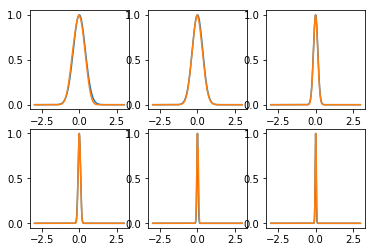

In [32]:
pose.assign(minimum)

from scipy.special import *
obs = pyrosetta.rosetta.protocols.moves.AddPyMOLObserver(pose, True)

Z = 1
for ii in range(6):
    
    sig = 6.0
    h = 0.02

    pose.assign(minimum)

    vals = mode_scan_jump(pose, scorefxn, v[:,ii], w=sig, h=h)
    xx = np.arange(-sig/2.,sig/2.+h,h)
    plt.subplot(2,3,ii+1)

    plt.plot(xx, np.exp(-0.5*w[ii]*(xx)**2))
    plt.plot(xx, np.exp(-(np.array(vals)-scorefxn(minimum))))
    
    if w[ii] < 10: Z *= np.trapz(np.exp(-(np.array(vals)-scorefxn(minimum))), dx=h)
    else: Z *= np.sqrt(2.0*np.pi/w[ii])*erf(np.sqrt(2.0*w[ii])*sig/4.0)
        
    pose.assign(minimum)


In [33]:
0.6163*(-np.log(Z) + np.log(8*np.pi**2) - np.log(6.022e-4) + scorefxn(minimum) - E_0)

-6.525639556009843

In [18]:
print -0.6163*np.log(Z)
print scorefxn(minimum)

2.4520985478756514
-12.4522700591


In [ ]:
print -0.6163*np.log(np.exp(-4.255/0.6163) + np.exp(-4.985/0.6163) + np.exp(-5.020/0.6163))

print -0.6163*np.log(np.exp(-5.382/0.6163) + np.exp(-5.360/0.6163) + np.exp(-5.394/0.6163) + np.exp(-5.402/0.6163) + np.exp(-5.519/0.6163))

0.6163*0.5*np.log(np.linalg.det(hessian))
print Z

In [ ]:
print v

In [121]:
matt_guess = lambda E: 2*(np.pi)**(len(w)/2)*(2*(E-scorefxn(minimum)))**(len(w)/2-1)/scipy.special.gamma(len(w)/2)/np.sqrt(np.linalg.det(hessian))

In [122]:
x = np.linspace(-100,100,1001)

applying phase space volume for two strand with helix length  1  and dangle length  0
1.0


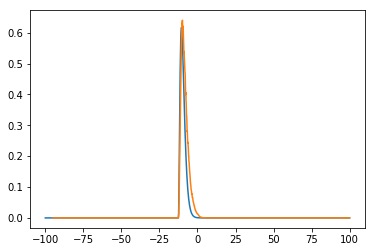

In [129]:
y = np.zeros_like(x)
for i, xx in enumerate(x):
    if xx < scorefxn(minimum): y[i] = 0
    else: y[i] = matt_guess(xx)
    
C = 1/np.sum(y)
print np.sum(c_g_hist._dos)/torsion_volume('c','g')
#plt.plot(x + scorefxn(minimum), C*1e5*y*np.exp(-x/1.0)*torsion_volume('c','g'))
plt.plot(x, y*np.exp(-x/1.0)*C*10)
plt.plot(c_g_hist._dos_scores[50:2000], c_g_hist._dos[50:2000]*np.exp(-c_g_hist._dos_scores[50:2000]/1.0))

In [118]:
print -scipy.special.logsumexp(-x,b=y*C*2.)
print torsion_volume('c','g')
C = torsion_volume('c','g')/np.sum(y)
y *= C


-2.30400962166
applying phase space volume for two strand with helix length  1  and dangle length  0
4.38649084493
applying phase space volume for two strand with helix length  1  and dangle length  0


In [ ]:
plt.plot(x + scorefxn(minimum), y*np.exp(-x/1.0)*torsion_volume('c','g')*1e5)
print np.sum(y)/torsion_volume('c','g')

In [ ]:
print -scipy.special.logsumexp(-x, b=y) + np.log(8*np.pi**2) - np.log(6.022e-4) - E_0 + scorefxn(minimum) + np.log(16*np.pi**2)

In [ ]:
print -np.log(Z)

In [ ]:
-0.6163*np.log(10*np.exp(-6/0.6163))

In [ ]:
print E_0

In [ ]:
print E_0

In [ ]:
print scorefxn(minimum)

In [ ]:
print v

In [ ]:
print 1./np.sqrt(w)

In [ ]:
print xx

In [ ]:
print np.arange(-1.5,1.520,0.0200)

In [ ]:
print E_0

In [ ]:
pmm.apply(minimum)

In [ ]:
print v

In [ ]:
print len(xx)/2

In [ ]:
ST_min = pose_from_file('./../recces_rosetta/min.pdb')
fuck = pose.fold_tree()
ST_min.fold_tree(fuck)

In [ ]:
print ST_min.fold_tree()
fuck = pose.fold_tree()

In [ ]:
scorefxn(ST_min)

In [ ]:
pose.dump_pdb('min3.pdb')

print ST_min.fold_tree()

In [ ]:
pose.set_chi(1, ST_min.chi(1))    

In [ ]:
print v

In [ ]:
pose.assign(minimum)
pose.dump_pdb('./u_g/min.pdb')

In [ ]:
kill_me = pose_from_file('./../recces_rosetta/results/u_g/ST/min.pdb')

In [ ]:
scorefxn(kill_me)

In [ ]:
minmover.apply(kill_me)

In [ ]:
minimum.dump_pdb('a_u_stack_min_1')

In [ ]:
pmm.apply(minimum)